In [1]:
# save the trained model
#PATH = './mymodel.pth'
#torch.save(clf.state_dict(), PATH)

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import json
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:

# Lee el archivo CSV
data = pd.read_csv('tfidf_matrix.csv')

# Visualiza las primeras filas del dataframe
# Dividir los datos en características (X) y etiquetas (y)
X = data.drop('cat_one_hot', axis=1)  # Eliminar la columna 'cat_one_hot' para obtener las características
etiquetas = []
y = data['cat_one_hot'].tolist()
for lista in y:
    vector = eval(lista)
    indice_maximo = vector.index(max(vector))
    etiquetas.append(indice_maximo)

labels = pd.DataFrame()
labels['label'] = etiquetas
print(labels)

      label
0         0
1         0
2         0
3         0
4         0
...     ...
7745      4
7746      4
7747      4
7748      4
7749      4

[7750 rows x 1 columns]


In [11]:
import time
# Definir la arquitectura de la red neuronal
class SimpleClassifier(nn.Module):
    def __init__(self,input_size,output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256,128)
        self.fc5 = nn.Linear(128,64)
        self.fc6 = nn.Linear(64, 5)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)  # Por ejemplo, con una probabilidad de dropout del 50%

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.softmax(x)
        return x.to(device)

def crear_directorio(nombre_carpeta):
    directorio_actual = os.getcwd()
    print("El directorio actual es:", directorio_actual)
    ruta_nueva_carpeta = os.path.join(directorio_actual, nombre_carpeta)
    # Verificar si la carpeta ya existe
    if not os.path.exists(ruta_nueva_carpeta):
        # Crear la carpeta si no existe
        os.mkdir(ruta_nueva_carpeta)
        print("Se creó la carpeta", nombre_carpeta, "en", directorio_actual)
    else:
        print("La carpeta", nombre_carpeta, "ya existe en", directorio_actual)

    ruta_modificada = ruta_nueva_carpeta.replace("\\","/")
    return ruta_modificada

def RNN_model(X,labels,test_size,epochs,lr):
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
    X_train_values = X_train.values
    X_train_tensor = torch.tensor(X_train_values,dtype=torch.float32)
    y_train_values = y_train.values
    y_train_tensor = torch.tensor(y_train_values,dtype=torch.long)
    X_test_values = X_test.values
    X_test_tensor = torch.tensor(X_test_values,dtype=torch.float32)
    y_test_values = y_test.values
    y_test_tensor = torch.tensor(y_test_values,dtype=torch.long)
    y_train_tensor_flat = torch.tensor(y_train.values.flatten(), dtype=torch.long)
    output_size = 5
    # Crear un DataLoader para manejar los datos de entrenamiento
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor_flat)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    input_size = X_train_values[0].shape[0]
    
    # Instanciar el modelo y definir la función de pérdida y el optimizador
    model = SimpleClassifier(input_size,output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Entrenar el modelo
    losses = []
    sum_losses = 1
    #while sum_losses > error:
    for epoch in tqdm(range(epochs),desc="Procesando epocas: "):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover datos al dispositivo
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            #print(f"Valor de error:  {loss}")
            optimizer.step()
            running_loss += loss.item()
        sum_losses = running_loss / len(train_loader)
        print(sum_losses)
        losses.append(sum_losses)
    
    # Graficar el loss durante el entrenamiento
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    ruta_figura_incom = crear_directorio("Neural_network_classification")

    nombre_carpeta = f"RRN_{epochs}_{lr}_{test_size}"
    os.makedirs(os.path.join(ruta_figura_incom, nombre_carpeta), exist_ok=True)
    ruta_figura_incom = ruta_figura_incom + "/" + nombre_carpeta
    
    ruta_figura = f"{ruta_figura_incom}/funcion_de_perdida_{epochs}_{lr}.png"
    plt.savefig(ruta_figura)
    print("Matriz de confusión guardada en:", ruta_figura)
    plt.show()
    plt.show()
    
    # Evaluar el modelo en el conjunto de prueba
    with torch.no_grad():
        X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        print('Test accuracy:', accuracy)
    
    predicted = predicted.cpu()  # Moviendo las predicciones a la CPU
    
    
    # Calcula las métricas
    accuracy = accuracy_score(y_test_tensor.cpu(), predicted.numpy())
    precision = precision_score(y_test, predicted.numpy(), average='macro', zero_division=0)
    recall = recall_score(y_test, predicted.numpy(), average='macro', zero_division=0)
    f1 = f1_score(y_test, predicted.numpy(), average='macro', zero_division=0)

    diccionario = {'accuracy':accuracy,'precision':precision,'recall':recall,'f1':f1}

    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)
    print("\n")
    # Calcular métricas
    print('Classification Report:')
    print(classification_report(y_test, predicted.numpy()))
    reporte_clasificacion = classification_report(y_test, predicted.numpy(),output_dict = True)
    report_df = pd.DataFrame(reporte_clasificacion)
    print(report_df)
    # Calcular matriz de confusión
    conf_matrix = confusion_matrix(y_test, predicted.numpy())
    
    # Crear un mapa de calor para la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiquetas Predichas')
    plt.ylabel('Etiquetas Verdaderas')
    
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    ruta_figura_incom = crear_directorio("Neural_network_classification")
    
    nombre_carpeta = f"RRN_{epochs}_{lr}_{test_size}"
    os.makedirs(os.path.join(ruta_figura_incom, nombre_carpeta), exist_ok=True)
    ruta_figura_incom = ruta_figura_incom + "/" + nombre_carpeta
    
    ruta_figura = f"{ruta_figura_incom}/matriz_confusion_{epochs}_{lr}.png"
    plt.savefig(ruta_figura)
    print("Matriz de confusión guardada en:", ruta_figura)
    plt.show()

    res = f"/resultados_{epochs}_{lr}_{test_size}.json"
    res1 = f"/reporte_clasificacion_{epochs}_{lr}_{test_size}.csv"
    ruta_archivo_json = ruta_figura_incom + res
    ruta_archivo_json_report = ruta_figura_incom + res1

    # Guardar el diccionario como un archivo JSON
    with open(ruta_archivo_json, "w") as archivo_json:
        json.dump(diccionario, archivo_json)

    report_df.to_csv(ruta_archivo_json_report)
    
    print("Diccionario guardado como JSON en:", ruta_archivo_json)
    

In [12]:
print(labels)

      label
0         0
1         0
2         0
3         0
4         0
...     ...
7745      4
7746      4
7747      4
7748      4
7749      4

[7750 rows x 1 columns]


Procesando red con 100 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   1%|▋                                                              | 1/100 [00:01<02:59,  1.81s/it]

1.6093723766943988


Procesando epocas:   2%|█▎                                                             | 2/100 [00:03<02:45,  1.69s/it]

1.54961958843119


Procesando epocas:   3%|█▉                                                             | 3/100 [00:05<02:40,  1.66s/it]

1.4484440579133875


Procesando epocas:   4%|██▌                                                            | 4/100 [00:06<02:37,  1.64s/it]

1.3880857649971456


Procesando epocas:   5%|███▏                                                           | 5/100 [00:08<02:35,  1.63s/it]

1.32592793562833


Procesando epocas:   6%|███▊                                                           | 6/100 [00:09<02:32,  1.63s/it]

1.2771632075309753


Procesando epocas:   7%|████▍                                                          | 7/100 [00:11<02:31,  1.63s/it]

1.239349505480598


Procesando epocas:   8%|█████                                                          | 8/100 [00:13<02:29,  1.63s/it]

1.2137005055651946


Procesando epocas:   9%|█████▋                                                         | 9/100 [00:14<02:30,  1.65s/it]

1.1954674661159514


Procesando epocas:  10%|██████▏                                                       | 10/100 [00:16<02:29,  1.66s/it]

1.1846389090313632


Procesando epocas:  11%|██████▊                                                       | 11/100 [00:18<02:28,  1.67s/it]

1.173692505499896


Procesando epocas:  12%|███████▍                                                      | 12/100 [00:19<02:27,  1.67s/it]

1.1606676462818595


Procesando epocas:  13%|████████                                                      | 13/100 [00:21<02:25,  1.67s/it]

1.1502049572327557


Procesando epocas:  14%|████████▋                                                     | 14/100 [00:23<02:22,  1.66s/it]

1.1210187585914837


Procesando epocas:  15%|█████████▎                                                    | 15/100 [00:24<02:21,  1.67s/it]

1.103506790189182


Procesando epocas:  16%|█████████▉                                                    | 16/100 [00:26<02:20,  1.67s/it]

1.0908708049970515


Procesando epocas:  17%|██████████▌                                                   | 17/100 [00:28<02:17,  1.65s/it]

1.0817299443132737


Procesando epocas:  18%|███████████▏                                                  | 18/100 [00:29<02:15,  1.65s/it]

1.0724049217560712


Procesando epocas:  19%|███████████▊                                                  | 19/100 [00:31<02:14,  1.66s/it]

1.064147300229353


Procesando epocas:  20%|████████████▍                                                 | 20/100 [00:33<02:13,  1.67s/it]

1.0558798870619606


Procesando epocas:  21%|█████████████                                                 | 21/100 [00:34<02:11,  1.66s/it]

1.0500768580857445


Procesando epocas:  22%|█████████████▋                                                | 22/100 [00:36<02:09,  1.66s/it]

1.0464252054691314


Procesando epocas:  23%|██████████████▎                                               | 23/100 [00:38<02:07,  1.66s/it]

1.04759503252366


Procesando epocas:  24%|██████████████▉                                               | 24/100 [00:39<02:05,  1.66s/it]

1.0422702656072729


Procesando epocas:  25%|███████████████▌                                              | 25/100 [00:41<02:04,  1.65s/it]

1.0397447084679323


Procesando epocas:  26%|████████████████                                              | 26/100 [00:43<02:02,  1.65s/it]

1.0418297985020806


Procesando epocas:  27%|████████████████▋                                             | 27/100 [00:44<02:00,  1.65s/it]

1.040483653194764


Procesando epocas:  28%|█████████████████▎                                            | 28/100 [00:46<01:58,  1.65s/it]

1.0385327300604652


Procesando epocas:  29%|█████████████████▉                                            | 29/100 [00:48<01:56,  1.65s/it]

1.0348575080142302


Procesando epocas:  30%|██████████████████▌                                           | 30/100 [00:49<01:55,  1.65s/it]

1.038636026312323


Procesando epocas:  31%|███████████████████▏                                          | 31/100 [00:51<01:54,  1.65s/it]

1.0368626839974346


Procesando epocas:  32%|███████████████████▊                                          | 32/100 [00:52<01:52,  1.65s/it]

1.032858060388004


Procesando epocas:  33%|████████████████████▍                                         | 33/100 [00:54<01:50,  1.65s/it]

1.0309418906183805


Procesando epocas:  34%|█████████████████████                                         | 34/100 [00:56<01:48,  1.65s/it]

1.0338838142507216


Procesando epocas:  35%|█████████████████████▋                                        | 35/100 [00:57<01:47,  1.65s/it]

1.0357559866764967


Procesando epocas:  36%|██████████████████████▎                                       | 36/100 [00:59<01:45,  1.65s/it]

1.031478024931515


Procesando epocas:  37%|██████████████████████▉                                       | 37/100 [01:01<01:43,  1.65s/it]

1.0256182646050174


Procesando epocas:  38%|███████████████████████▌                                      | 38/100 [01:02<01:42,  1.65s/it]

1.0270676055375267


Procesando epocas:  39%|████████████████████████▏                                     | 39/100 [01:04<01:40,  1.65s/it]

1.0279779620030347


Procesando epocas:  40%|████████████████████████▊                                     | 40/100 [01:06<01:39,  1.65s/it]

1.0247854299405041


Procesando epocas:  41%|█████████████████████████▍                                    | 41/100 [01:07<01:37,  1.66s/it]

1.0234378250206217


Procesando epocas:  42%|██████████████████████████                                    | 42/100 [01:09<01:35,  1.65s/it]

1.0225539533530965


Procesando epocas:  43%|██████████████████████████▋                                   | 43/100 [01:11<01:34,  1.67s/it]

1.0209075692821952


Procesando epocas:  44%|███████████████████████████▎                                  | 44/100 [01:12<01:33,  1.66s/it]

1.0186320841312408


Procesando epocas:  45%|███████████████████████████▉                                  | 45/100 [01:14<01:31,  1.67s/it]

1.0205356370000278


Procesando epocas:  46%|████████████████████████████▌                                 | 46/100 [01:16<01:29,  1.67s/it]

1.023393184998456


Procesando epocas:  47%|█████████████████████████████▏                                | 47/100 [01:17<01:29,  1.70s/it]

1.0245630295837627


Procesando epocas:  48%|█████████████████████████████▊                                | 48/100 [01:19<01:29,  1.72s/it]

1.024652523503584


Procesando epocas:  49%|██████████████████████████████▍                               | 49/100 [01:21<01:28,  1.73s/it]

1.0258151987019708


Procesando epocas:  50%|███████████████████████████████                               | 50/100 [01:23<01:26,  1.74s/it]

1.0275678203386418


Procesando epocas:  51%|███████████████████████████████▌                              | 51/100 [01:25<01:25,  1.75s/it]

1.028249389634413


Procesando epocas:  52%|████████████████████████████████▏                             | 52/100 [01:26<01:24,  1.76s/it]

1.0230918835191165


Procesando epocas:  53%|████████████████████████████████▊                             | 53/100 [01:28<01:22,  1.76s/it]

1.0221796635319205


Procesando epocas:  54%|█████████████████████████████████▍                            | 54/100 [01:30<01:21,  1.76s/it]

1.0208286853397595


Procesando epocas:  55%|██████████████████████████████████                            | 55/100 [01:32<01:19,  1.76s/it]

1.0271167450091419


Procesando epocas:  56%|██████████████████████████████████▋                           | 56/100 [01:33<01:17,  1.76s/it]

1.0258540283231175


Procesando epocas:  57%|███████████████████████████████████▎                          | 57/100 [01:35<01:15,  1.76s/it]

1.024803568685756


Procesando epocas:  58%|███████████████████████████████████▉                          | 58/100 [01:37<01:14,  1.76s/it]

1.0210260987281798


Procesando epocas:  59%|████████████████████████████████████▌                         | 59/100 [01:39<01:12,  1.77s/it]

1.0230399110737969


Procesando epocas:  60%|█████████████████████████████████████▏                        | 60/100 [01:40<01:10,  1.77s/it]

1.0216972140704885


Procesando epocas:  61%|█████████████████████████████████████▊                        | 61/100 [01:42<01:08,  1.76s/it]

1.0223186990794013


Procesando epocas:  62%|██████████████████████████████████████▍                       | 62/100 [01:44<01:07,  1.76s/it]

1.0240993096547968


Procesando epocas:  63%|███████████████████████████████████████                       | 63/100 [01:46<01:05,  1.76s/it]

1.023419136510176


Procesando epocas:  64%|███████████████████████████████████████▋                      | 64/100 [01:47<01:03,  1.76s/it]

1.0221421154106365


Procesando epocas:  65%|████████████████████████████████████████▎                     | 65/100 [01:49<01:01,  1.76s/it]

1.0207690610605127


Procesando epocas:  66%|████████████████████████████████████████▉                     | 66/100 [01:51<01:00,  1.77s/it]

1.0226467150099137


Procesando epocas:  67%|█████████████████████████████████████████▌                    | 67/100 [01:53<00:58,  1.76s/it]

1.0210097148137933


Procesando epocas:  68%|██████████████████████████████████████████▏                   | 68/100 [01:55<00:56,  1.77s/it]

1.0209593867554385


Procesando epocas:  69%|██████████████████████████████████████████▊                   | 69/100 [01:56<00:54,  1.77s/it]

1.0170298106530133


Procesando epocas:  70%|███████████████████████████████████████████▍                  | 70/100 [01:58<00:52,  1.76s/it]

1.0175444872940287


Procesando epocas:  71%|████████████████████████████████████████████                  | 71/100 [02:00<00:51,  1.76s/it]

1.0249657332897186


Procesando epocas:  72%|████████████████████████████████████████████▋                 | 72/100 [02:02<00:49,  1.76s/it]

1.0207408000441158


Procesando epocas:  73%|█████████████████████████████████████████████▎                | 73/100 [02:03<00:47,  1.75s/it]

1.0174732895458445


Procesando epocas:  74%|█████████████████████████████████████████████▉                | 74/100 [02:05<00:45,  1.74s/it]

1.0153204574304469


Procesando epocas:  75%|██████████████████████████████████████████████▌               | 75/100 [02:07<00:43,  1.73s/it]

1.0191324921215281


Procesando epocas:  76%|███████████████████████████████████████████████               | 76/100 [02:08<00:41,  1.72s/it]

1.0169797613340266


Procesando epocas:  77%|███████████████████████████████████████████████▋              | 77/100 [02:10<00:39,  1.72s/it]

1.0161663847811082


Procesando epocas:  78%|████████████████████████████████████████████████▎             | 78/100 [02:12<00:37,  1.71s/it]

1.0145240958999184


Procesando epocas:  79%|████████████████████████████████████████████████▉             | 79/100 [02:14<00:35,  1.71s/it]

1.0146708775969113


Procesando epocas:  80%|█████████████████████████████████████████████████▌            | 80/100 [02:15<00:34,  1.71s/it]

1.016300463325837


Procesando epocas:  81%|██████████████████████████████████████████████████▏           | 81/100 [02:17<00:32,  1.70s/it]

1.0139725288924049


Procesando epocas:  82%|██████████████████████████████████████████████████▊           | 82/100 [02:19<00:30,  1.71s/it]

1.0122845698805416


Procesando epocas:  83%|███████████████████████████████████████████████████▍          | 83/100 [02:20<00:28,  1.70s/it]

1.0154849515241735


Procesando epocas:  84%|████████████████████████████████████████████████████          | 84/100 [02:22<00:27,  1.70s/it]

1.0146896635784823


Procesando epocas:  85%|████████████████████████████████████████████████████▋         | 85/100 [02:24<00:25,  1.70s/it]

1.0139897367533515


Procesando epocas:  86%|█████████████████████████████████████████████████████▎        | 86/100 [02:25<00:23,  1.70s/it]

1.012764576252769


Procesando epocas:  87%|█████████████████████████████████████████████████████▉        | 87/100 [02:27<00:22,  1.70s/it]

1.0142123159240275


Procesando epocas:  88%|██████████████████████████████████████████████████████▌       | 88/100 [02:29<00:20,  1.70s/it]

1.0154006256776698


Procesando epocas:  89%|███████████████████████████████████████████████████████▏      | 89/100 [02:31<00:18,  1.70s/it]

1.0137582508956684


Procesando epocas:  90%|███████████████████████████████████████████████████████▊      | 90/100 [02:32<00:17,  1.71s/it]

1.0161009280120625


Procesando epocas:  91%|████████████████████████████████████████████████████████▍     | 91/100 [02:34<00:15,  1.70s/it]

1.0146226244814256


Procesando epocas:  92%|█████████████████████████████████████████████████████████     | 92/100 [02:36<00:13,  1.70s/it]

1.013850885629654


Procesando epocas:  93%|█████████████████████████████████████████████████████████▋    | 93/100 [02:37<00:11,  1.70s/it]

1.013115845708286


Procesando epocas:  94%|██████████████████████████████████████████████████████████▎   | 94/100 [02:39<00:10,  1.70s/it]

1.0137845379464767


Procesando epocas:  95%|██████████████████████████████████████████████████████████▉   | 95/100 [02:41<00:08,  1.70s/it]

1.0205884116537431


Procesando epocas:  96%|███████████████████████████████████████████████████████████▌  | 96/100 [02:42<00:06,  1.70s/it]

1.011245956140406


Procesando epocas:  97%|████████████████████████████████████████████████████████████▏ | 97/100 [02:44<00:05,  1.69s/it]

1.0100334097357357


Procesando epocas:  98%|████████████████████████████████████████████████████████████▊ | 98/100 [02:46<00:03,  1.69s/it]

1.0090156541151158


Procesando epocas:  99%|█████████████████████████████████████████████████████████████▍| 99/100 [02:48<00:01,  1.68s/it]

1.007547893594293


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.70s/it]

1.0072014542186962
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_100_0.0001_0.3/funcion_de_perdida_100_0.0001.png


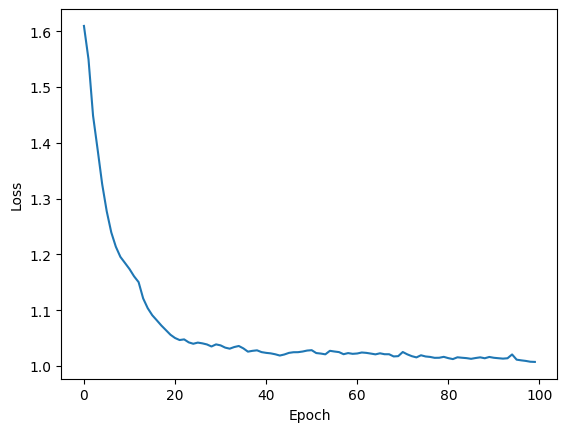

Test accuracy: 462.37290322580645
Accuracy: 0.4443010752688172
Precision: 0.48251514380937277
Recall: 0.44565296725205317
F1-score: 0.45279125672111087


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.40      0.51       495
           1       0.44      0.49      0.46       472
           2       0.30      0.36      0.33       449
           3       0.29      0.35      0.32       463
           4       0.65      0.63      0.64       446

    accuracy                           0.44      2325
   macro avg       0.48      0.45      0.45      2325
weighted avg       0.49      0.44      0.45      2325

                    0           1           2           3           4  \
precision    0.728625    0.439163    0.302804    0.288496    0.653488   
recall       0.395960    0.489407    0.360802    0.352052    0.630045   
f1-score     0.513089    0.462926    0.329268    0.317121    0.641553   
support    495.000000  472.000000  449.000

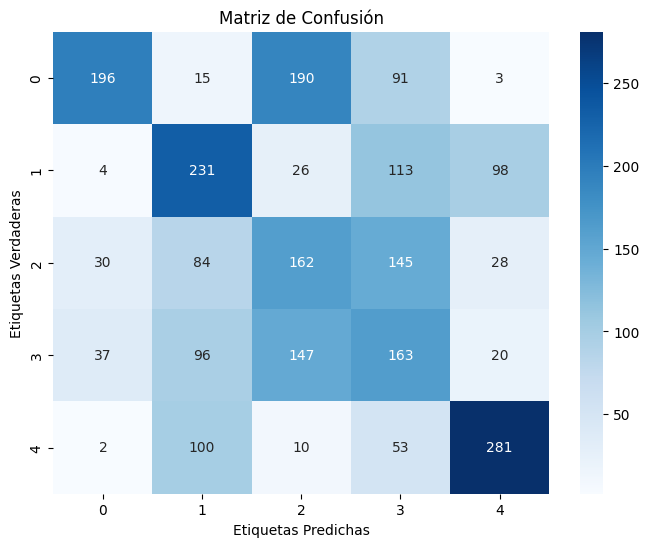

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_100_0.0001_0.3/resultados_100_0.0001_0.3.json
Procesando red con 100 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   1%|▋                                                              | 1/100 [00:01<02:43,  1.65s/it]

1.6094850273693309


Procesando epocas:   2%|█▎                                                             | 2/100 [00:03<02:42,  1.65s/it]

1.6093907587668475


Procesando epocas:   3%|█▉                                                             | 3/100 [00:04<02:40,  1.65s/it]

1.6094322989968692


Procesando epocas:   4%|██▌                                                            | 4/100 [00:06<02:38,  1.65s/it]

1.6093589060446796


Procesando epocas:   5%|███▏                                                           | 5/100 [00:08<02:37,  1.66s/it]

1.6093422623241649


Procesando epocas:   6%|███▊                                                           | 6/100 [00:09<02:35,  1.66s/it]

1.6090870043810677


Procesando epocas:   7%|████▍                                                          | 7/100 [00:11<02:34,  1.66s/it]

1.608172258910011


Procesando epocas:   8%|█████                                                          | 8/100 [00:13<02:32,  1.66s/it]

1.605771444825565


Procesando epocas:   9%|█████▋                                                         | 9/100 [00:14<02:30,  1.65s/it]

1.5989033131038441


Procesando epocas:  10%|██████▏                                                       | 10/100 [00:16<02:28,  1.65s/it]

1.571084469907424


Procesando epocas:  11%|██████▊                                                       | 11/100 [00:18<02:27,  1.66s/it]

1.5162301238845377


Procesando epocas:  12%|███████▍                                                      | 12/100 [00:19<02:26,  1.66s/it]

1.480795462692485


Procesando epocas:  13%|████████                                                      | 13/100 [00:21<02:24,  1.66s/it]

1.4637916487805984


Procesando epocas:  14%|████████▋                                                     | 14/100 [00:23<02:22,  1.66s/it]

1.4472123917411355


Procesando epocas:  15%|█████████▎                                                    | 15/100 [00:24<02:20,  1.65s/it]

1.4366943191079533


Procesando epocas:  16%|█████████▉                                                    | 16/100 [00:26<02:18,  1.65s/it]

1.422747839899624


Procesando epocas:  17%|██████████▌                                                   | 17/100 [00:28<02:17,  1.65s/it]

1.4143820867818944


Procesando epocas:  18%|███████████▏                                                  | 18/100 [00:29<02:15,  1.65s/it]

1.397479418446036


Procesando epocas:  19%|███████████▊                                                  | 19/100 [00:31<02:13,  1.65s/it]

1.383166911321528


Procesando epocas:  20%|████████████▍                                                 | 20/100 [00:33<02:12,  1.65s/it]

1.3647927838213303


Procesando epocas:  21%|█████████████                                                 | 21/100 [00:34<02:10,  1.65s/it]

1.3464511541759268


Procesando epocas:  22%|█████████████▋                                                | 22/100 [00:36<02:09,  1.65s/it]

1.337324991646935


Procesando epocas:  23%|██████████████▎                                               | 23/100 [00:38<02:07,  1.65s/it]

1.3274642916286692


Procesando epocas:  24%|██████████████▉                                               | 24/100 [00:39<02:05,  1.65s/it]

1.3134641317760243


Procesando epocas:  25%|███████████████▌                                              | 25/100 [00:41<02:04,  1.65s/it]

1.3052008208106547


Procesando epocas:  26%|████████████████                                              | 26/100 [00:43<02:02,  1.66s/it]

1.2931791852502261


Procesando epocas:  27%|████████████████▋                                             | 27/100 [00:44<02:01,  1.67s/it]

1.280149117638083


Procesando epocas:  28%|█████████████████▎                                            | 28/100 [00:46<01:59,  1.66s/it]

1.274119758605957


Procesando epocas:  29%|█████████████████▉                                            | 29/100 [00:48<01:57,  1.65s/it]

1.2642565348569084


Procesando epocas:  30%|██████████████████▌                                           | 30/100 [00:49<01:55,  1.65s/it]

1.2577115535736083


Procesando epocas:  31%|███████████████████▏                                          | 31/100 [00:51<01:53,  1.65s/it]

1.2478272487135496


Procesando epocas:  32%|███████████████████▊                                          | 32/100 [00:52<01:51,  1.65s/it]

1.2421626210212708


Procesando epocas:  33%|████████████████████▍                                         | 33/100 [00:54<01:49,  1.64s/it]

1.2385001995984246


Procesando epocas:  34%|█████████████████████                                         | 34/100 [00:56<01:47,  1.63s/it]

1.228879811483271


Procesando epocas:  35%|█████████████████████▋                                        | 35/100 [00:57<01:46,  1.63s/it]

1.2221691005370197


Procesando epocas:  36%|██████████████████████▎                                       | 36/100 [00:59<01:44,  1.63s/it]

1.2168848128879772


Procesando epocas:  37%|██████████████████████▉                                       | 37/100 [01:01<01:42,  1.62s/it]

1.2105470853693345


Procesando epocas:  38%|███████████████████████▌                                      | 38/100 [01:02<01:40,  1.62s/it]

1.208883004328784


Procesando epocas:  39%|████████████████████████▏                                     | 39/100 [01:04<01:38,  1.62s/it]

1.203652494093951


Procesando epocas:  40%|████████████████████████▊                                     | 40/100 [01:05<01:37,  1.62s/it]

1.1995567735503703


Procesando epocas:  41%|█████████████████████████▍                                    | 41/100 [01:07<01:35,  1.62s/it]

1.1954958572107204


Procesando epocas:  42%|██████████████████████████                                    | 42/100 [01:09<01:34,  1.62s/it]

1.1892534599584692


Procesando epocas:  43%|██████████████████████████▋                                   | 43/100 [01:10<01:32,  1.63s/it]

1.1878614180228289


Procesando epocas:  44%|███████████████████████████▎                                  | 44/100 [01:12<01:31,  1.63s/it]

1.1827965378761292


Procesando epocas:  45%|███████████████████████████▉                                  | 45/100 [01:14<01:29,  1.62s/it]

1.182508159385008


Procesando epocas:  46%|████████████████████████████▌                                 | 46/100 [01:15<01:27,  1.62s/it]

1.1769016651546254


Procesando epocas:  47%|█████████████████████████████▏                                | 47/100 [01:17<01:26,  1.62s/it]

1.1737170885590946


Procesando epocas:  48%|█████████████████████████████▊                                | 48/100 [01:18<01:25,  1.65s/it]

1.1735270328381482


Procesando epocas:  49%|██████████████████████████████▍                               | 49/100 [01:20<01:24,  1.65s/it]

1.1659402321366703


Procesando epocas:  50%|███████████████████████████████                               | 50/100 [01:22<01:22,  1.66s/it]

1.1701643112827749


Procesando epocas:  51%|███████████████████████████████▌                              | 51/100 [01:23<01:21,  1.66s/it]

1.1646568936460158


Procesando epocas:  52%|████████████████████████████████▏                             | 52/100 [01:25<01:20,  1.67s/it]

1.1617895592661465


Procesando epocas:  53%|████████████████████████████████▊                             | 53/100 [01:27<01:18,  1.66s/it]

1.1638233142740586


Procesando epocas:  54%|█████████████████████████████████▍                            | 54/100 [01:28<01:16,  1.66s/it]

1.158803788353415


Procesando epocas:  55%|██████████████████████████████████                            | 55/100 [01:30<01:15,  1.68s/it]

1.1602396789719076


Procesando epocas:  56%|██████████████████████████████████▋                           | 56/100 [01:32<01:15,  1.71s/it]

1.156931014621959


Procesando epocas:  57%|███████████████████████████████████▎                          | 57/100 [01:34<01:14,  1.73s/it]

1.159121604526744


Procesando epocas:  58%|███████████████████████████████████▉                          | 58/100 [01:36<01:13,  1.74s/it]

1.1554325275561388


Procesando epocas:  59%|████████████████████████████████████▌                         | 59/100 [01:37<01:11,  1.75s/it]

1.152546919444028


Procesando epocas:  60%|█████████████████████████████████████▏                        | 60/100 [01:39<01:10,  1.75s/it]

1.1529086474110097


Procesando epocas:  61%|█████████████████████████████████████▊                        | 61/100 [01:41<01:08,  1.76s/it]

1.1540416156544404


Procesando epocas:  62%|██████████████████████████████████████▍                       | 62/100 [01:43<01:06,  1.76s/it]

1.150563961618087


Procesando epocas:  63%|███████████████████████████████████████                       | 63/100 [01:44<01:05,  1.76s/it]

1.1483414211693932


Procesando epocas:  64%|███████████████████████████████████████▋                      | 64/100 [01:46<01:03,  1.75s/it]

1.1483028615222257


Procesando epocas:  65%|████████████████████████████████████████▎                     | 65/100 [01:48<01:01,  1.75s/it]

1.1466714781873366


Procesando epocas:  66%|████████████████████████████████████████▉                     | 66/100 [01:50<00:59,  1.76s/it]

1.1480425094856936


Procesando epocas:  67%|█████████████████████████████████████████▌                    | 67/100 [01:51<00:57,  1.75s/it]

1.145913028717041


Procesando epocas:  68%|██████████████████████████████████████████▏                   | 68/100 [01:53<00:56,  1.76s/it]

1.1456387092085445


Procesando epocas:  69%|██████████████████████████████████████████▊                   | 69/100 [01:55<00:54,  1.76s/it]

1.1451138324597303


Procesando epocas:  70%|███████████████████████████████████████████▍                  | 70/100 [01:57<00:52,  1.76s/it]

1.1434502797968247


Procesando epocas:  71%|████████████████████████████████████████████                  | 71/100 [01:58<00:51,  1.76s/it]

1.1451953386559206


Procesando epocas:  72%|████████████████████████████████████████████▋                 | 72/100 [02:00<00:49,  1.76s/it]

1.1447499517132254


Procesando epocas:  73%|█████████████████████████████████████████████▎                | 73/100 [02:02<00:47,  1.76s/it]

1.1423112939385807


Procesando epocas:  74%|█████████████████████████████████████████████▉                | 74/100 [02:04<00:45,  1.76s/it]

1.1425437418853535


Procesando epocas:  75%|██████████████████████████████████████████████▌               | 75/100 [02:05<00:43,  1.76s/it]

1.1397585434072157


Procesando epocas:  76%|███████████████████████████████████████████████               | 76/100 [02:07<00:42,  1.76s/it]

1.1410963749184329


Procesando epocas:  77%|███████████████████████████████████████████████▋              | 77/100 [02:09<00:40,  1.76s/it]

1.1399339658372543


Procesando epocas:  78%|████████████████████████████████████████████████▎             | 78/100 [02:11<00:38,  1.76s/it]

1.139180686894585


Procesando epocas:  79%|████████████████████████████████████████████████▉             | 79/100 [02:12<00:37,  1.76s/it]

1.1375710213885588


Procesando epocas:  80%|█████████████████████████████████████████████████▌            | 80/100 [02:14<00:35,  1.77s/it]

1.1389032581273246


Procesando epocas:  81%|██████████████████████████████████████████████████▏           | 81/100 [02:16<00:33,  1.76s/it]

1.1368167537100176


Procesando epocas:  82%|██████████████████████████████████████████████████▊           | 82/100 [02:18<00:31,  1.74s/it]

1.1347561829230364


Procesando epocas:  83%|███████████████████████████████████████████████████▍          | 83/100 [02:19<00:29,  1.72s/it]

1.1321131134734435


Procesando epocas:  84%|████████████████████████████████████████████████████          | 84/100 [02:21<00:27,  1.71s/it]

1.1319368828745449


Procesando epocas:  85%|████████████████████████████████████████████████████▋         | 85/100 [02:23<00:25,  1.70s/it]

1.132402546265546


Procesando epocas:  86%|█████████████████████████████████████████████████████▎        | 86/100 [02:24<00:23,  1.70s/it]

1.1302850870525136


Procesando epocas:  87%|█████████████████████████████████████████████████████▉        | 87/100 [02:26<00:22,  1.69s/it]

1.1275892601293676


Procesando epocas:  88%|██████████████████████████████████████████████████████▌       | 88/100 [02:28<00:20,  1.69s/it]

1.1286725258125978


Procesando epocas:  89%|███████████████████████████████████████████████████████▏      | 89/100 [02:30<00:18,  1.69s/it]

1.126513385071474


Procesando epocas:  90%|███████████████████████████████████████████████████████▊      | 90/100 [02:31<00:16,  1.69s/it]

1.1217896493042216


Procesando epocas:  91%|████████████████████████████████████████████████████████▍     | 91/100 [02:33<00:15,  1.69s/it]

1.117141568660736


Procesando epocas:  92%|█████████████████████████████████████████████████████████     | 92/100 [02:35<00:13,  1.70s/it]

1.1144185455406412


Procesando epocas:  93%|█████████████████████████████████████████████████████████▋    | 93/100 [02:36<00:11,  1.70s/it]

1.1152961040244382


Procesando epocas:  94%|██████████████████████████████████████████████████████████▎   | 94/100 [02:38<00:10,  1.71s/it]

1.1105859497014214


Procesando epocas:  95%|██████████████████████████████████████████████████████████▉   | 95/100 [02:40<00:08,  1.71s/it]

1.1060248911380768


Procesando epocas:  96%|███████████████████████████████████████████████████████████▌  | 96/100 [02:41<00:06,  1.71s/it]

1.1044556926278506


Procesando epocas:  97%|████████████████████████████████████████████████████████████▏ | 97/100 [02:43<00:05,  1.70s/it]

1.1011371640598073


Procesando epocas:  98%|████████████████████████████████████████████████████████████▊ | 98/100 [02:45<00:03,  1.70s/it]

1.0947557337143843


Procesando epocas:  99%|█████████████████████████████████████████████████████████████▍| 99/100 [02:47<00:01,  1.74s/it]

1.0918532974579755


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]

1.0898380815982818
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_100_1e-05_0.3/funcion_de_perdida_100_1e-05.png


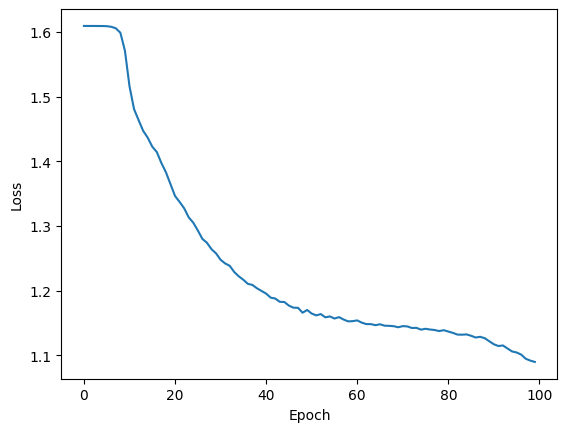

Test accuracy: 466.9010752688172
Accuracy: 0.43053763440860215
Precision: 0.41798122091206624
Recall: 0.4284926836212562
F1-score: 0.42125881859229597


Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.58      0.57       495
           1       0.38      0.43      0.40       472
           2       0.24      0.17      0.20       449
           3       0.29      0.31      0.30       463
           4       0.62      0.65      0.64       446

    accuracy                           0.43      2325
   macro avg       0.42      0.43      0.42      2325
weighted avg       0.42      0.43      0.42      2325

                    0           1           2           3           4  \
precision    0.558140    0.377778    0.243506    0.289206    0.621277   
recall       0.581818    0.432203    0.167038    0.306695    0.654709   
f1-score     0.569733    0.403162    0.198151    0.297694    0.637555   
support    495.000000  472.000000  449.0000

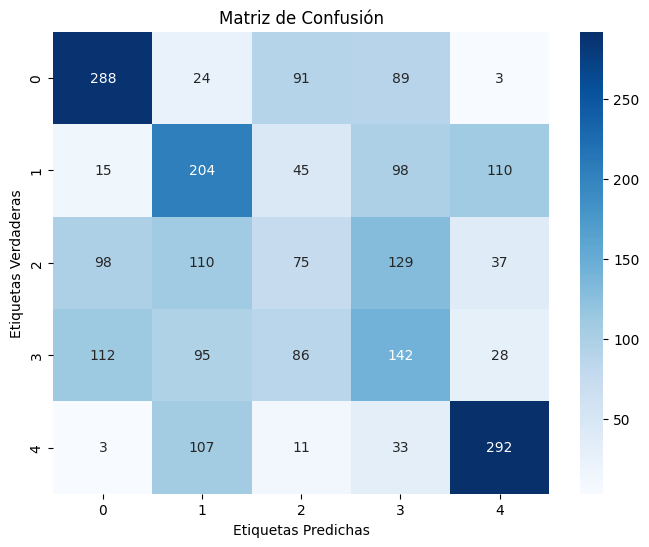

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_100_1e-05_0.3/resultados_100_1e-05_0.3.json
Procesando red con 300 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|▏                                                              | 1/300 [00:01<08:39,  1.74s/it]

1.6095201401149526


Procesando epocas:   1%|▍                                                              | 2/300 [00:03<08:36,  1.73s/it]

1.5497819458737092


Procesando epocas:   1%|▋                                                              | 3/300 [00:05<08:29,  1.71s/it]

1.4296274879399469


Procesando epocas:   1%|▊                                                              | 4/300 [00:06<08:25,  1.71s/it]

1.3632228998576894


Procesando epocas:   2%|█                                                              | 5/300 [00:08<08:24,  1.71s/it]

1.3217437021872576


Procesando epocas:   2%|█▎                                                             | 6/300 [00:10<08:19,  1.70s/it]

1.2813334822654725


Procesando epocas:   2%|█▍                                                             | 7/300 [00:11<08:21,  1.71s/it]

1.2427138728253981


Procesando epocas:   3%|█▋                                                             | 8/300 [00:13<08:16,  1.70s/it]

1.2124397291856654


Procesando epocas:   3%|█▉                                                             | 9/300 [00:15<08:13,  1.70s/it]

1.1797184782869676


Procesando epocas:   3%|██                                                            | 10/300 [00:17<08:09,  1.69s/it]

1.1443515419960022


Procesando epocas:   4%|██▎                                                           | 11/300 [00:18<08:04,  1.68s/it]

1.130112572627909


Procesando epocas:   4%|██▍                                                           | 12/300 [00:20<08:03,  1.68s/it]

1.0998980234651003


Procesando epocas:   4%|██▋                                                           | 13/300 [00:22<08:01,  1.68s/it]

1.0828911788323345


Procesando epocas:   5%|██▉                                                           | 14/300 [00:23<07:58,  1.67s/it]

1.0682723269743077


Procesando epocas:   5%|███                                                           | 15/300 [00:25<07:55,  1.67s/it]

1.0617939798270954


Procesando epocas:   5%|███▎                                                          | 16/300 [00:27<07:53,  1.67s/it]

1.0564645553336425


Procesando epocas:   6%|███▌                                                          | 17/300 [00:28<07:57,  1.69s/it]

1.0524453583885642


Procesando epocas:   6%|███▋                                                          | 18/300 [00:30<07:53,  1.68s/it]

1.042646973623949


Procesando epocas:   6%|███▉                                                          | 19/300 [00:32<07:50,  1.67s/it]

1.0409445643424988


Procesando epocas:   7%|████▏                                                         | 20/300 [00:33<07:47,  1.67s/it]

1.037940803345512


Procesando epocas:   7%|████▎                                                         | 21/300 [00:35<07:44,  1.66s/it]

1.0358687190448537


Procesando epocas:   7%|████▌                                                         | 22/300 [00:37<07:41,  1.66s/it]

1.0400471582132227


Procesando epocas:   8%|████▊                                                         | 23/300 [00:38<07:41,  1.66s/it]

1.0360237998120925


Procesando epocas:   8%|████▉                                                         | 24/300 [00:40<07:38,  1.66s/it]

1.033543735041338


Procesando epocas:   8%|█████▏                                                        | 25/300 [00:42<07:36,  1.66s/it]

1.0355040529195


Procesando epocas:   9%|█████▎                                                        | 26/300 [00:43<07:34,  1.66s/it]

1.03179651463733


Procesando epocas:   9%|█████▌                                                        | 27/300 [00:45<07:32,  1.66s/it]

1.0325937404352077


Procesando epocas:   9%|█████▊                                                        | 28/300 [00:46<07:30,  1.66s/it]

1.0303648755830876


Procesando epocas:  10%|█████▉                                                        | 29/300 [00:48<07:29,  1.66s/it]

1.0277637562331032


Procesando epocas:  10%|██████▏                                                       | 30/300 [00:50<07:27,  1.66s/it]

1.031151698617374


Procesando epocas:  10%|██████▍                                                       | 31/300 [00:51<07:25,  1.66s/it]

1.0301041410249823


Procesando epocas:  11%|██████▌                                                       | 32/300 [00:53<07:23,  1.65s/it]

1.0309599501245161


Procesando epocas:  11%|██████▊                                                       | 33/300 [00:55<07:21,  1.65s/it]

1.0290025626911836


Procesando epocas:  11%|███████                                                       | 34/300 [00:56<07:19,  1.65s/it]

1.0254937385811524


Procesando epocas:  12%|███████▏                                                      | 35/300 [00:58<07:17,  1.65s/it]

1.024092151487575


Procesando epocas:  12%|███████▍                                                      | 36/300 [01:00<07:15,  1.65s/it]

1.0224161887870116


Procesando epocas:  12%|███████▋                                                      | 37/300 [01:01<07:13,  1.65s/it]

1.0226888639085434


Procesando epocas:  13%|███████▊                                                      | 38/300 [01:03<07:11,  1.65s/it]

1.0239205209647908


Procesando epocas:  13%|████████                                                      | 39/300 [01:05<07:10,  1.65s/it]

1.0232566160314223


Procesando epocas:  13%|████████▎                                                     | 40/300 [01:06<07:11,  1.66s/it]

1.0229344662498026


Procesando epocas:  14%|████████▍                                                     | 41/300 [01:08<07:10,  1.66s/it]

1.0251600854537066


Procesando epocas:  14%|████████▋                                                     | 42/300 [01:10<07:08,  1.66s/it]

1.0252787835457746


Procesando epocas:  14%|████████▉                                                     | 43/300 [01:11<07:05,  1.66s/it]

1.0213368584127986


Procesando epocas:  15%|█████████                                                     | 44/300 [01:13<07:03,  1.65s/it]

1.0206731109058156


Procesando epocas:  15%|█████████▎                                                    | 45/300 [01:15<07:01,  1.65s/it]

1.0184668705743902


Procesando epocas:  15%|█████████▌                                                    | 46/300 [01:16<07:00,  1.65s/it]

1.0180293107734006


Procesando epocas:  16%|█████████▋                                                    | 47/300 [01:18<06:58,  1.65s/it]

1.0202010119662566


Procesando epocas:  16%|█████████▉                                                    | 48/300 [01:20<06:56,  1.65s/it]

1.018279748103198


Procesando epocas:  16%|██████████▏                                                   | 49/300 [01:21<06:54,  1.65s/it]

1.0194467874134288


Procesando epocas:  17%|██████████▎                                                   | 50/300 [01:23<06:52,  1.65s/it]

1.0180898999466617


Procesando epocas:  17%|██████████▌                                                   | 51/300 [01:24<06:50,  1.65s/it]

1.0187779563314774


Procesando epocas:  17%|██████████▋                                                   | 52/300 [01:26<06:49,  1.65s/it]

1.0192520401057075


Procesando epocas:  18%|██████████▉                                                   | 53/300 [01:28<06:47,  1.65s/it]

1.020671080491122


Procesando epocas:  18%|███████████▏                                                  | 54/300 [01:29<06:46,  1.65s/it]

1.018085103525835


Procesando epocas:  18%|███████████▎                                                  | 55/300 [01:31<06:44,  1.65s/it]

1.0180499010226305


Procesando epocas:  19%|███████████▌                                                  | 56/300 [01:33<06:42,  1.65s/it]

1.0181967062108657


Procesando epocas:  19%|███████████▊                                                  | 57/300 [01:34<06:40,  1.65s/it]

1.0139210711507236


Procesando epocas:  19%|███████████▉                                                  | 58/300 [01:36<06:39,  1.65s/it]

1.0130894092952505


Procesando epocas:  20%|████████████▏                                                 | 59/300 [01:38<06:37,  1.65s/it]

1.0138090270407059


Procesando epocas:  20%|████████████▍                                                 | 60/300 [01:39<06:35,  1.65s/it]

1.0117906212806702


Procesando epocas:  20%|████████████▌                                                 | 61/300 [01:41<06:33,  1.65s/it]

1.0099413268706379


Procesando epocas:  21%|████████████▊                                                 | 62/300 [01:43<06:31,  1.65s/it]

1.0082944722736582


Procesando epocas:  21%|█████████████                                                 | 63/300 [01:44<06:33,  1.66s/it]

1.007769726304447


Procesando epocas:  21%|█████████████▏                                                | 64/300 [01:46<06:39,  1.69s/it]

1.0083504136870889


Procesando epocas:  22%|█████████████▍                                                | 65/300 [01:48<06:43,  1.72s/it]

1.006578833215377


Procesando epocas:  22%|█████████████▋                                                | 66/300 [01:50<06:45,  1.73s/it]

1.003596102139529


Procesando epocas:  22%|█████████████▊                                                | 67/300 [01:51<06:46,  1.74s/it]

1.003213717656977


Procesando epocas:  23%|██████████████                                                | 68/300 [01:53<06:45,  1.75s/it]

1.0030653960564557


Procesando epocas:  23%|██████████████▎                                               | 69/300 [01:55<06:45,  1.75s/it]

1.0045586358098422


Procesando epocas:  23%|██████████████▍                                               | 70/300 [01:57<06:44,  1.76s/it]

1.0018769250196569


Procesando epocas:  24%|██████████████▋                                               | 71/300 [01:58<06:43,  1.76s/it]

1.0029440539724686


Procesando epocas:  24%|██████████████▉                                               | 72/300 [02:00<06:41,  1.76s/it]

1.0019470074597527


Procesando epocas:  24%|███████████████                                               | 73/300 [02:02<06:42,  1.77s/it]

1.001939981474596


Procesando epocas:  25%|███████████████▎                                              | 74/300 [02:04<06:39,  1.77s/it]

1.00157813464894


Procesando epocas:  25%|███████████████▌                                              | 75/300 [02:06<06:37,  1.77s/it]

1.0000560409882489


Procesando epocas:  25%|███████████████▋                                              | 76/300 [02:07<06:36,  1.77s/it]

1.0016297813724069


Procesando epocas:  26%|███████████████▉                                              | 77/300 [02:09<06:35,  1.78s/it]

1.0017698827911825


Procesando epocas:  26%|████████████████                                              | 78/300 [02:11<06:33,  1.77s/it]

1.005867082231185


Procesando epocas:  26%|████████████████▎                                             | 79/300 [02:13<06:33,  1.78s/it]

1.0064868096043083


Procesando epocas:  27%|████████████████▌                                             | 80/300 [02:14<06:33,  1.79s/it]

1.0046995327753179


Procesando epocas:  27%|████████████████▋                                             | 81/300 [02:16<06:32,  1.79s/it]

1.0041179351946887


Procesando epocas:  27%|████████████████▉                                             | 82/300 [02:18<06:30,  1.79s/it]

1.0090834018062143


Procesando epocas:  28%|█████████████████▏                                            | 83/300 [02:20<06:29,  1.80s/it]

1.0056970122982474


Procesando epocas:  28%|█████████████████▎                                            | 84/300 [02:22<06:29,  1.80s/it]

1.007320087446886


Procesando epocas:  28%|█████████████████▌                                            | 85/300 [02:24<06:32,  1.82s/it]

1.0097452223300933


Procesando epocas:  29%|█████████████████▊                                            | 86/300 [02:25<06:27,  1.81s/it]

1.0104178011417388


Procesando epocas:  29%|█████████████████▉                                            | 87/300 [02:27<06:23,  1.80s/it]

1.004801249153474


Procesando epocas:  29%|██████████████████▏                                           | 88/300 [02:29<06:20,  1.79s/it]

1.0059470204746022


Procesando epocas:  30%|██████████████████▍                                           | 89/300 [02:31<06:18,  1.79s/it]

1.0064670983482809


Procesando epocas:  30%|██████████████████▌                                           | 90/300 [02:32<06:10,  1.77s/it]

1.0062975224326638


Procesando epocas:  30%|██████████████████▊                                           | 91/300 [02:34<06:06,  1.75s/it]

1.0014503647299373


Procesando epocas:  31%|███████████████████                                           | 92/300 [02:36<06:01,  1.74s/it]

0.9998120623476365


Procesando epocas:  31%|███████████████████▏                                          | 93/300 [02:38<05:58,  1.73s/it]

0.9982399063951829


Procesando epocas:  31%|███████████████████▍                                          | 94/300 [02:39<05:55,  1.72s/it]

0.9981829254066243


Procesando epocas:  32%|███████████████████▋                                          | 95/300 [02:41<05:52,  1.72s/it]

1.0020615083329818


Procesando epocas:  32%|███████████████████▊                                          | 96/300 [02:43<05:49,  1.72s/it]

0.9997868720222922


Procesando epocas:  32%|████████████████████                                          | 97/300 [02:44<05:47,  1.71s/it]

1.0042492989231557


Procesando epocas:  33%|████████████████████▎                                         | 98/300 [02:46<05:45,  1.71s/it]

1.0036561738042271


Procesando epocas:  33%|████████████████████▍                                         | 99/300 [02:48<05:44,  1.71s/it]

1.0031949937343598


Procesando epocas:  33%|████████████████████▎                                        | 100/300 [02:49<05:42,  1.71s/it]

1.0004775888779585


Procesando epocas:  34%|████████████████████▌                                        | 101/300 [02:51<05:40,  1.71s/it]

0.9989825490642996


Procesando epocas:  34%|████████████████████▋                                        | 102/300 [02:53<05:38,  1.71s/it]

0.9975848836057326


Procesando epocas:  34%|████████████████████▉                                        | 103/300 [02:55<05:37,  1.71s/it]

1.0015572782825022


Procesando epocas:  35%|█████████████████████▏                                       | 104/300 [02:56<05:38,  1.73s/it]

1.000860659865772


Procesando epocas:  35%|█████████████████████▎                                       | 105/300 [02:58<05:36,  1.73s/it]

0.9985008323893828


Procesando epocas:  35%|█████████████████████▌                                       | 106/300 [03:00<05:35,  1.73s/it]

0.9998543686726514


Procesando epocas:  36%|█████████████████████▊                                       | 107/300 [03:02<05:32,  1.72s/it]

1.0003660394864924


Procesando epocas:  36%|█████████████████████▉                                       | 108/300 [03:03<05:29,  1.72s/it]

0.9971130798844731


Procesando epocas:  36%|██████████████████████▏                                      | 109/300 [03:05<05:26,  1.71s/it]

0.996031824981465


Procesando epocas:  37%|██████████████████████▎                                      | 110/300 [03:07<05:25,  1.71s/it]

0.9963787716977737


Procesando epocas:  37%|██████████████████████▌                                      | 111/300 [03:08<05:24,  1.72s/it]

0.9991379702792448


Procesando epocas:  37%|██████████████████████▊                                      | 112/300 [03:10<05:23,  1.72s/it]

0.9978902567835415


Procesando epocas:  38%|██████████████████████▉                                      | 113/300 [03:12<05:20,  1.71s/it]

1.0018526578650755


Procesando epocas:  38%|███████████████████████▏                                     | 114/300 [03:14<05:16,  1.70s/it]

0.9976635869811563


Procesando epocas:  38%|███████████████████████▍                                     | 115/300 [03:15<05:15,  1.71s/it]

0.994735120675143


Procesando epocas:  39%|███████████████████████▌                                     | 116/300 [03:17<05:13,  1.70s/it]

0.9948257547967574


Procesando epocas:  39%|███████████████████████▊                                     | 117/300 [03:19<05:11,  1.70s/it]

0.9998293739907882


Procesando epocas:  39%|███████████████████████▉                                     | 118/300 [03:20<05:07,  1.69s/it]

1.0011205894105575


Procesando epocas:  40%|████████████████████████▏                                    | 119/300 [03:22<05:03,  1.68s/it]

1.0001774034079383


Procesando epocas:  40%|████████████████████████▍                                    | 120/300 [03:24<05:02,  1.68s/it]

0.9967489729909336


Procesando epocas:  40%|████████████████████████▌                                    | 121/300 [03:25<05:04,  1.70s/it]

0.9966109738630407


Procesando epocas:  41%|████████████████████████▊                                    | 122/300 [03:27<05:02,  1.70s/it]

0.995095154467751


Procesando epocas:  41%|█████████████████████████                                    | 123/300 [03:29<04:59,  1.69s/it]

0.9941167600014631


Procesando epocas:  41%|█████████████████████████▏                                   | 124/300 [03:31<05:03,  1.72s/it]

0.9954660860931173


Procesando epocas:  42%|█████████████████████████▍                                   | 125/300 [03:32<05:00,  1.72s/it]

0.9948531399754917


Procesando epocas:  42%|█████████████████████████▌                                   | 126/300 [03:34<04:57,  1.71s/it]

0.997064486321281


Procesando epocas:  42%|█████████████████████████▊                                   | 127/300 [03:36<04:55,  1.71s/it]

0.9962450185242822


Procesando epocas:  43%|██████████████████████████                                   | 128/300 [03:37<04:56,  1.73s/it]

0.9935732017545139


Procesando epocas:  43%|██████████████████████████▏                                  | 129/300 [03:39<04:53,  1.72s/it]

0.994994415956385


Procesando epocas:  43%|██████████████████████████▍                                  | 130/300 [03:41<04:50,  1.71s/it]

0.9932175240095924


Procesando epocas:  44%|██████████████████████████▋                                  | 131/300 [03:42<04:47,  1.70s/it]

0.9917144491392024


Procesando epocas:  44%|██████████████████████████▊                                  | 132/300 [03:44<04:42,  1.68s/it]

0.995681622098474


Procesando epocas:  44%|███████████████████████████                                  | 133/300 [03:46<04:40,  1.68s/it]

0.9926225441343645


Procesando epocas:  45%|███████████████████████████▏                                 | 134/300 [03:47<04:37,  1.67s/it]

0.9942828143344206


Procesando epocas:  45%|███████████████████████████▍                                 | 135/300 [03:49<04:35,  1.67s/it]

0.9943149794550503


Procesando epocas:  45%|███████████████████████████▋                                 | 136/300 [03:51<04:33,  1.67s/it]

0.9964321427485522


Procesando epocas:  46%|███████████████████████████▊                                 | 137/300 [03:52<04:32,  1.67s/it]

0.9921764983850367


Procesando epocas:  46%|████████████████████████████                                 | 138/300 [03:54<04:30,  1.67s/it]

0.9922011834733626


Procesando epocas:  46%|████████████████████████████▎                                | 139/300 [03:56<04:28,  1.67s/it]

0.9926258869030896


Procesando epocas:  47%|████████████████████████████▍                                | 140/300 [03:57<04:26,  1.66s/it]

0.9946645126623266


Procesando epocas:  47%|████████████████████████████▋                                | 141/300 [03:59<04:24,  1.66s/it]

0.993900411269244


Procesando epocas:  47%|████████████████████████████▊                                | 142/300 [04:01<04:22,  1.66s/it]

0.9914155500776628


Procesando epocas:  48%|█████████████████████████████                                | 143/300 [04:02<04:21,  1.66s/it]

0.9936273161102743


Procesando epocas:  48%|█████████████████████████████▎                               | 144/300 [04:04<04:19,  1.66s/it]

0.9923408308449914


Procesando epocas:  48%|█████████████████████████████▍                               | 145/300 [04:06<04:17,  1.66s/it]

0.994485324270585


Procesando epocas:  49%|█████████████████████████████▋                               | 146/300 [04:07<04:15,  1.66s/it]

0.9927760215366588


Procesando epocas:  49%|█████████████████████████████▉                               | 147/300 [04:09<04:13,  1.66s/it]

0.9936423890730914


Procesando epocas:  49%|██████████████████████████████                               | 148/300 [04:11<04:12,  1.66s/it]

0.9932600768173442


Procesando epocas:  50%|██████████████████████████████▎                              | 149/300 [04:12<04:11,  1.66s/it]

0.9946123971658595


Procesando epocas:  50%|██████████████████████████████▌                              | 150/300 [04:14<04:09,  1.66s/it]

0.9911023371359882


Procesando epocas:  50%|██████████████████████████████▋                              | 151/300 [04:16<04:09,  1.67s/it]

0.9905832595684949


Procesando epocas:  51%|██████████████████████████████▉                              | 152/300 [04:17<04:08,  1.68s/it]

0.9869484280838686


Procesando epocas:  51%|███████████████████████████████                              | 153/300 [04:19<04:08,  1.69s/it]

0.9874211458598866


Procesando epocas:  51%|███████████████████████████████▎                             | 154/300 [04:21<04:05,  1.68s/it]

0.9871598913389094


Procesando epocas:  52%|███████████████████████████████▌                             | 155/300 [04:22<04:03,  1.68s/it]

0.9886646144530352


Procesando epocas:  52%|███████████████████████████████▋                             | 156/300 [04:24<04:00,  1.67s/it]

0.990664525943644


Procesando epocas:  52%|███████████████████████████████▉                             | 157/300 [04:26<03:58,  1.67s/it]

0.99199879099341


Procesando epocas:  53%|████████████████████████████████▏                            | 158/300 [04:27<03:55,  1.66s/it]

0.9898677555953755


Procesando epocas:  53%|████████████████████████████████▎                            | 159/300 [04:29<03:53,  1.66s/it]

0.9898400625761817


Procesando epocas:  53%|████████████████████████████████▌                            | 160/300 [04:31<03:51,  1.65s/it]

0.99119613941978


Procesando epocas:  54%|████████████████████████████████▋                            | 161/300 [04:32<03:49,  1.65s/it]

0.9913030144046334


Procesando epocas:  54%|████████████████████████████████▉                            | 162/300 [04:34<03:48,  1.65s/it]

0.9911708589862375


Procesando epocas:  54%|█████████████████████████████████▏                           | 163/300 [04:36<03:47,  1.66s/it]

0.9902811313376707


Procesando epocas:  55%|█████████████████████████████████▎                           | 164/300 [04:37<03:45,  1.66s/it]

0.9886193100143882


Procesando epocas:  55%|█████████████████████████████████▌                           | 165/300 [04:39<03:46,  1.68s/it]

0.98699851176318


Procesando epocas:  55%|█████████████████████████████████▊                           | 166/300 [04:41<03:43,  1.67s/it]

0.9866124910466811


Procesando epocas:  56%|█████████████████████████████████▉                           | 167/300 [04:42<03:42,  1.67s/it]

0.9860805409796097


Procesando epocas:  56%|██████████████████████████████████▏                          | 168/300 [04:44<03:39,  1.66s/it]

0.9880771998096914


Procesando epocas:  56%|██████████████████████████████████▎                          | 169/300 [04:46<03:37,  1.66s/it]

0.9861145699725432


Procesando epocas:  57%|██████████████████████████████████▌                          | 170/300 [04:47<03:36,  1.66s/it]

0.9851928693406722


Procesando epocas:  57%|██████████████████████████████████▊                          | 171/300 [04:49<03:37,  1.68s/it]

0.9852407732430626


Procesando epocas:  57%|██████████████████████████████████▉                          | 172/300 [04:51<03:39,  1.72s/it]

0.9863462199183072


Procesando epocas:  58%|███████████████████████████████████▏                         | 173/300 [04:53<03:40,  1.74s/it]

0.9850888452109169


Procesando epocas:  58%|███████████████████████████████████▍                         | 174/300 [04:54<03:40,  1.75s/it]

0.986534169140984


Procesando epocas:  58%|███████████████████████████████████▌                         | 175/300 [04:56<03:39,  1.75s/it]

0.9891004639513352


Procesando epocas:  59%|███████████████████████████████████▊                         | 176/300 [04:58<03:38,  1.76s/it]

0.9840647700954887


Procesando epocas:  59%|███████████████████████████████████▉                         | 177/300 [05:00<03:36,  1.76s/it]

0.9844662207014421


Procesando epocas:  59%|████████████████████████████████████▏                        | 178/300 [05:02<03:35,  1.76s/it]

0.984203245008693


Procesando epocas:  60%|████████████████████████████████████▍                        | 179/300 [05:03<03:33,  1.76s/it]

0.9852446387795841


Procesando epocas:  60%|████████████████████████████████████▌                        | 180/300 [05:05<03:32,  1.77s/it]

0.982810167354696


Procesando epocas:  60%|████████████████████████████████████▊                        | 181/300 [05:07<03:30,  1.77s/it]

0.9847787404761595


Procesando epocas:  61%|█████████████████████████████████████                        | 182/300 [05:09<03:28,  1.77s/it]

0.9836469723897822


Procesando epocas:  61%|█████████████████████████████████████▏                       | 183/300 [05:10<03:27,  1.77s/it]

0.9854114038102767


Procesando epocas:  61%|█████████████████████████████████████▍                       | 184/300 [05:12<03:25,  1.77s/it]

0.9846317280741299


Procesando epocas:  62%|█████████████████████████████████████▌                       | 185/300 [05:14<03:23,  1.77s/it]

0.9860619881573846


Procesando epocas:  62%|█████████████████████████████████████▊                       | 186/300 [05:16<03:21,  1.77s/it]

0.9855701548211715


Procesando epocas:  62%|██████████████████████████████████████                       | 187/300 [05:17<03:20,  1.77s/it]

0.9854260318419512


Procesando epocas:  63%|██████████████████████████████████████▏                      | 188/300 [05:19<03:18,  1.77s/it]

0.9847959220409394


Procesando epocas:  63%|██████████████████████████████████████▍                      | 189/300 [05:21<03:16,  1.77s/it]

0.9880654264898862


Procesando epocas:  63%|██████████████████████████████████████▋                      | 190/300 [05:23<03:14,  1.77s/it]

0.9846656624008627


Procesando epocas:  64%|██████████████████████████████████████▊                      | 191/300 [05:25<03:12,  1.77s/it]

0.984479845271391


Procesando epocas:  64%|███████████████████████████████████████                      | 192/300 [05:26<03:11,  1.77s/it]

0.9839378185131971


Procesando epocas:  64%|███████████████████████████████████████▏                     | 193/300 [05:28<03:09,  1.77s/it]

0.981570327983183


Procesando epocas:  65%|███████████████████████████████████████▍                     | 194/300 [05:30<03:07,  1.77s/it]

0.9827430735616123


Procesando epocas:  65%|███████████████████████████████████████▋                     | 195/300 [05:32<03:05,  1.77s/it]

0.9830724007943097


Procesando epocas:  65%|███████████████████████████████████████▊                     | 196/300 [05:33<03:04,  1.77s/it]

0.9824281296309303


Procesando epocas:  66%|████████████████████████████████████████                     | 197/300 [05:35<03:00,  1.76s/it]

0.9832451315487132


Procesando epocas:  66%|████████████████████████████████████████▎                    | 198/300 [05:37<02:57,  1.74s/it]

0.9843946726883159


Procesando epocas:  66%|████████████████████████████████████████▍                    | 199/300 [05:39<02:53,  1.72s/it]

0.9846226176794838


Procesando epocas:  67%|████████████████████████████████████████▋                    | 200/300 [05:40<02:50,  1.71s/it]

0.9856843425947077


Procesando epocas:  67%|████████████████████████████████████████▊                    | 201/300 [05:42<02:48,  1.70s/it]

0.9856024878866533


Procesando epocas:  67%|█████████████████████████████████████████                    | 202/300 [05:44<02:46,  1.70s/it]

0.9878227686180788


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 203/300 [05:45<02:44,  1.69s/it]

0.987432651309406


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 204/300 [05:47<02:42,  1.69s/it]

0.9875830534626456


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 205/300 [05:49<02:40,  1.69s/it]

0.9854964158114266


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 206/300 [05:50<02:38,  1.69s/it]

0.988304893058889


Procesando epocas:  69%|██████████████████████████████████████████                   | 207/300 [05:52<02:37,  1.69s/it]

0.9860987256554996


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 208/300 [05:54<02:35,  1.69s/it]

0.9862442037638496


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 209/300 [05:55<02:33,  1.69s/it]

0.9838359219186447


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 210/300 [05:57<02:31,  1.68s/it]

0.9857200212338392


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 211/300 [05:59<02:29,  1.68s/it]

0.9846090215093949


Procesando epocas:  71%|███████████████████████████████████████████                  | 212/300 [06:00<02:27,  1.68s/it]

0.982048411579693


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 213/300 [06:02<02:25,  1.68s/it]

0.9822159746113945


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 214/300 [06:04<02:24,  1.68s/it]

0.9842907313038322


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 215/300 [06:05<02:22,  1.68s/it]

0.9807614824351143


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 216/300 [06:07<02:21,  1.68s/it]

0.980385227764354


Procesando epocas:  72%|████████████████████████████████████████████                 | 217/300 [06:09<02:19,  1.68s/it]

0.9810055525863872


Procesando epocas:  73%|████████████████████████████████████████████▎                | 218/300 [06:11<02:18,  1.68s/it]

0.9793352610924665


Procesando epocas:  73%|████████████████████████████████████████████▌                | 219/300 [06:12<02:17,  1.70s/it]

0.9815381043097552


Procesando epocas:  73%|████████████████████████████████████████████▋                | 220/300 [06:14<02:15,  1.70s/it]

0.9814792299971861


Procesando epocas:  74%|████████████████████████████████████████████▉                | 221/300 [06:16<02:13,  1.69s/it]

0.9815525317893309


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 222/300 [06:17<02:11,  1.69s/it]

0.9801949423902175


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 223/300 [06:19<02:10,  1.69s/it]

0.985015817600138


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 224/300 [06:21<02:07,  1.68s/it]

0.9797569148680743


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 225/300 [06:22<02:05,  1.68s/it]

0.9805762757273281


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 226/300 [06:24<02:03,  1.67s/it]

0.9817643176106846


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 227/300 [06:26<02:01,  1.67s/it]

0.9828037675689248


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 228/300 [06:27<02:00,  1.67s/it]

0.9841566373320186


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 229/300 [06:29<01:58,  1.67s/it]

0.9821821388076334


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 230/300 [06:31<01:57,  1.68s/it]

0.978860592140871


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 231/300 [06:32<01:56,  1.68s/it]

0.9822681143003351


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 232/300 [06:34<01:54,  1.68s/it]

0.9796787328579847


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 233/300 [06:36<01:54,  1.70s/it]

0.9808027554960812


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 234/300 [06:37<01:51,  1.69s/it]

0.9817011103910558


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 235/300 [06:39<01:49,  1.69s/it]

0.980496597290039


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 236/300 [06:41<01:49,  1.71s/it]

0.9790182706187753


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 237/300 [06:43<01:47,  1.71s/it]

0.9818041843526504


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 238/300 [06:44<01:46,  1.71s/it]

0.9771435958497664


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 239/300 [06:46<01:44,  1.71s/it]

0.978778064250946


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 240/300 [06:48<01:42,  1.71s/it]

0.9778967727633083


Procesando epocas:  80%|█████████████████████████████████████████████████            | 241/300 [06:49<01:40,  1.71s/it]

0.9799753259210026


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 242/300 [06:51<01:39,  1.71s/it]

0.9844240206129411


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 243/300 [06:53<01:38,  1.72s/it]

0.9797731946496403


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 244/300 [06:55<01:36,  1.72s/it]

0.98224897665136


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 245/300 [06:56<01:34,  1.72s/it]

0.9789371020653669


Procesando epocas:  82%|██████████████████████████████████████████████████           | 246/300 [06:58<01:32,  1.71s/it]

0.9772779846892637


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 247/300 [07:00<01:30,  1.70s/it]

0.9808661885121289


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 248/300 [07:01<01:28,  1.70s/it]

0.9787950459648581


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 249/300 [07:03<01:26,  1.70s/it]

0.9786910341066473


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 250/300 [07:05<01:24,  1.69s/it]

0.9811919482315288


Procesando epocas:  84%|███████████████████████████████████████████████████          | 251/300 [07:06<01:23,  1.69s/it]

0.9802378531764535


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 252/300 [07:08<01:21,  1.70s/it]

0.9760487833443809


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 253/300 [07:10<01:19,  1.70s/it]

0.9745525945635403


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 254/300 [07:12<01:17,  1.70s/it]

0.9758507774156683


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 255/300 [07:13<01:16,  1.69s/it]

0.9759606210624471


Procesando epocas:  85%|████████████████████████████████████████████████████         | 256/300 [07:15<01:14,  1.70s/it]

0.9740856619442211


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 257/300 [07:17<01:13,  1.71s/it]

0.9742855461204754


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 258/300 [07:18<01:11,  1.70s/it]

0.9760416612905615


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 259/300 [07:20<01:09,  1.70s/it]

0.9749755116070018


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 260/300 [07:22<01:08,  1.70s/it]

0.9759617051657509


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 261/300 [07:23<01:05,  1.68s/it]

0.9750606158200432


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 262/300 [07:25<01:03,  1.68s/it]

0.9751847007695367


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 263/300 [07:27<01:02,  1.68s/it]

0.9761009980650509


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 264/300 [07:28<01:00,  1.67s/it]

0.9772243892445284


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 265/300 [07:30<00:58,  1.67s/it]

0.977397830696667


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 266/300 [07:32<00:56,  1.66s/it]

0.9751985178274267


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 267/300 [07:33<00:54,  1.66s/it]

0.9761192675899056


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 268/300 [07:35<00:53,  1.66s/it]

0.9751002027707941


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 269/300 [07:37<00:51,  1.66s/it]

0.975854882072


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 270/300 [07:38<00:49,  1.65s/it]

0.9757136344909668


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 271/300 [07:40<00:47,  1.65s/it]

0.9745109835091759


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 272/300 [07:42<00:46,  1.66s/it]

0.9730094064684475


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 273/300 [07:43<00:44,  1.66s/it]

0.9747114013223087


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 274/300 [07:45<00:43,  1.66s/it]

0.9788172343197991


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 275/300 [07:47<00:41,  1.67s/it]

0.9787455849787768


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 276/300 [07:48<00:39,  1.66s/it]

0.9750425650792963


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 277/300 [07:50<00:38,  1.65s/it]

0.9759800129077014


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 278/300 [07:52<00:36,  1.66s/it]

0.9740595859639785


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 279/300 [07:53<00:35,  1.69s/it]

0.9761424236437853


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 280/300 [07:55<00:34,  1.71s/it]

0.979230446324629


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 281/300 [07:57<00:32,  1.72s/it]

0.9738300390103284


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 282/300 [07:59<00:31,  1.72s/it]

0.9756337495411144


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 283/300 [08:00<00:29,  1.74s/it]

0.9751766702708076


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 284/300 [08:02<00:28,  1.75s/it]

0.9773015870767481


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 285/300 [08:04<00:26,  1.75s/it]

0.9778083980083465


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 286/300 [08:06<00:24,  1.76s/it]

0.9804281098001143


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 287/300 [08:07<00:22,  1.76s/it]

0.9804172691176919


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 288/300 [08:09<00:21,  1.76s/it]

0.9782415596877827


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 289/300 [08:11<00:19,  1.76s/it]

0.9782530178042019


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 290/300 [08:13<00:17,  1.77s/it]

0.978586211975883


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 291/300 [08:15<00:15,  1.77s/it]

0.9784732159446268


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 292/300 [08:16<00:14,  1.77s/it]

0.9788696155828588


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 293/300 [08:18<00:12,  1.77s/it]

0.9756508241681492


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 294/300 [08:20<00:10,  1.77s/it]

0.9779731883722194


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 295/300 [08:22<00:08,  1.77s/it]

0.9799090378424701


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 296/300 [08:23<00:07,  1.77s/it]

0.9775689749156727


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 297/300 [08:25<00:05,  1.77s/it]

0.9784843507935019


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 298/300 [08:27<00:03,  1.77s/it]

0.9752300876028398


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 299/300 [08:29<00:01,  1.77s/it]

0.9744304039899041


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 300/300 [08:30<00:00,  1.70s/it]

0.9787766972008873
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_300_0.0001_0.3/funcion_de_perdida_300_0.0001.png


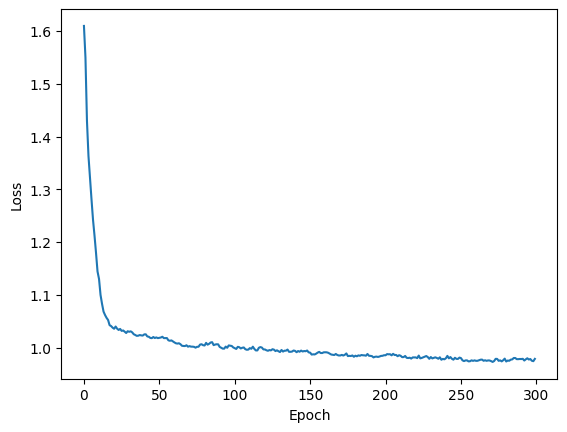

Test accuracy: 463.5978494623656
Accuracy: 0.4670967741935484
Precision: 0.5313196593540879
Recall: 0.466957571419251
F1-score: 0.48040145791574557


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       495
           1       0.44      0.53      0.48       472
           2       0.33      0.45      0.38       449
           3       0.34      0.42      0.37       463
           4       0.79      0.48      0.59       446

    accuracy                           0.47      2325
   macro avg       0.53      0.47      0.48      2325
weighted avg       0.53      0.47      0.48      2325

                    0           1           2           3           4  \
precision    0.761745    0.442857    0.330619    0.336192    0.785185   
recall       0.458586    0.525424    0.452116    0.423326    0.475336   
f1-score     0.572509    0.480620    0.381938    0.374761    0.592179   
support    495.000000  472.000000  449.000000 

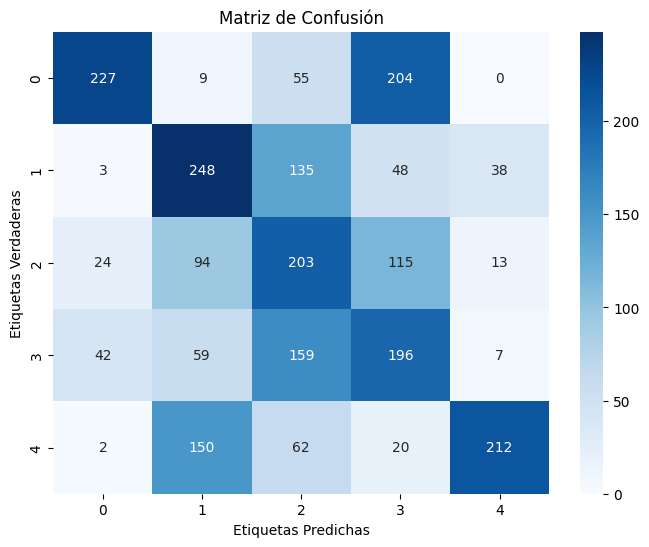

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_300_0.0001_0.3/resultados_300_0.0001_0.3.json
Procesando red con 300 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|▏                                                              | 1/300 [00:01<08:47,  1.76s/it]

1.6097122571047615


Procesando epocas:   1%|▍                                                              | 2/300 [00:03<08:47,  1.77s/it]

1.6096904523232405


Procesando epocas:   1%|▋                                                              | 3/300 [00:05<08:45,  1.77s/it]

1.6096968517583958


Procesando epocas:   1%|▊                                                              | 4/300 [00:07<08:39,  1.75s/it]

1.6096108948483188


Procesando epocas:   2%|█                                                              | 5/300 [00:08<08:29,  1.73s/it]

1.6096251368522645


Procesando epocas:   2%|█▎                                                             | 6/300 [00:10<08:23,  1.71s/it]

1.6094562411308289


Procesando epocas:   2%|█▍                                                             | 7/300 [00:12<08:19,  1.70s/it]

1.6090347535469953


Procesando epocas:   3%|█▋                                                             | 8/300 [00:13<08:15,  1.70s/it]

1.608273440248826


Procesando epocas:   3%|█▉                                                             | 9/300 [00:15<08:12,  1.69s/it]

1.6064927395652322


Procesando epocas:   3%|██                                                            | 10/300 [00:17<08:10,  1.69s/it]

1.6027831757769866


Procesando epocas:   4%|██▎                                                           | 11/300 [00:18<08:08,  1.69s/it]

1.5925714836401097


Procesando epocas:   4%|██▍                                                           | 12/300 [00:20<08:06,  1.69s/it]

1.5636903538423426


Procesando epocas:   4%|██▋                                                           | 13/300 [00:22<08:04,  1.69s/it]

1.5148390826056986


Procesando epocas:   5%|██▉                                                           | 14/300 [00:23<08:01,  1.68s/it]

1.470759812523337


Procesando epocas:   5%|███                                                           | 15/300 [00:25<08:00,  1.68s/it]

1.4456010559025934


Procesando epocas:   5%|███▎                                                          | 16/300 [00:27<07:58,  1.68s/it]

1.423219384165371


Procesando epocas:   6%|███▌                                                          | 17/300 [00:28<07:56,  1.68s/it]

1.4057560619185954


Procesando epocas:   6%|███▋                                                          | 18/300 [00:30<07:56,  1.69s/it]

1.3911028272965376


Procesando epocas:   6%|███▉                                                          | 19/300 [00:32<07:55,  1.69s/it]

1.3677610151907977


Procesando epocas:   7%|████▏                                                         | 20/300 [00:34<07:54,  1.70s/it]

1.3483797283733592


Procesando epocas:   7%|████▎                                                         | 21/300 [00:35<07:53,  1.70s/it]

1.33595150568906


Procesando epocas:   7%|████▌                                                         | 22/300 [00:37<07:51,  1.70s/it]

1.320026932744419


Procesando epocas:   8%|████▊                                                         | 23/300 [00:39<07:49,  1.69s/it]

1.3052283132777494


Procesando epocas:   8%|████▉                                                         | 24/300 [00:40<07:46,  1.69s/it]

1.2966743630521438


Procesando epocas:   8%|█████▏                                                        | 25/300 [00:42<07:43,  1.69s/it]

1.2807863684261547


Procesando epocas:   9%|█████▎                                                        | 26/300 [00:44<07:40,  1.68s/it]

1.2711439237875097


Procesando epocas:   9%|█████▌                                                        | 27/300 [00:45<07:38,  1.68s/it]

1.2607014024958891


Procesando epocas:   9%|█████▊                                                        | 28/300 [00:47<07:32,  1.66s/it]

1.2449439245111802


Procesando epocas:  10%|█████▉                                                        | 29/300 [00:49<07:28,  1.66s/it]

1.236214365678675


Procesando epocas:  10%|██████▏                                                       | 30/300 [00:50<07:26,  1.65s/it]

1.2295757006196415


Procesando epocas:  10%|██████▍                                                       | 31/300 [00:52<07:21,  1.64s/it]

1.2143541195813348


Procesando epocas:  11%|██████▌                                                       | 32/300 [00:54<07:21,  1.65s/it]

1.201289214106167


Procesando epocas:  11%|██████▊                                                       | 33/300 [00:55<07:19,  1.65s/it]

1.1942158411530888


Procesando epocas:  11%|███████                                                       | 34/300 [00:57<07:18,  1.65s/it]

1.181944172522601


Procesando epocas:  12%|███████▏                                                      | 35/300 [00:58<07:17,  1.65s/it]

1.1696582268266116


Procesando epocas:  12%|███████▍                                                      | 36/300 [01:00<07:17,  1.66s/it]

1.166949334565331


Procesando epocas:  12%|███████▋                                                      | 37/300 [01:02<07:15,  1.66s/it]

1.1522949148626889


Procesando epocas:  13%|███████▊                                                      | 38/300 [01:03<07:14,  1.66s/it]

1.147024728971369


Procesando epocas:  13%|████████                                                      | 39/300 [01:05<07:13,  1.66s/it]

1.1313510067322674


Procesando epocas:  13%|████████▎                                                     | 40/300 [01:07<07:16,  1.68s/it]

1.125364905946395


Procesando epocas:  14%|████████▍                                                     | 41/300 [01:09<07:17,  1.69s/it]

1.1141401115585776


Procesando epocas:  14%|████████▋                                                     | 42/300 [01:10<07:18,  1.70s/it]

1.1116828841321609


Procesando epocas:  14%|████████▉                                                     | 43/300 [01:12<07:16,  1.70s/it]

1.100262496401282


Procesando epocas:  15%|█████████                                                     | 44/300 [01:14<07:15,  1.70s/it]

1.091109982658835


Procesando epocas:  15%|█████████▎                                                    | 45/300 [01:15<07:13,  1.70s/it]

1.086134450225269


Procesando epocas:  15%|█████████▌                                                    | 46/300 [01:17<07:10,  1.69s/it]

1.0792374880874858


Procesando epocas:  16%|█████████▋                                                    | 47/300 [01:19<07:07,  1.69s/it]

1.07032613158226


Procesando epocas:  16%|█████████▉                                                    | 48/300 [01:20<07:06,  1.69s/it]

1.065503259967355


Procesando epocas:  16%|██████████▏                                                   | 49/300 [01:22<07:03,  1.69s/it]

1.0579106527216293


Procesando epocas:  17%|██████████▎                                                   | 50/300 [01:24<07:00,  1.68s/it]

1.057080322153428


Procesando epocas:  17%|██████████▌                                                   | 51/300 [01:25<06:58,  1.68s/it]

1.0476478485500111


Procesando epocas:  17%|██████████▋                                                   | 52/300 [01:27<06:56,  1.68s/it]

1.043137432196561


Procesando epocas:  18%|██████████▉                                                   | 53/300 [01:29<06:54,  1.68s/it]

1.0353918278918546


Procesando epocas:  18%|███████████▏                                                  | 54/300 [01:30<06:52,  1.68s/it]

1.0327035188674927


Procesando epocas:  18%|███████████▎                                                  | 55/300 [01:32<06:50,  1.68s/it]

1.028218570176293


Procesando epocas:  19%|███████████▌                                                  | 56/300 [01:34<06:48,  1.68s/it]

1.0267228336895213


Procesando epocas:  19%|███████████▊                                                  | 57/300 [01:36<06:48,  1.68s/it]

1.021578095590367


Procesando epocas:  19%|███████████▉                                                  | 58/300 [01:37<06:46,  1.68s/it]

1.015575037984287


Procesando epocas:  20%|████████████▏                                                 | 59/300 [01:39<06:44,  1.68s/it]

1.0115032444981968


Procesando epocas:  20%|████████████▍                                                 | 60/300 [01:41<06:42,  1.68s/it]

1.0071343344800612


Procesando epocas:  20%|████████████▌                                                 | 61/300 [01:42<06:39,  1.67s/it]

1.0074524157187519


Procesando epocas:  21%|████████████▊                                                 | 62/300 [01:44<06:38,  1.67s/it]

1.0045485822593465


Procesando epocas:  21%|█████████████                                                 | 63/300 [01:46<06:36,  1.67s/it]

1.0006890370565302


Procesando epocas:  21%|█████████████▏                                                | 64/300 [01:47<06:34,  1.67s/it]

0.9989576546584858


Procesando epocas:  22%|█████████████▍                                                | 65/300 [01:49<06:33,  1.67s/it]

0.994673877253252


Procesando epocas:  22%|█████████████▋                                                | 66/300 [01:51<06:31,  1.67s/it]

0.9926524551475749


Procesando epocas:  22%|█████████████▊                                                | 67/300 [01:52<06:29,  1.67s/it]

0.9900613690123838


Procesando epocas:  23%|██████████████                                                | 68/300 [01:54<06:27,  1.67s/it]

0.9874743345905753


Procesando epocas:  23%|██████████████▎                                               | 69/300 [01:56<06:25,  1.67s/it]

0.9855981167624979


Procesando epocas:  23%|██████████████▍                                               | 70/300 [01:57<06:24,  1.67s/it]

0.98119757140384


Procesando epocas:  24%|██████████████▋                                               | 71/300 [01:59<06:22,  1.67s/it]

0.9818628493477316


Procesando epocas:  24%|██████████████▉                                               | 72/300 [02:01<06:20,  1.67s/it]

0.9792905849568984


Procesando epocas:  24%|███████████████                                               | 73/300 [02:02<06:18,  1.67s/it]

0.9789161149193258


Procesando epocas:  25%|███████████████▎                                              | 74/300 [02:04<06:17,  1.67s/it]

0.9771751750917995


Procesando epocas:  25%|███████████████▌                                              | 75/300 [02:06<06:15,  1.67s/it]

0.9750325364225051


Procesando epocas:  25%|███████████████▋                                              | 76/300 [02:07<06:14,  1.67s/it]

0.9736708753249225


Procesando epocas:  26%|███████████████▉                                              | 77/300 [02:09<06:12,  1.67s/it]

0.9724271658588858


Procesando epocas:  26%|████████████████                                              | 78/300 [02:11<06:10,  1.67s/it]

0.970001260322683


Procesando epocas:  26%|████████████████▎                                             | 79/300 [02:12<06:08,  1.67s/it]

0.9684574828428381


Procesando epocas:  27%|████████████████▌                                             | 80/300 [02:14<06:08,  1.67s/it]

0.9691910400110133


Procesando epocas:  27%|████████████████▋                                             | 81/300 [02:16<06:05,  1.67s/it]

0.9661083018078523


Procesando epocas:  27%|████████████████▉                                             | 82/300 [02:17<06:03,  1.67s/it]

0.9652648796053493


Procesando epocas:  28%|█████████████████▏                                            | 83/300 [02:19<06:02,  1.67s/it]

0.9637983055675731


Procesando epocas:  28%|█████████████████▎                                            | 84/300 [02:21<05:59,  1.67s/it]

0.9603047837229336


Procesando epocas:  28%|█████████████████▌                                            | 85/300 [02:22<05:57,  1.66s/it]

0.9630506031653461


Procesando epocas:  29%|█████████████████▊                                            | 86/300 [02:24<05:59,  1.68s/it]

0.9605847390259014


Procesando epocas:  29%|█████████████████▉                                            | 87/300 [02:26<06:03,  1.71s/it]

0.9586030676084406


Procesando epocas:  29%|██████████████████▏                                           | 88/300 [02:28<06:05,  1.72s/it]

0.9602922706043019


Procesando epocas:  30%|██████████████████▍                                           | 89/300 [02:29<06:06,  1.74s/it]

0.958052914984086


Procesando epocas:  30%|██████████████████▌                                           | 90/300 [02:31<06:06,  1.74s/it]

0.9594400206032921


Procesando epocas:  30%|██████████████████▊                                           | 91/300 [02:33<06:06,  1.75s/it]

0.9565691990010878


Procesando epocas:  31%|███████████████████                                           | 92/300 [02:35<06:04,  1.75s/it]

0.9579114384510938


Procesando epocas:  31%|███████████████████▏                                          | 93/300 [02:36<06:03,  1.75s/it]

0.9574340073501363


Procesando epocas:  31%|███████████████████▍                                          | 94/300 [02:38<06:01,  1.76s/it]

0.9541524764369516


Procesando epocas:  32%|███████████████████▋                                          | 95/300 [02:40<06:00,  1.76s/it]

0.9558999037041384


Procesando epocas:  32%|███████████████████▊                                          | 96/300 [02:42<05:59,  1.76s/it]

0.9548426803420572


Procesando epocas:  32%|████████████████████                                          | 97/300 [02:43<05:57,  1.76s/it]

0.953785475211985


Procesando epocas:  33%|████████████████████▎                                         | 98/300 [02:45<05:56,  1.76s/it]

0.9525918171686285


Procesando epocas:  33%|████████████████████▍                                         | 99/300 [02:47<05:54,  1.76s/it]

0.9515784021686106


Procesando epocas:  33%|████████████████████▎                                        | 100/300 [02:49<05:52,  1.76s/it]

0.9513948044356177


Procesando epocas:  34%|████████████████████▌                                        | 101/300 [02:50<05:51,  1.77s/it]

0.9501724313287174


Procesando epocas:  34%|████████████████████▋                                        | 102/300 [02:52<05:49,  1.77s/it]

0.9510665185311261


Procesando epocas:  34%|████████████████████▉                                        | 103/300 [02:54<05:47,  1.77s/it]

0.9492987927268534


Procesando epocas:  35%|█████████████████████▏                                       | 104/300 [02:56<05:46,  1.77s/it]

0.9481325079413021


Procesando epocas:  35%|█████████████████████▎                                       | 105/300 [02:58<05:43,  1.76s/it]

0.9491858517422396


Procesando epocas:  35%|█████████████████████▌                                       | 106/300 [02:59<05:42,  1.77s/it]

0.9483582075904398


Procesando epocas:  36%|█████████████████████▊                                       | 107/300 [03:01<05:41,  1.77s/it]

0.9484835463411668


Procesando epocas:  36%|█████████████████████▉                                       | 108/300 [03:03<05:39,  1.77s/it]

0.9467717479257023


Procesando epocas:  36%|██████████████████████▏                                      | 109/300 [03:05<05:38,  1.77s/it]

0.9480337325264426


Procesando epocas:  37%|██████████████████████▎                                      | 110/300 [03:06<05:36,  1.77s/it]

0.9466982287519118


Procesando epocas:  37%|██████████████████████▌                                      | 111/300 [03:08<05:33,  1.77s/it]

0.9475055750678567


Procesando epocas:  37%|██████████████████████▊                                      | 112/300 [03:10<05:29,  1.75s/it]

0.9489720018470988


Procesando epocas:  38%|██████████████████████▉                                      | 113/300 [03:12<05:24,  1.73s/it]

0.9466660513597376


Procesando epocas:  38%|███████████████████████▏                                     | 114/300 [03:13<05:20,  1.72s/it]

0.9453994344262516


Procesando epocas:  38%|███████████████████████▍                                     | 115/300 [03:15<05:18,  1.72s/it]

0.9453152765245999


Procesando epocas:  39%|███████████████████████▌                                     | 116/300 [03:17<05:15,  1.71s/it]

0.9459616583936354


Procesando epocas:  39%|███████████████████████▊                                     | 117/300 [03:18<05:14,  1.72s/it]

0.9450522685752195


Procesando epocas:  39%|███████████████████████▉                                     | 118/300 [03:20<05:11,  1.71s/it]

0.945413534080281


Procesando epocas:  40%|████████████████████████▏                                    | 119/300 [03:22<05:08,  1.71s/it]

0.9461482458254871


Procesando epocas:  40%|████████████████████████▍                                    | 120/300 [03:23<05:06,  1.70s/it]

0.9446849030606886


Procesando epocas:  40%|████████████████████████▌                                    | 121/300 [03:25<05:04,  1.70s/it]

0.9449670623330509


Procesando epocas:  41%|████████████████████████▊                                    | 122/300 [03:27<05:02,  1.70s/it]

0.9455397062441881


Procesando epocas:  41%|█████████████████████████                                    | 123/300 [03:29<05:01,  1.70s/it]

0.9446571641108569


Procesando epocas:  41%|█████████████████████████▏                                   | 124/300 [03:30<05:01,  1.71s/it]

0.9455297827720642


Procesando epocas:  42%|█████████████████████████▍                                   | 125/300 [03:32<04:59,  1.71s/it]

0.9443015820839826


Procesando epocas:  42%|█████████████████████████▌                                   | 126/300 [03:34<04:58,  1.72s/it]

0.944516866347369


Procesando epocas:  42%|█████████████████████████▊                                   | 127/300 [03:35<04:55,  1.71s/it]

0.9429681322153877


Procesando epocas:  43%|██████████████████████████                                   | 128/300 [03:37<04:52,  1.70s/it]

0.9432399591978858


Procesando epocas:  43%|██████████████████████████▏                                  | 129/300 [03:39<04:50,  1.70s/it]

0.9434697589453529


Procesando epocas:  43%|██████████████████████████▍                                  | 130/300 [03:40<04:47,  1.69s/it]

0.9436523483080023


Procesando epocas:  44%|██████████████████████████▋                                  | 131/300 [03:42<04:46,  1.69s/it]

0.9421023144441493


Procesando epocas:  44%|██████████████████████████▊                                  | 132/300 [03:44<04:44,  1.69s/it]

0.9423776812413159


Procesando epocas:  44%|███████████████████████████                                  | 133/300 [03:46<04:42,  1.69s/it]

0.9424869165701024


Procesando epocas:  45%|███████████████████████████▏                                 | 134/300 [03:47<04:40,  1.69s/it]

0.9430009943597457


Procesando epocas:  45%|███████████████████████████▍                                 | 135/300 [03:49<04:38,  1.69s/it]

0.9419764259282281


Procesando epocas:  45%|███████████████████████████▋                                 | 136/300 [03:51<04:35,  1.68s/it]

0.9431939198690302


Procesando epocas:  46%|███████████████████████████▊                                 | 137/300 [03:52<04:32,  1.67s/it]

0.942130187329124


Procesando epocas:  46%|████████████████████████████                                 | 138/300 [03:54<04:30,  1.67s/it]

0.9416065840160146


Procesando epocas:  46%|████████████████████████████▎                                | 139/300 [03:56<04:27,  1.66s/it]

0.9420210301876069


Procesando epocas:  47%|████████████████████████████▍                                | 140/300 [03:57<04:25,  1.66s/it]

0.9425160390489241


Procesando epocas:  47%|████████████████████████████▋                                | 141/300 [03:59<04:23,  1.66s/it]

0.9420767079381381


Procesando epocas:  47%|████████████████████████████▊                                | 142/300 [04:01<04:20,  1.65s/it]

0.9413834613912245


Procesando epocas:  48%|█████████████████████████████                                | 143/300 [04:02<04:19,  1.65s/it]

0.941416063378839


Procesando epocas:  48%|█████████████████████████████▎                               | 144/300 [04:04<04:17,  1.65s/it]

0.9413500908543082


Procesando epocas:  48%|█████████████████████████████▍                               | 145/300 [04:05<04:15,  1.65s/it]

0.9407783515313093


Procesando epocas:  49%|█████████████████████████████▋                               | 146/300 [04:07<04:13,  1.65s/it]

0.9411133980049806


Procesando epocas:  49%|█████████████████████████████▉                               | 147/300 [04:09<04:12,  1.65s/it]

0.9412110619685229


Procesando epocas:  49%|██████████████████████████████                               | 148/300 [04:10<04:10,  1.65s/it]

0.94011930122095


Procesando epocas:  50%|██████████████████████████████▎                              | 149/300 [04:12<04:09,  1.65s/it]

0.9390407954945283


Procesando epocas:  50%|██████████████████████████████▌                              | 150/300 [04:14<04:07,  1.65s/it]

0.9396718908758724


Procesando epocas:  50%|██████████████████████████████▋                              | 151/300 [04:15<04:07,  1.66s/it]

0.9391847845386057


Procesando epocas:  51%|██████████████████████████████▉                              | 152/300 [04:17<04:06,  1.66s/it]

0.9397602379322052


Procesando epocas:  51%|███████████████████████████████                              | 153/300 [04:19<04:04,  1.66s/it]

0.9399781924836775


Procesando epocas:  51%|███████████████████████████████▎                             | 154/300 [04:20<04:02,  1.66s/it]

0.9389234921511482


Procesando epocas:  52%|███████████████████████████████▌                             | 155/300 [04:22<04:00,  1.66s/it]

0.9384342996513142


Procesando epocas:  52%|███████████████████████████████▋                             | 156/300 [04:24<03:59,  1.66s/it]

0.939078526987749


Procesando epocas:  52%|███████████████████████████████▉                             | 157/300 [04:25<03:57,  1.66s/it]

0.9385244330939124


Procesando epocas:  53%|████████████████████████████████▏                            | 158/300 [04:27<03:56,  1.66s/it]

0.93776935338974


Procesando epocas:  53%|████████████████████████████████▎                            | 159/300 [04:29<03:54,  1.66s/it]

0.9383782789987676


Procesando epocas:  53%|████████████████████████████████▌                            | 160/300 [04:30<03:53,  1.67s/it]

0.9371103689951055


Procesando epocas:  54%|████████████████████████████████▋                            | 161/300 [04:32<03:51,  1.66s/it]

0.9390038332518409


Procesando epocas:  54%|████████████████████████████████▉                            | 162/300 [04:34<03:49,  1.66s/it]

0.9390701062539044


Procesando epocas:  54%|█████████████████████████████████▏                           | 163/300 [04:35<03:47,  1.66s/it]

0.9380132303518407


Procesando epocas:  55%|█████████████████████████████████▎                           | 164/300 [04:37<03:46,  1.66s/it]

0.9381063724265379


Procesando epocas:  55%|█████████████████████████████████▌                           | 165/300 [04:39<03:44,  1.66s/it]

0.936768206428079


Procesando epocas:  55%|█████████████████████████████████▊                           | 166/300 [04:40<03:42,  1.66s/it]

0.9376944717238931


Procesando epocas:  56%|█████████████████████████████████▉                           | 167/300 [04:42<03:40,  1.66s/it]

0.9376714723951677


Procesando epocas:  56%|██████████████████████████████████▏                          | 168/300 [04:44<03:38,  1.66s/it]

0.9374676066286424


Procesando epocas:  56%|██████████████████████████████████▎                          | 169/300 [04:45<03:37,  1.66s/it]

0.937092476381975


Procesando epocas:  57%|██████████████████████████████████▌                          | 170/300 [04:47<03:35,  1.66s/it]

0.9371938112904044


Procesando epocas:  57%|██████████████████████████████████▊                          | 171/300 [04:49<03:33,  1.66s/it]

0.9375258221345789


Procesando epocas:  57%|██████████████████████████████████▉                          | 172/300 [04:50<03:31,  1.66s/it]

0.9366141399916481


Procesando epocas:  58%|███████████████████████████████████▏                         | 173/300 [04:52<03:29,  1.65s/it]

0.937546077896567


Procesando epocas:  58%|███████████████████████████████████▍                         | 174/300 [04:54<03:28,  1.65s/it]

0.937737668612424


Procesando epocas:  58%|███████████████████████████████████▌                         | 175/300 [04:55<03:26,  1.66s/it]

0.9373271356610691


Procesando epocas:  59%|███████████████████████████████████▊                         | 176/300 [04:57<03:25,  1.65s/it]

0.9368495748323553


Procesando epocas:  59%|███████████████████████████████████▉                         | 177/300 [04:59<03:23,  1.65s/it]

0.9373788987889009


Procesando epocas:  59%|████████████████████████████████████▏                        | 178/300 [05:00<03:21,  1.65s/it]

0.9371165247524486


Procesando epocas:  60%|████████████████████████████████████▍                        | 179/300 [05:02<03:19,  1.65s/it]

0.9368172480779535


Procesando epocas:  60%|████████████████████████████████████▌                        | 180/300 [05:03<03:18,  1.65s/it]

0.93756622987635


Procesando epocas:  60%|████████████████████████████████████▊                        | 181/300 [05:05<03:16,  1.65s/it]

0.9372941371272592


Procesando epocas:  61%|█████████████████████████████████████                        | 182/300 [05:07<03:15,  1.66s/it]

0.93691967866


Procesando epocas:  61%|█████████████████████████████████████▏                       | 183/300 [05:08<03:13,  1.65s/it]

0.9377882473609027


Procesando epocas:  61%|█████████████████████████████████████▍                       | 184/300 [05:10<03:11,  1.65s/it]

0.9367919634370243


Procesando epocas:  62%|█████████████████████████████████████▌                       | 185/300 [05:12<03:10,  1.65s/it]

0.9373060219428119


Procesando epocas:  62%|█████████████████████████████████████▊                       | 186/300 [05:13<03:08,  1.66s/it]

0.9360863327980041


Procesando epocas:  62%|██████████████████████████████████████                       | 187/300 [05:15<03:07,  1.66s/it]

0.9367526205147014


Procesando epocas:  63%|██████████████████████████████████████▏                      | 188/300 [05:17<03:06,  1.66s/it]

0.9361993425032672


Procesando epocas:  63%|██████████████████████████████████████▍                      | 189/300 [05:18<03:04,  1.66s/it]

0.9369857447988846


Procesando epocas:  63%|██████████████████████████████████████▋                      | 190/300 [05:20<03:03,  1.67s/it]

0.9368966127143187


Procesando epocas:  64%|██████████████████████████████████████▊                      | 191/300 [05:22<03:02,  1.67s/it]

0.9366994991021997


Procesando epocas:  64%|███████████████████████████████████████                      | 192/300 [05:23<02:59,  1.67s/it]

0.9371238939902362


Procesando epocas:  64%|███████████████████████████████████████▏                     | 193/300 [05:25<02:59,  1.68s/it]

0.93642098272548


Procesando epocas:  65%|███████████████████████████████████████▍                     | 194/300 [05:27<02:58,  1.68s/it]

0.9363283651716569


Procesando epocas:  65%|███████████████████████████████████████▋                     | 195/300 [05:29<02:59,  1.71s/it]

0.9363507312886855


Procesando epocas:  65%|███████████████████████████████████████▊                     | 196/300 [05:30<03:00,  1.73s/it]

0.936710640262155


Procesando epocas:  66%|████████████████████████████████████████                     | 197/300 [05:32<03:00,  1.75s/it]

0.9360702686450061


Procesando epocas:  66%|████████████████████████████████████████▎                    | 198/300 [05:34<02:58,  1.75s/it]

0.93571257240632


Procesando epocas:  66%|████████████████████████████████████████▍                    | 199/300 [05:36<02:57,  1.76s/it]

0.9361409892054166


Procesando epocas:  67%|████████████████████████████████████████▋                    | 200/300 [05:37<02:55,  1.76s/it]

0.9358264362110811


Procesando epocas:  67%|████████████████████████████████████████▊                    | 201/300 [05:39<02:54,  1.76s/it]

0.9360063461696401


Procesando epocas:  67%|█████████████████████████████████████████                    | 202/300 [05:41<02:52,  1.76s/it]

0.9355289936065674


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 203/300 [05:43<02:49,  1.75s/it]

0.936016592909308


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 204/300 [05:45<02:51,  1.78s/it]

0.9353191189906176


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 205/300 [05:46<02:48,  1.78s/it]

0.9355232193189509


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 206/300 [05:48<02:46,  1.77s/it]

0.9358042219105889


Procesando epocas:  69%|██████████████████████████████████████████                   | 207/300 [05:50<02:43,  1.76s/it]

0.9355427605264327


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 208/300 [05:52<02:41,  1.76s/it]

0.9359247733564938


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 209/300 [05:53<02:39,  1.75s/it]

0.9355458038694718


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 210/300 [05:55<02:37,  1.75s/it]

0.9350819836644565


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 211/300 [05:57<02:35,  1.74s/it]

0.9349623606485479


Procesando epocas:  71%|███████████████████████████████████████████                  | 212/300 [05:59<02:34,  1.75s/it]

0.9349273236358867


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 213/300 [06:00<02:32,  1.75s/it]

0.9355510876459234


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 214/300 [06:02<02:30,  1.75s/it]

0.935026691941654


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 215/300 [06:04<02:28,  1.75s/it]

0.9348138500662411


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 216/300 [06:06<02:27,  1.76s/it]

0.9347188900498783


Procesando epocas:  72%|████████████████████████████████████████████                 | 217/300 [06:07<02:25,  1.76s/it]

0.9348604265381308


Procesando epocas:  73%|████████████████████████████████████████████▎                | 218/300 [06:09<02:23,  1.75s/it]

0.9348974753828609


Procesando epocas:  73%|████████████████████████████████████████████▌                | 219/300 [06:11<02:21,  1.75s/it]

0.9348098120268653


Procesando epocas:  73%|████████████████████████████████████████████▋                | 220/300 [06:13<02:21,  1.76s/it]

0.9346434526583728


Procesando epocas:  74%|████████████████████████████████████████████▉                | 221/300 [06:14<02:17,  1.74s/it]

0.935306551175959


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 222/300 [06:16<02:13,  1.72s/it]

0.9347425390692318


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 223/300 [06:18<02:11,  1.70s/it]

0.9344616539338055


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 224/300 [06:19<02:08,  1.69s/it]

0.9349866712794584


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 225/300 [06:21<02:06,  1.69s/it]

0.934414132903604


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 226/300 [06:23<02:04,  1.69s/it]

0.9344607840566074


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 227/300 [06:24<02:03,  1.69s/it]

0.9344452935106614


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 228/300 [06:26<02:01,  1.68s/it]

0.9349138021469117


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 229/300 [06:28<01:58,  1.68s/it]

0.9340471604291131


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 230/300 [06:29<01:56,  1.67s/it]

0.9345317030654234


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 231/300 [06:31<01:55,  1.67s/it]

0.9349448796580819


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 232/300 [06:33<01:53,  1.66s/it]

0.9338951973354115


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 233/300 [06:34<01:51,  1.66s/it]

0.9338897024883943


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 234/300 [06:36<01:50,  1.67s/it]

0.9344967933262096


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 235/300 [06:38<01:48,  1.67s/it]

0.9335918394958271


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 236/300 [06:39<01:46,  1.67s/it]

0.9338985758669236


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 237/300 [06:41<01:45,  1.67s/it]

0.9343725982834311


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 238/300 [06:43<01:44,  1.68s/it]

0.9348120086333331


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 239/300 [06:44<01:42,  1.68s/it]

0.9341264114660375


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 240/300 [06:46<01:40,  1.67s/it]

0.9344275386894451


Procesando epocas:  80%|█████████████████████████████████████████████████            | 241/300 [06:48<01:38,  1.67s/it]

0.934078381692662


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 242/300 [06:49<01:37,  1.67s/it]

0.9343147965038524


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 243/300 [06:51<01:35,  1.67s/it]

0.9342952360125149


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 244/300 [06:53<01:33,  1.67s/it]

0.9347567281302284


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 245/300 [06:54<01:31,  1.67s/it]

0.9337273492532618


Procesando epocas:  82%|██████████████████████████████████████████████████           | 246/300 [06:56<01:29,  1.66s/it]

0.9334028187920066


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 247/300 [06:58<01:28,  1.66s/it]

0.9330867227386026


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 248/300 [06:59<01:26,  1.66s/it]

0.9337180603952969


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 249/300 [07:01<01:23,  1.65s/it]

0.9336168874712552


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 250/300 [07:03<01:21,  1.64s/it]

0.9334993790177738


Procesando epocas:  84%|███████████████████████████████████████████████████          | 251/300 [07:04<01:20,  1.63s/it]

0.9327134426902323


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 252/300 [07:06<01:18,  1.63s/it]

0.9334512749139


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 253/300 [07:07<01:16,  1.63s/it]

0.9330747053903692


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 254/300 [07:09<01:15,  1.63s/it]

0.9329908837290372


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 255/300 [07:11<01:13,  1.63s/it]

0.9333500202964334


Procesando epocas:  85%|████████████████████████████████████████████████████         | 256/300 [07:12<01:11,  1.63s/it]

0.9334205083987293


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 257/300 [07:14<01:09,  1.63s/it]

0.9333286292412701


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 258/300 [07:16<01:08,  1.62s/it]

0.933136398301405


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 259/300 [07:17<01:06,  1.62s/it]

0.933661592357299


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 260/300 [07:19<01:04,  1.62s/it]

0.9333612287745756


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 261/300 [07:20<01:03,  1.62s/it]

0.9329779831802144


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 262/300 [07:22<01:01,  1.62s/it]

0.9329600046662724


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 263/300 [07:24<01:00,  1.62s/it]

0.9331549805753371


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 264/300 [07:25<00:58,  1.63s/it]

0.9336657678379732


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 265/300 [07:27<00:57,  1.64s/it]

0.9332886005149168


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 266/300 [07:29<00:55,  1.65s/it]

0.9329297279610353


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 267/300 [07:30<00:54,  1.65s/it]

0.9326716714045581


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 268/300 [07:32<00:52,  1.65s/it]

0.9332492414642782


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 269/300 [07:34<00:51,  1.65s/it]

0.9325561207883498


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 270/300 [07:35<00:49,  1.64s/it]

0.9326387465000152


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 271/300 [07:37<00:47,  1.63s/it]

0.9331152579363655


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 272/300 [07:38<00:45,  1.63s/it]

0.932628251173917


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 273/300 [07:40<00:43,  1.63s/it]

0.9326747084365171


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 274/300 [07:42<00:42,  1.63s/it]

0.9322729208890129


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 275/300 [07:43<00:40,  1.63s/it]

0.9323137441102196


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 276/300 [07:45<00:39,  1.63s/it]

0.9320862174034119


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 277/300 [07:47<00:37,  1.63s/it]

0.9334086498793434


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 278/300 [07:48<00:36,  1.64s/it]

0.9325681865215302


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 279/300 [07:50<00:34,  1.64s/it]

0.9325462979428908


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 280/300 [07:52<00:32,  1.65s/it]

0.932117074026781


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 281/300 [07:53<00:31,  1.65s/it]

0.932397695499308


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 282/300 [07:55<00:29,  1.65s/it]

0.9326035464511199


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 283/300 [07:56<00:27,  1.64s/it]

0.9324413601089926


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 284/300 [07:58<00:26,  1.63s/it]

0.9320949754294228


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 285/300 [08:00<00:24,  1.63s/it]

0.9325607717037201


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 286/300 [08:01<00:22,  1.62s/it]

0.9323355814989875


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 287/300 [08:03<00:21,  1.62s/it]

0.9323770137394176


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 288/300 [08:05<00:19,  1.62s/it]

0.9326050512930926


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 289/300 [08:06<00:17,  1.62s/it]

0.9324969877214992


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 290/300 [08:08<00:16,  1.62s/it]

0.9325455483268289


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 291/300 [08:09<00:14,  1.62s/it]

0.9320994051063762


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 292/300 [08:11<00:12,  1.62s/it]

0.9322081432623022


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 293/300 [08:13<00:11,  1.62s/it]

0.9319166162434747


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 294/300 [08:14<00:09,  1.62s/it]

0.9320233022465425


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 295/300 [08:16<00:08,  1.63s/it]

0.9319969373590806


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 296/300 [08:18<00:06,  1.64s/it]

0.9316954886212069


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 297/300 [08:19<00:04,  1.63s/it]

0.9327674529131721


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 298/300 [08:21<00:03,  1.63s/it]

0.9315441320924198


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 299/300 [08:22<00:01,  1.63s/it]

0.9314767886610592


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 300/300 [08:24<00:00,  1.68s/it]

0.9317030566580156
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_300_1e-05_0.3/funcion_de_perdida_300_1e-05.png


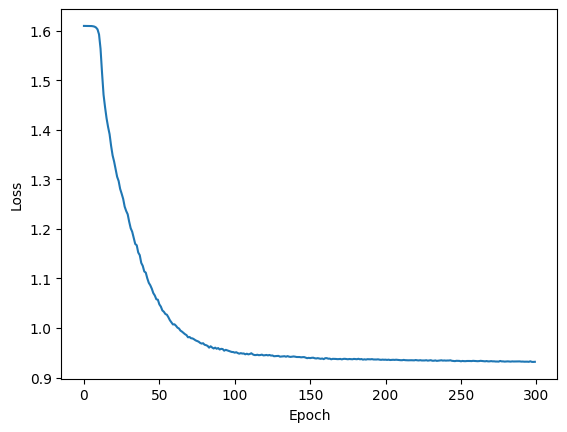

Test accuracy: 467.5372043010753
Accuracy: 0.4997849462365591
Precision: 0.49371380550173666
Recall: 0.49786212752836045
F1-score: 0.4935646863824966


Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.67      0.61       495
           1       0.45      0.48      0.47       472
           2       0.47      0.37      0.42       449
           3       0.33      0.31      0.32       463
           4       0.64      0.65      0.65       446

    accuracy                           0.50      2325
   macro avg       0.49      0.50      0.49      2325
weighted avg       0.49      0.50      0.49      2325

                    0           1           2           3           4  \
precision    0.566327    0.454545    0.473239    0.334107    0.640351   
recall       0.672727    0.476695    0.374165    0.311015    0.654709   
f1-score     0.614958    0.465357    0.417910    0.322148    0.647450   
support    495.000000  472.000000  449.00000

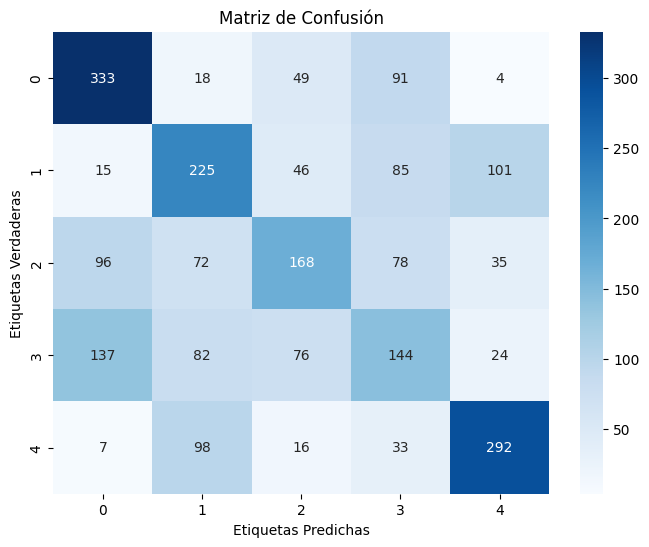

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_300_1e-05_0.3/resultados_300_1e-05_0.3.json
Procesando red con 500 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|▏                                                              | 1/500 [00:01<13:53,  1.67s/it]

1.60900997764924


Procesando epocas:   0%|▎                                                              | 2/500 [00:03<13:35,  1.64s/it]

1.5181042804437526


Procesando epocas:   1%|▍                                                              | 3/500 [00:04<13:32,  1.63s/it]

1.406705409639022


Procesando epocas:   1%|▌                                                              | 4/500 [00:06<13:49,  1.67s/it]

1.3375346590490902


Procesando epocas:   1%|▋                                                              | 5/500 [00:08<13:58,  1.69s/it]

1.2938113801619586


Procesando epocas:   1%|▊                                                              | 6/500 [00:10<14:02,  1.71s/it]

1.2551848902421838


Procesando epocas:   1%|▉                                                              | 7/500 [00:11<14:06,  1.72s/it]

1.2256361533613767


Procesando epocas:   2%|█                                                              | 8/500 [00:13<14:07,  1.72s/it]

1.2073823778068318


Procesando epocas:   2%|█▏                                                             | 9/500 [00:15<14:07,  1.73s/it]

1.194659577397739


Procesando epocas:   2%|█▏                                                            | 10/500 [00:17<14:06,  1.73s/it]

1.1847747399526485


Procesando epocas:   2%|█▎                                                            | 11/500 [00:18<14:06,  1.73s/it]

1.181539456984576


Procesando epocas:   2%|█▍                                                            | 12/500 [00:20<14:04,  1.73s/it]

1.1734151735025293


Procesando epocas:   3%|█▌                                                            | 13/500 [00:22<14:05,  1.74s/it]

1.1715790292795967


Procesando epocas:   3%|█▋                                                            | 14/500 [00:23<14:02,  1.73s/it]

1.1691745463539571


Procesando epocas:   3%|█▊                                                            | 15/500 [00:25<13:59,  1.73s/it]

1.1620568233377793


Procesando epocas:   3%|█▉                                                            | 16/500 [00:27<13:59,  1.73s/it]

1.1492778820150038


Procesando epocas:   3%|██                                                            | 17/500 [00:29<13:56,  1.73s/it]

1.1511624069774853


Procesando epocas:   4%|██▏                                                           | 18/500 [00:30<13:55,  1.73s/it]

1.1394024564939387


Procesando epocas:   4%|██▎                                                           | 19/500 [00:32<13:55,  1.74s/it]

1.1216062244246987


Procesando epocas:   4%|██▍                                                           | 20/500 [00:34<13:52,  1.73s/it]

1.1104093222057119


Procesando epocas:   4%|██▌                                                           | 21/500 [00:36<13:51,  1.74s/it]

1.1000114710891948


Procesando epocas:   4%|██▋                                                           | 22/500 [00:37<13:49,  1.74s/it]

1.094450935195474


Procesando epocas:   5%|██▊                                                           | 23/500 [00:39<13:48,  1.74s/it]

1.0841666624826543


Procesando epocas:   5%|██▉                                                           | 24/500 [00:41<13:51,  1.75s/it]

1.078291167932398


Procesando epocas:   5%|███                                                           | 25/500 [00:43<13:49,  1.75s/it]

1.0744007696123685


Procesando epocas:   5%|███▏                                                          | 26/500 [00:44<13:44,  1.74s/it]

1.0643136739730834


Procesando epocas:   5%|███▎                                                          | 27/500 [00:46<13:41,  1.74s/it]

1.0604802969624014


Procesando epocas:   6%|███▍                                                          | 28/500 [00:48<13:40,  1.74s/it]

1.0583256623324226


Procesando epocas:   6%|███▌                                                          | 29/500 [00:50<13:38,  1.74s/it]

1.058625941767412


Procesando epocas:   6%|███▋                                                          | 30/500 [00:51<13:27,  1.72s/it]

1.0560772366383497


Procesando epocas:   6%|███▊                                                          | 31/500 [00:53<13:19,  1.70s/it]

1.055522147697561


Procesando epocas:   6%|███▉                                                          | 32/500 [00:55<13:10,  1.69s/it]

1.0499488760443294


Procesando epocas:   7%|████                                                          | 33/500 [00:56<13:05,  1.68s/it]

1.050623378683539


Procesando epocas:   7%|████▏                                                         | 34/500 [00:58<13:01,  1.68s/it]

1.0529129091431113


Procesando epocas:   7%|████▎                                                         | 35/500 [01:00<12:57,  1.67s/it]

1.0522652934579289


Procesando epocas:   7%|████▍                                                         | 36/500 [01:01<12:54,  1.67s/it]

1.0514874896582436


Procesando epocas:   7%|████▌                                                         | 37/500 [01:03<12:53,  1.67s/it]

1.049364350122564


Procesando epocas:   8%|████▋                                                         | 38/500 [01:05<12:55,  1.68s/it]

1.053363708187552


Procesando epocas:   8%|████▊                                                         | 39/500 [01:06<12:54,  1.68s/it]

1.0506529345231899


Procesando epocas:   8%|████▉                                                         | 40/500 [01:08<12:56,  1.69s/it]

1.050824713005739


Procesando epocas:   8%|█████                                                         | 41/500 [01:10<13:23,  1.75s/it]

1.050124817385393


Procesando epocas:   8%|█████▏                                                        | 42/500 [01:12<13:29,  1.77s/it]

1.0469148842727436


Procesando epocas:   9%|█████▎                                                        | 43/500 [01:14<13:36,  1.79s/it]

1.0454780066714566


Procesando epocas:   9%|█████▍                                                        | 44/500 [01:15<13:20,  1.76s/it]

1.0376673810622272


Procesando epocas:   9%|█████▌                                                        | 45/500 [01:17<13:13,  1.74s/it]

1.0417254938798792


Procesando epocas:   9%|█████▋                                                        | 46/500 [01:19<13:18,  1.76s/it]

1.044593212183784


Procesando epocas:   9%|█████▊                                                        | 47/500 [01:20<13:05,  1.73s/it]

1.040388054707471


Procesando epocas:  10%|█████▉                                                        | 48/500 [01:22<13:00,  1.73s/it]

1.037127469217076


Procesando epocas:  10%|██████                                                        | 49/500 [01:24<12:55,  1.72s/it]

1.0344114833018359


Procesando epocas:  10%|██████▏                                                       | 50/500 [01:25<12:52,  1.72s/it]

1.035152408655952


Procesando epocas:  10%|██████▎                                                       | 51/500 [01:27<12:46,  1.71s/it]

1.0321568429470063


Procesando epocas:  10%|██████▍                                                       | 52/500 [01:29<12:44,  1.71s/it]

1.0321973639376023


Procesando epocas:  11%|██████▌                                                       | 53/500 [01:31<12:40,  1.70s/it]

1.028988943380468


Procesando epocas:  11%|██████▋                                                       | 54/500 [01:32<12:33,  1.69s/it]

1.0305795929011177


Procesando epocas:  11%|██████▊                                                       | 55/500 [01:34<12:27,  1.68s/it]

1.031366380523233


Procesando epocas:  11%|██████▉                                                       | 56/500 [01:36<12:17,  1.66s/it]

1.0318744161549736


Procesando epocas:  11%|███████                                                       | 57/500 [01:37<12:12,  1.65s/it]

1.0286229722640094


Procesando epocas:  12%|███████▏                                                      | 58/500 [01:39<12:06,  1.64s/it]

1.0280318460043738


Procesando epocas:  12%|███████▎                                                      | 59/500 [01:40<12:03,  1.64s/it]

1.0302043374846963


Procesando epocas:  12%|███████▍                                                      | 60/500 [01:42<12:04,  1.65s/it]

1.02956683530527


Procesando epocas:  12%|███████▌                                                      | 61/500 [01:44<12:06,  1.66s/it]

1.028495345396154


Procesando epocas:  12%|███████▋                                                      | 62/500 [01:45<12:02,  1.65s/it]

1.0274636647280524


Procesando epocas:  13%|███████▊                                                      | 63/500 [01:47<11:57,  1.64s/it]

1.0288455156718983


Procesando epocas:  13%|███████▉                                                      | 64/500 [01:49<11:53,  1.64s/it]

1.033247782202328


Procesando epocas:  13%|████████                                                      | 65/500 [01:50<11:51,  1.64s/it]

1.0351462676244623


Procesando epocas:  13%|████████▏                                                     | 66/500 [01:52<11:48,  1.63s/it]

1.0317269738982706


Procesando epocas:  13%|████████▎                                                     | 67/500 [01:54<11:49,  1.64s/it]

1.028490156285903


Procesando epocas:  14%|████████▍                                                     | 68/500 [01:55<11:48,  1.64s/it]

1.0273771114209118


Procesando epocas:  14%|████████▌                                                     | 69/500 [01:57<11:44,  1.64s/it]

1.0245314321097205


Procesando epocas:  14%|████████▋                                                     | 70/500 [01:58<11:40,  1.63s/it]

1.0262470525853775


Procesando epocas:  14%|████████▊                                                     | 71/500 [02:00<11:37,  1.63s/it]

1.0230989116079667


Procesando epocas:  14%|████████▉                                                     | 72/500 [02:02<11:34,  1.62s/it]

1.0234051960356094


Procesando epocas:  15%|█████████                                                     | 73/500 [02:03<11:32,  1.62s/it]

1.0255218765314889


Procesando epocas:  15%|█████████▏                                                    | 74/500 [02:05<11:29,  1.62s/it]

1.0213717155596789


Procesando epocas:  15%|█████████▎                                                    | 75/500 [02:07<11:28,  1.62s/it]

1.0207800945814918


Procesando epocas:  15%|█████████▍                                                    | 76/500 [02:08<11:26,  1.62s/it]

1.0264941527562983


Procesando epocas:  15%|█████████▌                                                    | 77/500 [02:10<11:25,  1.62s/it]

1.023178426658406


Procesando epocas:  16%|█████████▋                                                    | 78/500 [02:11<11:32,  1.64s/it]

1.024703253367368


Procesando epocas:  16%|█████████▊                                                    | 79/500 [02:13<11:32,  1.64s/it]

1.0218928989242104


Procesando epocas:  16%|█████████▉                                                    | 80/500 [02:15<11:27,  1.64s/it]

1.0221845072858473


Procesando epocas:  16%|██████████                                                    | 81/500 [02:16<11:28,  1.64s/it]

1.0210165497134713


Procesando epocas:  16%|██████████▏                                                   | 82/500 [02:18<11:27,  1.64s/it]

1.0242683109115152


Procesando epocas:  17%|██████████▎                                                   | 83/500 [02:20<11:23,  1.64s/it]

1.0219104304033166


Procesando epocas:  17%|██████████▍                                                   | 84/500 [02:21<11:19,  1.63s/it]

1.020986277215621


Procesando epocas:  17%|██████████▌                                                   | 85/500 [02:23<11:15,  1.63s/it]

1.0193308297325583


Procesando epocas:  17%|██████████▋                                                   | 86/500 [02:25<11:15,  1.63s/it]

1.0200564135523404


Procesando epocas:  17%|██████████▊                                                   | 87/500 [02:26<11:13,  1.63s/it]

1.0196191391524148


Procesando epocas:  18%|██████████▉                                                   | 88/500 [02:28<11:09,  1.63s/it]

1.0214342548566706


Procesando epocas:  18%|███████████                                                   | 89/500 [02:29<11:06,  1.62s/it]

1.0199289265800924


Procesando epocas:  18%|███████████▏                                                  | 90/500 [02:31<11:04,  1.62s/it]

1.0203293453244602


Procesando epocas:  18%|███████████▎                                                  | 91/500 [02:33<11:03,  1.62s/it]

1.0215965172823738


Procesando epocas:  18%|███████████▍                                                  | 92/500 [02:34<11:03,  1.63s/it]

1.018090075605056


Procesando epocas:  19%|███████████▌                                                  | 93/500 [02:36<11:00,  1.62s/it]

1.0178055479246026


Procesando epocas:  19%|███████████▋                                                  | 94/500 [02:37<10:57,  1.62s/it]

1.0161733444999246


Procesando epocas:  19%|███████████▊                                                  | 95/500 [02:39<10:56,  1.62s/it]

1.0173605459577897


Procesando epocas:  19%|███████████▉                                                  | 96/500 [02:41<10:55,  1.62s/it]

1.0147094112985275


Procesando epocas:  19%|████████████                                                  | 97/500 [02:42<10:53,  1.62s/it]

1.0173399560591754


Procesando epocas:  20%|████████████▏                                                 | 98/500 [02:44<10:52,  1.62s/it]

1.0192631504114937


Procesando epocas:  20%|████████████▎                                                 | 99/500 [02:46<10:50,  1.62s/it]

1.014910309454974


Procesando epocas:  20%|████████████▏                                                | 100/500 [02:47<10:47,  1.62s/it]

1.0164695350562825


Procesando epocas:  20%|████████████▎                                                | 101/500 [02:49<10:46,  1.62s/it]

1.0141128396286685


Procesando epocas:  20%|████████████▍                                                | 102/500 [02:50<10:45,  1.62s/it]

1.0164841676459593


Procesando epocas:  21%|████████████▌                                                | 103/500 [02:52<10:43,  1.62s/it]

1.0153953752096962


Procesando epocas:  21%|████████████▋                                                | 104/500 [02:54<10:42,  1.62s/it]

1.013988764145795


Procesando epocas:  21%|████████████▊                                                | 105/500 [02:55<10:40,  1.62s/it]

1.0165862413013682


Procesando epocas:  21%|████████████▉                                                | 106/500 [02:57<10:37,  1.62s/it]

1.0178999420474557


Procesando epocas:  21%|█████████████                                                | 107/500 [02:59<10:35,  1.62s/it]

1.015712025235681


Procesando epocas:  22%|█████████████▏                                               | 108/500 [03:00<10:34,  1.62s/it]

1.0125833378118627


Procesando epocas:  22%|█████████████▎                                               | 109/500 [03:02<10:35,  1.62s/it]

1.0153978694887722


Procesando epocas:  22%|█████████████▍                                               | 110/500 [03:03<10:33,  1.62s/it]

1.0157065836822285


Procesando epocas:  22%|█████████████▌                                               | 111/500 [03:05<10:30,  1.62s/it]

1.0152424906983095


Procesando epocas:  22%|█████████████▋                                               | 112/500 [03:07<10:28,  1.62s/it]

1.0192688633413876


Procesando epocas:  23%|█████████████▊                                               | 113/500 [03:08<10:35,  1.64s/it]

1.0173432223937091


Procesando epocas:  23%|█████████████▉                                               | 114/500 [03:10<10:43,  1.67s/it]

1.013847630514818


Procesando epocas:  23%|██████████████                                               | 115/500 [03:12<10:48,  1.68s/it]

1.011361178931068


Procesando epocas:  23%|██████████████▏                                              | 116/500 [03:14<10:52,  1.70s/it]

1.0140654886470122


Procesando epocas:  23%|██████████████▎                                              | 117/500 [03:15<10:54,  1.71s/it]

1.0126521959024317


Procesando epocas:  24%|██████████████▍                                              | 118/500 [03:17<10:55,  1.72s/it]

1.0114637146977816


Procesando epocas:  24%|██████████████▌                                              | 119/500 [03:19<10:55,  1.72s/it]

1.0100250436979181


Procesando epocas:  24%|██████████████▋                                              | 120/500 [03:20<10:54,  1.72s/it]

1.0105517688919516


Procesando epocas:  24%|██████████████▊                                              | 121/500 [03:22<10:52,  1.72s/it]

1.0103021067731521


Procesando epocas:  24%|██████████████▉                                              | 122/500 [03:24<10:52,  1.73s/it]

1.0113947956001057


Procesando epocas:  25%|███████████████                                              | 123/500 [03:26<10:52,  1.73s/it]

1.0108947834547828


Procesando epocas:  25%|███████████████▏                                             | 124/500 [03:27<10:50,  1.73s/it]

1.0101339701343985


Procesando epocas:  25%|███████████████▎                                             | 125/500 [03:29<10:48,  1.73s/it]

1.0112321436405183


Procesando epocas:  25%|███████████████▎                                             | 126/500 [03:31<10:47,  1.73s/it]

1.0108132569228903


Procesando epocas:  25%|███████████████▍                                             | 127/500 [03:33<10:44,  1.73s/it]

1.0098958923536188


Procesando epocas:  26%|███████████████▌                                             | 128/500 [03:34<10:43,  1.73s/it]

1.0115623460096472


Procesando epocas:  26%|███████████████▋                                             | 129/500 [03:36<10:42,  1.73s/it]

1.0112104422905865


Procesando epocas:  26%|███████████████▊                                             | 130/500 [03:38<10:42,  1.74s/it]

1.0117549689377054


Procesando epocas:  26%|███████████████▉                                             | 131/500 [03:40<10:41,  1.74s/it]

1.014495864685844


Procesando epocas:  26%|████████████████                                             | 132/500 [03:41<10:38,  1.74s/it]

1.0115115414647495


Procesando epocas:  27%|████████████████▏                                            | 133/500 [03:43<10:36,  1.74s/it]

1.0107786101453444


Procesando epocas:  27%|████████████████▎                                            | 134/500 [03:45<10:34,  1.73s/it]

1.0119444545577554


Procesando epocas:  27%|████████████████▍                                            | 135/500 [03:46<10:31,  1.73s/it]

1.0102878321619595


Procesando epocas:  27%|████████████████▌                                            | 136/500 [03:48<10:29,  1.73s/it]

1.0074934377389795


Procesando epocas:  27%|████████████████▋                                            | 137/500 [03:50<10:27,  1.73s/it]

1.0088997136144078


Procesando epocas:  28%|████████████████▊                                            | 138/500 [03:52<10:26,  1.73s/it]

1.0091993896400226


Procesando epocas:  28%|████████████████▉                                            | 139/500 [03:53<10:22,  1.72s/it]

1.0087772450026344


Procesando epocas:  28%|█████████████████                                            | 140/500 [03:55<10:14,  1.71s/it]

1.006984196690952


Procesando epocas:  28%|█████████████████▏                                           | 141/500 [03:57<10:10,  1.70s/it]

1.0115699168513803


Procesando epocas:  28%|█████████████████▎                                           | 142/500 [03:58<10:05,  1.69s/it]

1.0066576649160945


Procesando epocas:  29%|█████████████████▍                                           | 143/500 [04:00<10:00,  1.68s/it]

1.00659218044842


Procesando epocas:  29%|█████████████████▌                                           | 144/500 [04:02<09:56,  1.68s/it]

1.005607899497537


Procesando epocas:  29%|█████████████████▋                                           | 145/500 [04:03<09:52,  1.67s/it]

1.0039457927731907


Procesando epocas:  29%|█████████████████▊                                           | 146/500 [04:05<09:50,  1.67s/it]

1.0041064255377825


Procesando epocas:  29%|█████████████████▉                                           | 147/500 [04:07<09:48,  1.67s/it]

1.0052995800971984


Procesando epocas:  30%|██████████████████                                           | 148/500 [04:08<09:45,  1.66s/it]

1.0051604859969194


Procesando epocas:  30%|██████████████████▏                                          | 149/500 [04:10<09:43,  1.66s/it]

1.0052050871007583


Procesando epocas:  30%|██████████████████▎                                          | 150/500 [04:12<09:42,  1.66s/it]

1.003348235873615


Procesando epocas:  30%|██████████████████▍                                          | 151/500 [04:13<09:41,  1.67s/it]

1.0052894834209891


Procesando epocas:  30%|██████████████████▌                                          | 152/500 [04:15<09:40,  1.67s/it]

1.00627340464031


Procesando epocas:  31%|██████████████████▋                                          | 153/500 [04:17<09:39,  1.67s/it]

1.009098551203223


Procesando epocas:  31%|██████████████████▊                                          | 154/500 [04:18<09:37,  1.67s/it]

1.0074823449639714


Procesando epocas:  31%|██████████████████▉                                          | 155/500 [04:20<09:37,  1.68s/it]

1.007085398014854


Procesando epocas:  31%|███████████████████                                          | 156/500 [04:22<09:37,  1.68s/it]

1.0086209191995508


Procesando epocas:  31%|███████████████████▏                                         | 157/500 [04:23<09:34,  1.67s/it]

1.0082947075366975


Procesando epocas:  32%|███████████████████▎                                         | 158/500 [04:25<09:31,  1.67s/it]

1.0105961305253646


Procesando epocas:  32%|███████████████████▍                                         | 159/500 [04:27<09:27,  1.67s/it]

1.0052290401038002


Procesando epocas:  32%|███████████████████▌                                         | 160/500 [04:28<09:25,  1.66s/it]

1.0059395116918228


Procesando epocas:  32%|███████████████████▋                                         | 161/500 [04:30<09:23,  1.66s/it]

1.0032730828313265


Procesando epocas:  32%|███████████████████▊                                         | 162/500 [04:32<09:21,  1.66s/it]

1.0049336016178132


Procesando epocas:  33%|███████████████████▉                                         | 163/500 [04:33<09:15,  1.65s/it]

1.0064284549039952


Procesando epocas:  33%|████████████████████                                         | 164/500 [04:35<09:13,  1.65s/it]

1.004862541661543


Procesando epocas:  33%|████████████████████▏                                        | 165/500 [04:37<09:14,  1.66s/it]

1.00087487171678


Procesando epocas:  33%|████████████████████▎                                        | 166/500 [04:38<09:15,  1.66s/it]

1.0011101060053882


Procesando epocas:  33%|████████████████████▎                                        | 167/500 [04:40<09:12,  1.66s/it]

1.0006174785249373


Procesando epocas:  34%|████████████████████▍                                        | 168/500 [04:42<09:10,  1.66s/it]

1.0012023161439334


Procesando epocas:  34%|████████████████████▌                                        | 169/500 [04:43<09:08,  1.66s/it]

1.0024626759921804


Procesando epocas:  34%|████████████████████▋                                        | 170/500 [04:45<09:05,  1.65s/it]

1.0007509568158317


Procesando epocas:  34%|████████████████████▊                                        | 171/500 [04:47<09:01,  1.65s/it]

0.9994807520333459


Procesando epocas:  34%|████████████████████▉                                        | 172/500 [04:48<08:58,  1.64s/it]

0.9996754306204179


Procesando epocas:  35%|█████████████████████                                        | 173/500 [04:50<08:55,  1.64s/it]

0.998760160628487


Procesando epocas:  35%|█████████████████████▏                                       | 174/500 [04:51<08:54,  1.64s/it]

1.0000314859782948


Procesando epocas:  35%|█████████████████████▎                                       | 175/500 [04:53<08:52,  1.64s/it]

0.9981640489662394


Procesando epocas:  35%|█████████████████████▍                                       | 176/500 [04:55<08:52,  1.64s/it]

0.9999815923326155


Procesando epocas:  35%|█████████████████████▌                                       | 177/500 [04:56<08:51,  1.65s/it]

1.0010602761717404


Procesando epocas:  36%|█████████████████████▋                                       | 178/500 [04:58<08:51,  1.65s/it]

1.0014630335218766


Procesando epocas:  36%|█████████████████████▊                                       | 179/500 [05:00<08:49,  1.65s/it]

1.0040411479332867


Procesando epocas:  36%|█████████████████████▉                                       | 180/500 [05:01<08:47,  1.65s/it]

0.9998793665100546


Procesando epocas:  36%|██████████████████████                                       | 181/500 [05:03<08:44,  1.65s/it]

1.000359631987179


Procesando epocas:  36%|██████████████████████▏                                      | 182/500 [05:05<08:41,  1.64s/it]

1.001290367981967


Procesando epocas:  37%|██████████████████████▎                                      | 183/500 [05:06<08:39,  1.64s/it]

1.0005738195251017


Procesando epocas:  37%|██████████████████████▍                                      | 184/500 [05:08<08:41,  1.65s/it]

1.0013643622398376


Procesando epocas:  37%|██████████████████████▌                                      | 185/500 [05:10<08:45,  1.67s/it]

1.0003971860689276


Procesando epocas:  37%|██████████████████████▋                                      | 186/500 [05:11<08:45,  1.67s/it]

0.9998671514146468


Procesando epocas:  37%|██████████████████████▊                                      | 187/500 [05:13<08:43,  1.67s/it]

1.0005986097980948


Procesando epocas:  38%|██████████████████████▉                                      | 188/500 [05:15<08:43,  1.68s/it]

0.9998708118410672


Procesando epocas:  38%|███████████████████████                                      | 189/500 [05:16<08:47,  1.70s/it]

1.000090711257037


Procesando epocas:  38%|███████████████████████▏                                     | 190/500 [05:18<08:46,  1.70s/it]

1.0027378797531128


Procesando epocas:  38%|███████████████████████▎                                     | 191/500 [05:20<08:44,  1.70s/it]

1.0000780063516954


Procesando epocas:  38%|███████████████████████▍                                     | 192/500 [05:21<08:42,  1.70s/it]

0.9994313569629893


Procesando epocas:  39%|███████████████████████▌                                     | 193/500 [05:23<08:37,  1.69s/it]

0.9991570122101727


Procesando epocas:  39%|███████████████████████▋                                     | 194/500 [05:25<08:35,  1.68s/it]

0.9986491487306707


Procesando epocas:  39%|███████████████████████▊                                     | 195/500 [05:27<08:35,  1.69s/it]

0.9973084677668179


Procesando epocas:  39%|███████████████████████▉                                     | 196/500 [05:28<08:31,  1.68s/it]

0.9985726696603439


Procesando epocas:  39%|████████████████████████                                     | 197/500 [05:30<08:30,  1.69s/it]

0.9980649474789115


Procesando epocas:  40%|████████████████████████▏                                    | 198/500 [05:32<08:27,  1.68s/it]

0.9972255731330198


Procesando epocas:  40%|████████████████████████▎                                    | 199/500 [05:33<08:27,  1.69s/it]

0.9968998144654667


Procesando epocas:  40%|████████████████████████▍                                    | 200/500 [05:35<08:24,  1.68s/it]

1.0008056819438935


Procesando epocas:  40%|████████████████████████▌                                    | 201/500 [05:37<08:21,  1.68s/it]

0.9985135755118202


Procesando epocas:  40%|████████████████████████▋                                    | 202/500 [05:38<08:19,  1.68s/it]

0.9982333965161267


Procesando epocas:  41%|████████████████████████▊                                    | 203/500 [05:40<08:17,  1.68s/it]

1.0050574779510497


Procesando epocas:  41%|████████████████████████▉                                    | 204/500 [05:42<08:15,  1.67s/it]

1.0028298328904544


Procesando epocas:  41%|█████████████████████████                                    | 205/500 [05:43<08:14,  1.68s/it]

1.0022919367341434


Procesando epocas:  41%|█████████████████████████▏                                   | 206/500 [05:45<08:12,  1.68s/it]

1.0038795902448543


Procesando epocas:  41%|█████████████████████████▎                                   | 207/500 [05:47<08:10,  1.68s/it]

1.0048534021658055


Procesando epocas:  42%|█████████████████████████▍                                   | 208/500 [05:48<08:09,  1.68s/it]

0.9988393986926359


Procesando epocas:  42%|█████████████████████████▍                                   | 209/500 [05:50<08:07,  1.68s/it]

1.001457909976735


Procesando epocas:  42%|█████████████████████████▌                                   | 210/500 [05:52<08:06,  1.68s/it]

1.00316544806256


Procesando epocas:  42%|█████████████████████████▋                                   | 211/500 [05:53<08:04,  1.68s/it]

1.0013694650986615


Procesando epocas:  42%|█████████████████████████▊                                   | 212/500 [05:55<08:01,  1.67s/it]

0.9979681081631604


Procesando epocas:  43%|█████████████████████████▉                                   | 213/500 [05:57<08:00,  1.67s/it]

0.9990430649589089


Procesando epocas:  43%|██████████████████████████                                   | 214/500 [05:58<07:57,  1.67s/it]

0.9984924951020409


Procesando epocas:  43%|██████████████████████████▏                                  | 215/500 [06:00<07:56,  1.67s/it]

0.9981935238136964


Procesando epocas:  43%|██████████████████████████▎                                  | 216/500 [06:02<07:54,  1.67s/it]

0.9954124194734236


Procesando epocas:  43%|██████████████████████████▍                                  | 217/500 [06:03<07:52,  1.67s/it]

0.9980357976520763


Procesando epocas:  44%|██████████████████████████▌                                  | 218/500 [06:05<07:50,  1.67s/it]

0.9968261371640598


Procesando epocas:  44%|██████████████████████████▋                                  | 219/500 [06:07<07:50,  1.67s/it]

0.9944160093279446


Procesando epocas:  44%|██████████████████████████▊                                  | 220/500 [06:08<07:49,  1.68s/it]

0.996963092509438


Procesando epocas:  44%|██████████████████████████▉                                  | 221/500 [06:10<07:47,  1.68s/it]

0.9972796040422777


Procesando epocas:  44%|███████████████████████████                                  | 222/500 [06:12<07:54,  1.71s/it]

0.994448175500421


Procesando epocas:  45%|███████████████████████████▏                                 | 223/500 [06:14<07:58,  1.73s/it]

0.9964946704752305


Procesando epocas:  45%|███████████████████████████▎                                 | 224/500 [06:15<08:00,  1.74s/it]

0.9948971660698162


Procesando epocas:  45%|███████████████████████████▍                                 | 225/500 [06:17<08:01,  1.75s/it]

0.9994362417389365


Procesando epocas:  45%|███████████████████████████▌                                 | 226/500 [06:19<08:00,  1.75s/it]

0.9963568645365098


Procesando epocas:  45%|███████████████████████████▋                                 | 227/500 [06:21<07:59,  1.76s/it]

0.994766482184915


Procesando epocas:  46%|███████████████████████████▊                                 | 228/500 [06:22<07:58,  1.76s/it]

0.9961327377487631


Procesando epocas:  46%|███████████████████████████▉                                 | 229/500 [06:24<07:56,  1.76s/it]

0.9929316436543184


Procesando epocas:  46%|████████████████████████████                                 | 230/500 [06:26<07:55,  1.76s/it]

0.9947622008183423


Procesando epocas:  46%|████████████████████████████▏                                | 231/500 [06:28<07:52,  1.76s/it]

0.9926767012652229


Procesando epocas:  46%|████████████████████████████▎                                | 232/500 [06:30<07:51,  1.76s/it]

0.9927475003635182


Procesando epocas:  47%|████████████████████████████▍                                | 233/500 [06:31<07:50,  1.76s/it]

0.9924613914069007


Procesando epocas:  47%|████████████████████████████▌                                | 234/500 [06:33<07:49,  1.76s/it]

0.9933769152444951


Procesando epocas:  47%|████████████████████████████▋                                | 235/500 [06:35<07:47,  1.77s/it]

0.9927873643005596


Procesando epocas:  47%|████████████████████████████▊                                | 236/500 [06:37<07:46,  1.77s/it]

0.992603905060712


Procesando epocas:  47%|████████████████████████████▉                                | 237/500 [06:38<07:43,  1.76s/it]

0.9956805053879233


Procesando epocas:  48%|█████████████████████████████                                | 238/500 [06:40<07:42,  1.76s/it]

0.9948427105651182


Procesando epocas:  48%|█████████████████████████████▏                               | 239/500 [06:42<07:40,  1.77s/it]

0.9941650800845202


Procesando epocas:  48%|█████████████████████████████▎                               | 240/500 [06:44<07:38,  1.76s/it]

0.9983711063861846


Procesando epocas:  48%|█████████████████████████████▍                               | 241/500 [06:45<07:37,  1.77s/it]

0.9968172774595373


Procesando epocas:  48%|█████████████████████████████▌                               | 242/500 [06:47<07:35,  1.77s/it]

0.9962208663716036


Procesando epocas:  49%|█████████████████████████████▋                               | 243/500 [06:49<07:32,  1.76s/it]

0.9966931399177102


Procesando epocas:  49%|█████████████████████████████▊                               | 244/500 [06:51<07:31,  1.76s/it]

0.9973211530376883


Procesando epocas:  49%|█████████████████████████████▉                               | 245/500 [06:52<07:28,  1.76s/it]

0.9958081645124098


Procesando epocas:  49%|██████████████████████████████                               | 246/500 [06:54<07:27,  1.76s/it]

0.9990710798431846


Procesando epocas:  49%|██████████████████████████████▏                              | 247/500 [06:56<07:26,  1.77s/it]

0.9944445305010852


Procesando epocas:  50%|██████████████████████████████▎                              | 248/500 [06:58<07:20,  1.75s/it]

0.9987381640602561


Procesando epocas:  50%|██████████████████████████████▍                              | 249/500 [06:59<07:15,  1.73s/it]

0.9952478773453657


Procesando epocas:  50%|██████████████████████████████▌                              | 250/500 [07:01<07:11,  1.72s/it]

0.9915916737388162


Procesando epocas:  50%|██████████████████████████████▌                              | 251/500 [07:03<07:09,  1.72s/it]

0.9930826285306145


Procesando epocas:  50%|██████████████████████████████▋                              | 252/500 [07:05<07:05,  1.72s/it]

0.9946778434164384


Procesando epocas:  51%|██████████████████████████████▊                              | 253/500 [07:06<07:03,  1.71s/it]

0.9926679723403034


Procesando epocas:  51%|██████████████████████████████▉                              | 254/500 [07:08<07:00,  1.71s/it]

0.9917387797551996


Procesando epocas:  51%|███████████████████████████████                              | 255/500 [07:10<06:57,  1.70s/it]

0.9903524472432979


Procesando epocas:  51%|███████████████████████████████▏                             | 256/500 [07:11<06:55,  1.70s/it]

0.9893419746090384


Procesando epocas:  51%|███████████████████████████████▎                             | 257/500 [07:13<06:53,  1.70s/it]

0.9887084999505211


Procesando epocas:  52%|███████████████████████████████▍                             | 258/500 [07:15<06:51,  1.70s/it]

0.995464362116421


Procesando epocas:  52%|███████████████████████████████▌                             | 259/500 [07:16<06:49,  1.70s/it]

0.9939415563555325


Procesando epocas:  52%|███████████████████████████████▋                             | 260/500 [07:18<06:48,  1.70s/it]

0.9909181356430053


Procesando epocas:  52%|███████████████████████████████▊                             | 261/500 [07:20<06:46,  1.70s/it]

0.9911074147504919


Procesando epocas:  52%|███████████████████████████████▉                             | 262/500 [07:22<06:44,  1.70s/it]

0.9895471583394443


Procesando epocas:  53%|████████████████████████████████                             | 263/500 [07:23<06:42,  1.70s/it]

0.9891456467263838


Procesando epocas:  53%|████████████████████████████████▏                            | 264/500 [07:25<06:41,  1.70s/it]

0.9901674112852882


Procesando epocas:  53%|████████████████████████████████▎                            | 265/500 [07:27<06:38,  1.70s/it]

0.9907196202698876


Procesando epocas:  53%|████████████████████████████████▍                            | 266/500 [07:28<06:37,  1.70s/it]

0.9917054158799788


Procesando epocas:  53%|████████████████████████████████▌                            | 267/500 [07:30<06:35,  1.70s/it]

0.9916816700907315


Procesando epocas:  54%|████████████████████████████████▋                            | 268/500 [07:32<06:34,  1.70s/it]

0.9879313773968641


Procesando epocas:  54%|████████████████████████████████▊                            | 269/500 [07:33<06:32,  1.70s/it]

0.9894463626777424


Procesando epocas:  54%|████████████████████████████████▉                            | 270/500 [07:35<06:30,  1.70s/it]

0.990183142002891


Procesando epocas:  54%|█████████████████████████████████                            | 271/500 [07:37<06:28,  1.70s/it]

0.9912445997490602


Procesando epocas:  54%|█████████████████████████████████▏                           | 272/500 [07:38<06:24,  1.69s/it]

0.9914693804348216


Procesando epocas:  55%|█████████████████████████████████▎                           | 273/500 [07:40<06:20,  1.68s/it]

0.989678232459461


Procesando epocas:  55%|█████████████████████████████████▍                           | 274/500 [07:42<06:18,  1.67s/it]

0.9900760626091677


Procesando epocas:  55%|█████████████████████████████████▌                           | 275/500 [07:43<06:15,  1.67s/it]

0.9897176844232223


Procesando epocas:  55%|█████████████████████████████████▋                           | 276/500 [07:45<06:14,  1.67s/it]

0.9886469143278459


Procesando epocas:  55%|█████████████████████████████████▊                           | 277/500 [07:47<06:12,  1.67s/it]

0.9886840087525984


Procesando epocas:  56%|█████████████████████████████████▉                           | 278/500 [07:48<06:10,  1.67s/it]

0.9877295774572036


Procesando epocas:  56%|██████████████████████████████████                           | 279/500 [07:50<06:07,  1.66s/it]

0.9867076172548181


Procesando epocas:  56%|██████████████████████████████████▏                          | 280/500 [07:52<06:06,  1.66s/it]

0.9866344360744252


Procesando epocas:  56%|██████████████████████████████████▎                          | 281/500 [07:53<06:06,  1.67s/it]

0.9864537204013152


Procesando epocas:  56%|██████████████████████████████████▍                          | 282/500 [07:55<06:03,  1.67s/it]

0.9874046318671282


Procesando epocas:  57%|██████████████████████████████████▌                          | 283/500 [07:57<06:02,  1.67s/it]

0.9881602665957283


Procesando epocas:  57%|██████████████████████████████████▋                          | 284/500 [07:58<06:00,  1.67s/it]

0.9884351421804989


Procesando epocas:  57%|██████████████████████████████████▊                          | 285/500 [08:00<05:57,  1.66s/it]

0.9888024319620693


Procesando epocas:  57%|██████████████████████████████████▉                          | 286/500 [08:02<05:55,  1.66s/it]

0.988968770644244


Procesando epocas:  57%|███████████████████████████████████                          | 287/500 [08:03<05:56,  1.67s/it]

0.9879874110221862


Procesando epocas:  58%|███████████████████████████████████▏                         | 288/500 [08:05<05:54,  1.67s/it]

0.98946153030676


Procesando epocas:  58%|███████████████████████████████████▎                         | 289/500 [08:07<05:52,  1.67s/it]

0.9897799660177792


Procesando epocas:  58%|███████████████████████████████████▍                         | 290/500 [08:09<05:52,  1.68s/it]

0.9891625288654776


Procesando epocas:  58%|███████████████████████████████████▌                         | 291/500 [08:10<05:52,  1.69s/it]

0.989227233914768


Procesando epocas:  58%|███████████████████████████████████▌                         | 292/500 [08:12<05:50,  1.68s/it]

0.9899428918081171


Procesando epocas:  59%|███████████████████████████████████▋                         | 293/500 [08:14<05:49,  1.69s/it]

0.9899215778883765


Procesando epocas:  59%|███████████████████████████████████▊                         | 294/500 [08:15<05:46,  1.68s/it]

0.9892009675502778


Procesando epocas:  59%|███████████████████████████████████▉                         | 295/500 [08:17<05:43,  1.68s/it]

0.9897494870073655


Procesando epocas:  59%|████████████████████████████████████                         | 296/500 [08:19<05:41,  1.67s/it]

0.9899123006007251


Procesando epocas:  59%|████████████████████████████████████▏                        | 297/500 [08:20<05:39,  1.67s/it]

0.9916142474202548


Procesando epocas:  60%|████████████████████████████████████▎                        | 298/500 [08:22<05:37,  1.67s/it]

0.988146960735321


Procesando epocas:  60%|████████████████████████████████████▍                        | 299/500 [08:24<05:35,  1.67s/it]

0.9888080148135915


Procesando epocas:  60%|████████████████████████████████████▌                        | 300/500 [08:25<05:33,  1.67s/it]

0.9905521669808556


Procesando epocas:  60%|████████████████████████████████████▋                        | 301/500 [08:27<05:31,  1.66s/it]

0.9896776017020731


Procesando epocas:  60%|████████████████████████████████████▊                        | 302/500 [08:29<05:29,  1.66s/it]

0.9898822374203626


Procesando epocas:  61%|████████████████████████████████████▉                        | 303/500 [08:30<05:27,  1.66s/it]

0.9896860469790066


Procesando epocas:  61%|█████████████████████████████████████                        | 304/500 [08:32<05:25,  1.66s/it]

0.9877455364255344


Procesando epocas:  61%|█████████████████████████████████████▏                       | 305/500 [08:34<05:23,  1.66s/it]

0.986022165592979


Procesando epocas:  61%|█████████████████████████████████████▎                       | 306/500 [08:35<05:21,  1.66s/it]

0.9863302963621476


Procesando epocas:  61%|█████████████████████████████████████▍                       | 307/500 [08:37<05:19,  1.66s/it]

0.9897869818350848


Procesando epocas:  62%|█████████████████████████████████████▌                       | 308/500 [08:39<05:18,  1.66s/it]

0.9886859788614161


Procesando epocas:  62%|█████████████████████████████████████▋                       | 309/500 [08:40<05:16,  1.66s/it]

0.9881817344356986


Procesando epocas:  62%|█████████████████████████████████████▊                       | 310/500 [08:42<05:15,  1.66s/it]

0.9885314752073849


Procesando epocas:  62%|█████████████████████████████████████▉                       | 311/500 [08:43<05:13,  1.66s/it]

0.9952108583029579


Procesando epocas:  62%|██████████████████████████████████████                       | 312/500 [08:45<05:11,  1.66s/it]

0.9902259069330552


Procesando epocas:  63%|██████████████████████████████████████▏                      | 313/500 [08:47<05:10,  1.66s/it]

0.9876322883016923


Procesando epocas:  63%|██████████████████████████████████████▎                      | 314/500 [08:48<05:08,  1.66s/it]

0.9877056272590862


Procesando epocas:  63%|██████████████████████████████████████▍                      | 315/500 [08:50<05:08,  1.67s/it]

0.9852203169289757


Procesando epocas:  63%|██████████████████████████████████████▌                      | 316/500 [08:52<05:06,  1.66s/it]

0.9851765432778526


Procesando epocas:  63%|██████████████████████████████████████▋                      | 317/500 [08:53<05:04,  1.67s/it]

0.9864141071543974


Procesando epocas:  64%|██████████████████████████████████████▊                      | 318/500 [08:55<05:02,  1.66s/it]

0.9859377962701461


Procesando epocas:  64%|██████████████████████████████████████▉                      | 319/500 [08:57<05:00,  1.66s/it]

0.9845074376639198


Procesando epocas:  64%|███████████████████████████████████████                      | 320/500 [08:58<04:58,  1.66s/it]

0.9872795294312869


Procesando epocas:  64%|███████████████████████████████████████▏                     | 321/500 [09:00<04:56,  1.66s/it]

0.9861592380439534


Procesando epocas:  64%|███████████████████████████████████████▎                     | 322/500 [09:02<04:56,  1.67s/it]

0.9866650970543132


Procesando epocas:  65%|███████████████████████████████████████▍                     | 323/500 [09:03<04:54,  1.66s/it]

0.9867323040962219


Procesando epocas:  65%|███████████████████████████████████████▌                     | 324/500 [09:05<04:52,  1.66s/it]

0.9859602479373708


Procesando epocas:  65%|███████████████████████████████████████▋                     | 325/500 [09:07<04:50,  1.66s/it]

0.9850851013379939


Procesando epocas:  65%|███████████████████████████████████████▊                     | 326/500 [09:08<04:48,  1.66s/it]

0.9855415645767661


Procesando epocas:  65%|███████████████████████████████████████▉                     | 327/500 [09:10<04:46,  1.66s/it]

0.9875184188870822


Procesando epocas:  66%|████████████████████████████████████████                     | 328/500 [09:12<04:44,  1.66s/it]

0.9879554425968843


Procesando epocas:  66%|████████████████████████████████████████▏                    | 329/500 [09:13<04:44,  1.66s/it]

0.9870328745421242


Procesando epocas:  66%|████████████████████████████████████████▎                    | 330/500 [09:15<04:44,  1.67s/it]

0.9913121717817643


Procesando epocas:  66%|████████████████████████████████████████▍                    | 331/500 [09:17<04:45,  1.69s/it]

0.9863663305254543


Procesando epocas:  66%|████████████████████████████████████████▌                    | 332/500 [09:19<04:48,  1.72s/it]

0.9867509221329408


Procesando epocas:  67%|████████████████████████████████████████▋                    | 333/500 [09:20<04:47,  1.72s/it]

0.9872526105712441


Procesando epocas:  67%|████████████████████████████████████████▋                    | 334/500 [09:22<04:46,  1.73s/it]

0.9868905270800871


Procesando epocas:  67%|████████████████████████████████████████▊                    | 335/500 [09:24<04:45,  1.73s/it]

0.9849059164524079


Procesando epocas:  67%|████████████████████████████████████████▉                    | 336/500 [09:26<04:44,  1.73s/it]

0.9838596010909361


Procesando epocas:  67%|█████████████████████████████████████████                    | 337/500 [09:27<04:42,  1.74s/it]

0.9829689793726977


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 338/500 [09:29<04:41,  1.74s/it]

0.9837803058764514


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 339/500 [09:31<04:39,  1.74s/it]

0.9822037135853486


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 340/500 [09:32<04:35,  1.72s/it]

0.9817210835569045


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 341/500 [09:34<04:31,  1.71s/it]

0.9823901614722084


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 342/500 [09:36<04:31,  1.72s/it]

0.982042999127332


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 343/500 [09:38<04:30,  1.72s/it]

0.9823902522816378


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 344/500 [09:39<04:28,  1.72s/it]

0.9825586943065419


Procesando epocas:  69%|██████████████████████████████████████████                   | 345/500 [09:41<04:29,  1.74s/it]

0.9814928622806773


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 346/500 [09:43<04:28,  1.75s/it]

0.9811129601562725


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 347/500 [09:45<04:27,  1.75s/it]

0.980283570990843


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 348/500 [09:46<04:26,  1.76s/it]

0.9801550756482517


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 349/500 [09:48<04:24,  1.75s/it]

0.9817396521568298


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 350/500 [09:50<04:23,  1.76s/it]

0.9802760453785166


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 351/500 [09:52<04:22,  1.76s/it]

0.9802381315652062


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 352/500 [09:53<04:20,  1.76s/it]

0.9802649585639729


Procesando epocas:  71%|███████████████████████████████████████████                  | 353/500 [09:55<04:17,  1.75s/it]

0.9821466677329119


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 354/500 [09:57<04:15,  1.75s/it]

0.9802258488009957


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 355/500 [09:59<04:14,  1.75s/it]

0.9821271549252902


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 356/500 [10:00<04:13,  1.76s/it]

0.9806748477851643


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 357/500 [10:02<04:08,  1.74s/it]

0.9814983269747566


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 358/500 [10:04<04:04,  1.72s/it]

0.9802217683371376


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 359/500 [10:06<04:02,  1.72s/it]

0.9827401564401739


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 360/500 [10:07<03:59,  1.71s/it]

0.9842135204988367


Procesando epocas:  72%|████████████████████████████████████████████                 | 361/500 [10:09<03:57,  1.71s/it]

0.9821346027009628


Procesando epocas:  72%|████████████████████████████████████████████▏                | 362/500 [10:11<03:55,  1.70s/it]

0.9849639380679411


Procesando epocas:  73%|████████████████████████████████████████████▎                | 363/500 [10:12<03:53,  1.70s/it]

0.9837163819986231


Procesando epocas:  73%|████████████████████████████████████████████▍                | 364/500 [10:14<03:51,  1.70s/it]

0.9826457528507009


Procesando epocas:  73%|████████████████████████████████████████████▌                | 365/500 [10:16<03:48,  1.70s/it]

0.981700797291363


Procesando epocas:  73%|████████████████████████████████████████████▋                | 366/500 [10:17<03:47,  1.70s/it]

0.9830551813630497


Procesando epocas:  73%|████████████████████████████████████████████▊                | 367/500 [10:19<03:44,  1.69s/it]

0.9808458387851715


Procesando epocas:  74%|████████████████████████████████████████████▉                | 368/500 [10:21<03:43,  1.69s/it]

0.980517666830736


Procesando epocas:  74%|█████████████████████████████████████████████                | 369/500 [10:22<03:42,  1.69s/it]

0.9799412432838889


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 370/500 [10:24<03:41,  1.70s/it]

0.9807102627613965


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 371/500 [10:26<03:39,  1.70s/it]

0.9815284729003906


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 372/500 [10:28<03:38,  1.71s/it]

0.980122901061002


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 373/500 [10:29<03:36,  1.71s/it]

0.9823060263605679


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 374/500 [10:31<03:34,  1.70s/it]

0.9825531205710243


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 375/500 [10:33<03:32,  1.70s/it]

0.9821234019363627


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 376/500 [10:34<03:29,  1.69s/it]

0.9824033014914568


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 377/500 [10:36<03:27,  1.68s/it]

0.9805611922460444


Procesando epocas:  76%|██████████████████████████████████████████████               | 378/500 [10:38<03:25,  1.68s/it]

0.9802159660002765


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 379/500 [10:39<03:23,  1.68s/it]

0.982241610919728


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 380/500 [10:41<03:21,  1.68s/it]

0.9801938838818494


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 381/500 [10:43<03:18,  1.67s/it]

0.9811996091814602


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 382/500 [10:44<03:16,  1.67s/it]

0.9817129103576436


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 383/500 [10:46<03:13,  1.66s/it]

0.9839802650844349


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 384/500 [10:48<03:11,  1.65s/it]

0.9832727930125068


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 385/500 [10:49<03:08,  1.64s/it]

0.9804555097047021


Procesando epocas:  77%|███████████████████████████████████████████████              | 386/500 [10:51<03:07,  1.64s/it]

0.9795703260337605


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 387/500 [10:53<03:05,  1.64s/it]

0.979485715487424


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 388/500 [10:54<03:03,  1.63s/it]

0.9780305150677177


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 389/500 [10:56<03:01,  1.63s/it]

0.9793022937634412


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 390/500 [10:57<02:59,  1.63s/it]

0.9799593396046582


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 391/500 [10:59<02:57,  1.63s/it]

0.9800746405825895


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 392/500 [11:01<02:56,  1.63s/it]

0.9797659817863913


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 393/500 [11:02<02:54,  1.63s/it]

0.9775652906473945


Procesando epocas:  79%|████████████████████████████████████████████████             | 394/500 [11:04<02:55,  1.66s/it]

0.978810608737609


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 395/500 [11:06<02:55,  1.68s/it]

0.9766404909246108


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 396/500 [11:07<02:53,  1.67s/it]

0.9775661906775306


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 397/500 [11:09<02:50,  1.66s/it]

0.9772121839663561


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 398/500 [11:11<02:48,  1.65s/it]

0.9771707913454841


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 399/500 [11:12<02:46,  1.65s/it]

0.9788423611837275


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 400/500 [11:14<02:44,  1.64s/it]

0.9765947706559125


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 401/500 [11:16<02:42,  1.64s/it]

0.9781997487825506


Procesando epocas:  80%|█████████████████████████████████████████████████            | 402/500 [11:17<02:41,  1.65s/it]

0.9802230750813203


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 403/500 [11:19<02:39,  1.65s/it]

0.9782196129069609


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 404/500 [11:21<02:38,  1.65s/it]

0.978186529524186


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 405/500 [11:22<02:36,  1.65s/it]

0.9780868775704328


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 406/500 [11:24<02:35,  1.65s/it]

0.9781145635773154


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 407/500 [11:25<02:33,  1.65s/it]

0.9787611400379854


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 408/500 [11:27<02:31,  1.65s/it]

0.9779230380759519


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 409/500 [11:29<02:29,  1.65s/it]

0.9778730252209832


Procesando epocas:  82%|██████████████████████████████████████████████████           | 410/500 [11:30<02:28,  1.65s/it]

0.9792841392404893


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 411/500 [11:32<02:26,  1.64s/it]

0.9809175873503966


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 412/500 [11:34<02:24,  1.64s/it]

0.9786596477031708


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 413/500 [11:35<02:23,  1.65s/it]

0.9769687238861533


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 414/500 [11:37<02:22,  1.66s/it]

0.9782114979098825


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 415/500 [11:39<02:20,  1.65s/it]

0.9771580163170309


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 416/500 [11:40<02:18,  1.65s/it]

0.9768829478937037


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 417/500 [11:42<02:16,  1.65s/it]

0.9775710898287157


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 418/500 [11:44<02:14,  1.64s/it]

0.9774689586723552


Procesando epocas:  84%|███████████████████████████████████████████████████          | 419/500 [11:45<02:13,  1.65s/it]

0.9834156278301688


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 420/500 [11:47<02:11,  1.65s/it]

0.9795913317624261


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 421/500 [11:49<02:09,  1.64s/it]

0.9782787056530223


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 422/500 [11:50<02:08,  1.64s/it]

0.9789722551317775


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 423/500 [11:52<02:06,  1.64s/it]

0.9780250223243938


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 424/500 [11:53<02:04,  1.64s/it]

0.984851418873843


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 425/500 [11:55<02:02,  1.64s/it]

0.980788008255117


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 426/500 [11:57<02:00,  1.63s/it]

0.9792935949914595


Procesando epocas:  85%|████████████████████████████████████████████████████         | 427/500 [11:58<01:58,  1.63s/it]

0.9795448941342971


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 428/500 [12:00<01:57,  1.64s/it]

0.9788535857901853


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 429/500 [12:02<01:56,  1.64s/it]

0.9792272175059599


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 430/500 [12:03<01:54,  1.64s/it]

0.9770609347259297


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 431/500 [12:05<01:52,  1.63s/it]

0.9776153080603656


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 432/500 [12:07<01:51,  1.63s/it]

0.9816571449532229


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 433/500 [12:08<01:49,  1.63s/it]

0.978674212624045


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 434/500 [12:10<01:47,  1.63s/it]

0.9764785033815048


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 435/500 [12:11<01:46,  1.63s/it]

0.9777555763721466


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 436/500 [12:13<01:44,  1.63s/it]

0.9795299319659962


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 437/500 [12:15<01:42,  1.63s/it]

0.9764400520745445


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 438/500 [12:16<01:40,  1.63s/it]

0.9764086376218235


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 439/500 [12:18<01:39,  1.63s/it]

0.9760916636270636


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 440/500 [12:20<01:39,  1.65s/it]

0.975956468371784


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 441/500 [12:21<01:39,  1.68s/it]

0.9758746420635896


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 442/500 [12:24<01:49,  1.89s/it]

0.9764841917683097


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 443/500 [12:26<01:56,  2.04s/it]

0.9803799190941979


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 444/500 [12:29<02:00,  2.15s/it]

0.9782410337644465


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 445/500 [12:31<02:02,  2.23s/it]

0.9765039756017573


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 446/500 [12:33<02:02,  2.27s/it]

0.9795851472546072


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 447/500 [12:36<02:01,  2.30s/it]

0.9810785426813013


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 448/500 [12:38<02:00,  2.33s/it]

0.9785008830182692


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 449/500 [12:40<01:59,  2.33s/it]

0.9773777404252221


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 450/500 [12:43<01:57,  2.35s/it]

0.9771015524864197


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 451/500 [12:45<01:56,  2.38s/it]

0.9763004744754118


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 452/500 [12:48<01:54,  2.40s/it]

0.9774244084077723


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 453/500 [12:50<01:53,  2.41s/it]

0.9759205660399268


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 454/500 [12:52<01:50,  2.39s/it]

0.9749402971828685


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 455/500 [12:55<01:48,  2.41s/it]

0.9754916485618143


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 456/500 [12:57<01:46,  2.42s/it]

0.9779560804367066


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 457/500 [13:00<01:45,  2.45s/it]

0.980910678470836


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 458/500 [13:02<01:42,  2.45s/it]

0.9776722413652084


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 459/500 [13:04<01:34,  2.32s/it]

0.9774556920808904


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 460/500 [13:06<01:25,  2.15s/it]

0.9754514340092154


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 461/500 [13:08<01:19,  2.03s/it]

0.9771261071457582


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 462/500 [13:10<01:14,  1.97s/it]

0.9784916607772602


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 463/500 [13:12<01:11,  1.93s/it]

0.9764923200887792


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 464/500 [13:13<01:08,  1.90s/it]

0.9760005975470823


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 465/500 [13:15<01:05,  1.88s/it]

0.97906974939739


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 466/500 [13:17<01:02,  1.84s/it]

0.9818963054348441


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 467/500 [13:19<00:59,  1.80s/it]

0.9767008802470039


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 468/500 [13:20<00:56,  1.76s/it]

0.9761659138342913


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 469/500 [13:22<00:54,  1.77s/it]

0.9785666171242209


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 470/500 [13:24<00:53,  1.78s/it]

0.9798976435380824


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 471/500 [13:26<00:51,  1.78s/it]

0.9756777251467985


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 472/500 [13:27<00:49,  1.77s/it]

0.9753504125510946


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 473/500 [13:29<00:48,  1.78s/it]

0.9758294217726764


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 474/500 [13:31<00:46,  1.78s/it]

0.9760627066387849


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 475/500 [13:33<00:45,  1.80s/it]

0.9763889421434964


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 476/500 [13:35<00:45,  1.89s/it]

0.9765984724549687


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 477/500 [13:37<00:42,  1.86s/it]

0.9766082041403826


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 478/500 [13:38<00:39,  1.81s/it]

0.9770696212263669


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 479/500 [13:40<00:37,  1.77s/it]

0.9784537140060874


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 480/500 [13:42<00:34,  1.74s/it]

0.9772292726180133


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 481/500 [13:43<00:32,  1.72s/it]

0.9761913239955902


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 482/500 [13:45<00:31,  1.72s/it]

0.9754166161312776


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 483/500 [13:49<00:38,  2.24s/it]

0.9777836080859689


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 484/500 [13:52<00:41,  2.61s/it]

0.9780240395489861


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 485/500 [13:56<00:42,  2.87s/it]

0.9759761207243975


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 486/500 [13:59<00:42,  3.03s/it]

0.9754679357304292


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 487/500 [14:02<00:40,  3.15s/it]

0.9760348337538102


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 488/500 [14:06<00:38,  3.23s/it]

0.9749544122639824


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 489/500 [14:09<00:36,  3.30s/it]

0.9758497851736405


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 490/500 [14:13<00:33,  3.34s/it]

0.9750405721804675


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 491/500 [14:16<00:30,  3.38s/it]

0.9738572103135726


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 492/500 [14:20<00:27,  3.41s/it]

0.9751604634172776


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 493/500 [14:23<00:23,  3.42s/it]

0.9736913400537828


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 494/500 [14:27<00:20,  3.44s/it]

0.9736613462953007


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 495/500 [14:30<00:17,  3.44s/it]

0.9752768867156085


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 496/500 [14:34<00:13,  3.47s/it]

0.9732437060159795


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 497/500 [14:37<00:10,  3.48s/it]

0.9762567404438468


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 498/500 [14:41<00:06,  3.47s/it]

0.9752316243508283


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 499/500 [14:44<00:03,  3.48s/it]

0.9750113420626696


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 500/500 [14:48<00:00,  1.78s/it]

0.9732704797211815
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_500_0.0001_0.3/funcion_de_perdida_500_0.0001.png


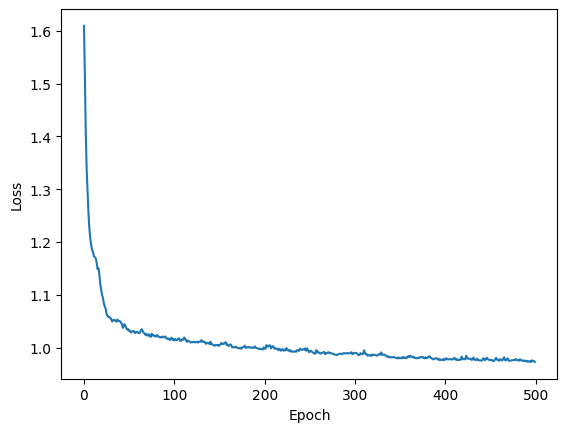

Test accuracy: 463.6890322580645
Accuracy: 0.46623655913978496
Precision: 0.51431130843015
Recall: 0.46623119662604157
F1-score: 0.47868834603191096


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.47      0.57       495
           1       0.47      0.52      0.49       472
           2       0.34      0.43      0.38       449
           3       0.31      0.39      0.34       463
           4       0.74      0.52      0.61       446

    accuracy                           0.47      2325
   macro avg       0.51      0.47      0.48      2325
weighted avg       0.52      0.47      0.48      2325

                    0           1           2           3           4  \
precision    0.719626    0.468451    0.338569    0.305228    0.739683   
recall       0.466667    0.519068    0.432071    0.390929    0.522422   
f1-score     0.566176    0.492462    0.379648    0.342803    0.612352   
support    495.000000  472.000000  449.000000

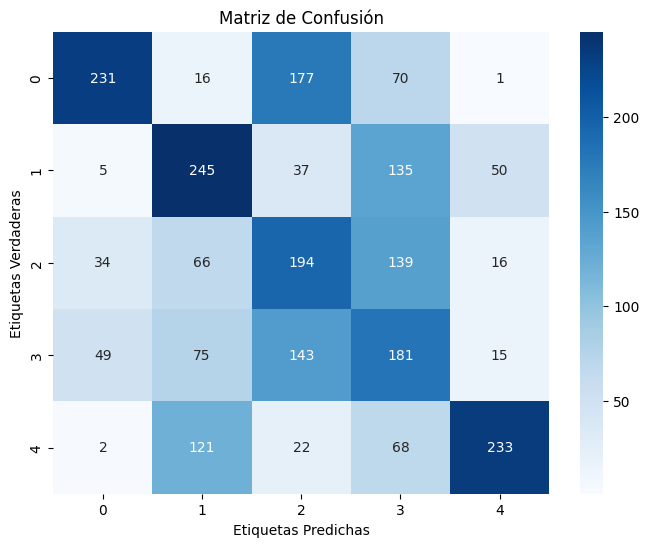

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_500_0.0001_0.3/resultados_500_0.0001_0.3.json
Procesando red con 500 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|▏                                                              | 1/500 [00:03<28:27,  3.42s/it]

1.6096169962602502


Procesando epocas:   0%|▎                                                              | 2/500 [00:06<28:27,  3.43s/it]

1.6096616983413696


Procesando epocas:   1%|▍                                                              | 3/500 [00:10<28:22,  3.43s/it]

1.6095436460831587


Procesando epocas:   1%|▌                                                              | 4/500 [00:13<28:20,  3.43s/it]

1.6095367088037378


Procesando epocas:   1%|▋                                                              | 5/500 [00:17<28:22,  3.44s/it]

1.6092978757970473


Procesando epocas:   1%|▊                                                              | 6/500 [00:20<28:19,  3.44s/it]

1.6085342295029583


Procesando epocas:   1%|▉                                                              | 7/500 [00:24<28:14,  3.44s/it]

1.6063346301808077


Procesando epocas:   2%|█                                                              | 8/500 [00:27<28:12,  3.44s/it]

1.6006990152246812


Procesando epocas:   2%|█▏                                                             | 9/500 [00:30<28:08,  3.44s/it]

1.583061566773583


Procesando epocas:   2%|█▏                                                            | 10/500 [00:34<28:08,  3.45s/it]

1.5377401821753558


Procesando epocas:   2%|█▎                                                            | 11/500 [00:37<28:04,  3.45s/it]

1.481259231707629


Procesando epocas:   2%|█▍                                                            | 12/500 [00:41<27:55,  3.43s/it]

1.4398810611051671


Procesando epocas:   3%|█▌                                                            | 13/500 [00:44<27:46,  3.42s/it]

1.416948310767903


Procesando epocas:   3%|█▋                                                            | 14/500 [00:48<27:38,  3.41s/it]

1.3962125918444466


Procesando epocas:   3%|█▊                                                            | 15/500 [00:51<27:34,  3.41s/it]

1.3753204528023215


Procesando epocas:   3%|█▉                                                            | 16/500 [00:54<27:23,  3.40s/it]

1.3652675502440508


Procesando epocas:   3%|██                                                            | 17/500 [00:58<27:24,  3.41s/it]

1.3528918539776522


Procesando epocas:   4%|██▏                                                           | 18/500 [01:01<27:27,  3.42s/it]

1.345264988085803


Procesando epocas:   4%|██▎                                                           | 19/500 [01:05<27:25,  3.42s/it]

1.3328848298858194


Procesando epocas:   4%|██▍                                                           | 20/500 [01:08<27:19,  3.41s/it]

1.3219985940877128


Procesando epocas:   4%|██▌                                                           | 21/500 [01:11<27:16,  3.42s/it]

1.3132553921026342


Procesando epocas:   4%|██▋                                                           | 22/500 [01:15<27:19,  3.43s/it]

1.298290966538822


Procesando epocas:   5%|██▊                                                           | 23/500 [01:18<27:19,  3.44s/it]

1.293105679399827


Procesando epocas:   5%|██▉                                                           | 24/500 [01:22<27:11,  3.43s/it]

1.283802097685197


Procesando epocas:   5%|███                                                           | 25/500 [01:25<27:07,  3.43s/it]

1.2743350484791924


Procesando epocas:   5%|███▏                                                          | 26/500 [01:29<27:02,  3.42s/it]

1.2679222597795374


Procesando epocas:   5%|███▎                                                          | 27/500 [01:32<26:55,  3.42s/it]

1.263676386720994


Procesando epocas:   6%|███▍                                                          | 28/500 [01:35<26:53,  3.42s/it]

1.2525374265278086


Procesando epocas:   6%|███▌                                                          | 29/500 [01:39<26:54,  3.43s/it]

1.2428440753151389


Procesando epocas:   6%|███▋                                                          | 30/500 [01:42<26:54,  3.43s/it]

1.23801589643254


Procesando epocas:   6%|███▊                                                          | 31/500 [01:46<26:46,  3.43s/it]

1.2312811500885907


Procesando epocas:   6%|███▉                                                          | 32/500 [01:49<26:40,  3.42s/it]

1.221420663244584


Procesando epocas:   7%|████                                                          | 33/500 [01:52<26:31,  3.41s/it]

1.211755749057321


Procesando epocas:   7%|████▏                                                         | 34/500 [01:56<26:25,  3.40s/it]

1.2081758611342486


Procesando epocas:   7%|████▎                                                         | 35/500 [01:59<26:29,  3.42s/it]

1.204138140117421


Procesando epocas:   7%|████▍                                                         | 36/500 [02:03<26:25,  3.42s/it]

1.1939948088982526


Procesando epocas:   7%|████▌                                                         | 37/500 [02:06<26:28,  3.43s/it]

1.1913738412015578


Procesando epocas:   8%|████▋                                                         | 38/500 [02:10<26:22,  3.43s/it]

1.183317659181707


Procesando epocas:   8%|████▊                                                         | 39/500 [02:13<26:19,  3.43s/it]

1.1822925209999084


Procesando epocas:   8%|████▉                                                         | 40/500 [02:16<26:13,  3.42s/it]

1.1737339657895705


Procesando epocas:   8%|█████                                                         | 41/500 [02:20<26:11,  3.42s/it]

1.1622671239516313


Procesando epocas:   8%|█████▏                                                        | 42/500 [02:23<26:10,  3.43s/it]

1.162094033465666


Procesando epocas:   9%|█████▎                                                        | 43/500 [02:27<26:10,  3.44s/it]

1.156082442928763


Procesando epocas:   9%|█████▍                                                        | 44/500 [02:30<26:08,  3.44s/it]

1.1465500028694378


Procesando epocas:   9%|█████▌                                                        | 45/500 [02:34<26:07,  3.45s/it]

1.136996762191548


Procesando epocas:   9%|█████▋                                                        | 46/500 [02:37<26:03,  3.44s/it]

1.1382578344906078


Procesando epocas:   9%|█████▊                                                        | 47/500 [02:41<25:56,  3.44s/it]

1.1367126492892994


Procesando epocas:  10%|█████▉                                                        | 48/500 [02:44<25:52,  3.44s/it]

1.1249429040095384


Procesando epocas:  10%|██████                                                        | 49/500 [02:47<25:51,  3.44s/it]

1.124096899172839


Procesando epocas:  10%|██████▏                                                       | 50/500 [02:51<25:46,  3.44s/it]

1.1131981709424188


Procesando epocas:  10%|██████▎                                                       | 51/500 [02:54<25:40,  3.43s/it]

1.1162156427607817


Procesando epocas:  10%|██████▍                                                       | 52/500 [02:58<25:38,  3.43s/it]

1.099852939563639


Procesando epocas:  11%|██████▌                                                       | 53/500 [03:01<25:32,  3.43s/it]

1.09923693783143


Procesando epocas:  11%|██████▋                                                       | 54/500 [03:05<25:26,  3.42s/it]

1.0919808117782368


Procesando epocas:  11%|██████▊                                                       | 55/500 [03:08<25:21,  3.42s/it]

1.0902761936187744


Procesando epocas:  11%|██████▉                                                       | 56/500 [03:11<25:18,  3.42s/it]

1.0802001900532667


Procesando epocas:  11%|███████                                                       | 57/500 [03:15<25:14,  3.42s/it]

1.082543365394368


Procesando epocas:  12%|███████▏                                                      | 58/500 [03:18<25:15,  3.43s/it]

1.076793604037341


Procesando epocas:  12%|███████▎                                                      | 59/500 [03:22<25:11,  3.43s/it]

1.069993129197289


Procesando epocas:  12%|███████▍                                                      | 60/500 [03:25<25:11,  3.44s/it]

1.0702847754254061


Procesando epocas:  12%|███████▌                                                      | 61/500 [03:29<25:15,  3.45s/it]

1.0650406746303334


Procesando epocas:  12%|███████▋                                                      | 62/500 [03:32<25:09,  3.45s/it]

1.0642933589570662


Procesando epocas:  13%|███████▊                                                      | 63/500 [03:35<25:03,  3.44s/it]

1.0548712874160093


Procesando epocas:  13%|███████▉                                                      | 64/500 [03:39<25:01,  3.44s/it]

1.0562241385964786


Procesando epocas:  13%|████████                                                      | 65/500 [03:42<24:58,  3.44s/it]

1.051448507869945


Procesando epocas:  13%|████████▏                                                     | 66/500 [03:46<24:55,  3.45s/it]

1.0479343098752638


Procesando epocas:  13%|████████▎                                                     | 67/500 [03:49<24:46,  3.43s/it]

1.0455414537121268


Procesando epocas:  14%|████████▍                                                     | 68/500 [03:53<24:39,  3.42s/it]

1.0437862666214213


Procesando epocas:  14%|████████▌                                                     | 69/500 [03:56<24:40,  3.44s/it]

1.04019055611947


Procesando epocas:  14%|████████▋                                                     | 70/500 [04:00<24:39,  3.44s/it]

1.0376997779397403


Procesando epocas:  14%|████████▊                                                     | 71/500 [04:03<24:29,  3.43s/it]

1.035094726786894


Procesando epocas:  14%|████████▉                                                     | 72/500 [04:06<24:26,  3.43s/it]

1.0339747456943287


Procesando epocas:  15%|█████████                                                     | 73/500 [04:10<24:15,  3.41s/it]

1.0341763331609615


Procesando epocas:  15%|█████████▏                                                    | 74/500 [04:13<24:04,  3.39s/it]

1.0287815623423633


Procesando epocas:  15%|█████████▎                                                    | 75/500 [04:17<24:05,  3.40s/it]

1.022330525342156


Procesando epocas:  15%|█████████▍                                                    | 76/500 [04:20<24:05,  3.41s/it]

1.0261798918247222


Procesando epocas:  15%|█████████▌                                                    | 77/500 [04:23<24:01,  3.41s/it]

1.023116769510157


Procesando epocas:  16%|█████████▋                                                    | 78/500 [04:27<24:02,  3.42s/it]

1.0232211610850166


Procesando epocas:  16%|█████████▊                                                    | 79/500 [04:30<24:01,  3.43s/it]

1.018600253497853


Procesando epocas:  16%|█████████▉                                                    | 80/500 [04:34<23:58,  3.43s/it]

1.015788413145963


Procesando epocas:  16%|██████████                                                    | 81/500 [04:37<23:57,  3.43s/it]

1.0184937308816349


Procesando epocas:  16%|██████████▏                                                   | 82/500 [04:40<23:48,  3.42s/it]

1.0157059322385227


Procesando epocas:  17%|██████████▎                                                   | 83/500 [04:44<23:42,  3.41s/it]

1.0132773006663602


Procesando epocas:  17%|██████████▍                                                   | 84/500 [04:47<23:42,  3.42s/it]

1.0119326163740718


Procesando epocas:  17%|██████████▌                                                   | 85/500 [04:51<23:38,  3.42s/it]

1.010600996718687


Procesando epocas:  17%|██████████▋                                                   | 86/500 [04:54<23:35,  3.42s/it]

1.0093841356389663


Procesando epocas:  17%|██████████▊                                                   | 87/500 [04:58<23:36,  3.43s/it]

1.0076220719253315


Procesando epocas:  18%|██████████▉                                                   | 88/500 [05:01<23:33,  3.43s/it]

1.0094891758526072


Procesando epocas:  18%|███████████                                                   | 89/500 [05:04<23:23,  3.42s/it]

1.0054958406616659


Procesando epocas:  18%|███████████▏                                                  | 90/500 [05:08<23:21,  3.42s/it]

1.0081747528384715


Procesando epocas:  18%|███████████▎                                                  | 91/500 [05:11<23:24,  3.43s/it]

1.0024273139588973


Procesando epocas:  18%|███████████▍                                                  | 92/500 [05:15<23:20,  3.43s/it]

1.0039684867157657


Procesando epocas:  19%|███████████▌                                                  | 93/500 [05:18<23:17,  3.43s/it]

1.0015848671688754


Procesando epocas:  19%|███████████▋                                                  | 94/500 [05:22<23:06,  3.42s/it]

1.0004349449101617


Procesando epocas:  19%|███████████▊                                                  | 95/500 [05:25<23:03,  3.42s/it]

1.000261597072377


Procesando epocas:  19%|███████████▉                                                  | 96/500 [05:28<23:06,  3.43s/it]

0.9991173621486215


Procesando epocas:  19%|████████████                                                  | 97/500 [05:32<23:16,  3.47s/it]

0.9992139037917642


Procesando epocas:  20%|████████████▏                                                 | 98/500 [05:36<23:21,  3.49s/it]

0.9983587198397692


Procesando epocas:  20%|████████████▎                                                 | 99/500 [05:39<23:21,  3.50s/it]

0.9985854012124679


Procesando epocas:  20%|████████████▏                                                | 100/500 [05:43<23:29,  3.52s/it]

0.9970236220780541


Procesando epocas:  20%|████████████▎                                                | 101/500 [05:46<23:23,  3.52s/it]

0.9981043829637415


Procesando epocas:  20%|████████████▍                                                | 102/500 [05:50<23:16,  3.51s/it]

0.9942554154816796


Procesando epocas:  21%|████████████▌                                                | 103/500 [05:53<23:13,  3.51s/it]

0.9951935112476349


Procesando epocas:  21%|████████████▋                                                | 104/500 [05:57<23:02,  3.49s/it]

0.9954328789430507


Procesando epocas:  21%|████████████▊                                                | 105/500 [06:00<23:04,  3.51s/it]

0.9931261974222519


Procesando epocas:  21%|████████████▉                                                | 106/500 [06:04<23:01,  3.51s/it]

0.9941044053610634


Procesando epocas:  21%|█████████████                                                | 107/500 [06:07<22:56,  3.50s/it]

0.9952141965136808


Procesando epocas:  22%|█████████████▏                                               | 108/500 [06:11<22:50,  3.50s/it]

0.9937434256076813


Procesando epocas:  22%|█████████████▎                                               | 109/500 [06:14<22:45,  3.49s/it]

0.9926639448193942


Procesando epocas:  22%|█████████████▍                                               | 110/500 [06:18<22:54,  3.52s/it]

0.9924672228448531


Procesando epocas:  22%|█████████████▌                                               | 111/500 [06:21<22:52,  3.53s/it]

0.990983732658274


Procesando epocas:  22%|█████████████▋                                               | 112/500 [06:25<22:56,  3.55s/it]

0.9912263063823475


Procesando epocas:  23%|█████████████▊                                               | 113/500 [06:28<22:46,  3.53s/it]

0.991473833953633


Procesando epocas:  23%|█████████████▉                                               | 114/500 [06:32<22:38,  3.52s/it]

0.9896175310892217


Procesando epocas:  23%|██████████████                                               | 115/500 [06:35<22:41,  3.54s/it]

0.9879214679493623


Procesando epocas:  23%|██████████████▏                                              | 116/500 [06:39<22:34,  3.53s/it]

0.9885437723468332


Procesando epocas:  23%|██████████████▎                                              | 117/500 [06:42<22:30,  3.53s/it]

0.9909368932247162


Procesando epocas:  24%|██████████████▍                                              | 118/500 [06:46<22:36,  3.55s/it]

0.9876114848782035


Procesando epocas:  24%|██████████████▌                                              | 119/500 [06:50<22:36,  3.56s/it]

0.9871077768942889


Procesando epocas:  24%|██████████████▋                                              | 120/500 [06:53<22:31,  3.56s/it]

0.987418178951039


Procesando epocas:  24%|██████████████▊                                              | 121/500 [06:57<22:26,  3.55s/it]

0.986689275152543


Procesando epocas:  24%|██████████████▉                                              | 122/500 [07:00<22:17,  3.54s/it]

0.9858406592817868


Procesando epocas:  25%|███████████████                                              | 123/500 [07:04<22:16,  3.55s/it]

0.9873629587538102


Procesando epocas:  25%|███████████████▏                                             | 124/500 [07:07<22:09,  3.54s/it]

0.9857888393542346


Procesando epocas:  25%|███████████████▎                                             | 125/500 [07:11<22:02,  3.53s/it]

0.9861399994176977


Procesando epocas:  25%|███████████████▎                                             | 126/500 [07:14<21:57,  3.52s/it]

0.987108704623054


Procesando epocas:  25%|███████████████▍                                             | 127/500 [07:18<21:53,  3.52s/it]

0.986716811095967


Procesando epocas:  26%|███████████████▌                                             | 128/500 [07:21<21:49,  3.52s/it]

0.9849878868635963


Procesando epocas:  26%|███████████████▋                                             | 129/500 [07:25<21:45,  3.52s/it]

0.9861723770113552


Procesando epocas:  26%|███████████████▊                                             | 130/500 [07:28<21:40,  3.51s/it]

0.9841186358648188


Procesando epocas:  26%|███████████████▉                                             | 131/500 [07:32<21:28,  3.49s/it]

0.9843212502844193


Procesando epocas:  26%|████████████████                                             | 132/500 [07:35<21:25,  3.49s/it]

0.9852098089807174


Procesando epocas:  27%|████████████████▏                                            | 133/500 [07:39<21:12,  3.47s/it]

0.9848408120519975


Procesando epocas:  27%|████████████████▎                                            | 134/500 [07:42<21:12,  3.48s/it]

0.9836211754995234


Procesando epocas:  27%|████████████████▍                                            | 135/500 [07:46<21:07,  3.47s/it]

0.9837462137727176


Procesando epocas:  27%|████████████████▌                                            | 136/500 [07:49<20:59,  3.46s/it]

0.9833785298992606


Procesando epocas:  27%|████████████████▋                                            | 137/500 [07:53<20:55,  3.46s/it]

0.9825394223718082


Procesando epocas:  28%|████████████████▊                                            | 138/500 [07:56<20:51,  3.46s/it]

0.9836059885866502


Procesando epocas:  28%|████████████████▉                                            | 139/500 [07:59<20:48,  3.46s/it]

0.9820507708717795


Procesando epocas:  28%|█████████████████                                            | 140/500 [08:03<20:45,  3.46s/it]

0.9827973737436182


Procesando epocas:  28%|█████████████████▏                                           | 141/500 [08:06<20:40,  3.46s/it]

0.9839543072616352


Procesando epocas:  28%|█████████████████▎                                           | 142/500 [08:10<20:39,  3.46s/it]

0.9819995490943685


Procesando epocas:  29%|█████████████████▍                                           | 143/500 [08:13<20:35,  3.46s/it]

0.9817136305219987


Procesando epocas:  29%|█████████████████▌                                           | 144/500 [08:17<20:32,  3.46s/it]

0.9828790811931386


Procesando epocas:  29%|█████████████████▋                                           | 145/500 [08:20<20:23,  3.45s/it]

0.9819122324971592


Procesando epocas:  29%|█████████████████▊                                           | 146/500 [08:24<20:17,  3.44s/it]

0.9824406213620129


Procesando epocas:  29%|█████████████████▉                                           | 147/500 [08:27<20:07,  3.42s/it]

0.9831970593508552


Procesando epocas:  30%|██████████████████                                           | 148/500 [08:30<20:07,  3.43s/it]

0.9813937362502603


Procesando epocas:  30%|██████████████████▏                                          | 149/500 [08:34<20:06,  3.44s/it]

0.9809579698478474


Procesando epocas:  30%|██████████████████▎                                          | 150/500 [08:37<20:00,  3.43s/it]

0.9801037318566266


Procesando epocas:  30%|██████████████████▍                                          | 151/500 [08:41<19:54,  3.42s/it]

0.9804588044390959


Procesando epocas:  30%|██████████████████▌                                          | 152/500 [08:44<19:51,  3.42s/it]

0.9812616211526534


Procesando epocas:  31%|██████████████████▋                                          | 153/500 [08:48<19:48,  3.42s/it]

0.9805130099549013


Procesando epocas:  31%|██████████████████▊                                          | 154/500 [08:51<19:50,  3.44s/it]

0.9805080603150761


Procesando epocas:  31%|██████████████████▉                                          | 155/500 [08:54<19:47,  3.44s/it]

0.9794349312782288


Procesando epocas:  31%|███████████████████                                          | 156/500 [08:58<19:42,  3.44s/it]

0.9807376910658444


Procesando epocas:  31%|███████████████████▏                                         | 157/500 [09:01<19:36,  3.43s/it]

0.9815367221832275


Procesando epocas:  32%|███████████████████▎                                         | 158/500 [09:05<19:31,  3.42s/it]

0.9802768658189213


Procesando epocas:  32%|███████████████████▍                                         | 159/500 [09:08<19:25,  3.42s/it]

0.9789006496177001


Procesando epocas:  32%|███████████████████▌                                         | 160/500 [09:12<19:23,  3.42s/it]

0.979187154419282


Procesando epocas:  32%|███████████████████▋                                         | 161/500 [09:15<19:25,  3.44s/it]

0.9809602989869959


Procesando epocas:  32%|███████████████████▊                                         | 162/500 [09:18<19:20,  3.43s/it]

0.9804542383726905


Procesando epocas:  33%|███████████████████▉                                         | 163/500 [09:22<19:18,  3.44s/it]

0.9795329065883861


Procesando epocas:  33%|████████████████████                                         | 164/500 [09:25<19:12,  3.43s/it]

0.97828668496188


Procesando epocas:  33%|████████████████████▏                                        | 165/500 [09:29<19:06,  3.42s/it]

0.9794134452062495


Procesando epocas:  33%|████████████████████▎                                        | 166/500 [09:32<19:04,  3.43s/it]

0.9795528951813193


Procesando epocas:  33%|████████████████████▎                                        | 167/500 [09:36<18:59,  3.42s/it]

0.9794781229075263


Procesando epocas:  34%|████████████████████▍                                        | 168/500 [09:39<18:56,  3.42s/it]

0.9796663498177248


Procesando epocas:  34%|████████████████████▌                                        | 169/500 [09:42<18:54,  3.43s/it]

0.9789277255535126


Procesando epocas:  34%|████████████████████▋                                        | 170/500 [09:46<18:50,  3.43s/it]

0.978385823614457


Procesando epocas:  34%|████████████████████▊                                        | 171/500 [09:49<18:53,  3.45s/it]

0.9778133613221786


Procesando epocas:  34%|████████████████████▉                                        | 172/500 [09:53<18:51,  3.45s/it]

0.9784048473133761


Procesando epocas:  35%|█████████████████████                                        | 173/500 [09:56<18:46,  3.44s/it]

0.9777660734513227


Procesando epocas:  35%|█████████████████████▏                                       | 174/500 [10:00<18:51,  3.47s/it]

0.9778734063400941


Procesando epocas:  35%|█████████████████████▎                                       | 175/500 [10:03<18:47,  3.47s/it]

0.9779755739604725


Procesando epocas:  35%|█████████████████████▍                                       | 176/500 [10:07<18:38,  3.45s/it]

0.978435227099587


Procesando epocas:  35%|█████████████████████▌                                       | 177/500 [10:10<18:37,  3.46s/it]

0.9769464264897739


Procesando epocas:  36%|█████████████████████▋                                       | 178/500 [10:14<18:33,  3.46s/it]

0.9789149137104258


Procesando epocas:  36%|█████████████████████▊                                       | 179/500 [10:17<18:31,  3.46s/it]

0.9787967815118678


Procesando epocas:  36%|█████████████████████▉                                       | 180/500 [10:20<18:27,  3.46s/it]

0.9788605448077706


Procesando epocas:  36%|██████████████████████                                       | 181/500 [10:24<18:22,  3.46s/it]

0.9787708671653972


Procesando epocas:  36%|██████████████████████▏                                      | 182/500 [10:27<18:20,  3.46s/it]

0.9770872933023116


Procesando epocas:  37%|██████████████████████▎                                      | 183/500 [10:31<18:16,  3.46s/it]

0.9782441949143129


Procesando epocas:  37%|██████████████████████▍                                      | 184/500 [10:34<18:10,  3.45s/it]

0.9772039487081415


Procesando epocas:  37%|██████████████████████▌                                      | 185/500 [10:38<18:06,  3.45s/it]

0.9778176759972291


Procesando epocas:  37%|██████████████████████▋                                      | 186/500 [10:41<18:00,  3.44s/it]

0.977353286041933


Procesando epocas:  37%|██████████████████████▊                                      | 187/500 [10:45<17:56,  3.44s/it]

0.9778628521105822


Procesando epocas:  38%|██████████████████████▉                                      | 188/500 [10:48<17:48,  3.42s/it]

0.9779910999185899


Procesando epocas:  38%|███████████████████████                                      | 189/500 [10:51<17:46,  3.43s/it]

0.9777356116210714


Procesando epocas:  38%|███████████████████████▏                                     | 190/500 [10:55<17:38,  3.42s/it]

0.9778479351716883


Procesando epocas:  38%|███████████████████████▎                                     | 191/500 [10:58<17:32,  3.41s/it]

0.9769777971155503


Procesando epocas:  38%|███████████████████████▍                                     | 192/500 [11:02<17:33,  3.42s/it]

0.9770239297081442


Procesando epocas:  39%|███████████████████████▌                                     | 193/500 [11:05<17:28,  3.42s/it]

0.9767118734471938


Procesando epocas:  39%|███████████████████████▋                                     | 194/500 [11:08<17:22,  3.41s/it]

0.9759373335277333


Procesando epocas:  39%|███████████████████████▊                                     | 195/500 [11:12<17:17,  3.40s/it]

0.9782615034019246


Procesando epocas:  39%|███████████████████████▉                                     | 196/500 [11:15<17:15,  3.41s/it]

0.9756741432582631


Procesando epocas:  39%|████████████████████████                                     | 197/500 [11:19<17:10,  3.40s/it]

0.9774323175935185


Procesando epocas:  40%|████████████████████████▏                                    | 198/500 [11:22<17:07,  3.40s/it]

0.9766020406694973


Procesando epocas:  40%|████████████████████████▎                                    | 199/500 [11:25<17:04,  3.40s/it]

0.9764252816929536


Procesando epocas:  40%|████████████████████████▍                                    | 200/500 [11:29<17:05,  3.42s/it]

0.9769425009979921


Procesando epocas:  40%|████████████████████████▌                                    | 201/500 [11:32<17:05,  3.43s/it]

0.9763065657194923


Procesando epocas:  40%|████████████████████████▋                                    | 202/500 [11:36<17:01,  3.43s/it]

0.9776131068958955


Procesando epocas:  41%|████████████████████████▊                                    | 203/500 [11:39<16:55,  3.42s/it]

0.9764555096626282


Procesando epocas:  41%|████████████████████████▉                                    | 204/500 [11:43<16:51,  3.42s/it]

0.9772029129897847


Procesando epocas:  41%|█████████████████████████                                    | 205/500 [11:46<16:48,  3.42s/it]

0.9761899699183071


Procesando epocas:  41%|█████████████████████████▏                                   | 206/500 [11:49<16:46,  3.42s/it]

0.9761786169865552


Procesando epocas:  41%|█████████████████████████▎                                   | 207/500 [11:53<16:43,  3.42s/it]

0.976135806125753


Procesando epocas:  42%|█████████████████████████▍                                   | 208/500 [11:56<16:38,  3.42s/it]

0.9767328521784614


Procesando epocas:  42%|█████████████████████████▍                                   | 209/500 [12:00<16:35,  3.42s/it]

0.9761528186938342


Procesando epocas:  42%|█████████████████████████▌                                   | 210/500 [12:03<16:31,  3.42s/it]

0.9772032983162824


Procesando epocas:  42%|█████████████████████████▋                                   | 211/500 [12:07<16:27,  3.42s/it]

0.9765735377283657


Procesando epocas:  42%|█████████████████████████▊                                   | 212/500 [12:10<16:22,  3.41s/it]

0.9755395493086647


Procesando epocas:  43%|█████████████████████████▉                                   | 213/500 [12:13<16:18,  3.41s/it]

0.9755971578990712


Procesando epocas:  43%|██████████████████████████                                   | 214/500 [12:17<16:15,  3.41s/it]

0.9753417299074285


Procesando epocas:  43%|██████████████████████████▏                                  | 215/500 [12:20<16:14,  3.42s/it]

0.9752310717807097


Procesando epocas:  43%|██████████████████████████▎                                  | 216/500 [12:24<16:13,  3.43s/it]

0.9756080150604248


Procesando epocas:  43%|██████████████████████████▍                                  | 217/500 [12:27<16:11,  3.43s/it]

0.975438324844136


Procesando epocas:  44%|██████████████████████████▌                                  | 218/500 [12:31<16:08,  3.43s/it]

0.9756105577244478


Procesando epocas:  44%|██████████████████████████▋                                  | 219/500 [12:34<16:02,  3.43s/it]

0.9747366456424489


Procesando epocas:  44%|██████████████████████████▊                                  | 220/500 [12:37<15:58,  3.42s/it]

0.9755162831615


Procesando epocas:  44%|██████████████████████████▉                                  | 221/500 [12:41<15:57,  3.43s/it]

0.9755392362089718


Procesando epocas:  44%|███████████████████████████                                  | 222/500 [12:44<15:53,  3.43s/it]

0.9754073767101064


Procesando epocas:  45%|███████████████████████████▏                                 | 223/500 [12:48<15:52,  3.44s/it]

0.9747043623643763


Procesando epocas:  45%|███████████████████████████▎                                 | 224/500 [12:51<15:46,  3.43s/it]

0.9748107240480535


Procesando epocas:  45%|███████████████████████████▍                                 | 225/500 [12:55<15:42,  3.43s/it]

0.9741386890411377


Procesando epocas:  45%|███████████████████████████▌                                 | 226/500 [12:58<15:39,  3.43s/it]

0.9749702685019549


Procesando epocas:  45%|███████████████████████████▋                                 | 227/500 [13:01<15:36,  3.43s/it]

0.9736038060749278


Procesando epocas:  46%|███████████████████████████▊                                 | 228/500 [13:05<15:34,  3.43s/it]

0.9745426058769227


Procesando epocas:  46%|███████████████████████████▉                                 | 229/500 [13:08<15:27,  3.42s/it]

0.9742138164884904


Procesando epocas:  46%|████████████████████████████                                 | 230/500 [13:12<15:27,  3.43s/it]

0.9739432987044839


Procesando epocas:  46%|████████████████████████████▏                                | 231/500 [13:15<15:26,  3.45s/it]

0.9748515507754157


Procesando epocas:  46%|████████████████████████████▎                                | 232/500 [13:19<15:21,  3.44s/it]

0.9734311051228467


Procesando epocas:  47%|████████████████████████████▍                                | 233/500 [13:22<15:17,  3.43s/it]

0.9744826888336855


Procesando epocas:  47%|████████████████████████████▌                                | 234/500 [13:25<15:10,  3.42s/it]

0.9741217911243438


Procesando epocas:  47%|████████████████████████████▋                                | 235/500 [13:29<15:08,  3.43s/it]

0.9750973508638494


Procesando epocas:  47%|████████████████████████████▊                                | 236/500 [13:32<15:04,  3.43s/it]

0.9736486708416658


Procesando epocas:  47%|████████████████████████████▉                                | 237/500 [13:36<15:02,  3.43s/it]

0.9733565642553217


Procesando epocas:  48%|█████████████████████████████                                | 238/500 [13:39<14:58,  3.43s/it]

0.9733744919300079


Procesando epocas:  48%|█████████████████████████████▏                               | 239/500 [13:43<14:56,  3.43s/it]

0.9736691078718971


Procesando epocas:  48%|█████████████████████████████▎                               | 240/500 [13:46<14:51,  3.43s/it]

0.9743920995908625


Procesando epocas:  48%|█████████████████████████████▍                               | 241/500 [13:49<14:48,  3.43s/it]

0.9739425708265865


Procesando epocas:  48%|█████████████████████████████▌                               | 242/500 [13:53<14:45,  3.43s/it]

0.9738153187667622


Procesando epocas:  49%|█████████████████████████████▋                               | 243/500 [13:56<14:41,  3.43s/it]

0.9745371997356415


Procesando epocas:  49%|█████████████████████████████▊                               | 244/500 [14:00<14:35,  3.42s/it]

0.9736702301922966


Procesando epocas:  49%|█████████████████████████████▉                               | 245/500 [14:03<14:29,  3.41s/it]

0.973635104824515


Procesando epocas:  49%|██████████████████████████████                               | 246/500 [14:07<14:27,  3.42s/it]

0.973233645102557


Procesando epocas:  49%|██████████████████████████████▏                              | 247/500 [14:10<14:25,  3.42s/it]

0.9740541647462284


Procesando epocas:  50%|██████████████████████████████▎                              | 248/500 [14:13<14:28,  3.45s/it]

0.9745938073186313


Procesando epocas:  50%|██████████████████████████████▍                              | 249/500 [14:17<14:28,  3.46s/it]

0.9733721435070037


Procesando epocas:  50%|██████████████████████████████▌                              | 250/500 [14:20<14:23,  3.45s/it]

0.9749971733373755


Procesando epocas:  50%|██████████████████████████████▌                              | 251/500 [14:24<14:16,  3.44s/it]

0.9752680406850927


Procesando epocas:  50%|██████████████████████████████▋                              | 252/500 [14:27<14:13,  3.44s/it]

0.9744479018099168


Procesando epocas:  51%|██████████████████████████████▊                              | 253/500 [14:31<14:09,  3.44s/it]

0.9740152898956748


Procesando epocas:  51%|██████████████████████████████▉                              | 254/500 [14:34<14:03,  3.43s/it]

0.9741165041923523


Procesando epocas:  51%|███████████████████████████████                              | 255/500 [14:37<13:58,  3.42s/it]

0.9740933800444883


Procesando epocas:  51%|███████████████████████████████▏                             | 256/500 [14:41<13:55,  3.42s/it]

0.9735962376875036


Procesando epocas:  51%|███████████████████████████████▎                             | 257/500 [14:44<13:51,  3.42s/it]

0.9728265716749079


Procesando epocas:  52%|███████████████████████████████▍                             | 258/500 [14:48<13:47,  3.42s/it]

0.9726229878032908


Procesando epocas:  52%|███████████████████████████████▌                             | 259/500 [14:51<13:49,  3.44s/it]

0.9723436089122997


Procesando epocas:  52%|███████████████████████████████▋                             | 260/500 [14:55<13:55,  3.48s/it]

0.9736925682600807


Procesando epocas:  52%|███████████████████████████████▊                             | 261/500 [14:58<13:56,  3.50s/it]

0.9740097280810861


Procesando epocas:  52%|███████████████████████████████▉                             | 262/500 [15:02<13:56,  3.51s/it]

0.9730159756015329


Procesando epocas:  53%|████████████████████████████████                             | 263/500 [15:05<13:48,  3.49s/it]

0.9730473157237558


Procesando epocas:  53%|████████████████████████████████▏                            | 264/500 [15:09<13:39,  3.47s/it]

0.9734522381249596


Procesando epocas:  53%|████████████████████████████████▎                            | 265/500 [15:12<13:35,  3.47s/it]

0.9738799947149613


Procesando epocas:  53%|████████████████████████████████▍                            | 266/500 [15:16<13:33,  3.48s/it]

0.9720935211462133


Procesando epocas:  53%|████████████████████████████████▌                            | 267/500 [15:19<13:34,  3.49s/it]

0.9726880518829122


Procesando epocas:  54%|████████████████████████████████▋                            | 268/500 [15:23<13:31,  3.50s/it]

0.9731826393043294


Procesando epocas:  54%|████████████████████████████████▊                            | 269/500 [15:26<13:29,  3.50s/it]

0.9730431388406192


Procesando epocas:  54%|████████████████████████████████▉                            | 270/500 [15:30<13:28,  3.52s/it]

0.9730592292897842


Procesando epocas:  54%|█████████████████████████████████                            | 271/500 [15:33<13:27,  3.53s/it]

0.9735970469082103


Procesando epocas:  54%|█████████████████████████████████▏                           | 272/500 [15:37<13:20,  3.51s/it]

0.9730174969224369


Procesando epocas:  55%|█████████████████████████████████▎                           | 273/500 [15:40<13:19,  3.52s/it]

0.9736550345140345


Procesando epocas:  55%|█████████████████████████████████▍                           | 274/500 [15:44<13:20,  3.54s/it]

0.9720422436209286


Procesando epocas:  55%|█████████████████████████████████▌                           | 275/500 [15:48<13:16,  3.54s/it]

0.9727617414558635


Procesando epocas:  55%|█████████████████████████████████▋                           | 276/500 [15:51<13:08,  3.52s/it]

0.9736012059099534


Procesando epocas:  55%|█████████████████████████████████▊                           | 277/500 [15:55<13:04,  3.52s/it]

0.9722078800201416


Procesando epocas:  56%|█████████████████████████████████▉                           | 278/500 [15:58<12:59,  3.51s/it]

0.9732839717584498


Procesando epocas:  56%|██████████████████████████████████                           | 279/500 [16:01<12:48,  3.48s/it]

0.9730037804912118


Procesando epocas:  56%|██████████████████████████████████▏                          | 280/500 [16:05<12:44,  3.48s/it]

0.9731498357127695


Procesando epocas:  56%|██████████████████████████████████▎                          | 281/500 [16:08<12:42,  3.48s/it]

0.973607950000202


Procesando epocas:  56%|██████████████████████████████████▍                          | 282/500 [16:12<12:40,  3.49s/it]

0.9731678513919606


Procesando epocas:  57%|██████████████████████████████████▌                          | 283/500 [16:15<12:35,  3.48s/it]

0.9726594553274267


Procesando epocas:  57%|██████████████████████████████████▋                          | 284/500 [16:19<12:26,  3.46s/it]

0.9724799054510453


Procesando epocas:  57%|██████████████████████████████████▊                          | 285/500 [16:22<12:17,  3.43s/it]

0.9734406481770909


Procesando epocas:  57%|██████████████████████████████████▉                          | 286/500 [16:26<12:18,  3.45s/it]

0.9724681268720066


Procesando epocas:  57%|███████████████████████████████████                          | 287/500 [16:29<12:15,  3.45s/it]

0.9723765632685493


Procesando epocas:  58%|███████████████████████████████████▏                         | 288/500 [16:32<12:11,  3.45s/it]

0.9722065112170051


Procesando epocas:  58%|███████████████████████████████████▎                         | 289/500 [16:36<12:07,  3.45s/it]

0.9723116040229798


Procesando epocas:  58%|███████████████████████████████████▍                         | 290/500 [16:39<12:03,  3.45s/it]

0.9736120862119338


Procesando epocas:  58%|███████████████████████████████████▌                         | 291/500 [16:43<12:05,  3.47s/it]

0.9729484775487114


Procesando epocas:  58%|███████████████████████████████████▌                         | 292/500 [16:46<12:06,  3.49s/it]

0.9731163631467258


Procesando epocas:  59%|███████████████████████████████████▋                         | 293/500 [16:50<12:04,  3.50s/it]

0.9732482005568112


Procesando epocas:  59%|███████████████████████████████████▊                         | 294/500 [16:54<12:04,  3.52s/it]

0.9728382527828217


Procesando epocas:  59%|███████████████████████████████████▉                         | 295/500 [16:57<12:02,  3.53s/it]

0.9733410284799688


Procesando epocas:  59%|████████████████████████████████████                         | 296/500 [17:01<12:01,  3.54s/it]

0.972584537898793


Procesando epocas:  59%|████████████████████████████████████▏                        | 297/500 [17:04<11:55,  3.53s/it]

0.9722067107172573


Procesando epocas:  60%|████████████████████████████████████▎                        | 298/500 [17:08<11:51,  3.52s/it]

0.9721839841674356


Procesando epocas:  60%|████████████████████████████████████▍                        | 299/500 [17:11<11:49,  3.53s/it]

0.9732278140152202


Procesando epocas:  60%|████████████████████████████████████▌                        | 300/500 [17:15<11:43,  3.52s/it]

0.972360013513004


Procesando epocas:  60%|████████████████████████████████████▋                        | 301/500 [17:18<11:37,  3.51s/it]

0.9717194595757652


Procesando epocas:  60%|████████████████████████████████████▊                        | 302/500 [17:22<11:33,  3.50s/it]

0.9731503265745499


Procesando epocas:  61%|████████████████████████████████████▉                        | 303/500 [17:25<11:30,  3.50s/it]

0.972420880724402


Procesando epocas:  61%|█████████████████████████████████████                        | 304/500 [17:29<11:23,  3.49s/it]

0.9723554239553563


Procesando epocas:  61%|█████████████████████████████████████▏                       | 305/500 [17:32<11:20,  3.49s/it]

0.9716302889234879


Procesando epocas:  61%|█████████████████████████████████████▎                       | 306/500 [17:36<11:14,  3.48s/it]

0.972968483321807


Procesando epocas:  61%|█████████████████████████████████████▍                       | 307/500 [17:39<11:07,  3.46s/it]

0.9718886904856738


Procesando epocas:  62%|█████████████████████████████████████▌                       | 308/500 [17:42<11:03,  3.46s/it]

0.9718790741527782


Procesando epocas:  62%|█████████████████████████████████████▋                       | 309/500 [17:46<11:03,  3.47s/it]

0.971612631222781


Procesando epocas:  62%|█████████████████████████████████████▊                       | 310/500 [17:49<10:58,  3.47s/it]

0.9716916028191062


Procesando epocas:  62%|█████████████████████████████████████▉                       | 311/500 [17:53<10:55,  3.47s/it]

0.9721184912849875


Procesando epocas:  62%|██████████████████████████████████████                       | 312/500 [17:56<10:47,  3.45s/it]

0.9714564719620873


Procesando epocas:  63%|██████████████████████████████████████▏                      | 313/500 [18:00<10:45,  3.45s/it]

0.9714101184816921


Procesando epocas:  63%|██████████████████████████████████████▎                      | 314/500 [18:03<10:46,  3.48s/it]

0.9713026085320641


Procesando epocas:  63%|██████████████████████████████████████▍                      | 315/500 [18:07<10:44,  3.49s/it]

0.9709240443566266


Procesando epocas:  63%|██████████████████████████████████████▌                      | 316/500 [18:10<10:45,  3.51s/it]

0.9719520127072053


Procesando epocas:  63%|██████████████████████████████████████▋                      | 317/500 [18:14<10:41,  3.51s/it]

0.9710556486073663


Procesando epocas:  64%|██████████████████████████████████████▊                      | 318/500 [18:17<10:36,  3.50s/it]

0.9718673159094418


Procesando epocas:  64%|██████████████████████████████████████▉                      | 319/500 [18:21<10:39,  3.53s/it]

0.9719105050844304


Procesando epocas:  64%|███████████████████████████████████████                      | 320/500 [18:25<10:39,  3.55s/it]

0.9706999298404245


Procesando epocas:  64%|███████████████████████████████████████▏                     | 321/500 [18:28<10:36,  3.56s/it]

0.9711984178599189


Procesando epocas:  64%|███████████████████████████████████████▎                     | 322/500 [18:32<10:29,  3.54s/it]

0.9714989925132078


Procesando epocas:  65%|███████████████████████████████████████▍                     | 323/500 [18:35<10:25,  3.53s/it]

0.971677217764013


Procesando epocas:  65%|███████████████████████████████████████▌                     | 324/500 [18:39<10:19,  3.52s/it]

0.9709447068326613


Procesando epocas:  65%|███████████████████████████████████████▋                     | 325/500 [18:42<10:12,  3.50s/it]

0.9713415009133956


Procesando epocas:  65%|███████████████████████████████████████▊                     | 326/500 [18:46<10:08,  3.49s/it]

0.9706187749610228


Procesando epocas:  65%|███████████████████████████████████████▉                     | 327/500 [18:49<10:03,  3.49s/it]

0.9710077289272757


Procesando epocas:  66%|████████████████████████████████████████                     | 328/500 [18:53<10:00,  3.49s/it]

0.9714880648781271


Procesando epocas:  66%|████████████████████████████████████████▏                    | 329/500 [18:56<09:59,  3.50s/it]

0.9712822006029241


Procesando epocas:  66%|████████████████████████████████████████▎                    | 330/500 [19:00<09:55,  3.50s/it]

0.9717254719313453


Procesando epocas:  66%|████████████████████████████████████████▍                    | 331/500 [19:03<09:53,  3.51s/it]

0.9713403828003827


Procesando epocas:  66%|████████████████████████████████████████▌                    | 332/500 [19:07<09:52,  3.53s/it]

0.9714091297458199


Procesando epocas:  67%|████████████████████████████████████████▋                    | 333/500 [19:10<09:49,  3.53s/it]

0.971394950502059


Procesando epocas:  67%|████████████████████████████████████████▋                    | 334/500 [19:14<09:42,  3.51s/it]

0.9714141186545877


Procesando epocas:  67%|████████████████████████████████████████▊                    | 335/500 [19:17<09:37,  3.50s/it]

0.9714416907114141


Procesando epocas:  67%|████████████████████████████████████████▉                    | 336/500 [19:21<09:33,  3.50s/it]

0.97119602245443


Procesando epocas:  67%|█████████████████████████████████████████                    | 337/500 [19:24<09:28,  3.49s/it]

0.9715793876086964


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 338/500 [19:28<09:27,  3.50s/it]

0.9711889358127819


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 339/500 [19:31<09:23,  3.50s/it]

0.9709327606593862


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 340/500 [19:35<09:19,  3.50s/it]

0.9706048138001386


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 341/500 [19:38<09:15,  3.49s/it]

0.9706429057261523


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 342/500 [19:42<09:12,  3.50s/it]

0.9707663346739376


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 343/500 [19:45<09:08,  3.49s/it]

0.970316167789347


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 344/500 [19:49<09:05,  3.50s/it]

0.9711126986671896


Procesando epocas:  69%|██████████████████████████████████████████                   | 345/500 [19:52<09:04,  3.51s/it]

0.9717499620774213


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 346/500 [19:56<08:59,  3.50s/it]

0.9700589372831232


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 347/500 [19:59<08:55,  3.50s/it]

0.9701857552808874


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 348/500 [20:03<08:53,  3.51s/it]

0.9704238071161158


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 349/500 [20:06<08:50,  3.52s/it]

0.9709923512795392


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 350/500 [20:10<08:47,  3.51s/it]

0.9711886469055625


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 351/500 [20:13<08:41,  3.50s/it]

0.9704536290729747


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 352/500 [20:17<08:37,  3.50s/it]

0.971126990107929


Procesando epocas:  71%|███████████████████████████████████████████                  | 353/500 [20:20<08:32,  3.49s/it]

0.9706214091357063


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 354/500 [20:24<08:27,  3.48s/it]

0.9711565613746643


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 355/500 [20:27<08:24,  3.48s/it]

0.9703769617220934


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 356/500 [20:31<08:21,  3.48s/it]

0.9704079298412098


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 357/500 [20:34<08:16,  3.47s/it]

0.9714065162574543


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 358/500 [20:37<08:14,  3.48s/it]

0.9708999994923087


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 359/500 [20:41<08:11,  3.48s/it]

0.9710218099986806


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 360/500 [20:44<08:07,  3.48s/it]

0.970983627613853


Procesando epocas:  72%|████████████████████████████████████████████                 | 361/500 [20:48<08:04,  3.48s/it]

0.9708804505712846


Procesando epocas:  72%|████████████████████████████████████████████▏                | 362/500 [20:51<08:01,  3.49s/it]

0.9704789536840775


Procesando epocas:  73%|████████████████████████████████████████████▎                | 363/500 [20:55<07:57,  3.48s/it]

0.9703195554368637


Procesando epocas:  73%|████████████████████████████████████████████▍                | 364/500 [20:58<07:53,  3.48s/it]

0.970567198711283


Procesando epocas:  73%|████████████████████████████████████████████▌                | 365/500 [21:02<07:48,  3.47s/it]

0.9704751982408412


Procesando epocas:  73%|████████████████████████████████████████████▋                | 366/500 [21:05<07:45,  3.47s/it]

0.970221657262129


Procesando epocas:  73%|████████████████████████████████████████████▊                | 367/500 [21:09<07:42,  3.48s/it]

0.9706838895292843


Procesando epocas:  74%|████████████████████████████████████████████▉                | 368/500 [21:12<07:39,  3.48s/it]

0.9711730708094204


Procesando epocas:  74%|█████████████████████████████████████████████                | 369/500 [21:16<07:35,  3.47s/it]

0.9713896716342253


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 370/500 [21:19<07:31,  3.47s/it]

0.9706242684055777


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 371/500 [21:23<07:28,  3.48s/it]

0.9710265966022715


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 372/500 [21:26<07:24,  3.47s/it]

0.9708829108406516


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 373/500 [21:30<07:20,  3.47s/it]

0.9701484858989715


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 374/500 [21:33<07:17,  3.48s/it]

0.9706569668124704


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 375/500 [21:37<07:14,  3.48s/it]

0.9708415220765506


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 376/500 [21:40<07:12,  3.48s/it]

0.9706322754130644


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 377/500 [21:44<07:07,  3.48s/it]

0.96973577597562


Procesando epocas:  76%|██████████████████████████████████████████████               | 378/500 [21:47<07:04,  3.48s/it]

0.9708440051359288


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 379/500 [21:50<07:00,  3.48s/it]

0.9701355797402998


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 380/500 [21:54<06:56,  3.47s/it]

0.9710718084784115


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 381/500 [21:57<06:54,  3.49s/it]

0.9701617216362672


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 382/500 [22:01<06:51,  3.48s/it]

0.9702538676121656


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 383/500 [22:04<06:46,  3.48s/it]

0.9704740909969105


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 384/500 [22:08<06:43,  3.48s/it]

0.9698839513694539


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 385/500 [22:11<06:40,  3.49s/it]

0.9704373391235576


Procesando epocas:  77%|███████████████████████████████████████████████              | 386/500 [22:15<06:37,  3.49s/it]

0.9702531832105973


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 387/500 [22:18<06:32,  3.48s/it]

0.9699539275730358


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 388/500 [22:22<06:28,  3.47s/it]

0.9695101152448093


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 389/500 [22:25<06:26,  3.48s/it]

0.9699792553396785


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 390/500 [22:29<06:22,  3.48s/it]

0.970255062860601


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 391/500 [22:32<06:20,  3.49s/it]

0.9702263491995194


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 392/500 [22:36<06:16,  3.49s/it]

0.9701501464142519


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 393/500 [22:39<06:13,  3.49s/it]

0.9698999022736269


Procesando epocas:  79%|████████████████████████████████████████████████             | 394/500 [22:43<06:08,  3.48s/it]

0.97124823401956


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 395/500 [22:46<06:06,  3.49s/it]

0.9704475953298457


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 396/500 [22:50<06:02,  3.49s/it]

0.9700547695159912


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 397/500 [22:53<05:59,  3.49s/it]

0.9698808045948253


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 398/500 [22:57<05:54,  3.47s/it]

0.9703151822090149


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 399/500 [23:00<05:50,  3.47s/it]

0.9701611872981576


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 400/500 [23:04<05:47,  3.47s/it]

0.9699899571783402


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 401/500 [23:07<05:44,  3.48s/it]

0.9701673847787521


Procesando epocas:  80%|█████████████████████████████████████████████████            | 402/500 [23:11<05:40,  3.48s/it]

0.970074651521795


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 403/500 [23:14<05:37,  3.48s/it]

0.9700009202255923


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 404/500 [23:18<05:34,  3.49s/it]

0.9701516495031469


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 405/500 [23:21<05:30,  3.48s/it]

0.9695279096855837


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 406/500 [23:25<05:27,  3.48s/it]

0.9706118124372819


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 407/500 [23:28<05:23,  3.48s/it]

0.9700663033653708


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 408/500 [23:32<05:21,  3.49s/it]

0.9698668290587033


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 409/500 [23:35<05:17,  3.49s/it]

0.9702944846714244


Procesando epocas:  82%|██████████████████████████████████████████████████           | 410/500 [23:38<05:14,  3.50s/it]

0.9702648990294512


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 411/500 [23:42<05:12,  3.51s/it]

0.970985813701854


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 412/500 [23:46<05:07,  3.50s/it]

0.9701546220218434


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 413/500 [23:49<05:03,  3.49s/it]

0.9696609444477979


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 414/500 [23:52<04:59,  3.48s/it]

0.9703053001095266


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 415/500 [23:56<04:56,  3.49s/it]

0.9698737312765683


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 416/500 [23:59<04:53,  3.50s/it]

0.9699155404287226


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 417/500 [24:03<04:49,  3.49s/it]

0.9700405208503499


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 418/500 [24:06<04:46,  3.50s/it]

0.9699089565697838


Procesando epocas:  84%|███████████████████████████████████████████████████          | 419/500 [24:10<04:43,  3.50s/it]

0.9700946320505703


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 420/500 [24:13<04:39,  3.49s/it]

0.9699646073229172


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 421/500 [24:17<04:35,  3.49s/it]

0.9701263564474443


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 422/500 [24:20<04:32,  3.49s/it]

0.9698800002827364


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 423/500 [24:24<04:28,  3.49s/it]

0.9695986782803255


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 424/500 [24:27<04:24,  3.49s/it]

0.9697615314932431


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 425/500 [24:31<04:21,  3.49s/it]

0.9704926708165337


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 426/500 [24:34<04:17,  3.49s/it]

0.9702289129004759


Procesando epocas:  85%|████████████████████████████████████████████████████         | 427/500 [24:38<04:14,  3.49s/it]

0.9699281376950881


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 428/500 [24:41<04:10,  3.48s/it]

0.9699043680639828


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 429/500 [24:45<04:07,  3.49s/it]

0.9708069250864141


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 430/500 [24:48<04:04,  3.49s/it]

0.970111053831437


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 431/500 [24:52<04:00,  3.49s/it]

0.9698270969531115


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 432/500 [24:55<03:56,  3.48s/it]

0.9700781264725853


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 433/500 [24:59<03:53,  3.49s/it]

0.9697207769926857


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 434/500 [25:02<03:50,  3.49s/it]

0.9701291526065153


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 435/500 [25:06<03:47,  3.50s/it]

0.9699499936664806


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 436/500 [25:09<03:43,  3.49s/it]

0.9698008540798636


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 437/500 [25:13<03:40,  3.49s/it]

0.9708797283032361


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 438/500 [25:16<03:36,  3.49s/it]

0.9695884750169866


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 439/500 [25:20<03:32,  3.49s/it]

0.9695640648112578


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 440/500 [25:23<03:28,  3.48s/it]

0.9696742958882276


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 441/500 [25:27<03:25,  3.49s/it]

0.9691676921704236


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 442/500 [25:30<03:22,  3.48s/it]

0.9692281417986925


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 443/500 [25:34<03:19,  3.49s/it]

0.9701133005759295


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 444/500 [25:37<03:16,  3.50s/it]

0.9689423361245324


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 445/500 [25:41<03:12,  3.51s/it]

0.9695802253835342


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 446/500 [25:44<03:08,  3.50s/it]

0.970167835670359


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 447/500 [25:48<03:05,  3.50s/it]

0.9695346755139967


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 448/500 [25:51<03:01,  3.50s/it]

0.9696010978782879


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 449/500 [25:55<02:58,  3.50s/it]

0.9691529884057887


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 450/500 [25:58<02:54,  3.50s/it]

0.9689299404621124


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 451/500 [26:02<02:51,  3.49s/it]

0.9700473964214325


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 452/500 [26:05<02:47,  3.48s/it]

0.9699580069850473


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 453/500 [26:09<02:43,  3.49s/it]

0.9698024953112883


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 454/500 [26:12<02:40,  3.49s/it]

0.9697040827835307


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 455/500 [26:16<02:37,  3.49s/it]

0.9703081565744737


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 456/500 [26:19<02:33,  3.49s/it]

0.9692824868594899


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 457/500 [26:23<02:30,  3.50s/it]

0.9697860314565546


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 458/500 [26:26<02:26,  3.50s/it]

0.9694462649962481


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 459/500 [26:30<02:23,  3.50s/it]

0.970576264928369


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 460/500 [26:33<02:19,  3.50s/it]

0.9696609963389003


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 461/500 [26:37<02:16,  3.50s/it]

0.9692062612842111


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 462/500 [26:40<02:12,  3.49s/it]

0.9695154880776125


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 463/500 [26:44<02:09,  3.49s/it]

0.970063296135734


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 464/500 [26:47<02:05,  3.49s/it]

0.9695220480946933


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 465/500 [26:51<02:02,  3.50s/it]

0.9696004927158356


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 466/500 [26:54<01:58,  3.50s/it]

0.9692912347176496


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 467/500 [26:58<01:55,  3.49s/it]

0.9695590092855342


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 468/500 [27:01<01:51,  3.49s/it]

0.9693890294607947


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 469/500 [27:05<01:48,  3.49s/it]

0.9698280646520503


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 470/500 [27:08<01:44,  3.48s/it]

0.9690246255958781


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 471/500 [27:12<01:41,  3.49s/it]

0.9691072120386012


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 472/500 [27:15<01:37,  3.49s/it]

0.9692897579249213


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 473/500 [27:19<01:34,  3.50s/it]

0.9688023893272175


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 474/500 [27:22<01:30,  3.48s/it]

0.9696388048284194


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 475/500 [27:25<01:26,  3.48s/it]

0.9699071859612184


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 476/500 [27:29<01:23,  3.48s/it]

0.9691932320594787


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 477/500 [27:32<01:20,  3.48s/it]

0.9690268842612996


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 478/500 [27:36<01:16,  3.46s/it]

0.96912322009311


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 479/500 [27:39<01:12,  3.47s/it]

0.968954220940085


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 480/500 [27:43<01:09,  3.50s/it]

0.9695286775336546


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 481/500 [27:46<01:06,  3.50s/it]

0.9694124421652626


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 482/500 [27:50<01:02,  3.49s/it]

0.969653441625483


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 483/500 [27:53<00:59,  3.49s/it]

0.9690087662023656


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 484/500 [27:57<00:55,  3.49s/it]

0.9695313555352828


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 485/500 [28:00<00:52,  3.50s/it]

0.969588209250394


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 486/500 [28:04<00:48,  3.50s/it]

0.9693454837097841


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 487/500 [28:07<00:45,  3.49s/it]

0.9691184040378121


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 488/500 [28:11<00:41,  3.49s/it]

0.9685287587782916


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 489/500 [28:14<00:38,  3.48s/it]

0.9685273387852837


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 490/500 [28:18<00:34,  3.47s/it]

0.9693635933539446


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 491/500 [28:21<00:31,  3.48s/it]

0.9692122890668757


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 492/500 [28:25<00:27,  3.49s/it]

0.9691157852902131


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 493/500 [28:28<00:24,  3.49s/it]

0.9691245913505554


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 494/500 [28:32<00:20,  3.49s/it]

0.9688704189132241


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 495/500 [28:35<00:17,  3.49s/it]

0.9691347192315495


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 496/500 [28:39<00:13,  3.49s/it]

0.969210434661192


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 497/500 [28:42<00:10,  3.47s/it]

0.9687157560797298


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 498/500 [28:46<00:06,  3.47s/it]

0.969000310757581


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 499/500 [28:49<00:03,  3.49s/it]

0.9691606924814337


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 500/500 [28:53<00:00,  3.47s/it]

0.9689118104822495
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_500_1e-05_0.3/funcion_de_perdida_500_1e-05.png


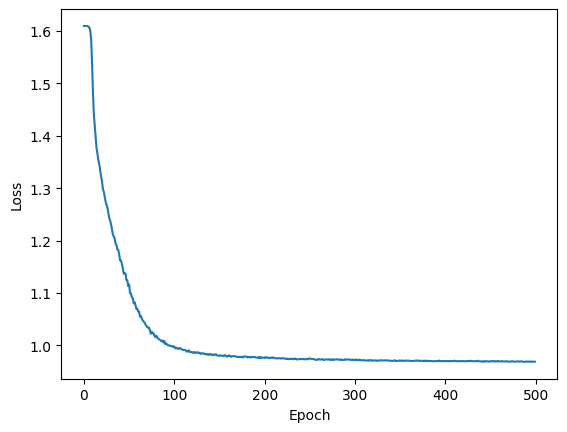

Test accuracy: 465.1294623655914
Accuracy: 0.44903225806451613
Precision: 0.4499477364754395
Recall: 0.4471868018955947
F1-score: 0.44835290248910054


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.63      0.64       495
           1       0.38      0.36      0.37       472
           2       0.27      0.30      0.28       449
           3       0.35      0.34      0.35       463
           4       0.61      0.61      0.61       446

    accuracy                           0.45      2325
   macro avg       0.45      0.45      0.45      2325
weighted avg       0.45      0.45      0.45      2325

                    0           1           2           3           4  \
precision    0.643892    0.378378    0.271805    0.347162    0.608501   
recall       0.628283    0.355932    0.298441    0.343413    0.609865   
f1-score     0.635992    0.366812    0.284501    0.345277    0.609183   
support    495.000000  472.000000  449.00000

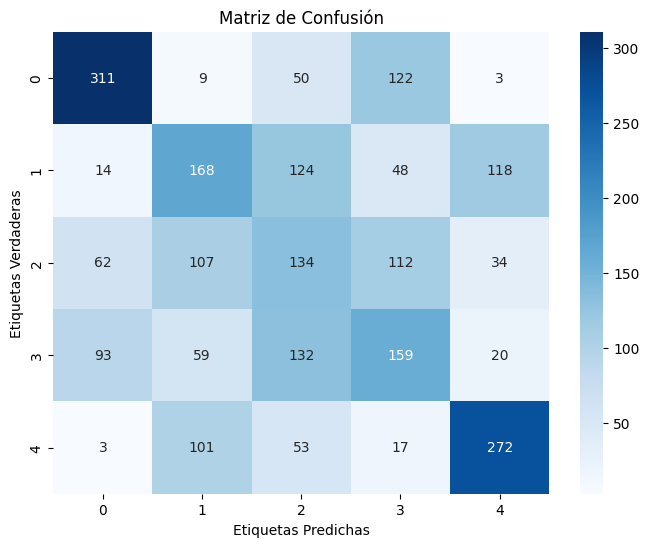

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_500_1e-05_0.3/resultados_500_1e-05_0.3.json
Procesando red con 100 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   1%|▋                                                              | 1/100 [00:03<05:48,  3.52s/it]

1.6093495109502007


Procesando epocas:   2%|█▎                                                             | 2/100 [00:07<05:44,  3.51s/it]

1.5704157429582932


Procesando epocas:   3%|█▉                                                             | 3/100 [00:10<05:39,  3.50s/it]

1.4047004461288453


Procesando epocas:   4%|██▌                                                            | 4/100 [00:14<05:37,  3.51s/it]

1.2870091901105993


Procesando epocas:   5%|███▏                                                           | 5/100 [00:17<05:33,  3.51s/it]

1.2019315880887649


Procesando epocas:   6%|███▊                                                           | 6/100 [00:21<05:28,  3.49s/it]

1.136181314201916


Procesando epocas:   7%|████▍                                                          | 7/100 [00:24<05:24,  3.49s/it]

1.0860648723209605


Procesando epocas:   8%|█████                                                          | 8/100 [00:27<05:19,  3.48s/it]

1.0595449181164012


Procesando epocas:   9%|█████▋                                                         | 9/100 [00:31<05:18,  3.50s/it]

1.036169055630179


Procesando epocas:  10%|██████▏                                                       | 10/100 [00:34<05:14,  3.50s/it]

1.0167759597301482


Procesando epocas:  11%|██████▊                                                       | 11/100 [00:38<05:11,  3.50s/it]

1.0135127968647901


Procesando epocas:  12%|███████▍                                                      | 12/100 [00:42<05:08,  3.51s/it]

1.003723879772074


Procesando epocas:  13%|████████                                                      | 13/100 [00:45<05:04,  3.50s/it]

0.9966850582291098


Procesando epocas:  14%|████████▋                                                     | 14/100 [00:48<05:00,  3.50s/it]

0.9947830964537228


Procesando epocas:  15%|█████████▎                                                    | 15/100 [00:52<04:56,  3.49s/it]

0.9890914485735052


Procesando epocas:  16%|█████████▉                                                    | 16/100 [00:55<04:53,  3.50s/it]

0.9863078124382917


Procesando epocas:  17%|██████████▌                                                   | 17/100 [00:59<04:50,  3.50s/it]

0.9840579783215242


Procesando epocas:  18%|███████████▏                                                  | 18/100 [01:02<04:46,  3.50s/it]

0.9814723418039434


Procesando epocas:  19%|███████████▊                                                  | 19/100 [01:06<04:42,  3.49s/it]

0.9804445645388435


Procesando epocas:  20%|████████████▍                                                 | 20/100 [01:09<04:39,  3.49s/it]

0.9790675885537091


Procesando epocas:  21%|█████████████                                                 | 21/100 [01:13<04:36,  3.49s/it]

0.977959571165197


Procesando epocas:  22%|█████████████▋                                                | 22/100 [01:16<04:32,  3.50s/it]

0.9737021088600158


Procesando epocas:  23%|██████████████▎                                               | 23/100 [01:20<04:29,  3.50s/it]

0.9747889087480657


Procesando epocas:  24%|██████████████▉                                               | 24/100 [01:23<04:25,  3.49s/it]

0.9750592070467332


Procesando epocas:  25%|███████████████▌                                              | 25/100 [01:27<04:21,  3.48s/it]

0.973594828563578


Procesando epocas:  26%|████████████████                                              | 26/100 [01:30<04:16,  3.47s/it]

0.9744326531887054


Procesando epocas:  27%|████████████████▋                                             | 27/100 [01:34<04:14,  3.49s/it]

0.971938080296797


Procesando epocas:  28%|█████████████████▎                                            | 28/100 [01:37<04:10,  3.48s/it]

0.9705808176713832


Procesando epocas:  29%|█████████████████▉                                            | 29/100 [01:41<04:07,  3.48s/it]

0.9720145316684947


Procesando epocas:  30%|██████████████████▌                                           | 30/100 [01:44<04:03,  3.48s/it]

0.9721304062534781


Procesando epocas:  31%|███████████████████▏                                          | 31/100 [01:48<03:59,  3.47s/it]

0.9724662952563342


Procesando epocas:  32%|███████████████████▊                                          | 32/100 [01:51<03:56,  3.48s/it]

0.9738117968334871


Procesando epocas:  33%|████████████████████▍                                         | 33/100 [01:55<03:52,  3.48s/it]

0.9719632166273454


Procesando epocas:  34%|█████████████████████                                         | 34/100 [01:58<03:49,  3.48s/it]

0.9718367036651162


Procesando epocas:  35%|█████████████████████▋                                        | 35/100 [02:02<03:46,  3.48s/it]

0.9696023313438191


Procesando epocas:  36%|██████████████████████▎                                       | 36/100 [02:05<03:43,  3.49s/it]

0.9680955129511216


Procesando epocas:  37%|██████████████████████▉                                       | 37/100 [02:09<03:39,  3.48s/it]

0.9681742980199701


Procesando epocas:  38%|███████████████████████▌                                      | 38/100 [02:12<03:36,  3.49s/it]

0.9673305325648364


Procesando epocas:  39%|████████████████████████▏                                     | 39/100 [02:16<03:32,  3.49s/it]

0.968212717070299


Procesando epocas:  40%|████████████████████████▊                                     | 40/100 [02:19<03:28,  3.48s/it]

0.9654758235987495


Procesando epocas:  41%|█████████████████████████▍                                    | 41/100 [02:23<03:24,  3.47s/it]

0.9652284629204694


Procesando epocas:  42%|██████████████████████████                                    | 42/100 [02:26<03:21,  3.48s/it]

0.9625436905552359


Procesando epocas:  43%|██████████████████████████▋                                   | 43/100 [02:29<03:18,  3.47s/it]

0.961330997242647


Procesando epocas:  44%|███████████████████████████▎                                  | 44/100 [02:33<03:14,  3.47s/it]

0.9624448562369627


Procesando epocas:  45%|███████████████████████████▉                                  | 45/100 [02:36<03:10,  3.47s/it]

0.9639607780119952


Procesando epocas:  46%|████████████████████████████▌                                 | 46/100 [02:40<03:07,  3.48s/it]

0.9631120457368738


Procesando epocas:  47%|█████████████████████████████▏                                | 47/100 [02:43<03:04,  3.47s/it]

0.9641480375738705


Procesando epocas:  48%|█████████████████████████████▊                                | 48/100 [02:47<03:00,  3.48s/it]

0.9630167308975669


Procesando epocas:  49%|██████████████████████████████▍                               | 49/100 [02:50<02:57,  3.48s/it]

0.9640054962214302


Procesando epocas:  50%|███████████████████████████████                               | 50/100 [02:54<02:54,  3.49s/it]

0.961818515553194


Procesando epocas:  51%|███████████████████████████████▌                              | 51/100 [02:57<02:50,  3.49s/it]

0.9645939967211555


Procesando epocas:  52%|████████████████████████████████▏                             | 52/100 [03:01<02:47,  3.49s/it]

0.9638120717862073


Procesando epocas:  53%|████████████████████████████████▊                             | 53/100 [03:04<02:44,  3.49s/it]

0.9645245902678545


Procesando epocas:  54%|█████████████████████████████████▍                            | 54/100 [03:08<02:40,  3.49s/it]

0.9625763717819663


Procesando epocas:  55%|██████████████████████████████████                            | 55/100 [03:11<02:37,  3.49s/it]

0.9619919882101171


Procesando epocas:  56%|██████████████████████████████████▋                           | 56/100 [03:15<02:33,  3.49s/it]

0.963244165392483


Procesando epocas:  57%|███████████████████████████████████▎                          | 57/100 [03:18<02:30,  3.49s/it]

0.9642529747065376


Procesando epocas:  58%|███████████████████████████████████▉                          | 58/100 [03:22<02:26,  3.49s/it]

0.9642112381318036


Procesando epocas:  59%|████████████████████████████████████▌                         | 59/100 [03:25<02:23,  3.49s/it]

0.9643425657468684


Procesando epocas:  60%|█████████████████████████████████████▏                        | 60/100 [03:29<02:18,  3.47s/it]

0.9636628270149231


Procesando epocas:  61%|█████████████████████████████████████▊                        | 61/100 [03:32<02:15,  3.48s/it]

0.9631131806794335


Procesando epocas:  62%|██████████████████████████████████████▍                       | 62/100 [03:36<02:12,  3.48s/it]

0.9644137985566084


Procesando epocas:  63%|███████████████████████████████████████                       | 63/100 [03:39<02:08,  3.47s/it]

0.962110127771602


Procesando epocas:  64%|███████████████████████████████████████▋                      | 64/100 [03:43<02:05,  3.48s/it]

0.962244685607798


Procesando epocas:  65%|████████████████████████████████████████▎                     | 65/100 [03:46<02:01,  3.48s/it]

0.964747545298408


Procesando epocas:  66%|████████████████████████████████████████▉                     | 66/100 [03:50<01:58,  3.48s/it]

0.965526520504671


Procesando epocas:  67%|█████████████████████████████████████████▌                    | 67/100 [03:53<01:55,  3.49s/it]

0.9673298313337214


Procesando epocas:  68%|██████████████████████████████████████████▏                   | 68/100 [03:57<01:51,  3.49s/it]

0.9660710976404302


Procesando epocas:  69%|██████████████████████████████████████████▊                   | 69/100 [04:00<01:48,  3.49s/it]

0.9637869035496431


Procesando epocas:  70%|███████████████████████████████████████████▍                  | 70/100 [04:04<01:44,  3.49s/it]

0.9634884157601524


Procesando epocas:  71%|████████████████████████████████████████████                  | 71/100 [04:07<01:41,  3.48s/it]

0.9627091505948235


Procesando epocas:  72%|████████████████████████████████████████████▋                 | 72/100 [04:11<01:37,  3.49s/it]

0.9615949248566347


Procesando epocas:  73%|█████████████████████████████████████████████▎                | 73/100 [04:14<01:34,  3.50s/it]

0.9609028146547429


Procesando epocas:  74%|█████████████████████████████████████████████▉                | 74/100 [04:18<01:30,  3.49s/it]

0.9611653717125164


Procesando epocas:  75%|██████████████████████████████████████████████▌               | 75/100 [04:21<01:27,  3.49s/it]

0.9610793218893163


Procesando epocas:  76%|███████████████████████████████████████████████               | 76/100 [04:25<01:23,  3.49s/it]

0.9615642901729134


Procesando epocas:  77%|███████████████████████████████████████████████▋              | 77/100 [04:28<01:20,  3.49s/it]

0.9616243674474604


Procesando epocas:  78%|████████████████████████████████████████████████▎             | 78/100 [04:32<01:16,  3.49s/it]

0.961564945824006


Procesando epocas:  79%|████████████████████████████████████████████████▉             | 79/100 [04:35<01:13,  3.49s/it]

0.960665442312465


Procesando epocas:  80%|█████████████████████████████████████████████████▌            | 80/100 [04:39<01:09,  3.49s/it]

0.9589534191524282


Procesando epocas:  81%|██████████████████████████████████████████████████▏           | 81/100 [04:42<01:06,  3.49s/it]

0.9598857795490938


Procesando epocas:  82%|██████████████████████████████████████████████████▊           | 82/100 [04:45<01:02,  3.48s/it]

0.9600375999422635


Procesando epocas:  83%|███████████████████████████████████████████████████▍          | 83/100 [04:49<00:59,  3.48s/it]

0.9596346760497374


Procesando epocas:  84%|████████████████████████████████████████████████████          | 84/100 [04:52<00:55,  3.50s/it]

0.9587632498320411


Procesando epocas:  85%|████████████████████████████████████████████████████▋         | 85/100 [04:56<00:52,  3.51s/it]

0.9575344078681048


Procesando epocas:  86%|█████████████████████████████████████████████████████▎        | 86/100 [05:00<00:49,  3.51s/it]

0.9606195022078121


Procesando epocas:  87%|█████████████████████████████████████████████████████▉        | 87/100 [05:03<00:45,  3.51s/it]

0.9584423819008996


Procesando epocas:  88%|██████████████████████████████████████████████████████▌       | 88/100 [05:07<00:42,  3.52s/it]

0.9593914803336648


Procesando epocas:  89%|███████████████████████████████████████████████████████▏      | 89/100 [05:10<00:38,  3.51s/it]

0.9603616665391361


Procesando epocas:  90%|███████████████████████████████████████████████████████▊      | 90/100 [05:14<00:34,  3.50s/it]

0.9599442524068496


Procesando epocas:  91%|████████████████████████████████████████████████████████▍     | 91/100 [05:17<00:31,  3.48s/it]

0.956748653159422


Procesando epocas:  92%|█████████████████████████████████████████████████████████     | 92/100 [05:20<00:27,  3.48s/it]

0.957380293747958


Procesando epocas:  93%|█████████████████████████████████████████████████████████▋    | 93/100 [05:24<00:24,  3.47s/it]

0.9568074685685775


Procesando epocas:  94%|██████████████████████████████████████████████████████████▎   | 94/100 [05:27<00:20,  3.47s/it]

0.9577294283053455


Procesando epocas:  95%|██████████████████████████████████████████████████████████▉   | 95/100 [05:31<00:17,  3.48s/it]

0.9571675409288968


Procesando epocas:  96%|███████████████████████████████████████████████████████████▌  | 96/100 [05:34<00:13,  3.48s/it]

0.9574065807987662


Procesando epocas:  97%|████████████████████████████████████████████████████████████▏ | 97/100 [05:38<00:10,  3.48s/it]

0.9566286434145534


Procesando epocas:  98%|████████████████████████████████████████████████████████████▊ | 98/100 [05:41<00:06,  3.49s/it]

0.9564920372822705


Procesando epocas:  99%|█████████████████████████████████████████████████████████████▍| 99/100 [05:45<00:03,  3.49s/it]

0.9561140638940474


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.49s/it]

0.9573022081571467
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_100_0.0001_0.2/funcion_de_perdida_100_0.0001.png


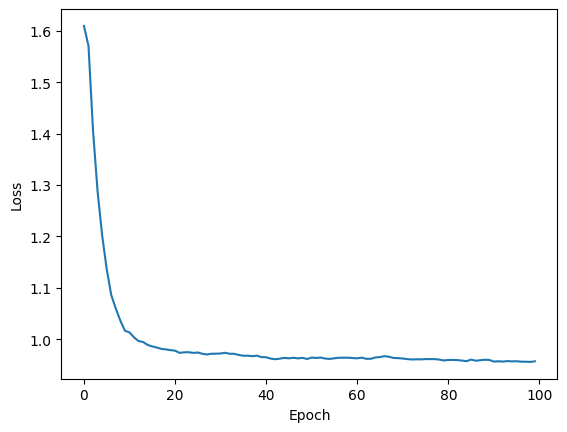

Test accuracy: 465.89290322580644
Accuracy: 0.5070967741935484
Precision: 0.536727521804279
Recall: 0.5060982443817633
F1-score: 0.5147411268752984


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.55      0.60       495
           1       0.50      0.54      0.52       472
           2       0.51      0.43      0.47       449
           3       0.33      0.48      0.39       463
           4       0.69      0.53      0.60       446

    accuracy                           0.51      2325
   macro avg       0.54      0.51      0.51      2325
weighted avg       0.54      0.51      0.52      2325

                    0           1           2           3           4  \
precision    0.657005    0.498054    0.509186    0.326409    0.692982   
recall       0.549495    0.542373    0.432071    0.475162    0.531390   
f1-score     0.598460    0.519270    0.467470    0.386983    0.601523   
support    495.000000  472.000000  449.000000 

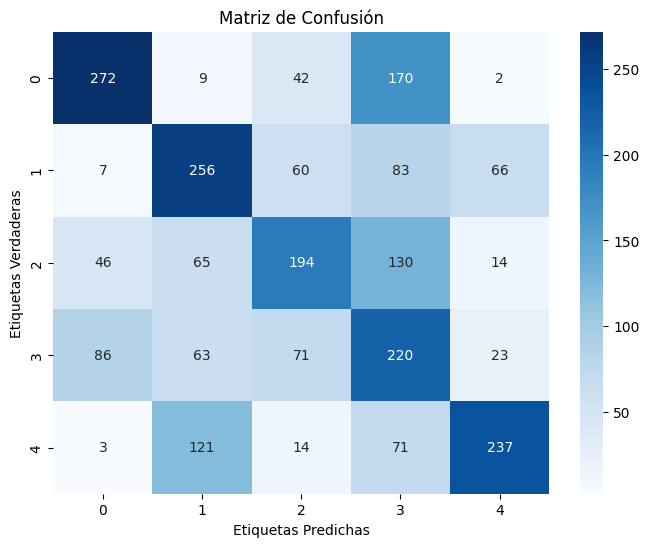

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_100_0.0001_0.2/resultados_100_0.0001_0.2.json
Procesando red con 100 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   1%|▋                                                              | 1/100 [00:03<05:48,  3.52s/it]

1.6095424729235033


Procesando epocas:   2%|█▎                                                             | 2/100 [00:07<05:42,  3.50s/it]

1.6095311452360714


Procesando epocas:   3%|█▉                                                             | 3/100 [00:10<05:39,  3.50s/it]

1.60945921645445


Procesando epocas:   4%|██▌                                                            | 4/100 [00:13<05:35,  3.50s/it]

1.6094161159851972


Procesando epocas:   5%|███▏                                                           | 5/100 [00:17<05:30,  3.48s/it]

1.6094014272970312


Procesando epocas:   6%|███▊                                                           | 6/100 [00:20<05:26,  3.47s/it]

1.609171566542457


Procesando epocas:   7%|████▍                                                          | 7/100 [00:24<05:22,  3.46s/it]

1.60866519984077


Procesando epocas:   8%|█████                                                          | 8/100 [00:27<05:18,  3.47s/it]

1.6072698950767517


Procesando epocas:   9%|█████▋                                                         | 9/100 [00:31<05:16,  3.47s/it]

1.6030554378733914


Procesando epocas:  10%|██████▏                                                       | 10/100 [00:34<05:12,  3.47s/it]

1.5883856086169972


Procesando epocas:  11%|██████▊                                                       | 11/100 [00:38<05:08,  3.46s/it]

1.548394537673277


Procesando epocas:  12%|███████▍                                                      | 12/100 [00:41<05:04,  3.46s/it]

1.4981247397030102


Procesando epocas:  13%|████████                                                      | 13/100 [00:45<05:00,  3.46s/it]

1.4581098437309266


Procesando epocas:  14%|████████▋                                                     | 14/100 [00:48<04:58,  3.47s/it]

1.4325110814150641


Procesando epocas:  15%|█████████▎                                                    | 15/100 [00:52<04:56,  3.48s/it]

1.4084754516096676


Procesando epocas:  16%|█████████▉                                                    | 16/100 [00:55<04:53,  3.49s/it]

1.3897192849832423


Procesando epocas:  17%|██████████▌                                                   | 17/100 [00:59<04:49,  3.48s/it]

1.3729441060739405


Procesando epocas:  18%|███████████▏                                                  | 18/100 [01:02<04:46,  3.49s/it]

1.3600006236749538


Procesando epocas:  19%|███████████▊                                                  | 19/100 [01:06<04:42,  3.48s/it]

1.339561061298146


Procesando epocas:  20%|████████████▍                                                 | 20/100 [01:09<04:38,  3.48s/it]

1.333465179976295


Procesando epocas:  21%|█████████████                                                 | 21/100 [01:13<04:35,  3.48s/it]

1.3202802651068744


Procesando epocas:  22%|█████████████▋                                                | 22/100 [01:16<04:32,  3.50s/it]

1.3037068963050842


Procesando epocas:  23%|██████████████▎                                               | 23/100 [01:20<04:28,  3.48s/it]

1.2935383046374602


Procesando epocas:  24%|██████████████▉                                               | 24/100 [01:23<04:24,  3.48s/it]

1.284044916489545


Procesando epocas:  25%|███████████████▌                                              | 25/100 [01:27<04:21,  3.49s/it]

1.2744228622492622


Procesando epocas:  26%|████████████████                                              | 26/100 [01:30<04:17,  3.48s/it]

1.2659311161321751


Procesando epocas:  27%|████████████████▋                                             | 27/100 [01:33<04:13,  3.47s/it]

1.2524455820812899


Procesando epocas:  28%|█████████████████▎                                            | 28/100 [01:37<04:10,  3.48s/it]

1.2423516995766584


Procesando epocas:  29%|█████████████████▉                                            | 29/100 [01:40<04:05,  3.46s/it]

1.2353282416568083


Procesando epocas:  30%|██████████████████▌                                           | 30/100 [01:44<04:02,  3.47s/it]

1.2305414964171018


Procesando epocas:  31%|███████████████████▏                                          | 31/100 [01:47<03:59,  3.47s/it]

1.221249880510218


Procesando epocas:  32%|███████████████████▊                                          | 32/100 [01:51<03:56,  3.47s/it]

1.2148988604545594


Procesando epocas:  33%|████████████████████▍                                         | 33/100 [01:54<03:52,  3.47s/it]

1.2058050562353695


Procesando epocas:  34%|█████████████████████                                         | 34/100 [01:58<03:49,  3.47s/it]

1.2033380901112276


Procesando epocas:  35%|█████████████████████▋                                        | 35/100 [02:01<03:46,  3.48s/it]

1.1988659942851347


Procesando epocas:  36%|██████████████████████▎                                       | 36/100 [02:05<03:43,  3.49s/it]

1.195223165960873


Procesando epocas:  37%|██████████████████████▉                                       | 37/100 [02:08<03:39,  3.49s/it]

1.1884025608792024


Procesando epocas:  38%|███████████████████████▌                                      | 38/100 [02:12<03:36,  3.50s/it]

1.18454669713974


Procesando epocas:  39%|████████████████████████▏                                     | 39/100 [02:15<03:32,  3.49s/it]

1.1829715570982764


Procesando epocas:  40%|████████████████████████▊                                     | 40/100 [02:19<03:29,  3.49s/it]

1.1757985486703761


Procesando epocas:  41%|█████████████████████████▍                                    | 41/100 [02:22<03:24,  3.47s/it]

1.1719965177423814


Procesando epocas:  42%|██████████████████████████                                    | 42/100 [02:26<03:21,  3.48s/it]

1.1707755649791045


Procesando epocas:  43%|██████████████████████████▋                                   | 43/100 [02:29<03:18,  3.48s/it]

1.1673760631505181


Procesando epocas:  44%|███████████████████████████▎                                  | 44/100 [02:33<03:14,  3.48s/it]

1.1645805390442119


Procesando epocas:  45%|███████████████████████████▉                                  | 45/100 [02:36<03:11,  3.48s/it]

1.1594504107447232


Procesando epocas:  46%|████████████████████████████▌                                 | 46/100 [02:40<03:08,  3.49s/it]

1.1606008634847753


Procesando epocas:  47%|█████████████████████████████▏                                | 47/100 [02:43<03:03,  3.47s/it]

1.1560493167708903


Procesando epocas:  48%|█████████████████████████████▊                                | 48/100 [02:46<03:00,  3.46s/it]

1.1579509342417997


Procesando epocas:  49%|██████████████████████████████▍                               | 49/100 [02:50<02:56,  3.46s/it]

1.1541845216470605


Procesando epocas:  50%|███████████████████████████████                               | 50/100 [02:53<02:53,  3.47s/it]

1.1495927382917965


Procesando epocas:  51%|███████████████████████████████▌                              | 51/100 [02:57<02:50,  3.47s/it]

1.1492663453606997


Procesando epocas:  52%|████████████████████████████████▏                             | 52/100 [03:00<02:46,  3.47s/it]

1.14758942267474


Procesando epocas:  53%|████████████████████████████████▊                             | 53/100 [03:04<02:43,  3.48s/it]

1.143652008561527


Procesando epocas:  54%|█████████████████████████████████▍                            | 54/100 [03:07<02:39,  3.47s/it]

1.1400952339172363


Procesando epocas:  55%|██████████████████████████████████                            | 55/100 [03:11<02:36,  3.48s/it]

1.1367485228706808


Procesando epocas:  56%|██████████████████████████████████▋                           | 56/100 [03:14<02:33,  3.48s/it]

1.135512518532136


Procesando epocas:  57%|███████████████████████████████████▎                          | 57/100 [03:18<02:30,  3.49s/it]

1.1323693875004264


Procesando epocas:  58%|███████████████████████████████████▉                          | 58/100 [03:21<02:26,  3.50s/it]

1.1330094418104957


Procesando epocas:  59%|████████████████████████████████████▌                         | 59/100 [03:25<02:23,  3.49s/it]

1.1245091115727144


Procesando epocas:  60%|█████████████████████████████████████▏                        | 60/100 [03:28<02:19,  3.48s/it]

1.11733540261493


Procesando epocas:  61%|█████████████████████████████████████▊                        | 61/100 [03:32<02:15,  3.48s/it]

1.1189739146653344


Procesando epocas:  62%|██████████████████████████████████████▍                       | 62/100 [03:35<02:12,  3.48s/it]

1.1172735031913308


Procesando epocas:  63%|███████████████████████████████████████                       | 63/100 [03:39<02:08,  3.48s/it]

1.1086764409261591


Procesando epocas:  64%|███████████████████████████████████████▋                      | 64/100 [03:42<02:05,  3.47s/it]

1.1074563001885134


Procesando epocas:  65%|████████████████████████████████████████▎                     | 65/100 [03:46<02:00,  3.45s/it]

1.1051735450239744


Procesando epocas:  66%|████████████████████████████████████████▉                     | 66/100 [03:49<01:57,  3.45s/it]

1.1017110551104825


Procesando epocas:  67%|█████████████████████████████████████████▌                    | 67/100 [03:53<01:55,  3.50s/it]

1.0994089708608739


Procesando epocas:  68%|██████████████████████████████████████████▏                   | 68/100 [03:56<01:51,  3.49s/it]

1.0915038782007553


Procesando epocas:  69%|██████████████████████████████████████████▊                   | 69/100 [04:00<01:48,  3.50s/it]

1.0853195029146532


Procesando epocas:  70%|███████████████████████████████████████████▍                  | 70/100 [04:03<01:44,  3.49s/it]

1.08078011414584


Procesando epocas:  71%|████████████████████████████████████████████                  | 71/100 [04:07<01:41,  3.49s/it]

1.0799450569293079


Procesando epocas:  72%|████████████████████████████████████████████▋                 | 72/100 [04:10<01:37,  3.48s/it]

1.0791752639938803


Procesando epocas:  73%|█████████████████████████████████████████████▎                | 73/100 [04:13<01:33,  3.47s/it]

1.0729777230935937


Procesando epocas:  74%|█████████████████████████████████████████████▉                | 74/100 [04:17<01:30,  3.49s/it]

1.0714269522358388


Procesando epocas:  75%|██████████████████████████████████████████████▌               | 75/100 [04:20<01:27,  3.49s/it]

1.071304394567714


Procesando epocas:  76%|███████████████████████████████████████████████               | 76/100 [04:24<01:23,  3.49s/it]

1.0662939734318677


Procesando epocas:  77%|███████████████████████████████████████████████▋              | 77/100 [04:27<01:20,  3.49s/it]

1.0634847511263454


Procesando epocas:  78%|████████████████████████████████████████████████▎             | 78/100 [04:31<01:16,  3.48s/it]

1.0627955664606656


Procesando epocas:  79%|████████████████████████████████████████████████▉             | 79/100 [04:34<01:13,  3.48s/it]

1.0615356697755702


Procesando epocas:  80%|█████████████████████████████████████████████████▌            | 80/100 [04:38<01:09,  3.48s/it]

1.057058758244795


Procesando epocas:  81%|██████████████████████████████████████████████████▏           | 81/100 [04:41<01:05,  3.47s/it]

1.0563304315595066


Procesando epocas:  82%|██████████████████████████████████████████████████▊           | 82/100 [04:45<01:02,  3.48s/it]

1.0514754758161657


Procesando epocas:  83%|███████████████████████████████████████████████████▍          | 83/100 [04:48<00:59,  3.49s/it]

1.0521266491974102


Procesando epocas:  84%|████████████████████████████████████████████████████          | 84/100 [04:52<00:55,  3.50s/it]

1.0530494602287517


Procesando epocas:  85%|████████████████████████████████████████████████████▋         | 85/100 [04:55<00:52,  3.50s/it]

1.0504547595977782


Procesando epocas:  86%|█████████████████████████████████████████████████████▎        | 86/100 [04:59<00:48,  3.50s/it]

1.046477717511794


Procesando epocas:  87%|█████████████████████████████████████████████████████▉        | 87/100 [05:02<00:45,  3.50s/it]

1.0445532353485332


Procesando epocas:  88%|██████████████████████████████████████████████████████▌       | 88/100 [05:06<00:41,  3.50s/it]

1.0431248461498934


Procesando epocas:  89%|███████████████████████████████████████████████████████▏      | 89/100 [05:09<00:38,  3.49s/it]

1.0416215931668


Procesando epocas:  90%|███████████████████████████████████████████████████████▊      | 90/100 [05:13<00:34,  3.50s/it]

1.0396860729245578


Procesando epocas:  91%|████████████████████████████████████████████████████████▍     | 91/100 [05:16<00:31,  3.50s/it]

1.040895151390749


Procesando epocas:  92%|█████████████████████████████████████████████████████████     | 92/100 [05:20<00:28,  3.51s/it]

1.0386059186037848


Procesando epocas:  93%|█████████████████████████████████████████████████████████▋    | 93/100 [05:23<00:24,  3.50s/it]

1.0394244302721585


Procesando epocas:  94%|██████████████████████████████████████████████████████████▎   | 94/100 [05:27<00:20,  3.50s/it]

1.0377118419198428


Procesando epocas:  95%|██████████████████████████████████████████████████████████▉   | 95/100 [05:30<00:17,  3.49s/it]

1.0367688575211693


Procesando epocas:  96%|███████████████████████████████████████████████████████████▌  | 96/100 [05:34<00:13,  3.49s/it]

1.0374566120259903


Procesando epocas:  97%|████████████████████████████████████████████████████████████▏ | 97/100 [05:37<00:10,  3.50s/it]

1.0341575619052439


Procesando epocas:  98%|████████████████████████████████████████████████████████████▊ | 98/100 [05:41<00:06,  3.50s/it]

1.0351638909648446


Procesando epocas:  99%|█████████████████████████████████████████████████████████████▍| 99/100 [05:44<00:03,  3.50s/it]

1.0316315805210787


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.48s/it]

1.0311348978210897
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_100_1e-05_0.2/funcion_de_perdida_100_1e-05.png


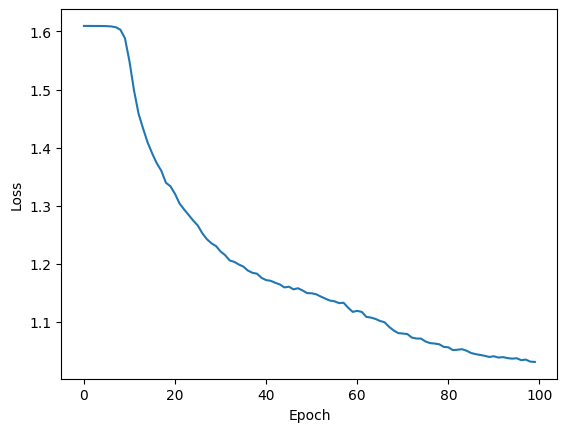

Test accuracy: 465.3621505376344
Accuracy: 0.4455913978494624
Precision: 0.43177807013801583
Recall: 0.44419458480872054
F1-score: 0.4350439836157303


Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       495
           1       0.40      0.31      0.35       472
           2       0.28      0.29      0.28       449
           3       0.32      0.28      0.30       463
           4       0.58      0.69      0.63       446

    accuracy                           0.45      2325
   macro avg       0.43      0.44      0.44      2325
weighted avg       0.43      0.45      0.44      2325

                    0           1           2           3           4  \
precision    0.574506    0.404959    0.276231    0.323457    0.579737   
recall       0.646465    0.311441    0.287305    0.282937    0.692825   
f1-score     0.608365    0.352096    0.281659    0.301843    0.631256   
support    495.000000  472.000000  449.00000

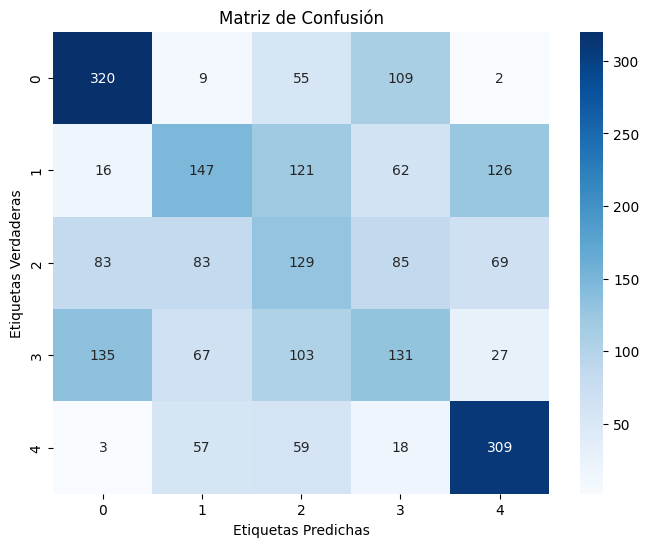

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_100_1e-05_0.2/resultados_100_1e-05_0.2.json
Procesando red con 300 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|▏                                                              | 1/300 [00:03<17:15,  3.46s/it]

1.6093193587134866


Procesando epocas:   1%|▍                                                              | 2/300 [00:06<17:14,  3.47s/it]

1.5341810240465052


Procesando epocas:   1%|▋                                                              | 3/300 [00:10<17:09,  3.47s/it]

1.4087665361516617


Procesando epocas:   1%|▊                                                              | 4/300 [00:13<17:11,  3.48s/it]

1.348515796661377


Procesando epocas:   2%|█                                                              | 5/300 [00:17<17:06,  3.48s/it]

1.306554614796358


Procesando epocas:   2%|█▎                                                             | 6/300 [00:20<17:04,  3.48s/it]

1.2763283007285173


Procesando epocas:   2%|█▍                                                             | 7/300 [00:24<17:01,  3.49s/it]

1.2384108466260573


Procesando epocas:   3%|█▋                                                             | 8/300 [00:27<16:59,  3.49s/it]

1.2155305466231179


Procesando epocas:   3%|█▉                                                             | 9/300 [00:31<16:56,  3.49s/it]

1.1940093615475822


Procesando epocas:   3%|██                                                            | 10/300 [00:34<16:51,  3.49s/it]

1.1854108859510983


Procesando epocas:   4%|██▎                                                           | 11/300 [00:38<16:46,  3.48s/it]

1.1709202128298142


Procesando epocas:   4%|██▍                                                           | 12/300 [00:41<16:46,  3.49s/it]

1.1484629119143765


Procesando epocas:   4%|██▋                                                           | 13/300 [00:45<16:44,  3.50s/it]

1.1314096222905552


Procesando epocas:   5%|██▉                                                           | 14/300 [00:48<16:41,  3.50s/it]

1.1121485457700842


Procesando epocas:   5%|███                                                           | 15/300 [00:52<16:38,  3.50s/it]

1.091715931191164


Procesando epocas:   5%|███▎                                                          | 16/300 [00:55<16:35,  3.51s/it]

1.0779526966459612


Procesando epocas:   6%|███▌                                                          | 17/300 [00:59<16:32,  3.51s/it]

1.0685624645036809


Procesando epocas:   6%|███▋                                                          | 18/300 [01:02<16:27,  3.50s/it]

1.0557044523603776


Procesando epocas:   6%|███▉                                                          | 19/300 [01:06<16:21,  3.49s/it]

1.0527536833987516


Procesando epocas:   7%|████▏                                                         | 20/300 [01:09<16:17,  3.49s/it]

1.0421910906539245


Procesando epocas:   7%|████▎                                                         | 21/300 [01:13<16:14,  3.49s/it]

1.0390179413206437


Procesando epocas:   7%|████▌                                                         | 22/300 [01:16<16:10,  3.49s/it]

1.0348892464357264


Procesando epocas:   8%|████▊                                                         | 23/300 [01:20<16:07,  3.49s/it]

1.0337601258474238


Procesando epocas:   8%|████▉                                                         | 24/300 [01:23<16:04,  3.50s/it]

1.0311471234349643


Procesando epocas:   8%|█████▏                                                        | 25/300 [01:27<15:58,  3.48s/it]

1.0326359286027795


Procesando epocas:   9%|█████▎                                                        | 26/300 [01:30<15:55,  3.49s/it]

1.028370773792267


Procesando epocas:   9%|█████▌                                                        | 27/300 [01:34<15:51,  3.49s/it]

1.030127968157039


Procesando epocas:   9%|█████▊                                                        | 28/300 [01:37<15:51,  3.50s/it]

1.026766212196911


Procesando epocas:  10%|█████▉                                                        | 29/300 [01:41<15:48,  3.50s/it]

1.0260580360889435


Procesando epocas:  10%|██████▏                                                       | 30/300 [01:44<15:43,  3.49s/it]

1.025525362701977


Procesando epocas:  10%|██████▍                                                       | 31/300 [01:48<15:39,  3.49s/it]

1.0281959449543672


Procesando epocas:  11%|██████▌                                                       | 32/300 [01:51<15:36,  3.50s/it]

1.0291601370362675


Procesando epocas:  11%|██████▊                                                       | 33/300 [01:55<15:33,  3.50s/it]

1.0265003204345704


Procesando epocas:  11%|███████                                                       | 34/300 [01:58<15:31,  3.50s/it]

1.028533966401044


Procesando epocas:  12%|███████▏                                                      | 35/300 [02:02<15:27,  3.50s/it]

1.0280444131178015


Procesando epocas:  12%|███████▍                                                      | 36/300 [02:05<15:24,  3.50s/it]

1.0228319069918463


Procesando epocas:  12%|███████▋                                                      | 37/300 [02:09<15:17,  3.49s/it]

1.0221921643790077


Procesando epocas:  13%|███████▊                                                      | 38/300 [02:12<15:12,  3.48s/it]

1.0256256205194136


Procesando epocas:  13%|████████                                                      | 39/300 [02:16<15:13,  3.50s/it]

1.0237133758909562


Procesando epocas:  13%|████████▎                                                     | 40/300 [02:19<15:08,  3.50s/it]

1.024993727838292


Procesando epocas:  14%|████████▍                                                     | 41/300 [02:23<15:05,  3.49s/it]

1.0283068902352277


Procesando epocas:  14%|████████▋                                                     | 42/300 [02:26<15:03,  3.50s/it]

1.0279377067790312


Procesando epocas:  14%|████████▉                                                     | 43/300 [02:30<14:59,  3.50s/it]

1.0237157057313357


Procesando epocas:  15%|█████████                                                     | 44/300 [02:33<15:00,  3.52s/it]

1.0269453486975502


Procesando epocas:  15%|█████████▎                                                    | 45/300 [02:37<14:57,  3.52s/it]

1.024582393730388


Procesando epocas:  15%|█████████▌                                                    | 46/300 [02:40<14:49,  3.50s/it]

1.0213181281791013


Procesando epocas:  16%|█████████▋                                                    | 47/300 [02:44<14:47,  3.51s/it]

1.0186772335978116


Procesando epocas:  16%|█████████▉                                                    | 48/300 [02:47<14:44,  3.51s/it]

1.0206525150467367


Procesando epocas:  16%|██████████▏                                                   | 49/300 [02:51<14:41,  3.51s/it]

1.0179025387062746


Procesando epocas:  17%|██████████▎                                                   | 50/300 [02:54<14:36,  3.51s/it]

1.0151532958535587


Procesando epocas:  17%|██████████▌                                                   | 51/300 [02:58<14:36,  3.52s/it]

1.0156397896654465


Procesando epocas:  17%|██████████▋                                                   | 52/300 [03:01<14:28,  3.50s/it]

1.0152286322677837


Procesando epocas:  18%|██████████▉                                                   | 53/300 [03:05<14:26,  3.51s/it]

1.0129448967821457


Procesando epocas:  18%|███████████▏                                                  | 54/300 [03:08<14:22,  3.51s/it]

1.014453697905821


Procesando epocas:  18%|███████████▎                                                  | 55/300 [03:12<14:17,  3.50s/it]

1.0103985702290255


Procesando epocas:  19%|███████████▌                                                  | 56/300 [03:15<14:15,  3.51s/it]

1.0121875261559206


Procesando epocas:  19%|███████████▊                                                  | 57/300 [03:19<14:15,  3.52s/it]

1.015999548926073


Procesando epocas:  19%|███████████▉                                                  | 58/300 [03:22<14:10,  3.52s/it]

1.016828381313997


Procesando epocas:  20%|████████████▏                                                 | 59/300 [03:26<14:03,  3.50s/it]

1.0177462598856757


Procesando epocas:  20%|████████████▍                                                 | 60/300 [03:29<13:59,  3.50s/it]

1.0188261000549093


Procesando epocas:  20%|████████████▌                                                 | 61/300 [03:33<13:53,  3.49s/it]

1.0170043237069073


Procesando epocas:  21%|████████████▊                                                 | 62/300 [03:36<13:53,  3.50s/it]

1.0143261418623082


Procesando epocas:  21%|█████████████                                                 | 63/300 [03:40<13:50,  3.51s/it]

1.0167087400660795


Procesando epocas:  21%|█████████████▏                                                | 64/300 [03:43<13:46,  3.50s/it]

1.0128525407875286


Procesando epocas:  22%|█████████████▍                                                | 65/300 [03:47<13:45,  3.51s/it]

1.0131021478596856


Procesando epocas:  22%|█████████████▋                                                | 66/300 [03:50<13:40,  3.51s/it]

1.010617043691523


Procesando epocas:  22%|█████████████▊                                                | 67/300 [03:54<13:38,  3.51s/it]

1.00979164908914


Procesando epocas:  23%|██████████████                                                | 68/300 [03:57<13:32,  3.50s/it]

1.0103570513865527


Procesando epocas:  23%|██████████████▎                                               | 69/300 [04:01<13:28,  3.50s/it]

1.0105797525714426


Procesando epocas:  23%|██████████████▍                                               | 70/300 [04:04<13:25,  3.50s/it]

1.009530755702187


Procesando epocas:  24%|██████████████▋                                               | 71/300 [04:08<13:20,  3.50s/it]

1.0067538250895107


Procesando epocas:  24%|██████████████▉                                               | 72/300 [04:11<13:18,  3.50s/it]

1.0104067774379955


Procesando epocas:  24%|███████████████                                               | 73/300 [04:15<13:14,  3.50s/it]

1.0069646519773148


Procesando epocas:  25%|███████████████▎                                              | 74/300 [04:18<13:13,  3.51s/it]

1.0091605246067048


Procesando epocas:  25%|███████████████▌                                              | 75/300 [04:22<13:11,  3.52s/it]

1.0100398544002982


Procesando epocas:  25%|███████████████▋                                              | 76/300 [04:25<13:04,  3.50s/it]

1.0093072772026062


Procesando epocas:  26%|███████████████▉                                              | 77/300 [04:29<13:01,  3.50s/it]

1.0095666562809664


Procesando epocas:  26%|████████████████                                              | 78/300 [04:32<12:57,  3.50s/it]

1.011211266938378


Procesando epocas:  26%|████████████████▎                                             | 79/300 [04:36<12:52,  3.49s/it]

1.0098173853229073


Procesando epocas:  27%|████████████████▌                                             | 80/300 [04:39<12:49,  3.50s/it]

1.0067887060782488


Procesando epocas:  27%|████████████████▋                                             | 81/300 [04:43<12:44,  3.49s/it]

1.0096739229033975


Procesando epocas:  27%|████████████████▉                                             | 82/300 [04:46<12:43,  3.50s/it]

1.0078316264292773


Procesando epocas:  28%|█████████████████▏                                            | 83/300 [04:50<12:38,  3.50s/it]

1.0087534325964311


Procesando epocas:  28%|█████████████████▎                                            | 84/300 [04:53<12:35,  3.50s/it]

1.0064887912834393


Procesando epocas:  28%|█████████████████▌                                            | 85/300 [04:57<12:32,  3.50s/it]

1.0048782864037682


Procesando epocas:  29%|█████████████████▊                                            | 86/300 [05:00<12:27,  3.49s/it]

1.0053435444831849


Procesando epocas:  29%|█████████████████▉                                            | 87/300 [05:04<12:24,  3.50s/it]

1.0041979873881621


Procesando epocas:  29%|██████████████████▏                                           | 88/300 [05:07<12:21,  3.50s/it]

1.0056048000560087


Procesando epocas:  30%|██████████████████▍                                           | 89/300 [05:11<12:19,  3.50s/it]

1.0070097120369181


Procesando epocas:  30%|██████████████████▌                                           | 90/300 [05:14<12:13,  3.49s/it]

1.0041836363427779


Procesando epocas:  30%|██████████████████▊                                           | 91/300 [05:18<12:09,  3.49s/it]

1.0049503638463861


Procesando epocas:  31%|███████████████████                                           | 92/300 [05:21<12:06,  3.49s/it]

1.006811703303281


Procesando epocas:  31%|███████████████████▏                                          | 93/300 [05:25<12:03,  3.50s/it]

1.0035397662835963


Procesando epocas:  31%|███████████████████▍                                          | 94/300 [05:28<11:58,  3.49s/it]

1.0048508801881004


Procesando epocas:  32%|███████████████████▋                                          | 95/300 [05:32<11:55,  3.49s/it]

1.0048256292062647


Procesando epocas:  32%|███████████████████▊                                          | 96/300 [05:35<11:53,  3.50s/it]

1.0025569540612838


Procesando epocas:  32%|████████████████████                                          | 97/300 [05:39<11:49,  3.50s/it]

1.0042885429718915


Procesando epocas:  33%|████████████████████▎                                         | 98/300 [05:42<11:45,  3.49s/it]

1.005014972827014


Procesando epocas:  33%|████████████████████▍                                         | 99/300 [05:46<11:43,  3.50s/it]

1.0071569866993848


Procesando epocas:  33%|████████████████████▎                                        | 100/300 [05:49<11:40,  3.50s/it]

1.0030604323920083


Procesando epocas:  34%|████████████████████▌                                        | 101/300 [05:53<11:36,  3.50s/it]

0.9990166176767911


Procesando epocas:  34%|████████████████████▋                                        | 102/300 [05:56<11:36,  3.52s/it]

1.0000830671366523


Procesando epocas:  34%|████████████████████▉                                        | 103/300 [06:00<11:32,  3.51s/it]

0.9989099958363701


Procesando epocas:  35%|█████████████████████▏                                       | 104/300 [06:03<11:28,  3.51s/it]

0.9988169067046222


Procesando epocas:  35%|█████████████████████▎                                       | 105/300 [06:07<11:24,  3.51s/it]

0.9985825363327475


Procesando epocas:  35%|█████████████████████▌                                       | 106/300 [06:10<11:18,  3.49s/it]

0.9965106648557326


Procesando epocas:  36%|█████████████████████▊                                       | 107/300 [06:14<11:13,  3.49s/it]

0.9977712003623738


Procesando epocas:  36%|█████████████████████▉                                       | 108/300 [06:17<11:09,  3.49s/it]

0.9972513275987962


Procesando epocas:  36%|██████████████████████▏                                      | 109/300 [06:21<11:05,  3.48s/it]

0.9977788108236649


Procesando epocas:  37%|██████████████████████▎                                      | 110/300 [06:24<11:02,  3.49s/it]

1.00076745187535


Procesando epocas:  37%|██████████████████████▌                                      | 111/300 [06:28<11:00,  3.49s/it]

0.9996587125694051


Procesando epocas:  37%|██████████████████████▊                                      | 112/300 [06:31<10:56,  3.49s/it]

1.0019094361978418


Procesando epocas:  38%|██████████████████████▉                                      | 113/300 [06:35<10:54,  3.50s/it]

1.0040018186849706


Procesando epocas:  38%|███████████████████████▏                                     | 114/300 [06:38<10:49,  3.49s/it]

1.0045666859430424


Procesando epocas:  38%|███████████████████████▍                                     | 115/300 [06:42<10:48,  3.50s/it]

1.0036624494720907


Procesando epocas:  39%|███████████████████████▌                                     | 116/300 [06:45<10:44,  3.50s/it]

1.0020709654864144


Procesando epocas:  39%|███████████████████████▊                                     | 117/300 [06:49<10:40,  3.50s/it]

1.0020567897488089


Procesando epocas:  39%|███████████████████████▉                                     | 118/300 [06:52<10:36,  3.50s/it]

1.0002019310698789


Procesando epocas:  40%|████████████████████████▏                                    | 119/300 [06:56<10:32,  3.49s/it]

1.00128214709899


Procesando epocas:  40%|████████████████████████▍                                    | 120/300 [06:59<10:29,  3.50s/it]

1.0012136494412143


Procesando epocas:  40%|████████████████████████▌                                    | 121/300 [07:03<10:25,  3.49s/it]

1.0029174411998076


Procesando epocas:  41%|████████████████████████▊                                    | 122/300 [07:06<10:20,  3.49s/it]

1.003273347195457


Procesando epocas:  41%|█████████████████████████                                    | 123/300 [07:10<10:16,  3.48s/it]

0.9988889347104465


Procesando epocas:  41%|█████████████████████████▏                                   | 124/300 [07:13<10:15,  3.50s/it]

1.0025536067345564


Procesando epocas:  42%|█████████████████████████▍                                   | 125/300 [07:17<10:14,  3.51s/it]

1.0016828922664418


Procesando epocas:  42%|█████████████████████████▌                                   | 126/300 [07:20<10:09,  3.51s/it]

1.0008265898508184


Procesando epocas:  42%|█████████████████████████▊                                   | 127/300 [07:24<10:04,  3.49s/it]

1.0003252131097458


Procesando epocas:  43%|██████████████████████████                                   | 128/300 [07:27<10:00,  3.49s/it]

0.9995042012018316


Procesando epocas:  43%|██████████████████████████▏                                  | 129/300 [07:31<09:56,  3.49s/it]

0.998050366079106


Procesando epocas:  43%|██████████████████████████▍                                  | 130/300 [07:34<09:52,  3.48s/it]

0.9961277022081263


Procesando epocas:  44%|██████████████████████████▋                                  | 131/300 [07:38<09:47,  3.48s/it]

0.996492280328975


Procesando epocas:  44%|██████████████████████████▊                                  | 132/300 [07:41<09:46,  3.49s/it]

0.9956980708767386


Procesando epocas:  44%|███████████████████████████                                  | 133/300 [07:45<09:44,  3.50s/it]

0.994983788097606


Procesando epocas:  45%|███████████████████████████▏                                 | 134/300 [07:48<09:40,  3.50s/it]

0.9954326016061447


Procesando epocas:  45%|███████████████████████████▍                                 | 135/300 [07:52<09:37,  3.50s/it]

0.994423625048469


Procesando epocas:  45%|███████████████████████████▋                                 | 136/300 [07:55<09:35,  3.51s/it]

0.9940363813849057


Procesando epocas:  46%|███████████████████████████▊                                 | 137/300 [07:59<09:31,  3.51s/it]

0.9955868503626655


Procesando epocas:  46%|████████████████████████████                                 | 138/300 [08:02<09:27,  3.50s/it]

0.995217605899362


Procesando epocas:  46%|████████████████████████████▎                                | 139/300 [08:06<09:23,  3.50s/it]

0.9931003458359662


Procesando epocas:  47%|████████████████████████████▍                                | 140/300 [08:09<09:21,  3.51s/it]

0.9974156754858353


Procesando epocas:  47%|████████████████████████████▋                                | 141/300 [08:13<09:15,  3.49s/it]

0.996947293772417


Procesando epocas:  47%|████████████████████████████▊                                | 142/300 [08:16<09:11,  3.49s/it]

0.9955354185665355


Procesando epocas:  48%|█████████████████████████████                                | 143/300 [08:20<09:08,  3.49s/it]

0.9931819968363818


Procesando epocas:  48%|█████████████████████████████▎                               | 144/300 [08:23<09:05,  3.50s/it]

0.995578359856325


Procesando epocas:  48%|█████████████████████████████▍                               | 145/300 [08:27<09:02,  3.50s/it]

0.9941519021987915


Procesando epocas:  49%|█████████████████████████████▋                               | 146/300 [08:30<09:00,  3.51s/it]

0.992061768209233


Procesando epocas:  49%|█████████████████████████████▉                               | 147/300 [08:34<08:57,  3.51s/it]

0.9917929610785317


Procesando epocas:  49%|██████████████████████████████                               | 148/300 [08:37<08:51,  3.50s/it]

0.9919113460709067


Procesando epocas:  50%|██████████████████████████████▎                              | 149/300 [08:41<08:48,  3.50s/it]

0.9933169059893664


Procesando epocas:  50%|██████████████████████████████▌                              | 150/300 [08:44<08:44,  3.50s/it]

0.9931510616751278


Procesando epocas:  50%|██████████████████████████████▋                              | 151/300 [08:48<08:42,  3.51s/it]

0.9956610290443196


Procesando epocas:  51%|██████████████████████████████▉                              | 152/300 [08:51<08:38,  3.50s/it]

0.9951318853041705


Procesando epocas:  51%|███████████████████████████████                              | 153/300 [08:55<08:35,  3.50s/it]

0.9958075632067288


Procesando epocas:  51%|███████████████████████████████▎                             | 154/300 [08:58<08:30,  3.50s/it]

0.9957592992221608


Procesando epocas:  52%|███████████████████████████████▌                             | 155/300 [09:02<08:26,  3.49s/it]

0.9960073635858648


Procesando epocas:  52%|███████████████████████████████▋                             | 156/300 [09:05<08:24,  3.50s/it]

0.9936870799345129


Procesando epocas:  52%|███████████████████████████████▉                             | 157/300 [09:09<08:19,  3.49s/it]

0.9953376216046951


Procesando epocas:  53%|████████████████████████████████▏                            | 158/300 [09:12<08:16,  3.50s/it]

0.9953928095452925


Procesando epocas:  53%|████████████████████████████████▎                            | 159/300 [09:16<08:13,  3.50s/it]

0.9951941654962652


Procesando epocas:  53%|████████████████████████████████▌                            | 160/300 [09:19<08:10,  3.50s/it]

0.9964386073982014


Procesando epocas:  54%|████████████████████████████████▋                            | 161/300 [09:23<08:08,  3.51s/it]

0.994036743220161


Procesando epocas:  54%|████████████████████████████████▉                            | 162/300 [09:26<08:04,  3.51s/it]

0.9948329480255351


Procesando epocas:  54%|█████████████████████████████████▏                           | 163/300 [09:30<07:59,  3.50s/it]

0.9947056395166061


Procesando epocas:  55%|█████████████████████████████████▎                           | 164/300 [09:33<07:55,  3.49s/it]

0.9946921320522533


Procesando epocas:  55%|█████████████████████████████████▌                           | 165/300 [09:37<07:51,  3.49s/it]

0.9935296980773701


Procesando epocas:  55%|█████████████████████████████████▊                           | 166/300 [09:40<07:48,  3.50s/it]

0.9943636000156403


Procesando epocas:  56%|█████████████████████████████████▉                           | 167/300 [09:43<07:28,  3.37s/it]

0.9907768915681278


Procesando epocas:  56%|██████████████████████████████████▏                          | 168/300 [09:45<06:35,  2.99s/it]

0.9924717377213871


Procesando epocas:  56%|██████████████████████████████████▎                          | 169/300 [09:47<05:46,  2.64s/it]

0.9908870202653548


Procesando epocas:  57%|██████████████████████████████████▌                          | 170/300 [09:49<05:10,  2.39s/it]

0.9896988093852996


Procesando epocas:  57%|██████████████████████████████████▊                          | 171/300 [09:51<04:45,  2.21s/it]

0.989775248485453


Procesando epocas:  57%|██████████████████████████████████▉                          | 172/300 [09:53<04:27,  2.09s/it]

0.9888993564774008


Procesando epocas:  58%|███████████████████████████████████▏                         | 173/300 [09:54<04:13,  2.00s/it]

0.9891851204283097


Procesando epocas:  58%|███████████████████████████████████▍                         | 174/300 [09:56<04:01,  1.91s/it]

0.9904934013591093


Procesando epocas:  58%|███████████████████████████████████▌                         | 175/300 [09:58<03:52,  1.86s/it]

0.9900076859137591


Procesando epocas:  59%|███████████████████████████████████▊                         | 176/300 [10:00<04:12,  2.03s/it]

0.9938075041069704


Procesando epocas:  59%|███████████████████████████████████▉                         | 177/300 [10:03<04:29,  2.19s/it]

0.9896419637343463


Procesando epocas:  59%|████████████████████████████████████▏                        | 178/300 [10:06<05:15,  2.59s/it]

0.9889841486425961


Procesando epocas:  60%|████████████████████████████████████▍                        | 179/300 [10:10<05:45,  2.86s/it]

0.9888024950728697


Procesando epocas:  60%|████████████████████████████████████▌                        | 180/300 [10:13<06:06,  3.05s/it]

0.9891268204240238


Procesando epocas:  60%|████████████████████████████████████▊                        | 181/300 [10:17<06:19,  3.19s/it]

0.9893570770235622


Procesando epocas:  61%|█████████████████████████████████████                        | 182/300 [10:20<06:26,  3.28s/it]

0.9889130122521345


Procesando epocas:  61%|█████████████████████████████████████▏                       | 183/300 [10:24<06:32,  3.35s/it]

0.9904454904444078


Procesando epocas:  61%|█████████████████████████████████████▍                       | 184/300 [10:27<06:34,  3.40s/it]

0.9891535534578211


Procesando epocas:  62%|█████████████████████████████████████▌                       | 185/300 [10:31<06:33,  3.42s/it]

0.989001184351304


Procesando epocas:  62%|█████████████████████████████████████▊                       | 186/300 [10:34<06:34,  3.46s/it]

0.9890942976755255


Procesando epocas:  62%|██████████████████████████████████████                       | 187/300 [10:38<06:32,  3.47s/it]

0.9884479529717389


Procesando epocas:  63%|██████████████████████████████████████▏                      | 188/300 [10:41<06:29,  3.48s/it]

0.9869928643983953


Procesando epocas:  63%|██████████████████████████████████████▍                      | 189/300 [10:45<06:27,  3.49s/it]

0.9890440225601196


Procesando epocas:  63%|██████████████████████████████████████▋                      | 190/300 [10:49<06:25,  3.50s/it]

0.9882717174642226


Procesando epocas:  64%|██████████████████████████████████████▊                      | 191/300 [10:52<06:21,  3.50s/it]

0.987724582938587


Procesando epocas:  64%|███████████████████████████████████████                      | 192/300 [10:56<06:17,  3.50s/it]

0.9880671476616579


Procesando epocas:  64%|███████████████████████████████████████▏                     | 193/300 [10:59<06:13,  3.49s/it]

0.9886615037918091


Procesando epocas:  65%|███████████████████████████████████████▍                     | 194/300 [11:02<06:09,  3.49s/it]

0.9905015559757457


Procesando epocas:  65%|███████████████████████████████████████▋                     | 195/300 [11:06<06:06,  3.49s/it]

0.989048680487801


Procesando epocas:  65%|███████████████████████████████████████▊                     | 196/300 [11:10<06:04,  3.51s/it]

0.9891578008146847


Procesando epocas:  66%|████████████████████████████████████████                     | 197/300 [11:13<06:01,  3.51s/it]

0.9901064031264362


Procesando epocas:  66%|████████████████████████████████████████▎                    | 198/300 [11:16<05:56,  3.49s/it]

0.9894320680814631


Procesando epocas:  66%|████████████████████████████████████████▍                    | 199/300 [11:20<05:52,  3.49s/it]

0.98824022973285


Procesando epocas:  67%|████████████████████████████████████████▋                    | 200/300 [11:23<05:47,  3.48s/it]

0.9905945511425243


Procesando epocas:  67%|████████████████████████████████████████▊                    | 201/300 [11:27<05:45,  3.49s/it]

0.990461476059521


Procesando epocas:  67%|█████████████████████████████████████████                    | 202/300 [11:30<05:41,  3.48s/it]

0.9889375865459442


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 203/300 [11:34<05:38,  3.49s/it]

0.9932313035516178


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 204/300 [11:37<05:35,  3.49s/it]

0.9905526185736937


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 205/300 [11:41<05:32,  3.50s/it]

0.9886670147671419


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 206/300 [11:44<05:29,  3.50s/it]

0.9892959117889404


Procesando epocas:  69%|██████████████████████████████████████████                   | 207/300 [11:48<05:24,  3.49s/it]

0.9885972015997943


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 208/300 [11:51<05:21,  3.49s/it]

0.9901198734255398


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 209/300 [11:55<05:17,  3.49s/it]

0.9883695206221412


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 210/300 [11:58<05:13,  3.49s/it]

0.9858545468134039


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 211/300 [12:02<05:10,  3.49s/it]

0.986047622386147


Procesando epocas:  71%|███████████████████████████████████████████                  | 212/300 [12:05<05:07,  3.50s/it]

0.9859211809494917


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 213/300 [12:09<05:03,  3.49s/it]

0.98691066328217


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 214/300 [12:12<04:59,  3.49s/it]

0.9858042250661289


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 215/300 [12:16<04:56,  3.49s/it]

0.9850039531202878


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 216/300 [12:19<04:53,  3.49s/it]

0.9862185765715207


Procesando epocas:  72%|████████████████████████████████████████████                 | 217/300 [12:23<04:49,  3.49s/it]

0.9856444148456349


Procesando epocas:  73%|████████████████████████████████████████████▎                | 218/300 [12:26<04:45,  3.48s/it]

0.9851214766502381


Procesando epocas:  73%|████████████████████████████████████████████▌                | 219/300 [12:30<04:41,  3.48s/it]

0.98684941740597


Procesando epocas:  73%|████████████████████████████████████████████▋                | 220/300 [12:33<04:39,  3.49s/it]

0.9862765063257778


Procesando epocas:  74%|████████████████████████████████████████████▉                | 221/300 [12:37<04:36,  3.50s/it]

0.9885761289035573


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 222/300 [12:40<04:32,  3.49s/it]

0.9903934292933521


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 223/300 [12:44<04:28,  3.48s/it]

0.9926047942217658


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 224/300 [12:47<04:24,  3.48s/it]

0.9895953848081477


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 225/300 [12:51<04:21,  3.49s/it]

0.9906395326642429


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 226/300 [12:54<04:18,  3.49s/it]

0.990420983468785


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 227/300 [12:58<04:14,  3.49s/it]

0.9873445009484011


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 228/300 [13:01<04:11,  3.49s/it]

0.9895155405296999


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 229/300 [13:05<04:08,  3.49s/it]

0.9872386609806734


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 230/300 [13:08<04:05,  3.50s/it]

0.9858790173250086


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 231/300 [13:12<04:01,  3.50s/it]

0.9881192841950585


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 232/300 [13:15<03:58,  3.51s/it]

0.9873539318056668


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 233/300 [13:19<03:55,  3.51s/it]

0.9856995046138763


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 234/300 [13:22<03:50,  3.50s/it]

0.9853133615325479


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 235/300 [13:26<03:46,  3.49s/it]

0.9863474989638609


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 236/300 [13:29<03:43,  3.48s/it]

0.9852707235252156


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 237/300 [13:33<03:40,  3.50s/it]

0.9846173510831945


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 238/300 [13:36<03:37,  3.50s/it]

0.9857536333448746


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 239/300 [13:40<03:34,  3.52s/it]

0.9867290030507481


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 240/300 [13:43<03:30,  3.50s/it]

0.9855831538929659


Procesando epocas:  80%|█████████████████████████████████████████████████            | 241/300 [13:47<03:26,  3.50s/it]

0.9856842412668116


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 242/300 [13:50<03:22,  3.50s/it]

0.9858554507003111


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 243/300 [13:54<03:19,  3.51s/it]

0.9859108812668744


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 244/300 [13:57<03:16,  3.51s/it]

0.9842134254820206


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 245/300 [14:01<03:12,  3.50s/it]

0.9838216841220856


Procesando epocas:  82%|██████████████████████████████████████████████████           | 246/300 [14:04<03:08,  3.49s/it]

0.9848229418782627


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 247/300 [14:08<03:06,  3.52s/it]

0.9859111631617826


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 248/300 [14:11<03:02,  3.50s/it]

0.9876598000526429


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 249/300 [14:15<02:57,  3.48s/it]

0.9842891538844389


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 250/300 [14:18<02:53,  3.46s/it]

0.9874879749382244


Procesando epocas:  84%|███████████████████████████████████████████████████          | 251/300 [14:21<02:49,  3.45s/it]

0.9852652970482322


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 252/300 [14:25<02:45,  3.44s/it]

0.9851563905968386


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 253/300 [14:28<02:40,  3.43s/it]

0.983001717749764


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 254/300 [14:32<02:37,  3.43s/it]

0.9855750350391164


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 255/300 [14:35<02:33,  3.42s/it]

0.9826069197233985


Procesando epocas:  85%|████████████████████████████████████████████████████         | 256/300 [14:39<02:30,  3.42s/it]

0.9838174416738398


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 257/300 [14:42<02:27,  3.42s/it]

0.9863564214285683


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 258/300 [14:45<02:23,  3.42s/it]

0.985534332780277


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 259/300 [14:49<02:20,  3.43s/it]

0.985351397710688


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 260/300 [14:52<02:17,  3.44s/it]

0.9836819631211898


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 261/300 [14:56<02:13,  3.43s/it]

0.9833132004036623


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 262/300 [14:59<02:10,  3.43s/it]

0.9830258548259735


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 263/300 [15:03<02:07,  3.43s/it]

0.9851653505774105


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 264/300 [15:06<02:03,  3.44s/it]

0.9832065270227545


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 265/300 [15:10<02:00,  3.45s/it]

0.983549397833207


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 266/300 [15:13<01:56,  3.44s/it]

0.9831319879083072


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 267/300 [15:16<01:53,  3.44s/it]

0.9840514610795413


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 268/300 [15:20<01:49,  3.43s/it]

0.9821152683566599


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 269/300 [15:23<01:46,  3.43s/it]

0.9830052568632014


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 270/300 [15:27<01:42,  3.42s/it]

0.9837045210249283


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 271/300 [15:30<01:39,  3.41s/it]

0.9836354409947115


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 272/300 [15:33<01:35,  3.41s/it]

0.9834588850245757


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 273/300 [15:37<01:32,  3.42s/it]

0.9831295823349672


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 274/300 [15:40<01:28,  3.41s/it]

0.984107030840481


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 275/300 [15:44<01:25,  3.41s/it]

0.982715090232737


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 276/300 [15:47<01:22,  3.42s/it]

0.9811916642329273


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 277/300 [15:51<01:18,  3.42s/it]

0.9801397555014666


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 278/300 [15:54<01:15,  3.42s/it]

0.9842358550604652


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 279/300 [15:57<01:11,  3.42s/it]

0.984112484665478


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 280/300 [16:01<01:08,  3.42s/it]

0.9816545872127309


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 281/300 [16:04<01:05,  3.43s/it]

0.9803214830510757


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 282/300 [16:08<01:01,  3.43s/it]

0.9816344103392433


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 283/300 [16:11<00:58,  3.43s/it]

0.9831953651764813


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 284/300 [16:15<00:54,  3.43s/it]

0.9806004440083224


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 285/300 [16:18<00:51,  3.43s/it]

0.9813869230887469


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 286/300 [16:21<00:48,  3.43s/it]

0.9828818685868207


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 287/300 [16:25<00:44,  3.43s/it]

0.9835022971910589


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 288/300 [16:28<00:41,  3.42s/it]

0.9834598204668831


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 289/300 [16:32<00:37,  3.41s/it]

0.9811913367579965


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 290/300 [16:35<00:34,  3.41s/it]

0.9822425021844752


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 291/300 [16:38<00:30,  3.41s/it]

0.9815314987126519


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 292/300 [16:42<00:27,  3.41s/it]

0.9794241719386156


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 293/300 [16:45<00:23,  3.41s/it]

0.9794871239101186


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 294/300 [16:49<00:20,  3.41s/it]

0.9790291211184333


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 295/300 [16:52<00:17,  3.41s/it]

0.9807090780314277


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 296/300 [16:56<00:13,  3.42s/it]

0.9834124856135424


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 297/300 [16:59<00:10,  3.42s/it]

0.9818116805132697


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 298/300 [17:02<00:06,  3.42s/it]

0.9815642153515535


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 299/300 [17:06<00:03,  3.42s/it]

0.9807947912636925


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 300/300 [17:09<00:00,  3.43s/it]

0.9819266382385703
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_300_0.0001_0.2/funcion_de_perdida_300_0.0001.png


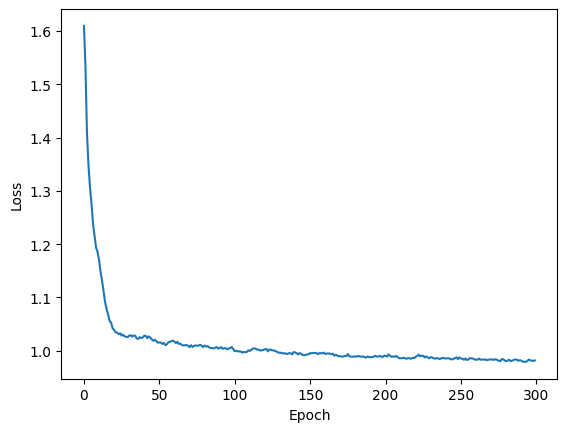

Test accuracy: 463.6331182795699
Accuracy: 0.44688172043010754
Precision: 0.49474555873938464
Recall: 0.44614395512676897
F1-score: 0.46139997394295273


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.51      0.61       495
           1       0.43      0.44      0.44       472
           2       0.28      0.37      0.32       449
           3       0.31      0.37      0.33       463
           4       0.73      0.53      0.62       446

    accuracy                           0.45      2325
   macro avg       0.49      0.45      0.46      2325
weighted avg       0.50      0.45      0.46      2325

                    0           1           2           3           4  \
precision    0.738372    0.425963    0.276206    0.305357    0.727829   
recall       0.513131    0.444915    0.369710    0.369330    0.533632   
f1-score     0.605483    0.435233    0.316190    0.334311    0.615783   
support    495.000000  472.000000  449.000

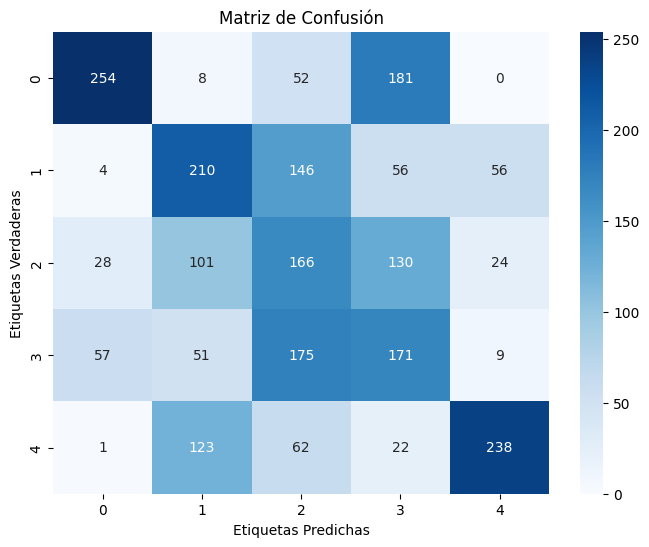

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_300_0.0001_0.2/resultados_300_0.0001_0.2.json
Procesando red con 300 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|▏                                                              | 1/300 [00:03<17:01,  3.42s/it]

1.6094991340356715


Procesando epocas:   1%|▍                                                              | 2/300 [00:06<16:55,  3.41s/it]

1.6094643242218916


Procesando epocas:   1%|▋                                                              | 3/300 [00:10<16:48,  3.40s/it]

1.6094357210047106


Procesando epocas:   1%|▊                                                              | 4/300 [00:13<16:46,  3.40s/it]

1.6094016741303836


Procesando epocas:   2%|█                                                              | 5/300 [00:17<16:43,  3.40s/it]

1.6092872332124148


Procesando epocas:   2%|█▎                                                             | 6/300 [00:20<16:44,  3.42s/it]

1.6088984307120828


Procesando epocas:   2%|█▍                                                             | 7/300 [00:23<16:41,  3.42s/it]

1.6076626728562748


Procesando epocas:   3%|█▋                                                             | 8/300 [00:27<16:35,  3.41s/it]

1.6049167464761174


Procesando epocas:   3%|█▉                                                             | 9/300 [00:30<16:32,  3.41s/it]

1.5979390417828279


Procesando epocas:   3%|██                                                            | 10/300 [00:34<16:30,  3.41s/it]

1.571726436474744


Procesando epocas:   4%|██▎                                                           | 11/300 [00:37<16:26,  3.41s/it]

1.512630917745478


Procesando epocas:   4%|██▍                                                           | 12/300 [00:40<16:23,  3.42s/it]

1.4596235226182377


Procesando epocas:   4%|██▋                                                           | 13/300 [00:44<16:24,  3.43s/it]

1.4321652033749748


Procesando epocas:   5%|██▉                                                           | 14/300 [00:47<16:20,  3.43s/it]

1.4062236750827115


Procesando epocas:   5%|███                                                           | 15/300 [00:51<16:12,  3.41s/it]

1.386341673486373


Procesando epocas:   5%|███▎                                                          | 16/300 [00:54<16:10,  3.42s/it]

1.3700002733398886


Procesando epocas:   6%|███▌                                                          | 17/300 [00:58<16:05,  3.41s/it]

1.3586763325859519


Procesando epocas:   6%|███▋                                                          | 18/300 [01:01<16:04,  3.42s/it]

1.3439115103553323


Procesando epocas:   6%|███▉                                                          | 19/300 [01:04<15:59,  3.42s/it]

1.3291688947116627


Procesando epocas:   7%|████▏                                                         | 20/300 [01:08<15:58,  3.42s/it]

1.3206831490292268


Procesando epocas:   7%|████▎                                                         | 21/300 [01:11<15:53,  3.42s/it]

1.314765903528999


Procesando epocas:   7%|████▌                                                         | 22/300 [01:15<15:53,  3.43s/it]

1.3029781299478866


Procesando epocas:   8%|████▊                                                         | 23/300 [01:18<15:48,  3.42s/it]

1.2963029019972858


Procesando epocas:   8%|████▉                                                         | 24/300 [01:22<15:45,  3.42s/it]

1.2805215835571289


Procesando epocas:   8%|█████▏                                                        | 25/300 [01:25<15:38,  3.41s/it]

1.2754827709758982


Procesando epocas:   9%|█████▎                                                        | 26/300 [01:28<15:37,  3.42s/it]

1.269741934187272


Procesando epocas:   9%|█████▌                                                        | 27/300 [01:32<15:33,  3.42s/it]

1.2567815415999468


Procesando epocas:   9%|█████▊                                                        | 28/300 [01:35<15:30,  3.42s/it]

1.2488675054381875


Procesando epocas:  10%|█████▉                                                        | 29/300 [01:39<15:24,  3.41s/it]

1.2404623129788568


Procesando epocas:  10%|██████▏                                                       | 30/300 [01:42<15:22,  3.42s/it]

1.2359203822472515


Procesando epocas:  10%|██████▍                                                       | 31/300 [01:45<15:18,  3.42s/it]

1.2250226175083834


Procesando epocas:  11%|██████▌                                                       | 32/300 [01:49<15:17,  3.42s/it]

1.224996639700497


Procesando epocas:  11%|██████▊                                                       | 33/300 [01:52<15:14,  3.42s/it]

1.215744978540084


Procesando epocas:  11%|███████                                                       | 34/300 [01:56<15:09,  3.42s/it]

1.2117142403826995


Procesando epocas:  12%|███████▏                                                      | 35/300 [01:59<15:04,  3.41s/it]

1.2051881940925822


Procesando epocas:  12%|███████▍                                                      | 36/300 [02:02<15:01,  3.41s/it]

1.2021976709365845


Procesando epocas:  12%|███████▋                                                      | 37/300 [02:06<14:59,  3.42s/it]

1.1967599952922148


Procesando epocas:  13%|███████▊                                                      | 38/300 [02:09<14:51,  3.40s/it]

1.1935490955324735


Procesando epocas:  13%|████████                                                      | 39/300 [02:13<15:00,  3.45s/it]

1.1903098583221436


Procesando epocas:  13%|████████▎                                                     | 40/300 [02:16<15:04,  3.48s/it]

1.1852077052873724


Procesando epocas:  14%|████████▍                                                     | 41/300 [02:20<15:09,  3.51s/it]

1.1814226560732897


Procesando epocas:  14%|████████▋                                                     | 42/300 [02:24<15:08,  3.52s/it]

1.1783233698676614


Procesando epocas:  14%|████████▉                                                     | 43/300 [02:27<15:00,  3.51s/it]

1.1757152704631582


Procesando epocas:  15%|█████████                                                     | 44/300 [02:30<14:53,  3.49s/it]

1.1718968580750857


Procesando epocas:  15%|█████████▎                                                    | 45/300 [02:34<14:46,  3.48s/it]

1.1700265695067014


Procesando epocas:  15%|█████████▌                                                    | 46/300 [02:37<14:44,  3.48s/it]

1.1681081105681026


Procesando epocas:  16%|█████████▋                                                    | 47/300 [02:41<14:36,  3.46s/it]

1.168566360543756


Procesando epocas:  16%|█████████▉                                                    | 48/300 [02:44<14:32,  3.46s/it]

1.1659208031261667


Procesando epocas:  16%|██████████▏                                                   | 49/300 [02:48<14:27,  3.45s/it]

1.165900389587178


Procesando epocas:  17%|██████████▎                                                   | 50/300 [02:51<14:27,  3.47s/it]

1.1634415163713343


Procesando epocas:  17%|██████████▌                                                   | 51/300 [02:55<14:25,  3.47s/it]

1.1615281466175529


Procesando epocas:  17%|██████████▋                                                   | 52/300 [02:58<14:26,  3.49s/it]

1.1600808816797592


Procesando epocas:  18%|██████████▉                                                   | 53/300 [03:02<14:19,  3.48s/it]

1.1572415520163144


Procesando epocas:  18%|███████████▏                                                  | 54/300 [03:05<14:17,  3.48s/it]

1.1561810949269462


Procesando epocas:  18%|███████████▎                                                  | 55/300 [03:09<14:14,  3.49s/it]

1.1568621674004722


Procesando epocas:  19%|███████████▌                                                  | 56/300 [03:12<14:09,  3.48s/it]

1.1562506998286528


Procesando epocas:  19%|███████████▊                                                  | 57/300 [03:16<14:04,  3.47s/it]

1.1511701208703657


Procesando epocas:  19%|███████████▉                                                  | 58/300 [03:19<14:01,  3.48s/it]

1.1523876523270327


Procesando epocas:  20%|████████████▏                                                 | 59/300 [03:23<13:55,  3.47s/it]

1.1520309146712808


Procesando epocas:  20%|████████████▍                                                 | 60/300 [03:26<13:55,  3.48s/it]

1.150389354018604


Procesando epocas:  20%|████████████▌                                                 | 61/300 [03:29<13:49,  3.47s/it]

1.1494186275145586


Procesando epocas:  21%|████████████▊                                                 | 62/300 [03:33<13:43,  3.46s/it]

1.145942491643569


Procesando epocas:  21%|█████████████                                                 | 63/300 [03:36<13:42,  3.47s/it]

1.1494010897243725


Procesando epocas:  21%|█████████████▏                                                | 64/300 [03:40<13:38,  3.47s/it]

1.1478742624030394


Procesando epocas:  22%|█████████████▍                                                | 65/300 [03:43<13:37,  3.48s/it]

1.1472566394244923


Procesando epocas:  22%|█████████████▋                                                | 66/300 [03:47<13:31,  3.47s/it]

1.1476460386725034


Procesando epocas:  22%|█████████████▊                                                | 67/300 [03:50<13:27,  3.47s/it]

1.14676835361649


Procesando epocas:  23%|██████████████                                                | 68/300 [03:54<13:26,  3.48s/it]

1.144278243008782


Procesando epocas:  23%|██████████████▎                                               | 69/300 [03:57<13:23,  3.48s/it]

1.1439555329435012


Procesando epocas:  23%|██████████████▍                                               | 70/300 [04:01<13:19,  3.48s/it]

1.140534693703932


Procesando epocas:  24%|██████████████▋                                               | 71/300 [04:04<13:14,  3.47s/it]

1.1433883575832142


Procesando epocas:  24%|██████████████▉                                               | 72/300 [04:08<13:10,  3.47s/it]

1.1400642012848574


Procesando epocas:  24%|███████████████                                               | 73/300 [04:11<13:10,  3.48s/it]

1.1373959934010225


Procesando epocas:  25%|███████████████▎                                              | 74/300 [04:15<13:07,  3.48s/it]

1.1385169099358952


Procesando epocas:  25%|███████████████▌                                              | 75/300 [04:18<13:03,  3.48s/it]

1.1414603871457718


Procesando epocas:  25%|███████████████▋                                              | 76/300 [04:22<13:00,  3.49s/it]

1.136808522308574


Procesando epocas:  26%|███████████████▉                                              | 77/300 [04:25<12:56,  3.48s/it]

1.1352176522507387


Procesando epocas:  26%|████████████████                                              | 78/300 [04:29<12:59,  3.51s/it]

1.1342249386450824


Procesando epocas:  26%|████████████████▎                                             | 79/300 [04:32<12:59,  3.53s/it]

1.1337594747543336


Procesando epocas:  27%|████████████████▌                                             | 80/300 [04:36<12:57,  3.53s/it]

1.132330712851356


Procesando epocas:  27%|████████████████▋                                             | 81/300 [04:39<12:52,  3.53s/it]

1.1293095532585593


Procesando epocas:  27%|████████████████▉                                             | 82/300 [04:43<12:44,  3.51s/it]

1.129288545776816


Procesando epocas:  28%|█████████████████▏                                            | 83/300 [04:46<12:39,  3.50s/it]

1.13239007451955


Procesando epocas:  28%|█████████████████▎                                            | 84/300 [04:50<12:34,  3.49s/it]

1.1269960087888382


Procesando epocas:  28%|█████████████████▌                                            | 85/300 [04:53<12:31,  3.50s/it]

1.127854424013811


Procesando epocas:  29%|█████████████████▊                                            | 86/300 [04:57<12:32,  3.51s/it]

1.1216618671136744


Procesando epocas:  29%|█████████████████▉                                            | 87/300 [05:00<12:27,  3.51s/it]

1.12033393312903


Procesando epocas:  29%|██████████████████▏                                           | 88/300 [05:04<12:27,  3.53s/it]

1.120932521539576


Procesando epocas:  30%|██████████████████▍                                           | 89/300 [05:07<12:21,  3.51s/it]

1.1163245474590975


Procesando epocas:  30%|██████████████████▌                                           | 90/300 [05:11<12:15,  3.50s/it]

1.1153506180819344


Procesando epocas:  30%|██████████████████▊                                           | 91/300 [05:14<12:11,  3.50s/it]

1.1146680116653442


Procesando epocas:  31%|███████████████████                                           | 92/300 [05:18<12:07,  3.50s/it]

1.1143493378863616


Procesando epocas:  31%|███████████████████▏                                          | 93/300 [05:21<12:06,  3.51s/it]

1.1107971268541672


Procesando epocas:  31%|███████████████████▍                                          | 94/300 [05:25<12:07,  3.53s/it]

1.1069318424252903


Procesando epocas:  32%|███████████████████▋                                          | 95/300 [05:28<12:03,  3.53s/it]

1.10231893658638


Procesando epocas:  32%|███████████████████▊                                          | 96/300 [05:32<11:58,  3.52s/it]

1.1012104378027074


Procesando epocas:  32%|████████████████████                                          | 97/300 [05:35<11:51,  3.51s/it]

1.0998190290787642


Procesando epocas:  33%|████████████████████▎                                         | 98/300 [05:39<11:46,  3.50s/it]

1.0969636892571168


Procesando epocas:  33%|████████████████████▍                                         | 99/300 [05:42<11:44,  3.50s/it]

1.1000749661641962


Procesando epocas:  33%|████████████████████▎                                        | 100/300 [05:46<11:39,  3.50s/it]

1.0950950289473813


Procesando epocas:  34%|████████████████████▌                                        | 101/300 [05:49<11:34,  3.49s/it]

1.0908984247375937


Procesando epocas:  34%|████████████████████▋                                        | 102/300 [05:53<11:31,  3.49s/it]

1.0903091283405528


Procesando epocas:  34%|████████████████████▉                                        | 103/300 [05:56<11:27,  3.49s/it]

1.0884126926169675


Procesando epocas:  35%|█████████████████████▏                                       | 104/300 [06:00<11:24,  3.49s/it]

1.0841988924671622


Procesando epocas:  35%|█████████████████████▎                                       | 105/300 [06:03<11:20,  3.49s/it]

1.0832851413418265


Procesando epocas:  35%|█████████████████████▌                                       | 106/300 [06:07<11:19,  3.50s/it]

1.0781894291148466


Procesando epocas:  36%|█████████████████████▊                                       | 107/300 [06:10<11:16,  3.50s/it]

1.078239405856413


Procesando epocas:  36%|█████████████████████▉                                       | 108/300 [06:14<11:11,  3.50s/it]

1.074386090741438


Procesando epocas:  36%|██████████████████████▏                                      | 109/300 [06:17<11:05,  3.48s/it]

1.0731412480859195


Procesando epocas:  37%|██████████████████████▎                                      | 110/300 [06:21<11:01,  3.48s/it]

1.073933920439552


Procesando epocas:  37%|██████████████████████▌                                      | 111/300 [06:24<10:58,  3.48s/it]

1.070026723426931


Procesando epocas:  37%|██████████████████████▊                                      | 112/300 [06:28<10:53,  3.48s/it]

1.0663849876207463


Procesando epocas:  38%|██████████████████████▉                                      | 113/300 [06:31<10:50,  3.48s/it]

1.0685082277830908


Procesando epocas:  38%|███████████████████████▏                                     | 114/300 [06:35<10:46,  3.47s/it]

1.0634601743782268


Procesando epocas:  38%|███████████████████████▍                                     | 115/300 [06:38<10:42,  3.47s/it]

1.0621772766113282


Procesando epocas:  39%|███████████████████████▌                                     | 116/300 [06:42<10:40,  3.48s/it]

1.0618986841510325


Procesando epocas:  39%|███████████████████████▊                                     | 117/300 [06:45<10:38,  3.49s/it]

1.0589890714953927


Procesando epocas:  39%|███████████████████████▉                                     | 118/300 [06:49<10:34,  3.49s/it]

1.0591861735371981


Procesando epocas:  40%|████████████████████████▏                                    | 119/300 [06:52<10:34,  3.50s/it]

1.0538817328565262


Procesando epocas:  40%|████████████████████████▍                                    | 120/300 [06:56<10:32,  3.51s/it]

1.055371325156268


Procesando epocas:  40%|████████████████████████▌                                    | 121/300 [06:59<10:29,  3.52s/it]

1.0526221184169544


Procesando epocas:  41%|████████████████████████▊                                    | 122/300 [07:03<10:23,  3.50s/it]

1.0511382881332847


Procesando epocas:  41%|█████████████████████████                                    | 123/300 [07:06<10:17,  3.49s/it]

1.052317668059293


Procesando epocas:  41%|█████████████████████████▏                                   | 124/300 [07:10<10:19,  3.52s/it]

1.048315944741754


Procesando epocas:  42%|█████████████████████████▍                                   | 125/300 [07:13<10:17,  3.53s/it]

1.0495116198764127


Procesando epocas:  42%|█████████████████████████▌                                   | 126/300 [07:17<10:13,  3.52s/it]

1.0467309769462136


Procesando epocas:  42%|█████████████████████████▊                                   | 127/300 [07:20<10:11,  3.53s/it]

1.0456281763665816


Procesando epocas:  43%|██████████████████████████                                   | 128/300 [07:24<10:05,  3.52s/it]

1.0486402427448946


Procesando epocas:  43%|██████████████████████████▏                                  | 129/300 [07:27<10:04,  3.54s/it]

1.0424669023822335


Procesando epocas:  43%|██████████████████████████▍                                  | 130/300 [07:31<10:01,  3.54s/it]

1.042676482481115


Procesando epocas:  44%|██████████████████████████▋                                  | 131/300 [07:34<09:54,  3.52s/it]

1.0435998257468728


Procesando epocas:  44%|██████████████████████████▊                                  | 132/300 [07:38<09:53,  3.53s/it]

1.0421424413428586


Procesando epocas:  44%|███████████████████████████                                  | 133/300 [07:42<09:53,  3.55s/it]

1.0382061677820542


Procesando epocas:  45%|███████████████████████████▏                                 | 134/300 [07:45<09:51,  3.56s/it]

1.0385807664955364


Procesando epocas:  45%|███████████████████████████▍                                 | 135/300 [07:49<09:47,  3.56s/it]

1.0381543464520397


Procesando epocas:  45%|███████████████████████████▋                                 | 136/300 [07:52<09:43,  3.56s/it]

1.0362694792887743


Procesando epocas:  46%|███████████████████████████▊                                 | 137/300 [07:56<09:38,  3.55s/it]

1.0377065192250645


Procesando epocas:  46%|████████████████████████████                                 | 138/300 [07:59<09:35,  3.55s/it]

1.0369874565040365


Procesando epocas:  46%|████████████████████████████▎                                | 139/300 [08:03<09:31,  3.55s/it]

1.035497267106


Procesando epocas:  47%|████████████████████████████▍                                | 140/300 [08:06<09:26,  3.54s/it]

1.035349258254556


Procesando epocas:  47%|████████████████████████████▋                                | 141/300 [08:10<09:24,  3.55s/it]

1.0323030457777136


Procesando epocas:  47%|████████████████████████████▊                                | 142/300 [08:14<09:21,  3.55s/it]

1.0331008735825034


Procesando epocas:  48%|█████████████████████████████                                | 143/300 [08:17<09:20,  3.57s/it]

1.0320332453531378


Procesando epocas:  48%|█████████████████████████████▎                               | 144/300 [08:21<09:17,  3.57s/it]

1.031419068925521


Procesando epocas:  48%|█████████████████████████████▍                               | 145/300 [08:24<09:08,  3.54s/it]

1.0308325585197


Procesando epocas:  49%|█████████████████████████████▋                               | 146/300 [08:28<09:05,  3.54s/it]

1.0296729967874638


Procesando epocas:  49%|█████████████████████████████▉                               | 147/300 [08:31<09:03,  3.55s/it]

1.0276911668917712


Procesando epocas:  49%|██████████████████████████████                               | 148/300 [08:35<09:03,  3.58s/it]

1.0299365748377407


Procesando epocas:  50%|██████████████████████████████▎                              | 149/300 [08:39<08:58,  3.57s/it]

1.0265744142672595


Procesando epocas:  50%|██████████████████████████████▌                              | 150/300 [08:42<08:56,  3.58s/it]

1.027569702092339


Procesando epocas:  50%|██████████████████████████████▋                              | 151/300 [08:46<08:52,  3.58s/it]

1.0273474858087652


Procesando epocas:  51%|██████████████████████████████▉                              | 152/300 [08:49<08:50,  3.59s/it]

1.0265226781368255


Procesando epocas:  51%|███████████████████████████████                              | 153/300 [08:53<08:45,  3.58s/it]

1.0267612555447747


Procesando epocas:  51%|███████████████████████████████▎                             | 154/300 [08:57<08:43,  3.58s/it]

1.0240711717044606


Procesando epocas:  52%|███████████████████████████████▌                             | 155/300 [09:00<08:37,  3.57s/it]

1.0254681629293105


Procesando epocas:  52%|███████████████████████████████▋                             | 156/300 [09:04<08:34,  3.57s/it]

1.0240445974995107


Procesando epocas:  52%|███████████████████████████████▉                             | 157/300 [09:07<08:30,  3.57s/it]

1.0224520073217505


Procesando epocas:  53%|████████████████████████████████▏                            | 158/300 [09:11<08:24,  3.55s/it]

1.023021177333944


Procesando epocas:  53%|████████████████████████████████▎                            | 159/300 [09:14<08:22,  3.56s/it]

1.0234423735562492


Procesando epocas:  53%|████████████████████████████████▌                            | 160/300 [09:18<08:18,  3.56s/it]

1.022973403860541


Procesando epocas:  54%|████████████████████████████████▋                            | 161/300 [09:21<08:16,  3.57s/it]

1.0198011103798361


Procesando epocas:  54%|████████████████████████████████▉                            | 162/300 [09:25<08:10,  3.56s/it]

1.020602252553491


Procesando epocas:  54%|█████████████████████████████████▏                           | 163/300 [09:29<08:07,  3.56s/it]

1.0202558279037475


Procesando epocas:  55%|█████████████████████████████████▎                           | 164/300 [09:32<08:04,  3.56s/it]

1.0210278693367454


Procesando epocas:  55%|█████████████████████████████████▌                           | 165/300 [09:36<08:01,  3.56s/it]

1.020799878064324


Procesando epocas:  55%|█████████████████████████████████▊                           | 166/300 [09:39<07:56,  3.55s/it]

1.022118743728189


Procesando epocas:  56%|█████████████████████████████████▉                           | 167/300 [09:43<07:54,  3.56s/it]

1.0199715295258691


Procesando epocas:  56%|██████████████████████████████████▏                          | 168/300 [09:46<07:50,  3.57s/it]

1.020797175168991


Procesando epocas:  56%|██████████████████████████████████▎                          | 169/300 [09:50<07:47,  3.56s/it]

1.0185646803940043


Procesando epocas:  57%|██████████████████████████████████▌                          | 170/300 [09:53<07:43,  3.56s/it]

1.0180610909181482


Procesando epocas:  57%|██████████████████████████████████▊                          | 171/300 [09:57<07:40,  3.57s/it]

1.019970133374719


Procesando epocas:  57%|██████████████████████████████████▉                          | 172/300 [10:01<07:37,  3.57s/it]

1.0206021245788126


Procesando epocas:  58%|███████████████████████████████████▏                         | 173/300 [10:04<07:34,  3.58s/it]

1.0184846566003911


Procesando epocas:  58%|███████████████████████████████████▍                         | 174/300 [10:08<07:30,  3.58s/it]

1.0189917932538426


Procesando epocas:  58%|███████████████████████████████████▌                         | 175/300 [10:11<07:27,  3.58s/it]

1.0160534118904787


Procesando epocas:  59%|███████████████████████████████████▊                         | 176/300 [10:15<07:23,  3.57s/it]

1.017283604074927


Procesando epocas:  59%|███████████████████████████████████▉                         | 177/300 [10:19<07:21,  3.59s/it]

1.0187848434728735


Procesando epocas:  59%|████████████████████████████████████▏                        | 178/300 [10:22<07:15,  3.57s/it]

1.0173585407874164


Procesando epocas:  60%|████████████████████████████████████▍                        | 179/300 [10:25<07:06,  3.52s/it]

1.0170784526011523


Procesando epocas:  60%|████████████████████████████████████▌                        | 180/300 [10:29<07:02,  3.52s/it]

1.0178005846107707


Procesando epocas:  60%|████████████████████████████████████▊                        | 181/300 [10:32<06:56,  3.50s/it]

1.0158330380916596


Procesando epocas:  61%|█████████████████████████████████████                        | 182/300 [10:36<06:51,  3.49s/it]

1.0144255774862625


Procesando epocas:  61%|█████████████████████████████████████▏                       | 183/300 [10:39<06:48,  3.50s/it]

1.0171141186181236


Procesando epocas:  61%|█████████████████████████████████████▍                       | 184/300 [10:43<06:45,  3.49s/it]

1.017072088578168


Procesando epocas:  62%|█████████████████████████████████████▌                       | 185/300 [10:46<06:42,  3.50s/it]

1.0148729338365443


Procesando epocas:  62%|█████████████████████████████████████▊                       | 186/300 [10:50<06:43,  3.54s/it]

1.014132025311975


Procesando epocas:  62%|██████████████████████████████████████                       | 187/300 [10:54<06:37,  3.52s/it]

1.0160510035122141


Procesando epocas:  63%|██████████████████████████████████████▏                      | 188/300 [10:57<06:34,  3.52s/it]

1.0150919041212867


Procesando epocas:  63%|██████████████████████████████████████▍                      | 189/300 [11:01<06:30,  3.52s/it]

1.016350937240264


Procesando epocas:  63%|██████████████████████████████████████▋                      | 190/300 [11:04<06:26,  3.51s/it]

1.0144864667864406


Procesando epocas:  64%|██████████████████████████████████████▊                      | 191/300 [11:08<06:24,  3.53s/it]

1.0165071462883668


Procesando epocas:  64%|███████████████████████████████████████                      | 192/300 [11:11<06:19,  3.51s/it]

1.0155837535858154


Procesando epocas:  64%|███████████████████████████████████████▏                     | 193/300 [11:15<06:15,  3.51s/it]

1.0146408224807066


Procesando epocas:  65%|███████████████████████████████████████▍                     | 194/300 [11:18<06:11,  3.50s/it]

1.015733792150722


Procesando epocas:  65%|███████████████████████████████████████▋                     | 195/300 [11:22<06:08,  3.51s/it]

1.0152873007690206


Procesando epocas:  65%|███████████████████████████████████████▊                     | 196/300 [11:25<06:05,  3.51s/it]

1.0151294950176688


Procesando epocas:  66%|████████████████████████████████████████                     | 197/300 [11:29<06:00,  3.50s/it]

1.015661816737231


Procesando epocas:  66%|████████████████████████████████████████▎                    | 198/300 [11:32<06:00,  3.54s/it]

1.014460896393832


Procesando epocas:  66%|████████████████████████████████████████▍                    | 199/300 [11:36<05:57,  3.54s/it]

1.0139129473882562


Procesando epocas:  67%|████████████████████████████████████████▋                    | 200/300 [11:39<05:52,  3.53s/it]

1.0148612884914174


Procesando epocas:  67%|████████████████████████████████████████▊                    | 201/300 [11:43<05:48,  3.52s/it]

1.0131670811597038


Procesando epocas:  67%|█████████████████████████████████████████                    | 202/300 [11:46<05:44,  3.51s/it]

1.013086571412928


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 203/300 [11:50<05:39,  3.50s/it]

1.0144281268119812


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 204/300 [11:53<05:36,  3.51s/it]

1.0144210408715642


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 205/300 [11:57<05:32,  3.50s/it]

1.0144821433460012


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 206/300 [12:00<05:30,  3.51s/it]

1.013577079071718


Procesando epocas:  69%|██████████████████████████████████████████                   | 207/300 [12:04<05:27,  3.52s/it]

1.0133271213840036


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 208/300 [12:07<05:23,  3.52s/it]

1.0143906737075132


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 209/300 [12:11<05:19,  3.51s/it]

1.01303571006831


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 210/300 [12:14<05:15,  3.50s/it]

1.0121615970835967


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 211/300 [12:18<05:11,  3.50s/it]

1.011489008805331


Procesando epocas:  71%|███████████████████████████████████████████                  | 212/300 [12:21<05:08,  3.51s/it]

1.0124915855772354


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 213/300 [12:25<05:05,  3.51s/it]

1.0118038861190572


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 214/300 [12:28<05:01,  3.51s/it]

1.0125605972374188


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 215/300 [12:32<04:58,  3.51s/it]

1.0128682553768158


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 216/300 [12:35<04:54,  3.50s/it]

1.011361035529305


Procesando epocas:  72%|████████████████████████████████████████████                 | 217/300 [12:39<04:51,  3.51s/it]

1.0109875875360825


Procesando epocas:  73%|████████████████████████████████████████████▎                | 218/300 [12:42<04:47,  3.50s/it]

1.0107902856434092


Procesando epocas:  73%|████████████████████████████████████████████▌                | 219/300 [12:46<04:43,  3.50s/it]

1.011229092583937


Procesando epocas:  73%|████████████████████████████████████████████▋                | 220/300 [12:49<04:39,  3.50s/it]

1.013040746310178


Procesando epocas:  74%|████████████████████████████████████████████▉                | 221/300 [12:53<04:36,  3.50s/it]

1.0114587839911966


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 222/300 [12:56<04:33,  3.51s/it]

1.0116931385853711


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 223/300 [13:00<04:30,  3.51s/it]

1.011380910172182


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 224/300 [13:03<04:26,  3.51s/it]

1.0115146054941064


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 225/300 [13:07<04:22,  3.50s/it]

1.011023699536043


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 226/300 [13:10<04:19,  3.50s/it]

1.0107997817151686


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 227/300 [13:14<04:16,  3.52s/it]

1.0100349924143623


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 228/300 [13:17<04:13,  3.51s/it]

1.0118080784292782


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 229/300 [13:21<04:10,  3.52s/it]

1.0106046220835518


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 230/300 [13:24<04:04,  3.50s/it]

1.0110661941416124


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 231/300 [13:28<04:01,  3.50s/it]

1.0102166098706862


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 232/300 [13:31<03:58,  3.50s/it]

1.0109063400941736


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 233/300 [13:35<03:53,  3.49s/it]

1.010443337875254


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 234/300 [13:38<03:51,  3.50s/it]

1.0108022847596336


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 235/300 [13:42<03:49,  3.53s/it]

1.0104059924097621


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 236/300 [13:46<03:44,  3.51s/it]

1.0099757748491625


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 237/300 [13:49<03:40,  3.50s/it]

1.010475992455202


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 238/300 [13:53<03:37,  3.50s/it]

1.0104633962406833


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 239/300 [13:56<03:33,  3.50s/it]

1.0097739117987015


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 240/300 [14:00<03:30,  3.52s/it]

1.0109899612034068


Procesando epocas:  80%|█████████████████████████████████████████████████            | 241/300 [14:03<03:27,  3.52s/it]

1.0100544743678148


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 242/300 [14:07<03:23,  3.50s/it]

1.0100312246995813


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 243/300 [14:10<03:19,  3.49s/it]

1.0098668133511264


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 244/300 [14:14<03:15,  3.49s/it]

1.0097694831735948


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 245/300 [14:17<03:11,  3.48s/it]

1.0094907231190626


Procesando epocas:  82%|██████████████████████████████████████████████████           | 246/300 [14:20<03:08,  3.49s/it]

1.0097599078627193


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 247/300 [14:24<03:04,  3.49s/it]

1.0111073634203742


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 248/300 [14:27<03:00,  3.48s/it]

1.0104534710154813


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 249/300 [14:31<02:57,  3.49s/it]

1.0092261356465957


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 250/300 [14:34<02:53,  3.48s/it]

1.0092706154374516


Procesando epocas:  84%|███████████████████████████████████████████████████          | 251/300 [14:38<02:50,  3.47s/it]

1.009738661962397


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 252/300 [14:41<02:47,  3.49s/it]

1.009104190153234


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 253/300 [14:45<02:43,  3.48s/it]

1.0102955362376045


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 254/300 [14:48<02:39,  3.48s/it]

1.00937800933333


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 255/300 [14:52<02:36,  3.48s/it]

1.0099597369923312


Procesando epocas:  85%|████████████████████████████████████████████████████         | 256/300 [14:55<02:33,  3.49s/it]

1.009697236734278


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 257/300 [14:59<02:29,  3.49s/it]

1.0098662611316231


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 258/300 [15:02<02:26,  3.49s/it]

1.0094399844898898


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 259/300 [15:06<02:23,  3.50s/it]

1.0096228269969716


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 260/300 [15:09<02:20,  3.50s/it]

1.0084807718501372


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 261/300 [15:13<02:16,  3.50s/it]

1.0091916960828444


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 262/300 [15:16<02:13,  3.51s/it]

1.0098291221786948


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 263/300 [15:20<02:09,  3.50s/it]

1.009886246919632


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 264/300 [15:23<02:06,  3.52s/it]

1.0094764225623187


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 265/300 [15:27<02:03,  3.53s/it]

1.0087215953013475


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 266/300 [15:30<01:59,  3.52s/it]

1.008501075295841


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 267/300 [15:34<01:55,  3.51s/it]

1.0092732962440043


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 268/300 [15:37<01:52,  3.53s/it]

1.0086335269843831


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 269/300 [15:41<01:50,  3.55s/it]

1.0081961249603946


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 270/300 [15:44<01:45,  3.51s/it]

1.0087468845002792


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 271/300 [15:48<01:41,  3.49s/it]

1.0091057034099804


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 272/300 [15:51<01:37,  3.49s/it]

1.0091310076853808


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 273/300 [15:55<01:34,  3.48s/it]

1.0086752537418815


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 274/300 [15:58<01:30,  3.50s/it]

1.008693991689121


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 275/300 [16:02<01:27,  3.50s/it]

1.00890069288366


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 276/300 [16:05<01:24,  3.50s/it]

1.009015188848271


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 277/300 [16:09<01:20,  3.51s/it]

1.008515373398276


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 278/300 [16:12<01:16,  3.50s/it]

1.0090810355018167


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 279/300 [16:16<01:13,  3.49s/it]

1.0082033486927258


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 280/300 [16:19<01:09,  3.49s/it]

1.0084717150996714


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 281/300 [16:23<01:06,  3.48s/it]

1.0084740333697375


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 282/300 [16:26<01:02,  3.46s/it]

1.008341936153524


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 283/300 [16:30<00:58,  3.47s/it]

1.0081064978066612


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 284/300 [16:33<00:55,  3.46s/it]

1.0083061326952543


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 285/300 [16:37<00:51,  3.46s/it]

1.0087442636489867


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 286/300 [16:40<00:48,  3.45s/it]

1.0082188949865454


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 287/300 [16:44<00:44,  3.45s/it]

1.0077122390270232


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 288/300 [16:47<00:41,  3.43s/it]

1.0080012219793657


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 289/300 [16:50<00:37,  3.43s/it]

1.0078124291756574


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 290/300 [16:54<00:34,  3.45s/it]

1.0082987844944


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 291/300 [16:57<00:31,  3.47s/it]

1.0075385314576766


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 292/300 [17:01<00:27,  3.47s/it]

1.0074270890039556


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 293/300 [17:04<00:24,  3.49s/it]

1.0078136787695042


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 294/300 [17:08<00:20,  3.50s/it]

1.0079722604330847


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 295/300 [17:11<00:17,  3.50s/it]

1.0079982308780446


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 296/300 [17:15<00:14,  3.52s/it]

1.0079212676076328


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 297/300 [17:18<00:10,  3.50s/it]

1.0088841308565701


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 298/300 [17:22<00:06,  3.48s/it]

1.007769254025291


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 299/300 [17:25<00:03,  3.48s/it]

1.0076924043543198


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 300/300 [17:29<00:00,  3.50s/it]

1.0070279738482306
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_300_1e-05_0.2/funcion_de_perdida_300_1e-05.png


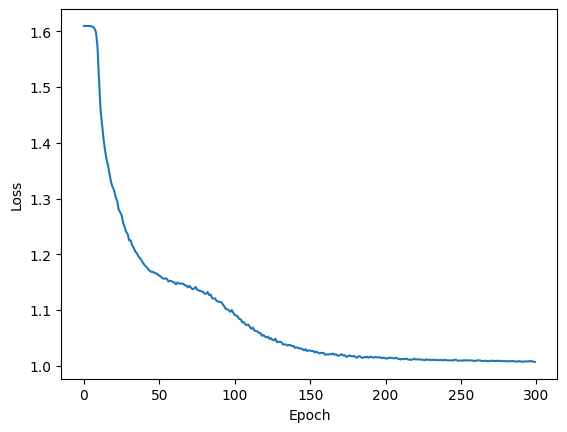

Test accuracy: 463.43139784946237
Accuracy: 0.4313978494623656
Precision: 0.4402734139591802
Recall: 0.431285994306373
F1-score: 0.4335909401330212


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.52      0.58       495
           1       0.39      0.38      0.39       472
           2       0.26      0.31      0.28       449
           3       0.29      0.28      0.29       463
           4       0.60      0.66      0.63       446

    accuracy                           0.43      2325
   macro avg       0.44      0.43      0.43      2325
weighted avg       0.44      0.43      0.43      2325

                    0           1           2           3           4  \
precision    0.650754    0.392157    0.259669    0.293850    0.604938   
recall       0.523232    0.381356    0.314031    0.278618    0.659193   
f1-score     0.580067    0.386681    0.284274    0.286031    0.630901   
support    495.000000  472.000000  449.000000 

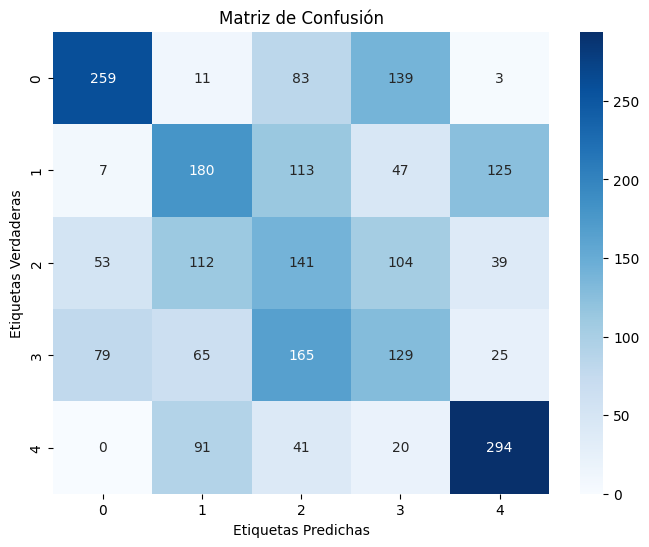

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_300_1e-05_0.2/resultados_300_1e-05_0.2.json
Procesando red con 500 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|▏                                                              | 1/500 [00:03<29:50,  3.59s/it]

1.6091800921103534


Procesando epocas:   0%|▎                                                              | 2/500 [00:07<29:50,  3.59s/it]

1.5268715690164005


Procesando epocas:   1%|▍                                                              | 3/500 [00:10<29:23,  3.55s/it]

1.411347527363721


Procesando epocas:   1%|▌                                                              | 4/500 [00:14<29:06,  3.52s/it]

1.3507907032966613


Procesando epocas:   1%|▋                                                              | 5/500 [00:17<28:51,  3.50s/it]

1.295961288844838


Procesando epocas:   1%|▊                                                              | 6/500 [00:21<28:41,  3.48s/it]

1.2593284424613505


Procesando epocas:   1%|▉                                                              | 7/500 [00:24<28:41,  3.49s/it]

1.2345078741802888


Procesando epocas:   2%|█                                                              | 8/500 [00:28<28:39,  3.49s/it]

1.210472077481887


Procesando epocas:   2%|█▏                                                             | 9/500 [00:31<28:45,  3.51s/it]

1.1984727831447826


Procesando epocas:   2%|█▏                                                            | 10/500 [00:35<28:34,  3.50s/it]

1.1877742290496827


Procesando epocas:   2%|█▎                                                            | 11/500 [00:38<28:42,  3.52s/it]

1.1739050234065336


Procesando epocas:   2%|█▍                                                            | 12/500 [00:42<28:57,  3.56s/it]

1.1598677130306467


Procesando epocas:   3%|█▌                                                            | 13/500 [00:45<28:55,  3.56s/it]

1.1465606153011323


Procesando epocas:   3%|█▋                                                            | 14/500 [00:49<28:41,  3.54s/it]

1.130213658949908


Procesando epocas:   3%|█▊                                                            | 15/500 [00:52<28:36,  3.54s/it]

1.109856162702336


Procesando epocas:   3%|█▉                                                            | 16/500 [00:56<28:33,  3.54s/it]

1.0931605240877937


Procesando epocas:   3%|██                                                            | 17/500 [00:59<28:23,  3.53s/it]

1.0790782223729527


Procesando epocas:   4%|██▏                                                           | 18/500 [01:03<28:10,  3.51s/it]

1.0684924094115986


Procesando epocas:   4%|██▎                                                           | 19/500 [01:06<28:09,  3.51s/it]

1.0580698234193466


Procesando epocas:   4%|██▍                                                           | 20/500 [01:10<28:04,  3.51s/it]

1.0523139992180992


Procesando epocas:   4%|██▌                                                           | 21/500 [01:13<28:06,  3.52s/it]

1.0549519580953262


Procesando epocas:   4%|██▋                                                           | 22/500 [01:17<28:07,  3.53s/it]

1.0473223342615015


Procesando epocas:   5%|██▊                                                           | 23/500 [01:21<28:03,  3.53s/it]

1.0465196129153758


Procesando epocas:   5%|██▉                                                           | 24/500 [01:24<27:54,  3.52s/it]

1.0370326150866116


Procesando epocas:   5%|███                                                           | 25/500 [01:28<27:38,  3.49s/it]

1.037023965400808


Procesando epocas:   5%|███▏                                                          | 26/500 [01:31<27:35,  3.49s/it]

1.030060822472853


Procesando epocas:   5%|███▎                                                          | 27/500 [01:34<27:31,  3.49s/it]

1.0289441722280839


Procesando epocas:   6%|███▍                                                          | 28/500 [01:38<27:26,  3.49s/it]

1.028959690472659


Procesando epocas:   6%|███▌                                                          | 29/500 [01:41<27:27,  3.50s/it]

1.0286598002209384


Procesando epocas:   6%|███▋                                                          | 30/500 [01:45<27:24,  3.50s/it]

1.0288741371210883


Procesando epocas:   6%|███▊                                                          | 31/500 [01:48<27:17,  3.49s/it]

1.0253011258209452


Procesando epocas:   6%|███▉                                                          | 32/500 [01:52<27:11,  3.49s/it]

1.0226644372238833


Procesando epocas:   7%|████                                                          | 33/500 [01:55<27:08,  3.49s/it]

1.0244786837521722


Procesando epocas:   7%|████▏                                                         | 34/500 [01:59<27:17,  3.51s/it]

1.024196278698304


Procesando epocas:   7%|████▎                                                         | 35/500 [02:03<27:24,  3.54s/it]

1.0226351499557496


Procesando epocas:   7%|████▍                                                         | 36/500 [02:06<27:19,  3.53s/it]

1.029404811298146


Procesando epocas:   7%|████▌                                                         | 37/500 [02:10<27:11,  3.52s/it]

1.0244094080784742


Procesando epocas:   8%|████▋                                                         | 38/500 [02:13<27:02,  3.51s/it]

1.029083559442969


Procesando epocas:   8%|████▊                                                         | 39/500 [02:17<26:53,  3.50s/it]

1.030142702074612


Procesando epocas:   8%|████▉                                                         | 40/500 [02:20<26:45,  3.49s/it]

1.026430908722036


Procesando epocas:   8%|█████                                                         | 41/500 [02:24<26:54,  3.52s/it]

1.0236284122747534


Procesando epocas:   8%|█████▏                                                        | 42/500 [02:27<26:42,  3.50s/it]

1.0191864122362697


Procesando epocas:   9%|█████▎                                                        | 43/500 [02:31<26:37,  3.50s/it]

1.017718497093986


Procesando epocas:   9%|█████▍                                                        | 44/500 [02:34<26:48,  3.53s/it]

1.0193443761152379


Procesando epocas:   9%|█████▌                                                        | 45/500 [02:38<26:47,  3.53s/it]

1.01872640988406


Procesando epocas:   9%|█████▋                                                        | 46/500 [02:41<26:42,  3.53s/it]

1.0205968246740453


Procesando epocas:   9%|█████▊                                                        | 47/500 [02:45<26:38,  3.53s/it]

1.0207124696058385


Procesando epocas:  10%|█████▉                                                        | 48/500 [02:48<26:32,  3.52s/it]

1.0207763475530287


Procesando epocas:  10%|██████                                                        | 49/500 [02:52<26:29,  3.52s/it]

1.0150376929956324


Procesando epocas:  10%|██████▏                                                       | 50/500 [02:55<26:35,  3.54s/it]

1.0156591219060562


Procesando epocas:  10%|██████▎                                                       | 51/500 [02:59<26:27,  3.54s/it]

1.0126030420555787


Procesando epocas:  10%|██████▍                                                       | 52/500 [03:02<26:17,  3.52s/it]

1.0126270024215474


Procesando epocas:  11%|██████▌                                                       | 53/500 [03:06<26:15,  3.52s/it]

1.0147618784623988


Procesando epocas:  11%|██████▋                                                       | 54/500 [03:09<26:09,  3.52s/it]

1.0152961124392117


Procesando epocas:  11%|██████▊                                                       | 55/500 [03:13<26:17,  3.54s/it]

1.0180853005717783


Procesando epocas:  11%|██████▉                                                       | 56/500 [03:17<26:29,  3.58s/it]

1.0195256085956799


Procesando epocas:  11%|███████                                                       | 57/500 [03:20<26:28,  3.59s/it]

1.0212521233979392


Procesando epocas:  12%|███████▏                                                      | 58/500 [03:24<26:22,  3.58s/it]

1.0180883653023665


Procesando epocas:  12%|███████▎                                                      | 59/500 [03:27<26:16,  3.58s/it]

1.0187339751159443


Procesando epocas:  12%|███████▍                                                      | 60/500 [03:31<26:15,  3.58s/it]

1.0138747152160197


Procesando epocas:  12%|███████▌                                                      | 61/500 [03:35<26:25,  3.61s/it]

1.0124119085424086


Procesando epocas:  12%|███████▋                                                      | 62/500 [03:38<26:26,  3.62s/it]

1.0090673516778386


Procesando epocas:  13%|███████▊                                                      | 63/500 [03:42<26:20,  3.62s/it]

1.0099732549751506


Procesando epocas:  13%|███████▉                                                      | 64/500 [03:46<26:09,  3.60s/it]

1.010058471735786


Procesando epocas:  13%|████████                                                      | 65/500 [03:49<25:51,  3.57s/it]

1.011091245623196


Procesando epocas:  13%|████████▏                                                     | 66/500 [03:52<25:32,  3.53s/it]

1.0106798049281625


Procesando epocas:  13%|████████▎                                                     | 67/500 [03:56<25:25,  3.52s/it]

1.01157728749163


Procesando epocas:  14%|████████▍                                                     | 68/500 [04:00<25:27,  3.54s/it]

1.0123843831174515


Procesando epocas:  14%|████████▌                                                     | 69/500 [04:03<25:15,  3.52s/it]

1.0072119295597077


Procesando epocas:  14%|████████▋                                                     | 70/500 [04:06<25:00,  3.49s/it]

1.0085935308652765


Procesando epocas:  14%|████████▊                                                     | 71/500 [04:10<24:50,  3.48s/it]

1.0064857738859514


Procesando epocas:  14%|████████▉                                                     | 72/500 [04:13<24:48,  3.48s/it]

1.003282402894076


Procesando epocas:  15%|█████████                                                     | 73/500 [04:17<24:45,  3.48s/it]

1.0071421714390025


Procesando epocas:  15%|█████████▏                                                    | 74/500 [04:20<24:37,  3.47s/it]

1.0079615501796497


Procesando epocas:  15%|█████████▎                                                    | 75/500 [04:24<24:30,  3.46s/it]

1.0068258997272044


Procesando epocas:  15%|█████████▍                                                    | 76/500 [04:27<24:45,  3.50s/it]

1.0067679009016823


Procesando epocas:  15%|█████████▌                                                    | 77/500 [04:31<24:49,  3.52s/it]

1.0081017687040217


Procesando epocas:  16%|█████████▋                                                    | 78/500 [04:34<24:54,  3.54s/it]

1.0076430198024302


Procesando epocas:  16%|█████████▊                                                    | 79/500 [04:38<24:51,  3.54s/it]

1.007467663638732


Procesando epocas:  16%|█████████▉                                                    | 80/500 [04:42<24:49,  3.55s/it]

1.0055252769414116


Procesando epocas:  16%|██████████                                                    | 81/500 [04:45<24:48,  3.55s/it]

1.0055638604304369


Procesando epocas:  16%|██████████▏                                                   | 82/500 [04:49<24:48,  3.56s/it]

1.0070152282714844


Procesando epocas:  17%|██████████▎                                                   | 83/500 [04:52<24:44,  3.56s/it]

1.0060143116642446


Procesando epocas:  17%|██████████▍                                                   | 84/500 [04:56<24:43,  3.57s/it]

1.0080733295749216


Procesando epocas:  17%|██████████▌                                                   | 85/500 [04:59<24:38,  3.56s/it]

1.0103939231704264


Procesando epocas:  17%|██████████▋                                                   | 86/500 [05:03<24:38,  3.57s/it]

1.0082815124708064


Procesando epocas:  17%|██████████▊                                                   | 87/500 [05:07<24:33,  3.57s/it]

1.0080880599863389


Procesando epocas:  18%|██████████▉                                                   | 88/500 [05:10<24:29,  3.57s/it]

1.0074996355701895


Procesando epocas:  18%|███████████                                                   | 89/500 [05:14<24:30,  3.58s/it]

1.0084132780047024


Procesando epocas:  18%|███████████▏                                                  | 90/500 [05:17<24:30,  3.59s/it]

1.0058081511188957


Procesando epocas:  18%|███████████▎                                                  | 91/500 [05:21<24:26,  3.58s/it]

1.0057635303805856


Procesando epocas:  18%|███████████▍                                                  | 92/500 [05:24<24:12,  3.56s/it]

1.0054375073489021


Procesando epocas:  19%|███████████▌                                                  | 93/500 [05:28<24:10,  3.56s/it]

1.003169279939988


Procesando epocas:  19%|███████████▋                                                  | 94/500 [05:32<24:10,  3.57s/it]

1.0038169913432178


Procesando epocas:  19%|███████████▊                                                  | 95/500 [05:35<23:56,  3.55s/it]

1.0062076663269717


Procesando epocas:  19%|███████████▉                                                  | 96/500 [05:38<23:36,  3.51s/it]

1.0015789003933178


Procesando epocas:  19%|████████████                                                  | 97/500 [05:42<23:25,  3.49s/it]

1.004553432674969


Procesando epocas:  20%|████████████▏                                                 | 98/500 [05:46<23:36,  3.52s/it]

1.005198864025228


Procesando epocas:  20%|████████████▎                                                 | 99/500 [05:49<23:33,  3.53s/it]

1.0027718417784748


Procesando epocas:  20%|████████████▏                                                | 100/500 [05:53<23:27,  3.52s/it]

1.001896736201118


Procesando epocas:  20%|████████████▎                                                | 101/500 [05:56<23:21,  3.51s/it]

1.003389929673251


Procesando epocas:  20%|████████████▍                                                | 102/500 [06:00<23:25,  3.53s/it]

0.9994053658317117


Procesando epocas:  21%|████████████▌                                                | 103/500 [06:03<23:10,  3.50s/it]

0.9985619390712065


Procesando epocas:  21%|████████████▋                                                | 104/500 [06:07<23:22,  3.54s/it]

0.9985697315019719


Procesando epocas:  21%|████████████▊                                                | 105/500 [06:10<23:11,  3.52s/it]

0.99824179130442


Procesando epocas:  21%|████████████▉                                                | 106/500 [06:14<22:53,  3.49s/it]

0.9972938183475943


Procesando epocas:  21%|█████████████                                                | 107/500 [06:17<22:40,  3.46s/it]

0.9971023044165443


Procesando epocas:  22%|█████████████▏                                               | 108/500 [06:20<22:26,  3.44s/it]

0.9955095561111674


Procesando epocas:  22%|█████████████▎                                               | 109/500 [06:24<22:19,  3.43s/it]

0.9949081873192507


Procesando epocas:  22%|█████████████▍                                               | 110/500 [06:27<22:15,  3.42s/it]

0.9980444571551155


Procesando epocas:  22%|█████████████▌                                               | 111/500 [06:31<22:08,  3.41s/it]

1.0045199117239785


Procesando epocas:  22%|█████████████▋                                               | 112/500 [06:34<22:04,  3.41s/it]

0.9999571558307199


Procesando epocas:  23%|█████████████▊                                               | 113/500 [06:37<22:06,  3.43s/it]

0.9970667288583868


Procesando epocas:  23%|█████████████▉                                               | 114/500 [06:41<22:09,  3.44s/it]

1.0020853536970475


Procesando epocas:  23%|██████████████                                               | 115/500 [06:44<21:59,  3.43s/it]

0.99548620967304


Procesando epocas:  23%|██████████████▏                                              | 116/500 [06:48<21:54,  3.42s/it]

0.9979954863295836


Procesando epocas:  23%|██████████████▎                                              | 117/500 [06:51<21:50,  3.42s/it]

0.997032937933417


Procesando epocas:  24%|██████████████▍                                              | 118/500 [06:55<21:50,  3.43s/it]

1.001107311599395


Procesando epocas:  24%|██████████████▌                                              | 119/500 [06:58<21:47,  3.43s/it]

0.9966640854583068


Procesando epocas:  24%|██████████████▋                                              | 120/500 [07:01<21:42,  3.43s/it]

0.997113830201766


Procesando epocas:  24%|██████████████▊                                              | 121/500 [07:05<21:36,  3.42s/it]

0.9956742272657506


Procesando epocas:  24%|██████████████▉                                              | 122/500 [07:08<21:29,  3.41s/it]

0.9967787497183855


Procesando epocas:  25%|███████████████                                              | 123/500 [07:12<21:29,  3.42s/it]

0.9965445883133832


Procesando epocas:  25%|███████████████▏                                             | 124/500 [07:15<21:32,  3.44s/it]

0.9935754022177528


Procesando epocas:  25%|███████████████▎                                             | 125/500 [07:19<21:24,  3.43s/it]

0.9955682442468755


Procesando epocas:  25%|███████████████▎                                             | 126/500 [07:22<21:19,  3.42s/it]

0.9969483414117027


Procesando epocas:  25%|███████████████▍                                             | 127/500 [07:25<21:17,  3.42s/it]

0.9970437389962813


Procesando epocas:  26%|███████████████▌                                             | 128/500 [07:29<21:13,  3.42s/it]

0.997058483432321


Procesando epocas:  26%|███████████████▋                                             | 129/500 [07:32<21:07,  3.42s/it]

0.9963452402283164


Procesando epocas:  26%|███████████████▊                                             | 130/500 [07:36<21:02,  3.41s/it]

0.9987445975051207


Procesando epocas:  26%|███████████████▉                                             | 131/500 [07:39<20:57,  3.41s/it]

0.9977017381611992


Procesando epocas:  26%|████████████████                                             | 132/500 [07:42<20:58,  3.42s/it]

1.0000905762700474


Procesando epocas:  27%|████████████████▏                                            | 133/500 [07:46<20:56,  3.42s/it]

0.9975159918560701


Procesando epocas:  27%|████████████████▎                                            | 134/500 [07:49<20:55,  3.43s/it]

0.9966762973981745


Procesando epocas:  27%|████████████████▍                                            | 135/500 [07:53<20:53,  3.43s/it]

0.994814460067188


Procesando epocas:  27%|████████████████▌                                            | 136/500 [07:56<20:52,  3.44s/it]

0.9953916185042437


Procesando epocas:  27%|████████████████▋                                            | 137/500 [08:00<20:52,  3.45s/it]

0.9969189468552084


Procesando epocas:  28%|████████████████▊                                            | 138/500 [08:03<20:48,  3.45s/it]

0.9969088259865256


Procesando epocas:  28%|████████████████▉                                            | 139/500 [08:07<20:45,  3.45s/it]

0.9954985583529753


Procesando epocas:  28%|█████████████████                                            | 140/500 [08:10<20:42,  3.45s/it]

0.9950581732918234


Procesando epocas:  28%|█████████████████▏                                           | 141/500 [08:14<20:36,  3.45s/it]

0.9954001861460069


Procesando epocas:  28%|█████████████████▎                                           | 142/500 [08:17<20:28,  3.43s/it]

0.9927973196786992


Procesando epocas:  29%|█████████████████▍                                           | 143/500 [08:20<20:23,  3.43s/it]

0.991945682553684


Procesando epocas:  29%|█████████████████▌                                           | 144/500 [08:24<20:17,  3.42s/it]

0.9913529459167929


Procesando epocas:  29%|█████████████████▋                                           | 145/500 [08:27<20:19,  3.44s/it]

0.9911938506014207


Procesando epocas:  29%|█████████████████▊                                           | 146/500 [08:31<20:15,  3.43s/it]

0.9903165424571317


Procesando epocas:  29%|█████████████████▉                                           | 147/500 [08:34<20:13,  3.44s/it]

0.9919432689161861


Procesando epocas:  30%|██████████████████                                           | 148/500 [08:37<20:06,  3.43s/it]

0.9901059525854448


Procesando epocas:  30%|██████████████████▏                                          | 149/500 [08:41<20:03,  3.43s/it]

0.9891843297902275


Procesando epocas:  30%|██████████████████▎                                          | 150/500 [08:44<19:58,  3.42s/it]

0.98865466187982


Procesando epocas:  30%|██████████████████▍                                          | 151/500 [08:48<19:51,  3.41s/it]

0.989027043651132


Procesando epocas:  30%|██████████████████▌                                          | 152/500 [08:51<19:45,  3.41s/it]

0.9895839151214151


Procesando epocas:  31%|██████████████████▋                                          | 153/500 [08:55<19:43,  3.41s/it]

0.988987172351164


Procesando epocas:  31%|██████████████████▊                                          | 154/500 [08:58<19:40,  3.41s/it]

0.9909144513747271


Procesando epocas:  31%|██████████████████▉                                          | 155/500 [09:01<19:35,  3.41s/it]

0.9915092696161831


Procesando epocas:  31%|███████████████████                                          | 156/500 [09:05<19:34,  3.41s/it]

0.9924249263370738


Procesando epocas:  31%|███████████████████▏                                         | 157/500 [09:08<19:29,  3.41s/it]

0.9911426838706522


Procesando epocas:  32%|███████████████████▎                                         | 158/500 [09:12<19:30,  3.42s/it]

0.9905124797540552


Procesando epocas:  32%|███████████████████▍                                         | 159/500 [09:15<19:31,  3.43s/it]

0.9908483901444604


Procesando epocas:  32%|███████████████████▌                                         | 160/500 [09:19<19:26,  3.43s/it]

0.9922770205666037


Procesando epocas:  32%|███████████████████▋                                         | 161/500 [09:22<19:25,  3.44s/it]

0.9904391828705282


Procesando epocas:  32%|███████████████████▊                                         | 162/500 [09:25<19:23,  3.44s/it]

0.9902174427228816


Procesando epocas:  33%|███████████████████▉                                         | 163/500 [09:29<19:19,  3.44s/it]

0.9902079873225268


Procesando epocas:  33%|████████████████████                                         | 164/500 [09:32<19:16,  3.44s/it]

0.9853352427482605


Procesando epocas:  33%|████████████████████▏                                        | 165/500 [09:36<19:15,  3.45s/it]

0.988576782801572


Procesando epocas:  33%|████████████████████▎                                        | 166/500 [09:39<19:20,  3.48s/it]

0.987841238344417


Procesando epocas:  33%|████████████████████▎                                        | 167/500 [09:43<19:15,  3.47s/it]

0.9892950878423803


Procesando epocas:  34%|████████████████████▍                                        | 168/500 [09:46<19:11,  3.47s/it]

0.989404674838571


Procesando epocas:  34%|████████████████████▌                                        | 169/500 [09:50<19:15,  3.49s/it]

0.9878835930543788


Procesando epocas:  34%|████████████████████▋                                        | 170/500 [09:53<19:12,  3.49s/it]

0.9921604692935944


Procesando epocas:  34%|████████████████████▊                                        | 171/500 [09:57<19:03,  3.48s/it]

0.9873868952779209


Procesando epocas:  34%|████████████████████▉                                        | 172/500 [10:00<18:53,  3.46s/it]

0.9894808762213763


Procesando epocas:  35%|█████████████████████                                        | 173/500 [10:04<18:46,  3.44s/it]

0.9884406766470741


Procesando epocas:  35%|█████████████████████▏                                       | 174/500 [10:07<18:45,  3.45s/it]

0.9881164270288804


Procesando epocas:  35%|█████████████████████▎                                       | 175/500 [10:10<18:44,  3.46s/it]

0.9863708404933705


Procesando epocas:  35%|█████████████████████▍                                       | 176/500 [10:14<18:37,  3.45s/it]

0.9864251035101274


Procesando epocas:  35%|█████████████████████▌                                       | 177/500 [10:17<18:33,  3.45s/it]

0.9871483497759875


Procesando epocas:  36%|█████████████████████▋                                       | 178/500 [10:21<18:32,  3.46s/it]

0.9870514343766605


Procesando epocas:  36%|█████████████████████▊                                       | 179/500 [10:24<18:30,  3.46s/it]

0.9856548512683195


Procesando epocas:  36%|█████████████████████▉                                       | 180/500 [10:28<18:26,  3.46s/it]

0.985987763895708


Procesando epocas:  36%|██████████████████████                                       | 181/500 [10:31<18:21,  3.45s/it]

0.9853331506252289


Procesando epocas:  36%|██████████████████████▏                                      | 182/500 [10:35<18:18,  3.45s/it]

0.9850076517638038


Procesando epocas:  37%|██████████████████████▎                                      | 183/500 [10:38<18:15,  3.46s/it]

0.9850795472369475


Procesando epocas:  37%|██████████████████████▍                                      | 184/500 [10:42<18:13,  3.46s/it]

0.9852747692781336


Procesando epocas:  37%|██████████████████████▌                                      | 185/500 [10:45<18:11,  3.46s/it]

0.986636237186544


Procesando epocas:  37%|██████████████████████▋                                      | 186/500 [10:48<18:07,  3.46s/it]

0.9853252018199248


Procesando epocas:  37%|██████████████████████▊                                      | 187/500 [10:52<18:06,  3.47s/it]

0.985127866268158


Procesando epocas:  38%|██████████████████████▉                                      | 188/500 [10:55<17:59,  3.46s/it]

0.9835557036540088


Procesando epocas:  38%|███████████████████████                                      | 189/500 [10:59<17:53,  3.45s/it]

0.9838354896096623


Procesando epocas:  38%|███████████████████████▏                                     | 190/500 [11:02<17:49,  3.45s/it]

0.9853651958353379


Procesando epocas:  38%|███████████████████████▎                                     | 191/500 [11:06<17:47,  3.45s/it]

0.9849255838814903


Procesando epocas:  38%|███████████████████████▍                                     | 192/500 [11:09<17:45,  3.46s/it]

0.9873122646528132


Procesando epocas:  39%|███████████████████████▌                                     | 193/500 [11:13<17:40,  3.45s/it]

0.987138621596729


Procesando epocas:  39%|███████████████████████▋                                     | 194/500 [11:16<17:32,  3.44s/it]

0.9876248026595397


Procesando epocas:  39%|███████████████████████▊                                     | 195/500 [11:20<17:30,  3.45s/it]

0.9877705686232623


Procesando epocas:  39%|███████████████████████▉                                     | 196/500 [11:23<17:29,  3.45s/it]

0.9876656655003043


Procesando epocas:  39%|████████████████████████                                     | 197/500 [11:26<17:23,  3.44s/it]

0.9859432283569785


Procesando epocas:  40%|████████████████████████▏                                    | 198/500 [11:30<17:21,  3.45s/it]

0.9843627130284028


Procesando epocas:  40%|████████████████████████▎                                    | 199/500 [11:33<17:19,  3.46s/it]

0.9856527261874255


Procesando epocas:  40%|████████████████████████▍                                    | 200/500 [11:37<17:17,  3.46s/it]

0.9843922306509579


Procesando epocas:  40%|████████████████████████▌                                    | 201/500 [11:40<17:13,  3.45s/it]

0.983693314299864


Procesando epocas:  40%|████████████████████████▋                                    | 202/500 [11:44<17:09,  3.45s/it]

0.984503649964052


Procesando epocas:  41%|████████████████████████▊                                    | 203/500 [11:47<17:04,  3.45s/it]

0.9831232866820168


Procesando epocas:  41%|████████████████████████▉                                    | 204/500 [11:51<17:02,  3.45s/it]

0.9883443786817439


Procesando epocas:  41%|█████████████████████████                                    | 205/500 [11:54<16:58,  3.45s/it]

0.9862344696241266


Procesando epocas:  41%|█████████████████████████▏                                   | 206/500 [11:58<16:54,  3.45s/it]

0.9846073101548588


Procesando epocas:  41%|█████████████████████████▎                                   | 207/500 [12:01<16:54,  3.46s/it]

0.9814054471604964


Procesando epocas:  42%|█████████████████████████▍                                   | 208/500 [12:04<16:47,  3.45s/it]

0.9855122415458455


Procesando epocas:  42%|█████████████████████████▍                                   | 209/500 [12:08<16:41,  3.44s/it]

0.9823200338027056


Procesando epocas:  42%|█████████████████████████▌                                   | 210/500 [12:11<16:39,  3.44s/it]

0.9828716544543996


Procesando epocas:  42%|█████████████████████████▋                                   | 211/500 [12:15<16:36,  3.45s/it]

0.9816515691140119


Procesando epocas:  42%|█████████████████████████▊                                   | 212/500 [12:18<16:32,  3.45s/it]

0.9810046259094687


Procesando epocas:  43%|█████████████████████████▉                                   | 213/500 [12:22<16:28,  3.45s/it]

0.9805321209570941


Procesando epocas:  43%|██████████████████████████                                   | 214/500 [12:25<16:27,  3.45s/it]

0.9821962672121385


Procesando epocas:  43%|██████████████████████████▏                                  | 215/500 [12:29<16:22,  3.45s/it]

0.9829604324172525


Procesando epocas:  43%|██████████████████████████▎                                  | 216/500 [12:32<16:18,  3.45s/it]

0.984052148286034


Procesando epocas:  43%|██████████████████████████▍                                  | 217/500 [12:35<16:14,  3.44s/it]

0.9828028784078711


Procesando epocas:  44%|██████████████████████████▌                                  | 218/500 [12:39<16:07,  3.43s/it]

0.9833130009034101


Procesando epocas:  44%|██████████████████████████▋                                  | 219/500 [12:42<16:04,  3.43s/it]

0.9798351841814378


Procesando epocas:  44%|██████████████████████████▊                                  | 220/500 [12:46<16:01,  3.43s/it]

0.9832534488509683


Procesando epocas:  44%|██████████████████████████▉                                  | 221/500 [12:49<15:59,  3.44s/it]

0.9813039628898397


Procesando epocas:  44%|███████████████████████████                                  | 222/500 [12:53<15:53,  3.43s/it]

0.9812691467649797


Procesando epocas:  45%|███████████████████████████▏                                 | 223/500 [12:56<15:52,  3.44s/it]

0.9801882705267738


Procesando epocas:  45%|███████████████████████████▎                                 | 224/500 [13:00<15:51,  3.45s/it]

0.9771093291394851


Procesando epocas:  45%|███████████████████████████▍                                 | 225/500 [13:03<15:49,  3.45s/it]

0.9791280830607695


Procesando epocas:  45%|███████████████████████████▌                                 | 226/500 [13:06<15:48,  3.46s/it]

0.978179361890344


Procesando epocas:  45%|███████████████████████████▋                                 | 227/500 [13:10<15:41,  3.45s/it]

0.9783808006959803


Procesando epocas:  46%|███████████████████████████▊                                 | 228/500 [13:13<15:38,  3.45s/it]

0.979183984153411


Procesando epocas:  46%|███████████████████████████▉                                 | 229/500 [13:17<15:34,  3.45s/it]

0.9823463320732116


Procesando epocas:  46%|████████████████████████████                                 | 230/500 [13:20<15:34,  3.46s/it]

0.9770156278329737


Procesando epocas:  46%|████████████████████████████▏                                | 231/500 [13:24<15:30,  3.46s/it]

0.9798382706501905


Procesando epocas:  46%|████████████████████████████▎                                | 232/500 [13:27<15:27,  3.46s/it]

0.9772920882000643


Procesando epocas:  47%|████████████████████████████▍                                | 233/500 [13:31<15:19,  3.44s/it]

0.9786934267072117


Procesando epocas:  47%|████████████████████████████▌                                | 234/500 [13:34<15:13,  3.44s/it]

0.9778879418092615


Procesando epocas:  47%|████████████████████████████▋                                | 235/500 [13:37<15:09,  3.43s/it]

0.9817224853179034


Procesando epocas:  47%|████████████████████████████▊                                | 236/500 [13:41<15:09,  3.44s/it]

0.9803854234078351


Procesando epocas:  47%|████████████████████████████▉                                | 237/500 [13:44<15:14,  3.48s/it]

0.9817850021754995


Procesando epocas:  48%|█████████████████████████████                                | 238/500 [13:48<15:12,  3.48s/it]

0.9786427245420568


Procesando epocas:  48%|█████████████████████████████▏                               | 239/500 [13:51<15:07,  3.48s/it]

0.9777192771434784


Procesando epocas:  48%|█████████████████████████████▎                               | 240/500 [13:55<15:03,  3.48s/it]

0.9768181555411395


Procesando epocas:  48%|█████████████████████████████▍                               | 241/500 [13:58<15:01,  3.48s/it]

0.9787600131595836


Procesando epocas:  48%|█████████████████████████████▌                               | 242/500 [14:02<15:01,  3.49s/it]

0.9741689727586859


Procesando epocas:  49%|█████████████████████████████▋                               | 243/500 [14:05<14:57,  3.49s/it]

0.9768333007307614


Procesando epocas:  49%|█████████████████████████████▊                               | 244/500 [14:09<14:47,  3.47s/it]

0.9759475613341612


Procesando epocas:  49%|█████████████████████████████▉                               | 245/500 [14:12<14:46,  3.48s/it]

0.9769798289327061


Procesando epocas:  49%|██████████████████████████████                               | 246/500 [14:16<14:49,  3.50s/it]

0.978019215780146


Procesando epocas:  49%|██████████████████████████████▏                              | 247/500 [14:19<14:46,  3.50s/it]

0.9782798644374399


Procesando epocas:  50%|██████████████████████████████▎                              | 248/500 [14:23<14:46,  3.52s/it]

0.977114106276456


Procesando epocas:  50%|██████████████████████████████▍                              | 249/500 [14:26<14:37,  3.50s/it]

0.9786848012138816


Procesando epocas:  50%|██████████████████████████████▌                              | 250/500 [14:30<14:28,  3.47s/it]

0.9765794242129606


Procesando epocas:  50%|██████████████████████████████▌                              | 251/500 [14:33<14:21,  3.46s/it]

0.9756723600275377


Procesando epocas:  50%|██████████████████████████████▋                              | 252/500 [14:37<14:14,  3.45s/it]

0.9766272485256196


Procesando epocas:  51%|██████████████████████████████▊                              | 253/500 [14:40<14:09,  3.44s/it]

0.9769051755175872


Procesando epocas:  51%|██████████████████████████████▉                              | 254/500 [14:43<14:03,  3.43s/it]

0.975843632221222


Procesando epocas:  51%|███████████████████████████████                              | 255/500 [14:47<14:00,  3.43s/it]

0.9755034162717707


Procesando epocas:  51%|███████████████████████████████▏                             | 256/500 [14:50<13:56,  3.43s/it]

0.9788700142327477


Procesando epocas:  51%|███████████████████████████████▎                             | 257/500 [14:54<13:54,  3.44s/it]

0.978552669987959


Procesando epocas:  52%|███████████████████████████████▍                             | 258/500 [14:57<13:52,  3.44s/it]

0.9781383549465853


Procesando epocas:  52%|███████████████████████████████▌                             | 259/500 [15:01<13:46,  3.43s/it]

0.9788242326063268


Procesando epocas:  52%|███████████████████████████████▋                             | 260/500 [15:04<13:40,  3.42s/it]

0.979271177333944


Procesando epocas:  52%|███████████████████████████████▊                             | 261/500 [15:07<13:37,  3.42s/it]

0.976872639095082


Procesando epocas:  52%|███████████████████████████████▉                             | 262/500 [15:11<13:35,  3.42s/it]

0.9775725424289703


Procesando epocas:  53%|████████████████████████████████                             | 263/500 [15:14<13:31,  3.43s/it]

0.975312355336021


Procesando epocas:  53%|████████████████████████████████▏                            | 264/500 [15:18<13:30,  3.43s/it]

0.9758938287987429


Procesando epocas:  53%|████████████████████████████████▎                            | 265/500 [15:21<13:28,  3.44s/it]

0.9840300367159002


Procesando epocas:  53%|████████████████████████████████▍                            | 266/500 [15:25<13:24,  3.44s/it]

0.9744672077543596


Procesando epocas:  53%|████████████████████████████████▌                            | 267/500 [15:28<13:21,  3.44s/it]

0.9753480893724105


Procesando epocas:  54%|████████████████████████████████▋                            | 268/500 [15:32<13:17,  3.44s/it]

0.9743204204475179


Procesando epocas:  54%|████████████████████████████████▊                            | 269/500 [15:35<13:10,  3.42s/it]

0.9764549963614519


Procesando epocas:  54%|████████████████████████████████▉                            | 270/500 [15:38<13:12,  3.44s/it]

0.975778643874561


Procesando epocas:  54%|█████████████████████████████████                            | 271/500 [15:42<13:08,  3.44s/it]

0.9740100408301634


Procesando epocas:  54%|█████████████████████████████████▏                           | 272/500 [15:45<13:06,  3.45s/it]

0.9742929118521073


Procesando epocas:  55%|█████████████████████████████████▎                           | 273/500 [15:49<13:03,  3.45s/it]

0.9749053352019366


Procesando epocas:  55%|█████████████████████████████████▍                           | 274/500 [15:52<12:59,  3.45s/it]

0.9727942982140709


Procesando epocas:  55%|█████████████████████████████████▌                           | 275/500 [15:56<12:54,  3.44s/it]

0.9754831692751716


Procesando epocas:  55%|█████████████████████████████████▋                           | 276/500 [15:59<12:54,  3.46s/it]

0.9753426387029536


Procesando epocas:  55%|█████████████████████████████████▊                           | 277/500 [16:03<12:50,  3.45s/it]

0.9768569248564103


Procesando epocas:  56%|█████████████████████████████████▉                           | 278/500 [16:06<12:46,  3.45s/it]

0.9774340247406679


Procesando epocas:  56%|██████████████████████████████████                           | 279/500 [16:09<12:43,  3.46s/it]

0.977443034508649


Procesando epocas:  56%|██████████████████████████████████▏                          | 280/500 [16:13<12:38,  3.45s/it]

0.9787712945657618


Procesando epocas:  56%|██████████████████████████████████▎                          | 281/500 [16:16<12:33,  3.44s/it]

0.9755534620846019


Procesando epocas:  56%|██████████████████████████████████▍                          | 282/500 [16:20<12:33,  3.45s/it]

0.9756883807042066


Procesando epocas:  57%|██████████████████████████████████▌                          | 283/500 [16:23<12:26,  3.44s/it]

0.9744576520779553


Procesando epocas:  57%|██████████████████████████████████▋                          | 284/500 [16:27<12:22,  3.44s/it]

0.9735837582279654


Procesando epocas:  57%|██████████████████████████████████▊                          | 285/500 [16:30<12:21,  3.45s/it]

0.9801012761452619


Procesando epocas:  57%|██████████████████████████████████▉                          | 286/500 [16:34<12:18,  3.45s/it]

0.9755607734708225


Procesando epocas:  57%|███████████████████████████████████                          | 287/500 [16:37<12:14,  3.45s/it]

0.9753535873749677


Procesando epocas:  58%|███████████████████████████████████▏                         | 288/500 [16:41<12:12,  3.45s/it]

0.9754125195391038


Procesando epocas:  58%|███████████████████████████████████▎                         | 289/500 [16:44<12:08,  3.45s/it]

0.9731470034402959


Procesando epocas:  58%|███████████████████████████████████▍                         | 290/500 [16:47<12:05,  3.46s/it]

0.9738689419101266


Procesando epocas:  58%|███████████████████████████████████▌                         | 291/500 [16:51<12:02,  3.45s/it]

0.9758189997252296


Procesando epocas:  58%|███████████████████████████████████▌                         | 292/500 [16:54<11:57,  3.45s/it]

0.975950962305069


Procesando epocas:  59%|███████████████████████████████████▋                         | 293/500 [16:58<11:54,  3.45s/it]

0.9729185188517852


Procesando epocas:  59%|███████████████████████████████████▊                         | 294/500 [17:01<11:49,  3.45s/it]

0.9728939073927262


Procesando epocas:  59%|███████████████████████████████████▉                         | 295/500 [17:05<11:46,  3.45s/it]

0.9752240812077242


Procesando epocas:  59%|████████████████████████████████████                         | 296/500 [17:08<11:40,  3.43s/it]

0.9759833770639756


Procesando epocas:  59%|████████████████████████████████████▏                        | 297/500 [17:12<11:38,  3.44s/it]

0.9764153193025028


Procesando epocas:  60%|████████████████████████████████████▎                        | 298/500 [17:15<11:32,  3.43s/it]

0.9740257017752704


Procesando epocas:  60%|████████████████████████████████████▍                        | 299/500 [17:18<11:28,  3.43s/it]

0.9770105467123144


Procesando epocas:  60%|████████████████████████████████████▌                        | 300/500 [17:22<11:25,  3.43s/it]

0.9747632121338564


Procesando epocas:  60%|████████████████████████████████████▋                        | 301/500 [17:25<11:23,  3.44s/it]

0.9754704058170318


Procesando epocas:  60%|████████████████████████████████████▊                        | 302/500 [17:29<11:18,  3.43s/it]

0.9740636457415188


Procesando epocas:  61%|████████████████████████████████████▉                        | 303/500 [17:32<11:16,  3.43s/it]

0.9725299680934233


Procesando epocas:  61%|█████████████████████████████████████                        | 304/500 [17:35<11:12,  3.43s/it]

0.9702034810010125


Procesando epocas:  61%|█████████████████████████████████████▏                       | 305/500 [17:39<11:11,  3.44s/it]

0.9732008218765259


Procesando epocas:  61%|█████████████████████████████████████▎                       | 306/500 [17:42<11:07,  3.44s/it]

0.9732402531539692


Procesando epocas:  61%|█████████████████████████████████████▍                       | 307/500 [17:46<11:05,  3.45s/it]

0.9729680843213026


Procesando epocas:  62%|█████████████████████████████████████▌                       | 308/500 [17:49<11:02,  3.45s/it]

0.97094226584715


Procesando epocas:  62%|█████████████████████████████████████▋                       | 309/500 [17:53<10:58,  3.45s/it]

0.9725085191866931


Procesando epocas:  62%|█████████████████████████████████████▊                       | 310/500 [17:56<10:53,  3.44s/it]

0.9725488210425658


Procesando epocas:  62%|█████████████████████████████████████▉                       | 311/500 [18:00<10:49,  3.44s/it]

0.9737013753722695


Procesando epocas:  62%|██████████████████████████████████████                       | 312/500 [18:03<10:47,  3.44s/it]

0.9817787307150224


Procesando epocas:  63%|██████████████████████████████████████▏                      | 313/500 [18:06<10:42,  3.43s/it]

0.9747213223401238


Procesando epocas:  63%|██████████████████████████████████████▎                      | 314/500 [18:10<10:40,  3.44s/it]

0.9750506849849925


Procesando epocas:  63%|██████████████████████████████████████▍                      | 315/500 [18:13<10:33,  3.43s/it]

0.9746694361462312


Procesando epocas:  63%|██████████████████████████████████████▌                      | 316/500 [18:17<10:29,  3.42s/it]

0.9736140086370356


Procesando epocas:  63%|██████████████████████████████████████▋                      | 317/500 [18:20<10:27,  3.43s/it]

0.9740032946362215


Procesando epocas:  64%|██████████████████████████████████████▊                      | 318/500 [18:24<10:22,  3.42s/it]

0.9735389677917257


Procesando epocas:  64%|██████████████████████████████████████▉                      | 319/500 [18:27<10:21,  3.43s/it]

0.9761053667348973


Procesando epocas:  64%|███████████████████████████████████████                      | 320/500 [18:30<10:17,  3.43s/it]

0.9757960722726934


Procesando epocas:  64%|███████████████████████████████████████▏                     | 321/500 [18:34<10:14,  3.43s/it]

0.9777013904908124


Procesando epocas:  64%|███████████████████████████████████████▎                     | 322/500 [18:37<10:08,  3.42s/it]

0.9747817656573128


Procesando epocas:  65%|███████████████████████████████████████▍                     | 323/500 [18:41<10:08,  3.44s/it]

0.9736413026557249


Procesando epocas:  65%|███████████████████████████████████████▌                     | 324/500 [18:44<10:06,  3.44s/it]

0.9739622361519757


Procesando epocas:  65%|███████████████████████████████████████▋                     | 325/500 [18:48<10:01,  3.44s/it]

0.9723485564484315


Procesando epocas:  65%|███████████████████████████████████████▊                     | 326/500 [18:51<09:59,  3.45s/it]

0.9712217723622042


Procesando epocas:  65%|███████████████████████████████████████▉                     | 327/500 [18:55<09:55,  3.44s/it]

0.9710713442634133


Procesando epocas:  66%|████████████████████████████████████████                     | 328/500 [18:58<09:49,  3.43s/it]

0.9711100122507881


Procesando epocas:  66%|████████████████████████████████████████▏                    | 329/500 [19:01<09:46,  3.43s/it]

0.9704005178283243


Procesando epocas:  66%|████████████████████████████████████████▎                    | 330/500 [19:05<09:45,  3.44s/it]

0.9714890508090749


Procesando epocas:  66%|████████████████████████████████████████▍                    | 331/500 [19:08<09:39,  3.43s/it]

0.9751583923311794


Procesando epocas:  66%|████████████████████████████████████████▌                    | 332/500 [19:12<09:35,  3.43s/it]

0.9704354454489316


Procesando epocas:  67%|████████████████████████████████████████▋                    | 333/500 [19:15<09:31,  3.42s/it]

0.9726553096490748


Procesando epocas:  67%|████████████████████████████████████████▋                    | 334/500 [19:19<09:30,  3.44s/it]

0.9702776172581841


Procesando epocas:  67%|████████████████████████████████████████▊                    | 335/500 [19:22<09:28,  3.45s/it]

0.9706724370227141


Procesando epocas:  67%|████████████████████████████████████████▉                    | 336/500 [19:26<09:27,  3.46s/it]

0.9697850721723893


Procesando epocas:  67%|█████████████████████████████████████████                    | 337/500 [19:29<09:25,  3.47s/it]

0.9720141880652484


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 338/500 [19:32<09:21,  3.47s/it]

0.9708346752559438


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 339/500 [19:36<09:22,  3.49s/it]

0.9702398212517009


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 340/500 [19:39<09:17,  3.48s/it]

0.9711044416708104


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 341/500 [19:43<09:16,  3.50s/it]

0.9697188612292794


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 342/500 [19:47<09:15,  3.51s/it]

0.9690163345897899


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 343/500 [19:50<09:09,  3.50s/it]

0.9723013558808495


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 344/500 [19:54<09:08,  3.51s/it]

0.9709803742520949


Procesando epocas:  69%|██████████████████████████████████████████                   | 345/500 [19:57<09:04,  3.51s/it]

0.9717346598120297


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 346/500 [20:01<08:58,  3.50s/it]

0.9740553505280438


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 347/500 [20:04<08:54,  3.49s/it]

0.9731694319668938


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 348/500 [20:07<08:48,  3.48s/it]

0.9715863666113685


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 349/500 [20:11<08:42,  3.46s/it]

0.9738391132915721


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 350/500 [20:14<08:42,  3.48s/it]

0.9724821479881511


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 351/500 [20:18<08:40,  3.49s/it]

0.9724919378757477


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 352/500 [20:21<08:33,  3.47s/it]

0.9697600904633017


Procesando epocas:  71%|███████████████████████████████████████████                  | 353/500 [20:25<08:30,  3.48s/it]

0.9702953247463002


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 354/500 [20:28<08:29,  3.49s/it]

0.9703406617921941


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 355/500 [20:32<08:27,  3.50s/it]

0.9696864832850064


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 356/500 [20:35<08:22,  3.49s/it]

0.9694960534572601


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 357/500 [20:39<08:18,  3.49s/it]

0.973792375536526


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 358/500 [20:42<08:13,  3.47s/it]

0.9736124413854935


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 359/500 [20:46<08:07,  3.46s/it]

0.9747173035846037


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 360/500 [20:49<08:03,  3.46s/it]

0.9713820744963253


Procesando epocas:  72%|████████████████████████████████████████████                 | 361/500 [20:53<08:00,  3.46s/it]

0.9741708376828362


Procesando epocas:  72%|████████████████████████████████████████████▏                | 362/500 [20:56<07:57,  3.46s/it]

0.9748150899129755


Procesando epocas:  73%|████████████████████████████████████████████▎                | 363/500 [20:59<07:51,  3.44s/it]

0.9720240273896386


Procesando epocas:  73%|████████████████████████████████████████████▍                | 364/500 [21:03<07:47,  3.43s/it]

0.9712785664726706


Procesando epocas:  73%|████████████████████████████████████████████▌                | 365/500 [21:06<07:43,  3.43s/it]

0.9718148070223191


Procesando epocas:  73%|████████████████████████████████████████████▋                | 366/500 [21:10<07:39,  3.43s/it]

0.9728658066076391


Procesando epocas:  73%|████████████████████████████████████████████▊                | 367/500 [21:13<07:38,  3.45s/it]

0.972302307100857


Procesando epocas:  74%|████████████████████████████████████████████▉                | 368/500 [21:17<07:33,  3.44s/it]

0.9721144336111406


Procesando epocas:  74%|█████████████████████████████████████████████                | 369/500 [21:20<07:31,  3.45s/it]

0.9702365044285269


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 370/500 [21:24<07:27,  3.44s/it]

0.9692977908779593


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 371/500 [21:27<07:23,  3.44s/it]

0.9701175311032464


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 372/500 [21:30<07:17,  3.42s/it]

0.970943991576924


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 373/500 [21:34<07:14,  3.42s/it]

0.9697745053207173


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 374/500 [21:37<07:10,  3.42s/it]

0.9809654632035424


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 375/500 [21:41<07:06,  3.41s/it]

0.9733479552409228


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 376/500 [21:44<07:03,  3.41s/it]

0.9725574076175689


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 377/500 [21:47<07:00,  3.42s/it]

0.9717519307837766


Procesando epocas:  76%|██████████████████████████████████████████████               | 378/500 [21:51<06:55,  3.41s/it]

0.9691797144272748


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 379/500 [21:54<06:53,  3.42s/it]

0.9683102029211381


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 380/500 [21:58<06:50,  3.42s/it]

0.9688565902850207


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 381/500 [22:01<06:47,  3.42s/it]

0.9683446126825669


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 382/500 [22:05<06:44,  3.42s/it]

0.9699315628584694


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 383/500 [22:08<06:42,  3.44s/it]

0.9701607875964221


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 384/500 [22:11<06:39,  3.45s/it]

0.9692651352461646


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 385/500 [22:15<06:36,  3.45s/it]

0.9677133542649886


Procesando epocas:  77%|███████████████████████████████████████████████              | 386/500 [22:18<06:35,  3.47s/it]

0.9736399626030642


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 387/500 [22:22<06:32,  3.47s/it]

0.9702494747498456


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 388/500 [22:25<06:26,  3.46s/it]

0.9686856410082649


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 389/500 [22:29<06:26,  3.48s/it]

0.9695598314790165


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 390/500 [22:32<06:22,  3.48s/it]

0.9714254011126126


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 391/500 [22:36<06:17,  3.47s/it]

0.971047616706175


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 392/500 [22:39<06:14,  3.47s/it]

0.9687578173244701


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 393/500 [22:43<06:11,  3.47s/it]

0.9709094166755676


Procesando epocas:  79%|████████████████████████████████████████████████             | 394/500 [22:46<06:07,  3.47s/it]

0.9721200578352984


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 395/500 [22:50<06:06,  3.49s/it]

0.9682284099214217


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 396/500 [22:53<06:03,  3.50s/it]

0.9746729938422932


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 397/500 [22:57<06:00,  3.50s/it]

0.9727257640922771


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 398/500 [23:00<05:58,  3.52s/it]

0.9705967752372517


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 399/500 [23:04<05:55,  3.52s/it]

0.9692166402059443


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 400/500 [23:07<05:51,  3.51s/it]

0.9692383916939006


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 401/500 [23:11<05:47,  3.51s/it]

0.9734358314205619


Procesando epocas:  80%|█████████████████████████████████████████████████            | 402/500 [23:14<05:43,  3.50s/it]

0.9703633792260113


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 403/500 [23:18<05:39,  3.50s/it]

0.9682097456034492


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 404/500 [23:21<05:38,  3.53s/it]

0.9682719160528744


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 405/500 [23:25<05:35,  3.53s/it]

0.9704663932323456


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 406/500 [23:28<05:31,  3.53s/it]

0.9703616289531484


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 407/500 [23:32<05:27,  3.52s/it]

0.9696190841057721


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 408/500 [23:35<05:22,  3.51s/it]

0.9700252277009628


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 409/500 [23:39<05:19,  3.51s/it]

0.9706733107566834


Procesando epocas:  82%|██████████████████████████████████████████████████           | 410/500 [23:42<05:15,  3.51s/it]

0.9704025331665488


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 411/500 [23:46<05:10,  3.48s/it]

0.9701475721948287


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 412/500 [23:50<05:10,  3.53s/it]

0.968860387100893


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 413/500 [23:53<05:09,  3.56s/it]

0.9710752701058107


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 414/500 [23:57<05:05,  3.56s/it]

0.9727915753336513


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 415/500 [24:00<05:02,  3.56s/it]

0.9685016071095186


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 416/500 [24:04<04:57,  3.54s/it]

0.9702037418589873


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 417/500 [24:07<04:52,  3.52s/it]

0.9689334283856784


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 418/500 [24:11<04:49,  3.53s/it]

0.9687338015612434


Procesando epocas:  84%|███████████████████████████████████████████████████          | 419/500 [24:14<04:45,  3.52s/it]

0.9670723813421586


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 420/500 [24:18<04:43,  3.54s/it]

0.9661250237156364


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 421/500 [24:21<04:39,  3.53s/it]

0.9658733585301568


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 422/500 [24:25<04:35,  3.53s/it]

0.9651402659275953


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 423/500 [24:28<04:31,  3.53s/it]

0.9658689351642833


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 424/500 [24:32<04:27,  3.52s/it]

0.9669820143895991


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 425/500 [24:35<04:23,  3.51s/it]

0.9718505042440752


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 426/500 [24:39<04:20,  3.51s/it]

0.9672010737306932


Procesando epocas:  85%|████████████████████████████████████████████████████         | 427/500 [24:42<04:16,  3.51s/it]

0.9665587712736691


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 428/500 [24:46<04:12,  3.51s/it]

0.9758538596770343


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 429/500 [24:49<04:08,  3.50s/it]

0.9696530727779165


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 430/500 [24:53<04:04,  3.50s/it]

0.9659742639345281


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 431/500 [24:57<04:03,  3.53s/it]

0.96657795660636


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 432/500 [25:00<03:59,  3.52s/it]

0.969679021134096


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 433/500 [25:04<03:56,  3.53s/it]

0.9681765156633714


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 434/500 [25:07<03:52,  3.52s/it]

0.9662595962776858


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 435/500 [25:11<03:48,  3.52s/it]

0.96658835235764


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 436/500 [25:14<03:45,  3.52s/it]

0.9658124436350429


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 437/500 [25:18<03:40,  3.51s/it]

0.9650307038251091


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 438/500 [25:21<03:36,  3.50s/it]

0.9669406445587383


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 439/500 [25:25<03:32,  3.49s/it]

0.9661221549791448


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 440/500 [25:28<03:29,  3.49s/it]

0.9650321620352128


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 441/500 [25:32<03:26,  3.50s/it]

0.9650879214791691


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 442/500 [25:35<03:22,  3.49s/it]

0.9663249447065241


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 443/500 [25:39<03:19,  3.50s/it]

0.9673857927322388


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 444/500 [25:42<03:16,  3.51s/it]

0.9697947786134832


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 445/500 [25:46<03:12,  3.50s/it]

0.9705314352231867


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 446/500 [25:49<03:08,  3.49s/it]

0.9677239887854632


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 447/500 [25:53<03:04,  3.49s/it]

0.9659188950763029


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 448/500 [25:56<03:01,  3.48s/it]

0.9660533694659963


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 449/500 [25:59<02:57,  3.49s/it]

0.965571196640239


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 450/500 [26:03<02:54,  3.50s/it]

0.9659373988123501


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 451/500 [26:07<02:52,  3.51s/it]

0.9691398000015932


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 452/500 [26:10<02:48,  3.51s/it]

0.9686618570019218


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 453/500 [26:14<02:45,  3.51s/it]

0.9676680200240191


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 454/500 [26:17<02:41,  3.51s/it]

0.9666568181094002


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 455/500 [26:21<02:37,  3.50s/it]

0.9709489692659939


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 456/500 [26:24<02:33,  3.50s/it]

0.9662424830829396


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 457/500 [26:28<02:30,  3.49s/it]

0.9658469122998855


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 458/500 [26:31<02:26,  3.50s/it]

0.9642440052593455


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 459/500 [26:35<02:23,  3.49s/it]

0.9665411409209756


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 460/500 [26:38<02:17,  3.44s/it]

0.9633893416208379


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 461/500 [26:40<01:59,  3.08s/it]

0.9647209994933185


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 462/500 [26:42<01:43,  2.71s/it]

0.9647584070177639


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 463/500 [26:44<01:30,  2.45s/it]

0.9640899714301614


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 464/500 [26:46<01:21,  2.26s/it]

0.9649631479207207


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 465/500 [26:47<01:14,  2.12s/it]

0.9645335516508888


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 466/500 [26:49<01:09,  2.03s/it]

0.9660342482959523


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 467/500 [26:51<01:04,  1.96s/it]

0.9682762496611651


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 468/500 [26:53<01:01,  1.91s/it]

0.9671268729602589


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 469/500 [26:55<01:04,  2.07s/it]

0.9737744362915264


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 470/500 [26:58<01:07,  2.25s/it]

0.9670759456999162


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 471/500 [27:01<01:16,  2.63s/it]

0.9655838408890892


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 472/500 [27:05<01:21,  2.91s/it]

0.9675835577880635


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 473/500 [27:09<01:23,  3.11s/it]

0.9663427850779365


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 474/500 [27:12<01:23,  3.23s/it]

0.9671332983409657


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 475/500 [27:16<01:22,  3.32s/it]

0.9656401360736174


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 476/500 [27:19<01:22,  3.42s/it]

0.965564223948647


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 477/500 [27:23<01:20,  3.48s/it]

0.9669232582344728


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 478/500 [27:27<01:17,  3.53s/it]

0.9665186380638796


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 479/500 [27:30<01:14,  3.55s/it]

0.9666123768862556


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 480/500 [27:34<01:11,  3.57s/it]

0.9659290005179012


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 481/500 [27:37<01:07,  3.57s/it]

0.9655192564515507


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 482/500 [27:41<01:04,  3.57s/it]

0.9674445674699895


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 483/500 [27:44<01:00,  3.56s/it]

0.9662612862446729


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 484/500 [27:48<00:56,  3.53s/it]

0.9663614588625291


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 485/500 [27:51<00:52,  3.50s/it]

0.9645779132843018


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 486/500 [27:55<00:48,  3.48s/it]

0.9648185407414156


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 487/500 [27:58<00:45,  3.48s/it]

0.9669998540597804


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 488/500 [28:02<00:42,  3.52s/it]

0.9651092792258543


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 489/500 [28:05<00:39,  3.55s/it]

0.9680995892075931


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 490/500 [28:09<00:35,  3.58s/it]

0.9650494533426621


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 491/500 [28:13<00:32,  3.58s/it]

0.9686176166814916


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 492/500 [28:16<00:28,  3.59s/it]

0.9658017239149879


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 493/500 [28:20<00:25,  3.59s/it]

0.9676251064328586


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 494/500 [28:24<00:21,  3.60s/it]

0.9635697627768797


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 495/500 [28:27<00:17,  3.59s/it]

0.9641619170413298


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 496/500 [28:31<00:14,  3.55s/it]

0.9640408368671641


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 497/500 [28:34<00:10,  3.53s/it]

0.9633450483574587


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 498/500 [28:38<00:07,  3.52s/it]

0.966389589099323


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 499/500 [28:41<00:03,  3.52s/it]

0.9629980792017544


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 500/500 [28:45<00:00,  3.45s/it]

0.9645537313293008
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\TF_IDF_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_500_0.0001_0.2/funcion_de_perdida_500_0.0001.png


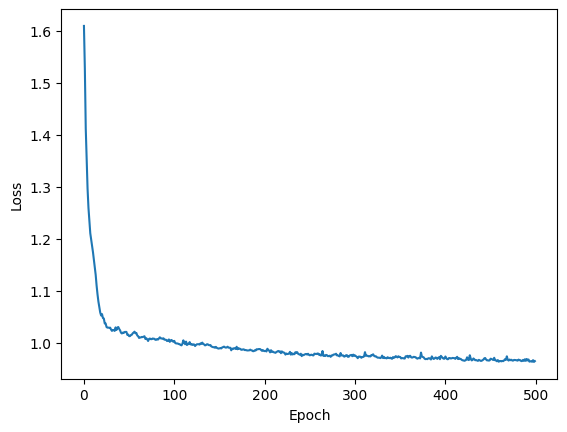

Test accuracy: 465.5918279569892
Accuracy: 0.4821505376344086
Precision: 0.518279589313663
Recall: 0.480107438281666
F1-score: 0.49177937921694914


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       495
           1       0.46      0.47      0.47       472
           2       0.34      0.41      0.37       449
           3       0.32      0.38      0.34       463
           4       0.79      0.52      0.62       446

    accuracy                           0.48      2325
   macro avg       0.52      0.48      0.49      2325
weighted avg       0.52      0.48      0.49      2325

                    0           1           2           3           4  \
precision    0.685268    0.461856    0.336957    0.316940    0.790378   
recall       0.620202    0.474576    0.414254    0.375810    0.515695   
f1-score     0.651113    0.468130    0.371628    0.343874    0.624152   
support    495.000000  472.000000  449.000000  

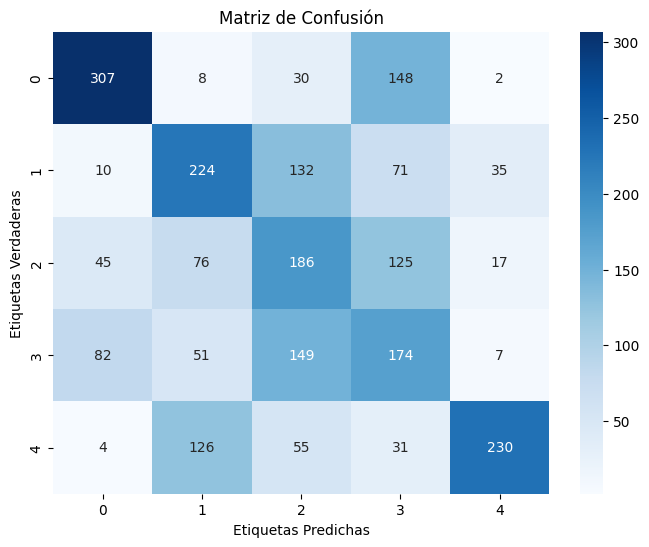

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/TF_IDF_embeddings/Neural_network_classification/RRN_500_0.0001_0.2/resultados_500_0.0001_0.2.json
Procesando red con 500 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|▏                                                              | 1/500 [00:03<28:32,  3.43s/it]

1.6097324953359715


Procesando epocas:   0%|▎                                                              | 2/500 [00:06<28:44,  3.46s/it]

1.6098421812057495


Procesando epocas:   1%|▍                                                              | 3/500 [00:10<28:53,  3.49s/it]

1.6098808751386755


Procesando epocas:   1%|▌                                                              | 4/500 [00:13<28:48,  3.48s/it]

1.6097907494096195


Procesando epocas:   1%|▋                                                              | 5/500 [00:17<28:46,  3.49s/it]

1.6095891082988065


Procesando epocas:   1%|▊                                                              | 6/500 [00:20<28:40,  3.48s/it]

1.6093275596113765


Procesando epocas:   1%|▉                                                              | 7/500 [00:24<28:40,  3.49s/it]

1.608248568983639


Procesando epocas:   2%|█                                                              | 8/500 [00:27<28:39,  3.49s/it]

1.6053190322483286


Procesando epocas:   2%|█▏                                                             | 9/500 [00:31<28:38,  3.50s/it]

1.5934081989176132


Procesando epocas:   2%|█▏                                                            | 10/500 [00:34<28:33,  3.50s/it]

1.5504151225090026


Procesando epocas:   2%|█▎                                                            | 11/500 [00:38<28:28,  3.49s/it]

1.4914437083637013


Procesando epocas:   2%|█▍                                                            | 12/500 [00:41<28:17,  3.48s/it]

1.4522516566164354


Procesando epocas:   3%|█▌                                                            | 13/500 [00:45<28:06,  3.46s/it]

1.42723549043431


Procesando epocas:   3%|█▋                                                            | 14/500 [00:48<27:55,  3.45s/it]

1.4042664408683776


Procesando epocas:   3%|█▊                                                            | 15/500 [00:52<27:58,  3.46s/it]

1.3866049317752613


Procesando epocas:   3%|█▉                                                            | 16/500 [00:55<27:53,  3.46s/it]

1.3709684154566597


Procesando epocas:   3%|██                                                            | 17/500 [00:59<27:51,  3.46s/it]

1.3552605067982393


Procesando epocas:   4%|██▏                                                           | 18/500 [01:02<27:50,  3.46s/it]

1.3407745803103728


Procesando epocas:   4%|██▎                                                           | 19/500 [01:06<27:51,  3.48s/it]

1.3305463489364175


Procesando epocas:   4%|██▍                                                           | 20/500 [01:09<27:55,  3.49s/it]

1.318008223701926


Procesando epocas:   4%|██▌                                                           | 21/500 [01:13<27:44,  3.47s/it]

1.3077679732266594


Procesando epocas:   4%|██▋                                                           | 22/500 [01:16<27:36,  3.47s/it]

1.296167456402498


Procesando epocas:   5%|██▊                                                           | 23/500 [01:19<27:36,  3.47s/it]

1.285956755105187


Procesando epocas:   5%|██▉                                                           | 24/500 [01:23<27:22,  3.45s/it]

1.2767240370021147


Procesando epocas:   5%|███                                                           | 25/500 [01:26<27:31,  3.48s/it]

1.2667754895546857


Procesando epocas:   5%|███▏                                                          | 26/500 [01:30<27:33,  3.49s/it]

1.2581137727288638


Procesando epocas:   5%|███▎                                                          | 27/500 [01:33<27:30,  3.49s/it]

1.2454052160767948


Procesando epocas:   6%|███▍                                                          | 28/500 [01:37<27:21,  3.48s/it]

1.242270511038163


Procesando epocas:   6%|███▌                                                          | 29/500 [01:40<27:09,  3.46s/it]

1.2270074662040262


Procesando epocas:   6%|███▋                                                          | 30/500 [01:44<27:08,  3.46s/it]

1.2200881460133721


Procesando epocas:   6%|███▊                                                          | 31/500 [01:47<27:07,  3.47s/it]

1.2200188447447384


Procesando epocas:   6%|███▉                                                          | 32/500 [01:51<27:04,  3.47s/it]

1.2088579858050628


Procesando epocas:   7%|████                                                          | 33/500 [01:54<26:58,  3.46s/it]

1.201936728814069


Procesando epocas:   7%|████▏                                                         | 34/500 [01:58<26:47,  3.45s/it]

1.191024459810818


Procesando epocas:   7%|████▎                                                         | 35/500 [02:01<26:45,  3.45s/it]

1.1845956269432516


Procesando epocas:   7%|████▍                                                         | 36/500 [02:04<26:46,  3.46s/it]

1.1746107669437633


Procesando epocas:   7%|████▌                                                         | 37/500 [02:08<26:46,  3.47s/it]

1.169772056271048


Procesando epocas:   8%|████▋                                                         | 38/500 [02:11<26:40,  3.46s/it]

1.158649775210549


Procesando epocas:   8%|████▊                                                         | 39/500 [02:15<26:33,  3.46s/it]

1.1516086164642783


Procesando epocas:   8%|████▉                                                         | 40/500 [02:18<26:22,  3.44s/it]

1.1434654733713936


Procesando epocas:   8%|█████                                                         | 41/500 [02:22<26:10,  3.42s/it]

1.1404978878357832


Procesando epocas:   8%|█████▏                                                        | 42/500 [02:25<26:07,  3.42s/it]

1.1346566691118127


Procesando epocas:   9%|█████▎                                                        | 43/500 [02:29<26:10,  3.44s/it]

1.124735006164102


Procesando epocas:   9%|█████▍                                                        | 44/500 [02:32<26:04,  3.43s/it]

1.1197261452674865


Procesando epocas:   9%|█████▌                                                        | 45/500 [02:35<25:55,  3.42s/it]

1.1156374552670647


Procesando epocas:   9%|█████▋                                                        | 46/500 [02:39<25:47,  3.41s/it]

1.109751267643536


Procesando epocas:   9%|█████▊                                                        | 47/500 [02:42<25:42,  3.40s/it]

1.108842991029515


Procesando epocas:  10%|█████▉                                                        | 48/500 [02:46<25:41,  3.41s/it]

1.0997366691336912


Procesando epocas:  10%|██████                                                        | 49/500 [02:49<25:37,  3.41s/it]

1.094868020800983


Procesando epocas:  10%|██████▏                                                       | 50/500 [02:52<25:34,  3.41s/it]

1.088859328802894


Procesando epocas:  10%|██████▎                                                       | 51/500 [02:56<25:33,  3.42s/it]

1.0838730303680195


Procesando epocas:  10%|██████▍                                                       | 52/500 [02:59<25:37,  3.43s/it]

1.0779046297073365


Procesando epocas:  11%|██████▌                                                       | 53/500 [03:03<25:34,  3.43s/it]

1.0769584098282983


Procesando epocas:  11%|██████▋                                                       | 54/500 [03:06<25:36,  3.45s/it]

1.0681479513645171


Procesando epocas:  11%|██████▊                                                       | 55/500 [03:10<25:28,  3.43s/it]

1.0651575239265667


Procesando epocas:  11%|██████▉                                                       | 56/500 [03:13<25:21,  3.43s/it]

1.0616977670613457


Procesando epocas:  11%|███████                                                       | 57/500 [03:16<25:21,  3.43s/it]

1.0569288818275226


Procesando epocas:  12%|███████▏                                                      | 58/500 [03:20<25:20,  3.44s/it]

1.0598218167529387


Procesando epocas:  12%|███████▎                                                      | 59/500 [03:23<25:18,  3.44s/it]

1.0486359172007618


Procesando epocas:  12%|███████▍                                                      | 60/500 [03:27<25:08,  3.43s/it]

1.0486755132675172


Procesando epocas:  12%|███████▌                                                      | 61/500 [03:30<25:05,  3.43s/it]

1.0477737353128544


Procesando epocas:  12%|███████▋                                                      | 62/500 [03:34<24:58,  3.42s/it]

1.0432723928900327


Procesando epocas:  13%|███████▊                                                      | 63/500 [03:37<24:51,  3.41s/it]

1.042827647223192


Procesando epocas:  13%|███████▉                                                      | 64/500 [03:40<24:53,  3.43s/it]

1.0378915706101586


Procesando epocas:  13%|████████                                                      | 65/500 [03:44<24:57,  3.44s/it]

1.0379552125930787


Procesando epocas:  13%|████████▏                                                     | 66/500 [03:47<24:49,  3.43s/it]

1.034861034154892


Procesando epocas:  13%|████████▎                                                     | 67/500 [03:51<24:47,  3.43s/it]

1.0287176745779374


Procesando epocas:  14%|████████▍                                                     | 68/500 [03:54<24:38,  3.42s/it]

1.0256035464651445


Procesando epocas:  14%|████████▌                                                     | 69/500 [03:58<24:40,  3.43s/it]

1.0263082230792326


Procesando epocas:  14%|████████▋                                                     | 70/500 [04:01<24:37,  3.44s/it]

1.022335172400755


Procesando epocas:  14%|████████▊                                                     | 71/500 [04:05<24:39,  3.45s/it]

1.0217407279154833


Procesando epocas:  14%|████████▉                                                     | 72/500 [04:08<24:45,  3.47s/it]

1.0193428204340094


Procesando epocas:  15%|█████████                                                     | 73/500 [04:12<24:45,  3.48s/it]

1.0175496932338266


Procesando epocas:  15%|█████████▏                                                    | 74/500 [04:15<24:45,  3.49s/it]

1.0199734989334555


Procesando epocas:  15%|█████████▎                                                    | 75/500 [04:19<24:42,  3.49s/it]

1.0181606573217055


Procesando epocas:  15%|█████████▍                                                    | 76/500 [04:22<24:30,  3.47s/it]

1.0126767298754524


Procesando epocas:  15%|█████████▌                                                    | 77/500 [04:25<24:23,  3.46s/it]

1.0133737960282494


Procesando epocas:  16%|█████████▋                                                    | 78/500 [04:29<24:17,  3.45s/it]

1.0106531563927146


Procesando epocas:  16%|█████████▊                                                    | 79/500 [04:32<24:17,  3.46s/it]

1.0137847865329068


Procesando epocas:  16%|█████████▉                                                    | 80/500 [04:36<24:11,  3.46s/it]

1.0119010834132924


Procesando epocas:  16%|██████████                                                    | 81/500 [04:39<24:06,  3.45s/it]

1.0072201202897464


Procesando epocas:  16%|██████████▏                                                   | 82/500 [04:43<23:57,  3.44s/it]

1.0091438146198497


Procesando epocas:  17%|██████████▎                                                   | 83/500 [04:46<23:57,  3.45s/it]

1.0066231008838205


Procesando epocas:  17%|██████████▍                                                   | 84/500 [04:50<23:53,  3.45s/it]

1.0021900594234467


Procesando epocas:  17%|██████████▌                                                   | 85/500 [04:53<23:45,  3.44s/it]

1.0035979873993817


Procesando epocas:  17%|██████████▋                                                   | 86/500 [04:56<23:44,  3.44s/it]

1.0013956939472872


Procesando epocas:  17%|██████████▊                                                   | 87/500 [05:00<23:39,  3.44s/it]

1.0024764457169701


Procesando epocas:  18%|██████████▉                                                   | 88/500 [05:03<23:36,  3.44s/it]

0.9995795316555921


Procesando epocas:  18%|███████████                                                   | 89/500 [05:07<23:39,  3.45s/it]

1.001008061801686


Procesando epocas:  18%|███████████▏                                                  | 90/500 [05:10<23:35,  3.45s/it]

0.9990405952229219


Procesando epocas:  18%|███████████▎                                                  | 91/500 [05:14<23:38,  3.47s/it]

1.0000247527571287


Procesando epocas:  18%|███████████▍                                                  | 92/500 [05:17<23:30,  3.46s/it]

0.9969744927742902


Procesando epocas:  19%|███████████▌                                                  | 93/500 [05:21<23:18,  3.43s/it]

0.9966625785126405


Procesando epocas:  19%|███████████▋                                                  | 94/500 [05:24<23:13,  3.43s/it]

0.9978823363780975


Procesando epocas:  19%|███████████▊                                                  | 95/500 [05:27<23:09,  3.43s/it]

0.9959762993980856


Procesando epocas:  19%|███████████▉                                                  | 96/500 [05:31<23:14,  3.45s/it]

0.9955258530728958


Procesando epocas:  19%|████████████                                                  | 97/500 [05:34<23:09,  3.45s/it]

0.9970836765625898


Procesando epocas:  20%|████████████▏                                                 | 98/500 [05:38<23:12,  3.46s/it]

0.9949546372189241


Procesando epocas:  20%|████████████▎                                                 | 99/500 [05:41<23:07,  3.46s/it]

0.9942872341941384


Procesando epocas:  20%|████████████▏                                                | 100/500 [05:45<23:09,  3.47s/it]

0.9936042782138376


Procesando epocas:  20%|████████████▎                                                | 101/500 [05:48<23:04,  3.47s/it]

0.9912569536882289


Procesando epocas:  20%|████████████▍                                                | 102/500 [05:52<22:52,  3.45s/it]

0.9925699581118191


Procesando epocas:  21%|████████████▌                                                | 103/500 [05:55<22:45,  3.44s/it]

0.9928180189693675


Procesando epocas:  21%|████████████▋                                                | 104/500 [05:58<22:40,  3.44s/it]

0.9917647817555596


Procesando epocas:  21%|████████████▊                                                | 105/500 [06:02<22:34,  3.43s/it]

0.9917460062924554


Procesando epocas:  21%|████████████▉                                                | 106/500 [06:05<22:31,  3.43s/it]

0.989307021744111


Procesando epocas:  21%|█████████████                                                | 107/500 [06:09<22:24,  3.42s/it]

0.9893454218611998


Procesando epocas:  22%|█████████████▏                                               | 108/500 [06:12<22:22,  3.42s/it]

0.9877688474514905


Procesando epocas:  22%|█████████████▎                                               | 109/500 [06:16<22:18,  3.42s/it]

0.9889100905726937


Procesando epocas:  22%|█████████████▍                                               | 110/500 [06:19<22:16,  3.43s/it]

0.9877910109127269


Procesando epocas:  22%|█████████████▌                                               | 111/500 [06:22<22:09,  3.42s/it]

0.9872080932645236


Procesando epocas:  22%|█████████████▋                                               | 112/500 [06:26<22:11,  3.43s/it]

0.9899591249578139


Procesando epocas:  23%|█████████████▊                                               | 113/500 [06:29<22:08,  3.43s/it]

0.9877532639924218


Procesando epocas:  23%|█████████████▉                                               | 114/500 [06:33<22:08,  3.44s/it]

0.986234813227373


Procesando epocas:  23%|██████████████                                               | 115/500 [06:36<22:04,  3.44s/it]

0.9867084050879759


Procesando epocas:  23%|██████████████▏                                              | 116/500 [06:40<22:04,  3.45s/it]

0.98728127654861


Procesando epocas:  23%|██████████████▎                                              | 117/500 [06:43<22:04,  3.46s/it]

0.9871362163740046


Procesando epocas:  24%|██████████████▍                                              | 118/500 [06:47<21:55,  3.44s/it]

0.985025707062553


Procesando epocas:  24%|██████████████▌                                              | 119/500 [06:50<21:50,  3.44s/it]

0.9868526192272411


Procesando epocas:  24%|██████████████▋                                              | 120/500 [06:53<21:46,  3.44s/it]

0.9848245554110583


Procesando epocas:  24%|██████████████▊                                              | 121/500 [06:57<21:45,  3.45s/it]

0.98396414623541


Procesando epocas:  24%|██████████████▉                                              | 122/500 [07:00<21:45,  3.45s/it]

0.9851195310845094


Procesando epocas:  25%|███████████████                                              | 123/500 [07:04<21:43,  3.46s/it]

0.9835235809578615


Procesando epocas:  25%|███████████████▏                                             | 124/500 [07:07<21:36,  3.45s/it]

0.9846942256478702


Procesando epocas:  25%|███████████████▎                                             | 125/500 [07:11<21:30,  3.44s/it]

0.9842165242223179


Procesando epocas:  25%|███████████████▎                                             | 126/500 [07:14<21:32,  3.46s/it]

0.9819213204524097


Procesando epocas:  25%|███████████████▍                                             | 127/500 [07:18<21:33,  3.47s/it]

0.9825444295125849


Procesando epocas:  26%|███████████████▌                                             | 128/500 [07:21<21:32,  3.48s/it]

0.9811584332410027


Procesando epocas:  26%|███████████████▋                                             | 129/500 [07:25<21:24,  3.46s/it]

0.9827165887636297


Procesando epocas:  26%|███████████████▊                                             | 130/500 [07:28<21:15,  3.45s/it]

0.9814753711223603


Procesando epocas:  26%|███████████████▉                                             | 131/500 [07:32<21:17,  3.46s/it]

0.9815867469591253


Procesando epocas:  26%|████████████████                                             | 132/500 [07:35<21:10,  3.45s/it]

0.9808028960929197


Procesando epocas:  27%|████████████████▏                                            | 133/500 [07:38<21:00,  3.44s/it]

0.9821252914036022


Procesando epocas:  27%|████████████████▎                                            | 134/500 [07:42<20:53,  3.43s/it]

0.980558464457007


Procesando epocas:  27%|████████████████▍                                            | 135/500 [07:45<20:50,  3.43s/it]

0.9826369278571185


Procesando epocas:  27%|████████████████▌                                            | 136/500 [07:50<23:56,  3.95s/it]

0.9819479665335487


Procesando epocas:  27%|████████████████▋                                            | 137/500 [07:57<28:49,  4.76s/it]

0.9811160168227028


Procesando epocas:  28%|████████████████▊                                            | 138/500 [08:02<29:58,  4.97s/it]

0.9809114466695225


Procesando epocas:  28%|████████████████▉                                            | 139/500 [08:08<30:46,  5.11s/it]

0.9814466599155874


Procesando epocas:  28%|█████████████████                                            | 140/500 [08:13<31:09,  5.19s/it]

0.9806280353490044


Procesando epocas:  28%|█████████████████▏                                           | 141/500 [08:19<31:29,  5.26s/it]

0.9799116394099068


Procesando epocas:  28%|█████████████████▎                                           | 142/500 [08:24<31:36,  5.30s/it]

0.9797461372964522


Procesando epocas:  29%|█████████████████▍                                           | 143/500 [08:29<31:39,  5.32s/it]

0.9794284613693461


Procesando epocas:  29%|█████████████████▌                                           | 144/500 [08:35<31:50,  5.37s/it]

0.9791289964142967


Procesando epocas:  29%|█████████████████▋                                           | 145/500 [08:40<31:48,  5.38s/it]

0.9795300995602327


Procesando epocas:  29%|█████████████████▊                                           | 146/500 [08:46<31:46,  5.38s/it]

0.9799932013539707


Procesando epocas:  29%|█████████████████▉                                           | 147/500 [08:51<32:10,  5.47s/it]

0.978565455534879


Procesando epocas:  30%|██████████████████                                           | 148/500 [08:57<32:00,  5.45s/it]

0.9790172405102674


Procesando epocas:  30%|██████████████████▏                                          | 149/500 [09:02<32:12,  5.50s/it]

0.9785544570754556


Procesando epocas:  30%|██████████████████▎                                          | 150/500 [09:08<32:15,  5.53s/it]

0.9782857663491193


Procesando epocas:  30%|██████████████████▍                                          | 151/500 [09:14<32:24,  5.57s/it]

0.977838415258071


Procesando epocas:  30%|██████████████████▌                                          | 152/500 [09:19<32:06,  5.54s/it]

0.9763517383266898


Procesando epocas:  31%|██████████████████▋                                          | 153/500 [09:25<32:19,  5.59s/it]

0.9793805641286514


Procesando epocas:  31%|██████████████████▊                                          | 154/500 [09:31<32:22,  5.61s/it]

0.9790513056166031


Procesando epocas:  31%|██████████████████▉                                          | 155/500 [09:36<32:21,  5.63s/it]

0.9779454567853142


Procesando epocas:  31%|███████████████████                                          | 156/500 [09:42<32:25,  5.65s/it]

0.9785629023523892


Procesando epocas:  31%|███████████████████▏                                         | 157/500 [09:48<32:22,  5.66s/it]

0.9783092421643874


Procesando epocas:  32%|███████████████████▎                                         | 158/500 [09:53<31:59,  5.61s/it]

0.9789231030380025


Procesando epocas:  32%|███████████████████▍                                         | 159/500 [09:58<31:30,  5.55s/it]

0.979534290117376


Procesando epocas:  32%|███████████████████▌                                         | 160/500 [10:04<31:20,  5.53s/it]

0.9779288393609664


Procesando epocas:  32%|███████████████████▋                                         | 161/500 [10:10<31:35,  5.59s/it]

0.9782908657017876


Procesando epocas:  32%|███████████████████▊                                         | 162/500 [10:15<31:23,  5.57s/it]

0.9779978625914629


Procesando epocas:  33%|███████████████████▉                                         | 163/500 [10:21<31:26,  5.60s/it]

0.9786083326620214


Procesando epocas:  33%|████████████████████                                         | 164/500 [10:26<31:03,  5.55s/it]

0.9784438985235551


Procesando epocas:  33%|████████████████████▏                                        | 165/500 [10:32<30:49,  5.52s/it]

0.9753619355313918


Procesando epocas:  33%|████████████████████▎                                        | 166/500 [10:37<30:39,  5.51s/it]

0.976873096999


Procesando epocas:  33%|████████████████████▎                                        | 167/500 [10:43<30:25,  5.48s/it]

0.9771515180082883


Procesando epocas:  34%|████████████████████▍                                        | 168/500 [10:48<30:07,  5.44s/it]

0.9766311059979832


Procesando epocas:  34%|████████████████████▌                                        | 169/500 [10:53<29:49,  5.41s/it]

0.9763001585707946


Procesando epocas:  34%|████████████████████▋                                        | 170/500 [10:59<29:48,  5.42s/it]

0.9777884490349713


Procesando epocas:  34%|████████████████████▊                                        | 171/500 [11:04<29:43,  5.42s/it]

0.9766673431676977


Procesando epocas:  34%|████████████████████▉                                        | 172/500 [11:10<29:37,  5.42s/it]

0.9745701162254109


Procesando epocas:  35%|█████████████████████                                        | 173/500 [11:15<29:32,  5.42s/it]

0.9767980547512278


Procesando epocas:  35%|█████████████████████▏                                       | 174/500 [11:21<29:34,  5.44s/it]

0.9772267566007726


Procesando epocas:  35%|█████████████████████▎                                       | 175/500 [11:26<30:15,  5.58s/it]

0.9752584958777708


Procesando epocas:  35%|█████████████████████▍                                       | 176/500 [11:32<30:22,  5.62s/it]

0.9772594178424162


Procesando epocas:  35%|█████████████████████▌                                       | 177/500 [11:38<30:28,  5.66s/it]

0.9756360776284162


Procesando epocas:  36%|█████████████████████▋                                       | 178/500 [11:44<30:26,  5.67s/it]

0.9763697252554052


Procesando epocas:  36%|█████████████████████▊                                       | 179/500 [11:49<30:07,  5.63s/it]

0.9758662213297451


Procesando epocas:  36%|█████████████████████▉                                       | 180/500 [11:55<29:58,  5.62s/it]

0.9748088023241829


Procesando epocas:  36%|██████████████████████                                       | 181/500 [12:00<29:52,  5.62s/it]

0.9741097022505367


Procesando epocas:  36%|██████████████████████▏                                      | 182/500 [12:06<29:50,  5.63s/it]

0.9752523695721346


Procesando epocas:  37%|██████████████████████▎                                      | 183/500 [12:12<29:30,  5.58s/it]

0.9749367321238799


Procesando epocas:  37%|██████████████████████▍                                      | 184/500 [12:17<29:21,  5.58s/it]

0.9749714048469768


Procesando epocas:  37%|██████████████████████▌                                      | 185/500 [12:23<29:12,  5.56s/it]

0.9753957797499264


Procesando epocas:  37%|██████████████████████▋                                      | 186/500 [12:28<28:54,  5.52s/it]

0.9740259479073917


Procesando epocas:  37%|██████████████████████▊                                      | 187/500 [12:33<28:42,  5.50s/it]

0.9742364375030294


Procesando epocas:  38%|██████████████████████▉                                      | 188/500 [12:39<28:39,  5.51s/it]

0.9749557039316963


Procesando epocas:  38%|███████████████████████                                      | 189/500 [12:45<28:46,  5.55s/it]

0.9747556454995099


Procesando epocas:  38%|███████████████████████▏                                     | 190/500 [12:50<28:27,  5.51s/it]

0.9753027435611276


Procesando epocas:  38%|███████████████████████▎                                     | 191/500 [12:55<28:12,  5.48s/it]

0.9750555168179905


Procesando epocas:  38%|███████████████████████▍                                     | 192/500 [13:01<28:00,  5.45s/it]

0.9743646102793077


Procesando epocas:  39%|███████████████████████▌                                     | 193/500 [13:06<27:52,  5.45s/it]

0.9733242403058445


Procesando epocas:  39%|███████████████████████▋                                     | 194/500 [13:12<27:58,  5.48s/it]

0.9743769645690918


Procesando epocas:  39%|███████████████████████▊                                     | 195/500 [13:17<27:54,  5.49s/it]

0.97387755372945


Procesando epocas:  39%|███████████████████████▉                                     | 196/500 [13:23<27:39,  5.46s/it]

0.9741917333182166


Procesando epocas:  39%|████████████████████████                                     | 197/500 [13:28<27:27,  5.44s/it]

0.9742118575993706


Procesando epocas:  40%|████████████████████████▏                                    | 198/500 [13:34<27:24,  5.45s/it]

0.973194957480711


Procesando epocas:  40%|████████████████████████▎                                    | 199/500 [13:39<27:12,  5.42s/it]

0.9744129696313073


Procesando epocas:  40%|████████████████████████▍                                    | 200/500 [13:44<27:00,  5.40s/it]

0.9737137051189647


Procesando epocas:  40%|████████████████████████▌                                    | 201/500 [13:50<27:08,  5.45s/it]

0.9737152285435621


Procesando epocas:  40%|████████████████████████▋                                    | 202/500 [13:55<27:02,  5.44s/it]

0.9733691688846139


Procesando epocas:  41%|████████████████████████▊                                    | 203/500 [14:01<26:57,  5.45s/it]

0.972861855170306


Procesando epocas:  41%|████████████████████████▉                                    | 204/500 [14:06<26:53,  5.45s/it]

0.9728990733623505


Procesando epocas:  41%|█████████████████████████                                    | 205/500 [14:12<26:47,  5.45s/it]

0.9731568862410153


In [ ]:
epocas = [100,300,500]
lr = [0.0001,0.00001]
test_label = [0.3,0.2,0.1]
#RNN_model(X, labels ,0.3,10,0.001)

for test in test_label:
    for epoca in epocas:
        for rang in lr:
                print(f"Procesando red con {epoca} epocas y {rang} de factor de aprendizaje y conjunto de entrenamiento {1-test}")
                RNN_model(X, labels ,test,epoca,rang)